In [ ]:
!pip install -q git+https://github.com/huggingface/transformers.git
!pip install -q accelerate datasets peft bitsandbytes

In [1]:
import torch
from peft import LoraConfig
from transformers import AutoProcessor, BitsAndBytesConfig, Idefics2ForConditionalGeneration

In [2]:
DEVICE = "cuda"
USE_LORA = False
USE_QLORA = True

In [3]:
processor = AutoProcessor.from_pretrained(
    "HuggingFaceM4/idefics2-8b",
    do_image_splitting=False
)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [4]:
if USE_QLORA or USE_LORA:
    lora_config = LoraConfig(
        r=8,
        lora_alpha=8,
        lora_dropout=0.1,
        target_modules='.*(text_model|modality_projection|perceiver_resampler).*(down_proj|gate_proj|up_proj|k_proj|q_proj|v_proj|o_proj).*$',
        use_dora=False if USE_QLORA else True,
        init_lora_weights="gaussian"
    )
    if USE_QLORA:
        bnb_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_compute_dtype=torch.float16
        )
    model = Idefics2ForConditionalGeneration.from_pretrained(
        "HuggingFaceM4/idefics2-8b",
        torch_dtype=torch.float16,
        quantization_config=bnb_config if USE_QLORA else None,
    )
    model.add_adapter(lora_config)
    model.enable_adapters()
else:
    model = Idefics2ForConditionalGeneration.from_pretrained(
        "HuggingFaceM4/idefics2-8b",
        torch_dtype=torch.float16,
        _attn_implementation="flash_attention_2", # This works for A100 or H100
    ).to(DEVICE)

`low_cpu_mem_usage` was None, now set to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

In [5]:
model

Idefics2ForConditionalGeneration(
  (model): Idefics2Model(
    (vision_model): Idefics2VisionTransformer(
      (embeddings): Idefics2VisionEmbeddings(
        (patch_embedding): Conv2d(3, 1152, kernel_size=(14, 14), stride=(14, 14), padding=valid)
        (position_embedding): Embedding(4900, 1152)
      )
      (encoder): Idefics2Encoder(
        (layers): ModuleList(
          (0-26): 27 x Idefics2EncoderLayer(
            (self_attn): Idefics2VisionAttention(
              (k_proj): Linear4bit(in_features=1152, out_features=1152, bias=True)
              (v_proj): Linear4bit(in_features=1152, out_features=1152, bias=True)
              (q_proj): Linear4bit(in_features=1152, out_features=1152, bias=True)
              (out_proj): Linear4bit(in_features=1152, out_features=1152, bias=True)
            )
            (layer_norm1): LayerNorm((1152,), eps=1e-06, elementwise_affine=True)
            (mlp): Idefics2VisionMLP(
              (activation_fn): PytorchGELUTanh()
              

### Reduce GPU Memory Consumption
1. Using 4-bit quantization
2. Fine-tuning LoRA
3. Freezing vision encoder
4. Small batch size with high gradient accumulation
5. Disabling image segmentation
6. Flash attention

## Dataset Proceessing

In [6]:
from datasets import load_dataset

In [17]:
dataset = load_dataset("mdwiratathya/ROCO-radiology")
train_dataset = dataset['train']
eval_dataset = dataset['validation']
test_dataset = dataset['test']

Resolving data files:   0%|          | 0/26 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/26 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/26 [00:00<?, ?it/s]

In [18]:
train_dataset[10]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=475x340>,
 'image_id': 'ROCO_00013',
 'caption': ' Child with abduction and flexion of right lower extremity and hyperextension of the tibia on the femur, associated with dislocation of the left hip, probably the result of the dangerous position of adduction in production of pathological dislocation. A roentgenogram of the mother’s pelvis, one week before delivery, showed this same deformity in utero.\n'}

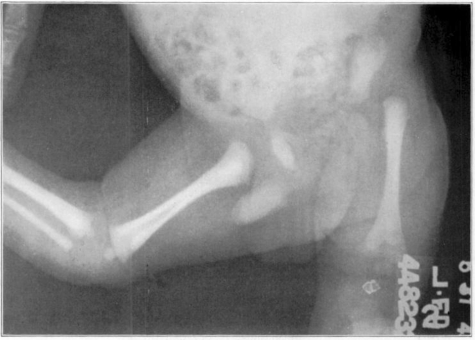

In [19]:
train_dataset[10]["image"]

### Processing Dataset Image-Caption

In [20]:
import random

class MyDataCollator:
    def __init__(self, processor, prompts):
        self.processor = processor
        self.prompts = prompts
        self.image_token_id = processor.tokenizer.additional_special_tokens_ids[
            processor.tokenizer.additional_special_tokens.index("<image>")
        ]

    def __call__(self, examples):
        texts = []
        images = []
        for example in examples:
            image = example["image"]
            caption = example["caption"]
            prompt = random.choice(self.prompts)  # Randomly select a prompt
            messages = [
                {
                    "role": "user",
                    "content": [
                        {"type": "text", "text": prompt},
                        {"type": "image"}
                    ]
                },
                {
                    "role": "assistant",
                    "content": [
                        {"type": "text", "text": caption}
                    ]
                }
            ]
            text = self.processor.apply_chat_template(messages, add_generation_prompt=False)
            texts.append(text.strip())
            images.append([image])

        batch = self.processor(text=texts, images=images, return_tensors="pt", padding=True)

        labels = batch["input_ids"].clone()
        labels[labels == self.processor.tokenizer.pad_token_id] = self.image_token_id
        batch["labels"] = labels

        return batch

# Example usage
prompts = [
    "Describe this image.",
    "What does this image show?",
    "Explain the content of this image.",
    "Caption this image.",
    "What can you see in this image?"
]
data_collator = MyDataCollator(processor, prompts)

1. Input IDs: Input Index supplied to the langugage model

2. Attention_mask: attention mask for inputs_ids

3. Pixel Values: Preprocessed pixel values to encode the image

4. Pixel Attention Mask: Attention mask for pixel values

## Training Loop

In [21]:
from transformers import TrainingArguments, Trainer

In [22]:
training_args = TrainingArguments(
    num_train_epochs=1,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=4,
    # warmup_steps=50,
    learning_rate = 1e-4,
    weight_decay=0.01,
    logging_steps=5,
    output_dir = "D:/MedVQA/idefics2_trial/ROCOmedrad",
    save_strategy = "steps",
    save_steps = 10,
    save_total_limit = 1,
    fp16 = True,
    # push_to_hub_model_id = "idefics2-8b-finetuned-multimodal",
    remove_unused_columns=False,
    report_to="none"
)

In [24]:
trainer = Trainer(
    model = model,
    args = training_args,
    data_collator = data_collator,
    train_dataset = train_dataset,
    eval_dataset = eval_dataset
)

In [25]:
trainer.train() 

  0%|          | 0/16354 [00:00<?, ?it/s]

{'loss': 9.9905, 'grad_norm': 75.38510131835938, 'learning_rate': 9.99816558640088e-05, 'epoch': 0.0}
{'loss': 0.8911, 'grad_norm': inf, 'learning_rate': 9.995719701602056e-05, 'epoch': 0.0}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6949, 'grad_norm': 9.50736141204834, 'learning_rate': 9.993273816803229e-05, 'epoch': 0.0}
{'loss': 0.7282, 'grad_norm': 10.306133270263672, 'learning_rate': 9.990216460804697e-05, 'epoch': 0.0}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7172, 'grad_norm': 6.606608867645264, 'learning_rate': 9.987159104806164e-05, 'epoch': 0.0}
{'loss': 0.7059, 'grad_norm': 9.057808876037598, 'learning_rate': 9.984101748807632e-05, 'epoch': 0.0}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6722, 'grad_norm': 9.947638511657715, 'learning_rate': 9.981044392809099e-05, 'epoch': 0.0}
{'loss': 0.6474, 'grad_norm': 10.026838302612305, 'learning_rate': 9.977987036810567e-05, 'epoch': 0.0}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6288, 'grad_norm': 6.48590612411499, 'learning_rate': 9.974929680812034e-05, 'epoch': 0.0}
{'loss': 0.6454, 'grad_norm': 9.519327163696289, 'learning_rate': 9.971872324813502e-05, 'epoch': 0.0}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6707, 'grad_norm': 11.21879768371582, 'learning_rate': 9.968814968814969e-05, 'epoch': 0.0}
{'loss': 0.7313, 'grad_norm': 5.920203685760498, 'learning_rate': 9.965757612816437e-05, 'epoch': 0.0}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6837, 'grad_norm': 10.847475051879883, 'learning_rate': 9.962700256817904e-05, 'epoch': 0.0}
{'loss': 0.7796, 'grad_norm': 9.113168716430664, 'learning_rate': 9.959642900819372e-05, 'epoch': 0.0}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6563, 'grad_norm': 6.837366580963135, 'learning_rate': 9.956585544820839e-05, 'epoch': 0.0}
{'loss': 0.612, 'grad_norm': 10.96389389038086, 'learning_rate': 9.953528188822307e-05, 'epoch': 0.0}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6506, 'grad_norm': 8.931562423706055, 'learning_rate': 9.950470832823775e-05, 'epoch': 0.01}
{'loss': 0.7172, 'grad_norm': 7.027576446533203, 'learning_rate': 9.947413476825243e-05, 'epoch': 0.01}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6819, 'grad_norm': 11.439410209655762, 'learning_rate': 9.94435612082671e-05, 'epoch': 0.01}
{'loss': 0.6472, 'grad_norm': 6.327011585235596, 'learning_rate': 9.941298764828178e-05, 'epoch': 0.01}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7335, 'grad_norm': 7.730967998504639, 'learning_rate': 9.938241408829645e-05, 'epoch': 0.01}
{'loss': 0.7481, 'grad_norm': 10.344636917114258, 'learning_rate': 9.935184052831113e-05, 'epoch': 0.01}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6606, 'grad_norm': 8.602760314941406, 'learning_rate': 9.93212669683258e-05, 'epoch': 0.01}
{'loss': 0.5993, 'grad_norm': 8.640459060668945, 'learning_rate': 9.929069340834048e-05, 'epoch': 0.01}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7776, 'grad_norm': 6.8804168701171875, 'learning_rate': 9.926011984835515e-05, 'epoch': 0.01}
{'loss': 0.5262, 'grad_norm': 5.99940824508667, 'learning_rate': 9.922954628836983e-05, 'epoch': 0.01}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7857, 'grad_norm': 8.655717849731445, 'learning_rate': 9.91989727283845e-05, 'epoch': 0.01}
{'loss': 0.6951, 'grad_norm': 7.443028926849365, 'learning_rate': 9.916839916839918e-05, 'epoch': 0.01}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6067, 'grad_norm': 6.780490398406982, 'learning_rate': 9.913782560841385e-05, 'epoch': 0.01}
{'loss': 0.6905, 'grad_norm': 7.961496353149414, 'learning_rate': 9.910725204842853e-05, 'epoch': 0.01}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.792, 'grad_norm': 9.80644702911377, 'learning_rate': 9.90766784884432e-05, 'epoch': 0.01}
{'loss': 0.7285, 'grad_norm': 6.95234489440918, 'learning_rate': 9.904610492845788e-05, 'epoch': 0.01}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6971, 'grad_norm': 10.322147369384766, 'learning_rate': 9.901553136847255e-05, 'epoch': 0.01}
{'loss': 0.7076, 'grad_norm': 7.062246799468994, 'learning_rate': 9.898495780848723e-05, 'epoch': 0.01}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7653, 'grad_norm': 8.17577075958252, 'learning_rate': 9.89543842485019e-05, 'epoch': 0.01}
{'loss': 0.5402, 'grad_norm': 13.226487159729004, 'learning_rate': 9.892381068851658e-05, 'epoch': 0.01}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.709, 'grad_norm': 6.798822402954102, 'learning_rate': 9.889323712853125e-05, 'epoch': 0.01}
{'loss': 0.6695, 'grad_norm': 5.606594562530518, 'learning_rate': 9.886266356854593e-05, 'epoch': 0.01}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6353, 'grad_norm': 6.59720516204834, 'learning_rate': 9.88320900085606e-05, 'epoch': 0.01}
{'loss': 0.732, 'grad_norm': 11.732044219970703, 'learning_rate': 9.880151644857528e-05, 'epoch': 0.01}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.572, 'grad_norm': 8.207303047180176, 'learning_rate': 9.877094288858995e-05, 'epoch': 0.01}
{'loss': 0.6607, 'grad_norm': 6.3000311851501465, 'learning_rate': 9.874036932860463e-05, 'epoch': 0.01}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.8049, 'grad_norm': 8.476546287536621, 'learning_rate': 9.87097957686193e-05, 'epoch': 0.01}
{'loss': 0.7486, 'grad_norm': 8.924278259277344, 'learning_rate': 9.867922220863398e-05, 'epoch': 0.01}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7239, 'grad_norm': 7.1926703453063965, 'learning_rate': 9.864864864864865e-05, 'epoch': 0.01}
{'loss': 0.7283, 'grad_norm': 8.830796241760254, 'learning_rate': 9.861807508866332e-05, 'epoch': 0.01}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6906, 'grad_norm': 7.285775184631348, 'learning_rate': 9.8587501528678e-05, 'epoch': 0.01}
{'loss': 0.6054, 'grad_norm': 10.41552734375, 'learning_rate': 9.855692796869267e-05, 'epoch': 0.01}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6105, 'grad_norm': 6.387608528137207, 'learning_rate': 9.852635440870735e-05, 'epoch': 0.01}
{'loss': 0.6848, 'grad_norm': 9.666386604309082, 'learning_rate': 9.849578084872202e-05, 'epoch': 0.02}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7806, 'grad_norm': 9.730688095092773, 'learning_rate': 9.84652072887367e-05, 'epoch': 0.02}
{'loss': 0.685, 'grad_norm': 6.58384370803833, 'learning_rate': 9.843463372875137e-05, 'epoch': 0.02}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7613, 'grad_norm': 10.730695724487305, 'learning_rate': 9.840406016876605e-05, 'epoch': 0.02}
{'loss': 0.5629, 'grad_norm': 6.253530025482178, 'learning_rate': 9.837348660878072e-05, 'epoch': 0.02}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.8166, 'grad_norm': 16.33257293701172, 'learning_rate': 9.83429130487954e-05, 'epoch': 0.02}
{'loss': 0.6219, 'grad_norm': 6.671050071716309, 'learning_rate': 9.831233948881007e-05, 'epoch': 0.02}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7214, 'grad_norm': 7.814781665802002, 'learning_rate': 9.828176592882475e-05, 'epoch': 0.02}
{'loss': 0.6749, 'grad_norm': 7.725494861602783, 'learning_rate': 9.825119236883942e-05, 'epoch': 0.02}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6687, 'grad_norm': 7.7547688484191895, 'learning_rate': 9.82206188088541e-05, 'epoch': 0.02}
{'loss': 0.7357, 'grad_norm': 9.545827865600586, 'learning_rate': 9.819004524886877e-05, 'epoch': 0.02}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.623, 'grad_norm': 5.490177631378174, 'learning_rate': 9.815947168888345e-05, 'epoch': 0.02}
{'loss': 0.7548, 'grad_norm': 6.328312397003174, 'learning_rate': 9.812889812889814e-05, 'epoch': 0.02}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6143, 'grad_norm': 5.454699993133545, 'learning_rate': 9.809832456891281e-05, 'epoch': 0.02}
{'loss': 0.6249, 'grad_norm': 6.992599010467529, 'learning_rate': 9.806775100892749e-05, 'epoch': 0.02}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6375, 'grad_norm': 7.457510471343994, 'learning_rate': 9.803717744894216e-05, 'epoch': 0.02}
{'loss': 0.6565, 'grad_norm': 7.4929585456848145, 'learning_rate': 9.800660388895684e-05, 'epoch': 0.02}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6182, 'grad_norm': 5.378264904022217, 'learning_rate': 9.797603032897151e-05, 'epoch': 0.02}
{'loss': 0.6791, 'grad_norm': 5.271005630493164, 'learning_rate': 9.794545676898619e-05, 'epoch': 0.02}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.73, 'grad_norm': 7.610729217529297, 'learning_rate': 9.791488320900086e-05, 'epoch': 0.02}
{'loss': 0.7618, 'grad_norm': 6.972113609313965, 'learning_rate': 9.788430964901553e-05, 'epoch': 0.02}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5847, 'grad_norm': 9.643182754516602, 'learning_rate': 9.785373608903021e-05, 'epoch': 0.02}
{'loss': 0.5834, 'grad_norm': 6.86545991897583, 'learning_rate': 9.782316252904488e-05, 'epoch': 0.02}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6174, 'grad_norm': 8.572851181030273, 'learning_rate': 9.779258896905956e-05, 'epoch': 0.02}
{'loss': 0.5776, 'grad_norm': 6.681376934051514, 'learning_rate': 9.776201540907423e-05, 'epoch': 0.02}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6664, 'grad_norm': 6.339535713195801, 'learning_rate': 9.773144184908891e-05, 'epoch': 0.02}
{'loss': 0.7144, 'grad_norm': 7.264912128448486, 'learning_rate': 9.770086828910358e-05, 'epoch': 0.02}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5649, 'grad_norm': 8.565573692321777, 'learning_rate': 9.767029472911826e-05, 'epoch': 0.02}
{'loss': 0.7221, 'grad_norm': 5.478029251098633, 'learning_rate': 9.763972116913293e-05, 'epoch': 0.02}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.8019, 'grad_norm': 8.736050605773926, 'learning_rate': 9.760914760914761e-05, 'epoch': 0.02}
{'loss': 0.7592, 'grad_norm': 5.732898712158203, 'learning_rate': 9.757857404916228e-05, 'epoch': 0.02}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.718, 'grad_norm': 9.962336540222168, 'learning_rate': 9.754800048917696e-05, 'epoch': 0.02}
{'loss': 0.729, 'grad_norm': 9.08420467376709, 'learning_rate': 9.751742692919163e-05, 'epoch': 0.03}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6617, 'grad_norm': 6.965229511260986, 'learning_rate': 9.748685336920631e-05, 'epoch': 0.03}
{'loss': 0.6896, 'grad_norm': 7.51199197769165, 'learning_rate': 9.745627980922098e-05, 'epoch': 0.03}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5807, 'grad_norm': 7.171275615692139, 'learning_rate': 9.742570624923567e-05, 'epoch': 0.03}
{'loss': 0.6198, 'grad_norm': 9.567634582519531, 'learning_rate': 9.739513268925035e-05, 'epoch': 0.03}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7111, 'grad_norm': 7.033270835876465, 'learning_rate': 9.736455912926502e-05, 'epoch': 0.03}
{'loss': 0.6004, 'grad_norm': 8.033649444580078, 'learning_rate': 9.73339855692797e-05, 'epoch': 0.03}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6868, 'grad_norm': 7.884664058685303, 'learning_rate': 9.730341200929437e-05, 'epoch': 0.03}
{'loss': 0.7785, 'grad_norm': 9.705717086791992, 'learning_rate': 9.727283844930905e-05, 'epoch': 0.03}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7254, 'grad_norm': 4.264050006866455, 'learning_rate': 9.724226488932372e-05, 'epoch': 0.03}
{'loss': 0.7304, 'grad_norm': 6.179792404174805, 'learning_rate': 9.72116913293384e-05, 'epoch': 0.03}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6702, 'grad_norm': 6.948984146118164, 'learning_rate': 9.718111776935307e-05, 'epoch': 0.03}
{'loss': 0.7142, 'grad_norm': 5.5907301902771, 'learning_rate': 9.715054420936775e-05, 'epoch': 0.03}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7328, 'grad_norm': 7.645248889923096, 'learning_rate': 9.711997064938242e-05, 'epoch': 0.03}
{'loss': 0.6494, 'grad_norm': 4.02240514755249, 'learning_rate': 9.70893970893971e-05, 'epoch': 0.03}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5864, 'grad_norm': 7.196363925933838, 'learning_rate': 9.705882352941177e-05, 'epoch': 0.03}
{'loss': 0.8103, 'grad_norm': 7.669742107391357, 'learning_rate': 9.702824996942644e-05, 'epoch': 0.03}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6916, 'grad_norm': 8.719106674194336, 'learning_rate': 9.699767640944112e-05, 'epoch': 0.03}
{'loss': 0.6885, 'grad_norm': 7.380615711212158, 'learning_rate': 9.69671028494558e-05, 'epoch': 0.03}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.67, 'grad_norm': 9.331696510314941, 'learning_rate': 9.693652928947047e-05, 'epoch': 0.03}
{'loss': 0.578, 'grad_norm': 6.68773889541626, 'learning_rate': 9.690595572948514e-05, 'epoch': 0.03}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6662, 'grad_norm': 8.693699836730957, 'learning_rate': 9.687538216949982e-05, 'epoch': 0.03}
{'loss': 0.6305, 'grad_norm': 7.22748327255249, 'learning_rate': 9.68448086095145e-05, 'epoch': 0.03}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6419, 'grad_norm': 6.144293308258057, 'learning_rate': 9.681423504952917e-05, 'epoch': 0.03}
{'loss': 0.686, 'grad_norm': 5.35883092880249, 'learning_rate': 9.678366148954384e-05, 'epoch': 0.03}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.669, 'grad_norm': 7.404857635498047, 'learning_rate': 9.675308792955853e-05, 'epoch': 0.03}
{'loss': 0.7117, 'grad_norm': 7.368019104003906, 'learning_rate': 9.67225143695732e-05, 'epoch': 0.03}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6197, 'grad_norm': 6.9207539558410645, 'learning_rate': 9.669194080958788e-05, 'epoch': 0.03}
{'loss': 0.6881, 'grad_norm': 5.39851188659668, 'learning_rate': 9.666136724960256e-05, 'epoch': 0.03}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6186, 'grad_norm': 6.847944259643555, 'learning_rate': 9.663079368961723e-05, 'epoch': 0.03}
{'loss': 0.6627, 'grad_norm': 9.795378684997559, 'learning_rate': 9.66002201296319e-05, 'epoch': 0.03}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6528, 'grad_norm': 5.070241928100586, 'learning_rate': 9.656964656964658e-05, 'epoch': 0.03}
{'loss': 0.4889, 'grad_norm': 5.094192981719971, 'learning_rate': 9.653907300966126e-05, 'epoch': 0.03}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6442, 'grad_norm': 7.120619297027588, 'learning_rate': 9.650849944967593e-05, 'epoch': 0.04}
{'loss': 0.6481, 'grad_norm': 4.159790515899658, 'learning_rate': 9.64779258896906e-05, 'epoch': 0.04}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7381, 'grad_norm': 8.607549667358398, 'learning_rate': 9.644735232970528e-05, 'epoch': 0.04}
{'loss': 0.6854, 'grad_norm': 6.131922721862793, 'learning_rate': 9.641677876971996e-05, 'epoch': 0.04}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.618, 'grad_norm': 4.61433744430542, 'learning_rate': 9.638620520973463e-05, 'epoch': 0.04}
{'loss': 0.5869, 'grad_norm': 6.085838317871094, 'learning_rate': 9.63556316497493e-05, 'epoch': 0.04}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6233, 'grad_norm': 7.492245674133301, 'learning_rate': 9.632505808976398e-05, 'epoch': 0.04}
{'loss': 0.5698, 'grad_norm': 5.3460917472839355, 'learning_rate': 9.629448452977865e-05, 'epoch': 0.04}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7212, 'grad_norm': 7.251879692077637, 'learning_rate': 9.626391096979333e-05, 'epoch': 0.04}
{'loss': 0.6988, 'grad_norm': 10.976212501525879, 'learning_rate': 9.6233337409808e-05, 'epoch': 0.04}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6692, 'grad_norm': 6.6321892738342285, 'learning_rate': 9.620276384982268e-05, 'epoch': 0.04}
{'loss': 0.705, 'grad_norm': 7.099600315093994, 'learning_rate': 9.617219028983735e-05, 'epoch': 0.04}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7324, 'grad_norm': 5.959365367889404, 'learning_rate': 9.614161672985203e-05, 'epoch': 0.04}
{'loss': 0.6736, 'grad_norm': 7.141411781311035, 'learning_rate': 9.61110431698667e-05, 'epoch': 0.04}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7429, 'grad_norm': 8.56041431427002, 'learning_rate': 9.608046960988138e-05, 'epoch': 0.04}
{'loss': 0.6465, 'grad_norm': 9.131245613098145, 'learning_rate': 9.604989604989605e-05, 'epoch': 0.04}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7152, 'grad_norm': 7.631772994995117, 'learning_rate': 9.601932248991073e-05, 'epoch': 0.04}
{'loss': 0.6453, 'grad_norm': 6.0544209480285645, 'learning_rate': 9.59887489299254e-05, 'epoch': 0.04}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7014, 'grad_norm': 6.830307960510254, 'learning_rate': 9.595817536994008e-05, 'epoch': 0.04}
{'loss': 0.7971, 'grad_norm': 5.961507797241211, 'learning_rate': 9.592760180995475e-05, 'epoch': 0.04}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6963, 'grad_norm': 5.994174003601074, 'learning_rate': 9.589702824996943e-05, 'epoch': 0.04}
{'loss': 0.7101, 'grad_norm': 5.232944488525391, 'learning_rate': 9.58664546899841e-05, 'epoch': 0.04}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6035, 'grad_norm': 5.449100494384766, 'learning_rate': 9.583588112999878e-05, 'epoch': 0.04}
{'loss': 0.7684, 'grad_norm': 8.119096755981445, 'learning_rate': 9.580530757001345e-05, 'epoch': 0.04}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7269, 'grad_norm': 5.748070240020752, 'learning_rate': 9.577473401002813e-05, 'epoch': 0.04}
{'loss': 0.5931, 'grad_norm': 5.253502368927002, 'learning_rate': 9.57441604500428e-05, 'epoch': 0.04}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6189, 'grad_norm': 5.30364990234375, 'learning_rate': 9.571358689005748e-05, 'epoch': 0.04}
{'loss': 0.675, 'grad_norm': 6.663154602050781, 'learning_rate': 9.568301333007215e-05, 'epoch': 0.04}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5982, 'grad_norm': 6.855649948120117, 'learning_rate': 9.565243977008683e-05, 'epoch': 0.04}
{'loss': 0.7805, 'grad_norm': 6.992794036865234, 'learning_rate': 9.56218662101015e-05, 'epoch': 0.04}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6119, 'grad_norm': 7.922741413116455, 'learning_rate': 9.559129265011618e-05, 'epoch': 0.04}
{'loss': 0.7407, 'grad_norm': 5.816635608673096, 'learning_rate': 9.556071909013085e-05, 'epoch': 0.04}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.844, 'grad_norm': 8.100456237792969, 'learning_rate': 9.553014553014553e-05, 'epoch': 0.04}
{'loss': 0.6659, 'grad_norm': 4.376857280731201, 'learning_rate': 9.54995719701602e-05, 'epoch': 0.05}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6802, 'grad_norm': 7.196243762969971, 'learning_rate': 9.546899841017488e-05, 'epoch': 0.05}
{'loss': 0.758, 'grad_norm': 11.671906471252441, 'learning_rate': 9.543842485018955e-05, 'epoch': 0.05}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7179, 'grad_norm': 8.5881929397583, 'learning_rate': 9.540785129020423e-05, 'epoch': 0.05}
{'loss': 0.8684, 'grad_norm': 6.8867950439453125, 'learning_rate': 9.53772777302189e-05, 'epoch': 0.05}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7022, 'grad_norm': 5.970175743103027, 'learning_rate': 9.534670417023359e-05, 'epoch': 0.05}
{'loss': 0.6797, 'grad_norm': 8.185301780700684, 'learning_rate': 9.531613061024826e-05, 'epoch': 0.05}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7519, 'grad_norm': 7.987825393676758, 'learning_rate': 9.528555705026294e-05, 'epoch': 0.05}
{'loss': 0.699, 'grad_norm': 11.280363082885742, 'learning_rate': 9.525498349027761e-05, 'epoch': 0.05}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7052, 'grad_norm': 8.631548881530762, 'learning_rate': 9.522440993029229e-05, 'epoch': 0.05}
{'loss': 0.6585, 'grad_norm': 6.3519463539123535, 'learning_rate': 9.519383637030696e-05, 'epoch': 0.05}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7519, 'grad_norm': 5.354097366333008, 'learning_rate': 9.516326281032164e-05, 'epoch': 0.05}
{'loss': 0.7235, 'grad_norm': 5.881709575653076, 'learning_rate': 9.513268925033631e-05, 'epoch': 0.05}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.9283, 'grad_norm': 9.956982612609863, 'learning_rate': 9.510211569035099e-05, 'epoch': 0.05}
{'loss': 0.7991, 'grad_norm': 6.438891410827637, 'learning_rate': 9.507154213036566e-05, 'epoch': 0.05}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6778, 'grad_norm': 5.149022102355957, 'learning_rate': 9.504096857038034e-05, 'epoch': 0.05}
{'loss': 0.6993, 'grad_norm': 7.197452545166016, 'learning_rate': 9.501039501039501e-05, 'epoch': 0.05}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.961, 'grad_norm': 6.0578837394714355, 'learning_rate': 9.497982145040969e-05, 'epoch': 0.05}
{'loss': 0.742, 'grad_norm': 5.969239711761475, 'learning_rate': 9.494924789042436e-05, 'epoch': 0.05}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.685, 'grad_norm': 5.595467567443848, 'learning_rate': 9.491867433043904e-05, 'epoch': 0.05}
{'loss': 0.6601, 'grad_norm': 6.349012851715088, 'learning_rate': 9.488810077045371e-05, 'epoch': 0.05}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6763, 'grad_norm': 7.316502094268799, 'learning_rate': 9.485752721046839e-05, 'epoch': 0.05}
{'loss': 0.6082, 'grad_norm': 3.9884133338928223, 'learning_rate': 9.482695365048306e-05, 'epoch': 0.05}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.757, 'grad_norm': 8.670689582824707, 'learning_rate': 9.479638009049774e-05, 'epoch': 0.05}
{'loss': 0.728, 'grad_norm': 7.252167701721191, 'learning_rate': 9.476580653051241e-05, 'epoch': 0.05}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7168, 'grad_norm': 7.173866271972656, 'learning_rate': 9.473523297052709e-05, 'epoch': 0.05}
{'loss': 0.5975, 'grad_norm': 8.024280548095703, 'learning_rate': 9.470465941054176e-05, 'epoch': 0.05}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6839, 'grad_norm': 5.8654351234436035, 'learning_rate': 9.467408585055645e-05, 'epoch': 0.05}
{'loss': 0.7342, 'grad_norm': 4.896225452423096, 'learning_rate': 9.464351229057112e-05, 'epoch': 0.05}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7552, 'grad_norm': 6.471550464630127, 'learning_rate': 9.46129387305858e-05, 'epoch': 0.05}
{'loss': 0.6365, 'grad_norm': 9.221141815185547, 'learning_rate': 9.458236517060047e-05, 'epoch': 0.05}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7716, 'grad_norm': 8.856432914733887, 'learning_rate': 9.455179161061515e-05, 'epoch': 0.05}
{'loss': 0.7372, 'grad_norm': 7.85150146484375, 'learning_rate': 9.452121805062982e-05, 'epoch': 0.06}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5156, 'grad_norm': 3.938382863998413, 'learning_rate': 9.44906444906445e-05, 'epoch': 0.06}
{'loss': 0.6468, 'grad_norm': 6.843277931213379, 'learning_rate': 9.446007093065917e-05, 'epoch': 0.06}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6841, 'grad_norm': 5.448977947235107, 'learning_rate': 9.442949737067385e-05, 'epoch': 0.06}
{'loss': 0.7039, 'grad_norm': 6.215737819671631, 'learning_rate': 9.439892381068852e-05, 'epoch': 0.06}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.731, 'grad_norm': 7.175205707550049, 'learning_rate': 9.43683502507032e-05, 'epoch': 0.06}
{'loss': 0.6222, 'grad_norm': 8.45266056060791, 'learning_rate': 9.433777669071787e-05, 'epoch': 0.06}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6904, 'grad_norm': 9.21796703338623, 'learning_rate': 9.430720313073255e-05, 'epoch': 0.06}
{'loss': 0.7196, 'grad_norm': 6.146926403045654, 'learning_rate': 9.427662957074722e-05, 'epoch': 0.06}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7116, 'grad_norm': 10.016988754272461, 'learning_rate': 9.42460560107619e-05, 'epoch': 0.06}
{'loss': 0.8601, 'grad_norm': 9.134895324707031, 'learning_rate': 9.421548245077657e-05, 'epoch': 0.06}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6511, 'grad_norm': 7.0806169509887695, 'learning_rate': 9.418490889079125e-05, 'epoch': 0.06}
{'loss': 0.7631, 'grad_norm': 7.290000915527344, 'learning_rate': 9.415433533080592e-05, 'epoch': 0.06}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6419, 'grad_norm': 5.608709335327148, 'learning_rate': 9.41237617708206e-05, 'epoch': 0.06}
{'loss': 0.6881, 'grad_norm': 5.726406097412109, 'learning_rate': 9.409318821083527e-05, 'epoch': 0.06}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6887, 'grad_norm': 5.28416109085083, 'learning_rate': 9.406261465084995e-05, 'epoch': 0.06}
{'loss': 0.5737, 'grad_norm': 6.248592376708984, 'learning_rate': 9.403204109086462e-05, 'epoch': 0.06}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6543, 'grad_norm': 6.19943904876709, 'learning_rate': 9.40014675308793e-05, 'epoch': 0.06}
{'loss': 0.8384, 'grad_norm': 6.875949382781982, 'learning_rate': 9.397089397089398e-05, 'epoch': 0.06}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.4855, 'grad_norm': 5.828962802886963, 'learning_rate': 9.394032041090866e-05, 'epoch': 0.06}
{'loss': 0.777, 'grad_norm': 8.331343650817871, 'learning_rate': 9.390974685092333e-05, 'epoch': 0.06}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7261, 'grad_norm': 5.3310370445251465, 'learning_rate': 9.387917329093801e-05, 'epoch': 0.06}
{'loss': 0.5308, 'grad_norm': 8.99977970123291, 'learning_rate': 9.384859973095268e-05, 'epoch': 0.06}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7576, 'grad_norm': 6.552853584289551, 'learning_rate': 9.381802617096736e-05, 'epoch': 0.06}
{'loss': 0.7081, 'grad_norm': 6.948440074920654, 'learning_rate': 9.378745261098203e-05, 'epoch': 0.06}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6236, 'grad_norm': 5.111584663391113, 'learning_rate': 9.375687905099671e-05, 'epoch': 0.06}
{'loss': 0.6996, 'grad_norm': 6.9824066162109375, 'learning_rate': 9.372630549101138e-05, 'epoch': 0.06}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.608, 'grad_norm': 7.060797691345215, 'learning_rate': 9.369573193102606e-05, 'epoch': 0.06}
{'loss': 0.7413, 'grad_norm': 5.555566787719727, 'learning_rate': 9.366515837104073e-05, 'epoch': 0.06}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7957, 'grad_norm': 9.961766242980957, 'learning_rate': 9.363458481105541e-05, 'epoch': 0.06}
{'loss': 0.6254, 'grad_norm': 5.891856670379639, 'learning_rate': 9.360401125107008e-05, 'epoch': 0.06}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6389, 'grad_norm': 6.5646514892578125, 'learning_rate': 9.357343769108476e-05, 'epoch': 0.06}
{'loss': 0.6122, 'grad_norm': 5.595547199249268, 'learning_rate': 9.354286413109943e-05, 'epoch': 0.06}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6218, 'grad_norm': 4.894134521484375, 'learning_rate': 9.351229057111411e-05, 'epoch': 0.07}
{'loss': 0.7802, 'grad_norm': 6.888180255889893, 'learning_rate': 9.348171701112878e-05, 'epoch': 0.07}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6724, 'grad_norm': 10.672080039978027, 'learning_rate': 9.345114345114346e-05, 'epoch': 0.07}
{'loss': 0.625, 'grad_norm': 7.177093029022217, 'learning_rate': 9.342056989115813e-05, 'epoch': 0.07}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6127, 'grad_norm': 5.6696085929870605, 'learning_rate': 9.338999633117281e-05, 'epoch': 0.07}
{'loss': 0.7455, 'grad_norm': 12.081287384033203, 'learning_rate': 9.335942277118748e-05, 'epoch': 0.07}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6824, 'grad_norm': 7.052244186401367, 'learning_rate': 9.332884921120216e-05, 'epoch': 0.07}
{'loss': 0.6883, 'grad_norm': 7.446321487426758, 'learning_rate': 9.329827565121683e-05, 'epoch': 0.07}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5122, 'grad_norm': 5.117482662200928, 'learning_rate': 9.32677020912315e-05, 'epoch': 0.07}
{'loss': 0.8103, 'grad_norm': 9.773681640625, 'learning_rate': 9.323712853124618e-05, 'epoch': 0.07}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5821, 'grad_norm': 5.55939245223999, 'learning_rate': 9.320655497126086e-05, 'epoch': 0.07}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7515, 'grad_norm': 8.953542709350586, 'learning_rate': 9.317598141127553e-05, 'epoch': 0.07}
{'loss': 0.8583, 'grad_norm': 7.634523868560791, 'learning_rate': 9.31454078512902e-05, 'epoch': 0.07}
{'loss': 0.6817, 'grad_norm': 7.045504093170166, 'learning_rate': 9.311483429130488e-05, 'epoch': 0.07}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7379, 'grad_norm': 6.798341751098633, 'learning_rate': 9.308426073131956e-05, 'epoch': 0.07}
{'loss': 0.6394, 'grad_norm': 3.610079288482666, 'learning_rate': 9.305368717133423e-05, 'epoch': 0.07}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5732, 'grad_norm': 5.495391845703125, 'learning_rate': 9.30231136113489e-05, 'epoch': 0.07}
{'loss': 0.7106, 'grad_norm': 4.771147727966309, 'learning_rate': 9.299254005136358e-05, 'epoch': 0.07}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6949, 'grad_norm': 6.874583721160889, 'learning_rate': 9.296196649137826e-05, 'epoch': 0.07}
{'loss': 0.642, 'grad_norm': 6.715446472167969, 'learning_rate': 9.293139293139293e-05, 'epoch': 0.07}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6753, 'grad_norm': 8.109013557434082, 'learning_rate': 9.29008193714076e-05, 'epoch': 0.07}
{'loss': 0.6499, 'grad_norm': 5.3619065284729, 'learning_rate': 9.287024581142228e-05, 'epoch': 0.07}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6899, 'grad_norm': 4.623488903045654, 'learning_rate': 9.283967225143695e-05, 'epoch': 0.07}
{'loss': 0.6706, 'grad_norm': 8.74975299835205, 'learning_rate': 9.280909869145163e-05, 'epoch': 0.07}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7418, 'grad_norm': 7.1238884925842285, 'learning_rate': 9.27785251314663e-05, 'epoch': 0.07}
{'loss': 0.661, 'grad_norm': 5.742583274841309, 'learning_rate': 9.274795157148098e-05, 'epoch': 0.07}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5819, 'grad_norm': 6.163728713989258, 'learning_rate': 9.271737801149565e-05, 'epoch': 0.07}
{'loss': 0.6915, 'grad_norm': 7.352212429046631, 'learning_rate': 9.268680445151033e-05, 'epoch': 0.07}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6703, 'grad_norm': 6.714613437652588, 'learning_rate': 9.2656230891525e-05, 'epoch': 0.07}
{'loss': 0.607, 'grad_norm': 8.068742752075195, 'learning_rate': 9.262565733153968e-05, 'epoch': 0.07}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7104, 'grad_norm': 7.1510701179504395, 'learning_rate': 9.259508377155437e-05, 'epoch': 0.07}
{'loss': 0.7501, 'grad_norm': 7.188466548919678, 'learning_rate': 9.256451021156904e-05, 'epoch': 0.07}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6482, 'grad_norm': 11.744308471679688, 'learning_rate': 9.253393665158372e-05, 'epoch': 0.07}
{'loss': 0.6424, 'grad_norm': 5.5224289894104, 'learning_rate': 9.250336309159839e-05, 'epoch': 0.08}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6515, 'grad_norm': 5.271722793579102, 'learning_rate': 9.247278953161307e-05, 'epoch': 0.08}
{'loss': 0.5108, 'grad_norm': 5.922874450683594, 'learning_rate': 9.244221597162774e-05, 'epoch': 0.08}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7412, 'grad_norm': 7.687076091766357, 'learning_rate': 9.241164241164242e-05, 'epoch': 0.08}
{'loss': 0.6867, 'grad_norm': 6.20629358291626, 'learning_rate': 9.238106885165709e-05, 'epoch': 0.08}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6465, 'grad_norm': 5.938708305358887, 'learning_rate': 9.235049529167177e-05, 'epoch': 0.08}
{'loss': 0.6811, 'grad_norm': 7.05549430847168, 'learning_rate': 9.231992173168644e-05, 'epoch': 0.08}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6664, 'grad_norm': 7.138383388519287, 'learning_rate': 9.228934817170112e-05, 'epoch': 0.08}
{'loss': 0.7708, 'grad_norm': 6.7284955978393555, 'learning_rate': 9.225877461171579e-05, 'epoch': 0.08}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7183, 'grad_norm': 6.105265140533447, 'learning_rate': 9.222820105173047e-05, 'epoch': 0.08}
{'loss': 0.6629, 'grad_norm': 4.460176944732666, 'learning_rate': 9.219762749174514e-05, 'epoch': 0.08}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7429, 'grad_norm': 7.7798380851745605, 'learning_rate': 9.216705393175982e-05, 'epoch': 0.08}
{'loss': 0.7268, 'grad_norm': 7.27558708190918, 'learning_rate': 9.213648037177449e-05, 'epoch': 0.08}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.8149, 'grad_norm': 6.713891983032227, 'learning_rate': 9.210590681178916e-05, 'epoch': 0.08}
{'loss': 0.6512, 'grad_norm': 5.0163655281066895, 'learning_rate': 9.207533325180384e-05, 'epoch': 0.08}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6578, 'grad_norm': 4.649631977081299, 'learning_rate': 9.204475969181851e-05, 'epoch': 0.08}
{'loss': 0.6293, 'grad_norm': 11.259854316711426, 'learning_rate': 9.201418613183319e-05, 'epoch': 0.08}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7033, 'grad_norm': 7.338252544403076, 'learning_rate': 9.198361257184786e-05, 'epoch': 0.08}
{'loss': 0.6545, 'grad_norm': 4.595643043518066, 'learning_rate': 9.195303901186254e-05, 'epoch': 0.08}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7195, 'grad_norm': 9.604402542114258, 'learning_rate': 9.192246545187721e-05, 'epoch': 0.08}
{'loss': 0.6481, 'grad_norm': 4.947762966156006, 'learning_rate': 9.18918918918919e-05, 'epoch': 0.08}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7253, 'grad_norm': 8.127864837646484, 'learning_rate': 9.186131833190658e-05, 'epoch': 0.08}
{'loss': 0.7956, 'grad_norm': 7.316583156585693, 'learning_rate': 9.183074477192125e-05, 'epoch': 0.08}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7468, 'grad_norm': 7.303586483001709, 'learning_rate': 9.180017121193593e-05, 'epoch': 0.08}
{'loss': 0.6011, 'grad_norm': 12.3880033493042, 'learning_rate': 9.17695976519506e-05, 'epoch': 0.08}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6038, 'grad_norm': 7.667309284210205, 'learning_rate': 9.173902409196528e-05, 'epoch': 0.08}
{'loss': 0.7739, 'grad_norm': 9.846982955932617, 'learning_rate': 9.170845053197995e-05, 'epoch': 0.08}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.8256, 'grad_norm': 6.439136505126953, 'learning_rate': 9.167787697199463e-05, 'epoch': 0.08}
{'loss': 0.6336, 'grad_norm': 9.646926879882812, 'learning_rate': 9.16473034120093e-05, 'epoch': 0.08}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.624, 'grad_norm': 5.878264427185059, 'learning_rate': 9.161672985202398e-05, 'epoch': 0.08}
{'loss': 0.7198, 'grad_norm': 10.595398902893066, 'learning_rate': 9.158615629203865e-05, 'epoch': 0.08}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6712, 'grad_norm': 5.712709426879883, 'learning_rate': 9.155558273205333e-05, 'epoch': 0.08}
{'loss': 0.6893, 'grad_norm': 9.375476837158203, 'learning_rate': 9.1525009172068e-05, 'epoch': 0.08}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6044, 'grad_norm': 4.986837387084961, 'learning_rate': 9.149443561208268e-05, 'epoch': 0.09}
{'loss': 0.6621, 'grad_norm': 7.669226169586182, 'learning_rate': 9.146386205209735e-05, 'epoch': 0.09}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.8211, 'grad_norm': 5.885490417480469, 'learning_rate': 9.143328849211203e-05, 'epoch': 0.09}
{'loss': 0.7154, 'grad_norm': 5.1214280128479, 'learning_rate': 9.14027149321267e-05, 'epoch': 0.09}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7458, 'grad_norm': 6.187459468841553, 'learning_rate': 9.137214137214138e-05, 'epoch': 0.09}
{'loss': 0.6585, 'grad_norm': 9.408548355102539, 'learning_rate': 9.134156781215605e-05, 'epoch': 0.09}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7214, 'grad_norm': 6.198225021362305, 'learning_rate': 9.131099425217072e-05, 'epoch': 0.09}
{'loss': 0.7247, 'grad_norm': 8.27515983581543, 'learning_rate': 9.12804206921854e-05, 'epoch': 0.09}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6587, 'grad_norm': 6.8099365234375, 'learning_rate': 9.124984713220007e-05, 'epoch': 0.09}
{'loss': 0.6636, 'grad_norm': 6.7401041984558105, 'learning_rate': 9.121927357221476e-05, 'epoch': 0.09}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7091, 'grad_norm': 8.66098690032959, 'learning_rate': 9.118870001222944e-05, 'epoch': 0.09}
{'loss': 0.613, 'grad_norm': 4.995265483856201, 'learning_rate': 9.115812645224411e-05, 'epoch': 0.09}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6866, 'grad_norm': 7.439001083374023, 'learning_rate': 9.112755289225879e-05, 'epoch': 0.09}
{'loss': 0.8221, 'grad_norm': 7.189822673797607, 'learning_rate': 9.109697933227346e-05, 'epoch': 0.09}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6562, 'grad_norm': 5.982350826263428, 'learning_rate': 9.106640577228814e-05, 'epoch': 0.09}
{'loss': 0.5134, 'grad_norm': 6.629245281219482, 'learning_rate': 9.103583221230281e-05, 'epoch': 0.09}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5075, 'grad_norm': 4.8906378746032715, 'learning_rate': 9.100525865231749e-05, 'epoch': 0.09}
{'loss': 0.8196, 'grad_norm': 10.536283493041992, 'learning_rate': 9.097468509233216e-05, 'epoch': 0.09}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6587, 'grad_norm': 6.1645307540893555, 'learning_rate': 9.094411153234684e-05, 'epoch': 0.09}
{'loss': 0.6354, 'grad_norm': 6.225390434265137, 'learning_rate': 9.091353797236151e-05, 'epoch': 0.09}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6792, 'grad_norm': 5.508215427398682, 'learning_rate': 9.088296441237619e-05, 'epoch': 0.09}
{'loss': 0.5718, 'grad_norm': 4.423107147216797, 'learning_rate': 9.085239085239086e-05, 'epoch': 0.09}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5441, 'grad_norm': 5.543999195098877, 'learning_rate': 9.082181729240554e-05, 'epoch': 0.09}
{'loss': 0.5716, 'grad_norm': 5.845553874969482, 'learning_rate': 9.079124373242021e-05, 'epoch': 0.09}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6796, 'grad_norm': 5.7512359619140625, 'learning_rate': 9.076067017243489e-05, 'epoch': 0.09}
{'loss': 0.7855, 'grad_norm': 6.435576915740967, 'learning_rate': 9.073009661244956e-05, 'epoch': 0.09}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7282, 'grad_norm': 5.580844879150391, 'learning_rate': 9.069952305246424e-05, 'epoch': 0.09}
{'loss': 0.712, 'grad_norm': 6.969594955444336, 'learning_rate': 9.066894949247891e-05, 'epoch': 0.09}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.8127, 'grad_norm': 6.789992332458496, 'learning_rate': 9.063837593249359e-05, 'epoch': 0.09}
{'loss': 0.5789, 'grad_norm': 5.364522933959961, 'learning_rate': 9.060780237250826e-05, 'epoch': 0.09}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.502, 'grad_norm': 5.326862335205078, 'learning_rate': 9.057722881252294e-05, 'epoch': 0.09}
{'loss': 0.5989, 'grad_norm': 6.537557125091553, 'learning_rate': 9.054665525253761e-05, 'epoch': 0.09}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.648, 'grad_norm': 8.213048934936523, 'learning_rate': 9.051608169255228e-05, 'epoch': 0.1}
{'loss': 0.8829, 'grad_norm': 7.25423526763916, 'learning_rate': 9.048550813256696e-05, 'epoch': 0.1}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7284, 'grad_norm': 8.269726753234863, 'learning_rate': 9.045493457258163e-05, 'epoch': 0.1}
{'loss': 0.654, 'grad_norm': 6.885131359100342, 'learning_rate': 9.042436101259631e-05, 'epoch': 0.1}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7422, 'grad_norm': 6.38403844833374, 'learning_rate': 9.039378745261098e-05, 'epoch': 0.1}
{'loss': 0.824, 'grad_norm': 6.866038799285889, 'learning_rate': 9.036321389262566e-05, 'epoch': 0.1}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6406, 'grad_norm': 4.814681529998779, 'learning_rate': 9.033264033264033e-05, 'epoch': 0.1}
{'loss': 0.5312, 'grad_norm': 6.025321960449219, 'learning_rate': 9.030206677265501e-05, 'epoch': 0.1}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6886, 'grad_norm': 7.980626583099365, 'learning_rate': 9.027149321266968e-05, 'epoch': 0.1}
{'loss': 0.6107, 'grad_norm': 4.497896671295166, 'learning_rate': 9.024091965268436e-05, 'epoch': 0.1}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7311, 'grad_norm': 5.7667555809021, 'learning_rate': 9.021034609269903e-05, 'epoch': 0.1}
{'loss': 0.6755, 'grad_norm': 4.957156658172607, 'learning_rate': 9.017977253271371e-05, 'epoch': 0.1}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7191, 'grad_norm': 10.418317794799805, 'learning_rate': 9.014919897272838e-05, 'epoch': 0.1}
{'loss': 0.6361, 'grad_norm': 6.530951499938965, 'learning_rate': 9.011862541274306e-05, 'epoch': 0.1}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5496, 'grad_norm': 4.542809963226318, 'learning_rate': 9.008805185275773e-05, 'epoch': 0.1}
{'loss': 0.6373, 'grad_norm': 6.3484930992126465, 'learning_rate': 9.005747829277241e-05, 'epoch': 0.1}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6975, 'grad_norm': 6.940789222717285, 'learning_rate': 9.002690473278708e-05, 'epoch': 0.1}
{'loss': 0.6742, 'grad_norm': 9.13227367401123, 'learning_rate': 8.999633117280176e-05, 'epoch': 0.1}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6968, 'grad_norm': 10.816514015197754, 'learning_rate': 8.996575761281643e-05, 'epoch': 0.1}
{'loss': 0.6859, 'grad_norm': 7.079067230224609, 'learning_rate': 8.993518405283111e-05, 'epoch': 0.1}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.8357, 'grad_norm': 6.23065710067749, 'learning_rate': 8.990461049284578e-05, 'epoch': 0.1}
{'loss': 0.6825, 'grad_norm': 5.626154899597168, 'learning_rate': 8.987403693286046e-05, 'epoch': 0.1}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5661, 'grad_norm': 6.0215535163879395, 'learning_rate': 8.984346337287515e-05, 'epoch': 0.1}
{'loss': 0.6399, 'grad_norm': 12.807331085205078, 'learning_rate': 8.981288981288982e-05, 'epoch': 0.1}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7456, 'grad_norm': 4.886086940765381, 'learning_rate': 8.97823162529045e-05, 'epoch': 0.1}
{'loss': 0.7985, 'grad_norm': 7.28991174697876, 'learning_rate': 8.975174269291917e-05, 'epoch': 0.1}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7105, 'grad_norm': 7.484320640563965, 'learning_rate': 8.972116913293384e-05, 'epoch': 0.1}
{'loss': 0.6441, 'grad_norm': 5.516933917999268, 'learning_rate': 8.969059557294852e-05, 'epoch': 0.1}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6583, 'grad_norm': 6.3668107986450195, 'learning_rate': 8.96600220129632e-05, 'epoch': 0.1}
{'loss': 0.7521, 'grad_norm': 8.434914588928223, 'learning_rate': 8.962944845297787e-05, 'epoch': 0.1}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.8277, 'grad_norm': 6.444250106811523, 'learning_rate': 8.959887489299254e-05, 'epoch': 0.1}
{'loss': 0.5741, 'grad_norm': 5.187200546264648, 'learning_rate': 8.956830133300722e-05, 'epoch': 0.1}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7484, 'grad_norm': 5.137444972991943, 'learning_rate': 8.95377277730219e-05, 'epoch': 0.1}
{'loss': 0.6763, 'grad_norm': 7.038969993591309, 'learning_rate': 8.950715421303657e-05, 'epoch': 0.11}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5977, 'grad_norm': 5.732996463775635, 'learning_rate': 8.947658065305124e-05, 'epoch': 0.11}
{'loss': 0.6676, 'grad_norm': 4.649487018585205, 'learning_rate': 8.944600709306592e-05, 'epoch': 0.11}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6805, 'grad_norm': 7.8149824142456055, 'learning_rate': 8.94154335330806e-05, 'epoch': 0.11}
{'loss': 0.6284, 'grad_norm': 8.625371932983398, 'learning_rate': 8.938485997309527e-05, 'epoch': 0.11}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7339, 'grad_norm': 5.547677516937256, 'learning_rate': 8.935428641310994e-05, 'epoch': 0.11}
{'loss': 0.6946, 'grad_norm': 5.014512062072754, 'learning_rate': 8.932371285312462e-05, 'epoch': 0.11}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5942, 'grad_norm': 4.2897047996521, 'learning_rate': 8.929313929313929e-05, 'epoch': 0.11}
{'loss': 0.6024, 'grad_norm': 4.142745018005371, 'learning_rate': 8.926256573315397e-05, 'epoch': 0.11}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6669, 'grad_norm': 4.800570964813232, 'learning_rate': 8.923199217316864e-05, 'epoch': 0.11}
{'loss': 0.6094, 'grad_norm': 7.224204063415527, 'learning_rate': 8.920141861318332e-05, 'epoch': 0.11}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6223, 'grad_norm': 4.229501724243164, 'learning_rate': 8.917084505319799e-05, 'epoch': 0.11}
{'loss': 0.591, 'grad_norm': 7.544519424438477, 'learning_rate': 8.914027149321268e-05, 'epoch': 0.11}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7125, 'grad_norm': 6.051592826843262, 'learning_rate': 8.910969793322736e-05, 'epoch': 0.11}
{'loss': 0.6902, 'grad_norm': 6.688823699951172, 'learning_rate': 8.907912437324203e-05, 'epoch': 0.11}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6165, 'grad_norm': 4.806244850158691, 'learning_rate': 8.90485508132567e-05, 'epoch': 0.11}
{'loss': 0.5717, 'grad_norm': 6.296250820159912, 'learning_rate': 8.901797725327138e-05, 'epoch': 0.11}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7018, 'grad_norm': 5.345790863037109, 'learning_rate': 8.898740369328605e-05, 'epoch': 0.11}
{'loss': 0.6749, 'grad_norm': 6.221719264984131, 'learning_rate': 8.895683013330073e-05, 'epoch': 0.11}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.682, 'grad_norm': 7.573466777801514, 'learning_rate': 8.89262565733154e-05, 'epoch': 0.11}
{'loss': 0.6852, 'grad_norm': 7.142826557159424, 'learning_rate': 8.889568301333008e-05, 'epoch': 0.11}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.852, 'grad_norm': 7.284516334533691, 'learning_rate': 8.886510945334475e-05, 'epoch': 0.11}
{'loss': 0.5399, 'grad_norm': 6.673177242279053, 'learning_rate': 8.883453589335943e-05, 'epoch': 0.11}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.8188, 'grad_norm': 6.254140853881836, 'learning_rate': 8.88039623333741e-05, 'epoch': 0.11}
{'loss': 0.7056, 'grad_norm': 8.057908058166504, 'learning_rate': 8.877338877338878e-05, 'epoch': 0.11}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.676, 'grad_norm': 5.6457109451293945, 'learning_rate': 8.874281521340345e-05, 'epoch': 0.11}
{'loss': 0.6788, 'grad_norm': 8.039525032043457, 'learning_rate': 8.871224165341813e-05, 'epoch': 0.11}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7203, 'grad_norm': 6.235157012939453, 'learning_rate': 8.86816680934328e-05, 'epoch': 0.11}
{'loss': 0.8004, 'grad_norm': 12.012868881225586, 'learning_rate': 8.865109453344748e-05, 'epoch': 0.11}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6183, 'grad_norm': 5.730670928955078, 'learning_rate': 8.862052097346215e-05, 'epoch': 0.11}
{'loss': 0.6788, 'grad_norm': 5.449296474456787, 'learning_rate': 8.858994741347683e-05, 'epoch': 0.11}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6994, 'grad_norm': 4.105082035064697, 'learning_rate': 8.85593738534915e-05, 'epoch': 0.11}
{'loss': 0.5984, 'grad_norm': 5.790277481079102, 'learning_rate': 8.852880029350618e-05, 'epoch': 0.11}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7999, 'grad_norm': 8.391018867492676, 'learning_rate': 8.849822673352085e-05, 'epoch': 0.12}
{'loss': 0.5772, 'grad_norm': 3.8606698513031006, 'learning_rate': 8.846765317353553e-05, 'epoch': 0.12}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7749, 'grad_norm': 5.717898845672607, 'learning_rate': 8.843707961355022e-05, 'epoch': 0.12}
{'loss': 0.6456, 'grad_norm': 5.067321300506592, 'learning_rate': 8.840650605356489e-05, 'epoch': 0.12}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7292, 'grad_norm': 6.832486152648926, 'learning_rate': 8.837593249357957e-05, 'epoch': 0.12}
{'loss': 0.5681, 'grad_norm': 5.535003662109375, 'learning_rate': 8.834535893359424e-05, 'epoch': 0.12}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7094, 'grad_norm': 7.805083274841309, 'learning_rate': 8.831478537360892e-05, 'epoch': 0.12}
{'loss': 0.7124, 'grad_norm': 6.931469440460205, 'learning_rate': 8.828421181362359e-05, 'epoch': 0.12}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7526, 'grad_norm': 6.358087062835693, 'learning_rate': 8.825363825363827e-05, 'epoch': 0.12}
{'loss': 0.6568, 'grad_norm': 6.402848243713379, 'learning_rate': 8.822306469365294e-05, 'epoch': 0.12}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7013, 'grad_norm': 6.749538421630859, 'learning_rate': 8.819249113366761e-05, 'epoch': 0.12}
{'loss': 0.9214, 'grad_norm': 10.020966529846191, 'learning_rate': 8.816191757368229e-05, 'epoch': 0.12}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7809, 'grad_norm': 9.986120223999023, 'learning_rate': 8.813134401369696e-05, 'epoch': 0.12}
{'loss': 0.8475, 'grad_norm': 8.322399139404297, 'learning_rate': 8.810077045371164e-05, 'epoch': 0.12}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.579, 'grad_norm': 8.28064250946045, 'learning_rate': 8.807019689372631e-05, 'epoch': 0.12}
{'loss': 0.6889, 'grad_norm': 6.169192790985107, 'learning_rate': 8.803962333374099e-05, 'epoch': 0.12}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7493, 'grad_norm': 4.997996807098389, 'learning_rate': 8.800904977375566e-05, 'epoch': 0.12}
{'loss': 0.7209, 'grad_norm': 5.6320481300354, 'learning_rate': 8.797847621377034e-05, 'epoch': 0.12}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.632, 'grad_norm': 8.129611015319824, 'learning_rate': 8.794790265378501e-05, 'epoch': 0.12}
{'loss': 0.5435, 'grad_norm': 7.3414788246154785, 'learning_rate': 8.791732909379969e-05, 'epoch': 0.12}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.596, 'grad_norm': 5.1364359855651855, 'learning_rate': 8.788675553381436e-05, 'epoch': 0.12}
{'loss': 0.755, 'grad_norm': 5.402787685394287, 'learning_rate': 8.785618197382904e-05, 'epoch': 0.12}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6796, 'grad_norm': 7.779372215270996, 'learning_rate': 8.782560841384371e-05, 'epoch': 0.12}
{'loss': 0.6682, 'grad_norm': 6.6593217849731445, 'learning_rate': 8.779503485385839e-05, 'epoch': 0.12}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7522, 'grad_norm': 8.122872352600098, 'learning_rate': 8.776446129387306e-05, 'epoch': 0.12}
{'loss': 0.6387, 'grad_norm': 5.608617305755615, 'learning_rate': 8.773388773388774e-05, 'epoch': 0.12}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7648, 'grad_norm': 7.162012577056885, 'learning_rate': 8.770331417390241e-05, 'epoch': 0.12}
{'loss': 0.583, 'grad_norm': 9.514225006103516, 'learning_rate': 8.767274061391709e-05, 'epoch': 0.12}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5656, 'grad_norm': 5.522268295288086, 'learning_rate': 8.764216705393176e-05, 'epoch': 0.12}
{'loss': 0.6137, 'grad_norm': 6.503886699676514, 'learning_rate': 8.761159349394644e-05, 'epoch': 0.12}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7266, 'grad_norm': 6.380917072296143, 'learning_rate': 8.758101993396111e-05, 'epoch': 0.12}
{'loss': 0.6553, 'grad_norm': 4.278923988342285, 'learning_rate': 8.755044637397579e-05, 'epoch': 0.12}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6595, 'grad_norm': 6.201592445373535, 'learning_rate': 8.751987281399046e-05, 'epoch': 0.13}
{'loss': 0.6374, 'grad_norm': 7.769781589508057, 'learning_rate': 8.748929925400514e-05, 'epoch': 0.13}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.8285, 'grad_norm': 7.038204669952393, 'learning_rate': 8.745872569401981e-05, 'epoch': 0.13}
{'loss': 0.7126, 'grad_norm': 7.0581135749816895, 'learning_rate': 8.742815213403449e-05, 'epoch': 0.13}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6684, 'grad_norm': 4.609348297119141, 'learning_rate': 8.739757857404916e-05, 'epoch': 0.13}
{'loss': 0.6743, 'grad_norm': 7.8497700691223145, 'learning_rate': 8.736700501406384e-05, 'epoch': 0.13}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.701, 'grad_norm': 6.564937114715576, 'learning_rate': 8.733643145407851e-05, 'epoch': 0.13}
{'loss': 0.859, 'grad_norm': 6.877026557922363, 'learning_rate': 8.730585789409319e-05, 'epoch': 0.13}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7695, 'grad_norm': 5.569520950317383, 'learning_rate': 8.727528433410786e-05, 'epoch': 0.13}
{'loss': 0.8211, 'grad_norm': 5.489253520965576, 'learning_rate': 8.724471077412254e-05, 'epoch': 0.13}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6735, 'grad_norm': 7.591906547546387, 'learning_rate': 8.721413721413721e-05, 'epoch': 0.13}
{'loss': 0.6659, 'grad_norm': 7.065279483795166, 'learning_rate': 8.718356365415189e-05, 'epoch': 0.13}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.8049, 'grad_norm': 4.559958457946777, 'learning_rate': 8.715299009416656e-05, 'epoch': 0.13}
{'loss': 0.7819, 'grad_norm': 7.76956033706665, 'learning_rate': 8.712241653418123e-05, 'epoch': 0.13}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7521, 'grad_norm': 7.298635005950928, 'learning_rate': 8.709184297419591e-05, 'epoch': 0.13}
{'loss': 0.6213, 'grad_norm': 6.038492202758789, 'learning_rate': 8.70612694142106e-05, 'epoch': 0.13}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6836, 'grad_norm': 6.5359344482421875, 'learning_rate': 8.703069585422527e-05, 'epoch': 0.13}
{'loss': 0.7401, 'grad_norm': 7.6195878982543945, 'learning_rate': 8.700012229423995e-05, 'epoch': 0.13}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5819, 'grad_norm': 6.7979278564453125, 'learning_rate': 8.696954873425462e-05, 'epoch': 0.13}
{'loss': 0.8369, 'grad_norm': 6.269792079925537, 'learning_rate': 8.69389751742693e-05, 'epoch': 0.13}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6825, 'grad_norm': 5.722321510314941, 'learning_rate': 8.690840161428397e-05, 'epoch': 0.13}
{'loss': 0.7706, 'grad_norm': 6.1588134765625, 'learning_rate': 8.687782805429865e-05, 'epoch': 0.13}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.786, 'grad_norm': 5.18954610824585, 'learning_rate': 8.684725449431332e-05, 'epoch': 0.13}
{'loss': 0.7541, 'grad_norm': 6.696807861328125, 'learning_rate': 8.6816680934328e-05, 'epoch': 0.13}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6493, 'grad_norm': 3.9900946617126465, 'learning_rate': 8.678610737434267e-05, 'epoch': 0.13}
{'loss': 0.7047, 'grad_norm': 5.458646297454834, 'learning_rate': 8.675553381435735e-05, 'epoch': 0.13}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7206, 'grad_norm': 5.551950931549072, 'learning_rate': 8.672496025437202e-05, 'epoch': 0.13}
{'loss': 0.5822, 'grad_norm': 4.060323238372803, 'learning_rate': 8.66943866943867e-05, 'epoch': 0.13}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7114, 'grad_norm': 8.897907257080078, 'learning_rate': 8.666381313440137e-05, 'epoch': 0.13}
{'loss': 0.6312, 'grad_norm': 7.029085636138916, 'learning_rate': 8.663323957441605e-05, 'epoch': 0.13}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5871, 'grad_norm': 5.382182598114014, 'learning_rate': 8.660266601443072e-05, 'epoch': 0.13}
{'loss': 0.5878, 'grad_norm': 5.559196472167969, 'learning_rate': 8.65720924544454e-05, 'epoch': 0.13}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6496, 'grad_norm': 6.764782905578613, 'learning_rate': 8.654151889446007e-05, 'epoch': 0.13}
{'loss': 0.7399, 'grad_norm': 4.948625564575195, 'learning_rate': 8.651094533447475e-05, 'epoch': 0.14}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.8599, 'grad_norm': 6.297961235046387, 'learning_rate': 8.648037177448942e-05, 'epoch': 0.14}
{'loss': 0.6642, 'grad_norm': 5.573896884918213, 'learning_rate': 8.64497982145041e-05, 'epoch': 0.14}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7732, 'grad_norm': 5.621898651123047, 'learning_rate': 8.641922465451877e-05, 'epoch': 0.14}
{'loss': 0.5913, 'grad_norm': 6.671019077301025, 'learning_rate': 8.638865109453346e-05, 'epoch': 0.14}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7642, 'grad_norm': 7.059957981109619, 'learning_rate': 8.635807753454813e-05, 'epoch': 0.14}
{'loss': 0.6698, 'grad_norm': 6.525686740875244, 'learning_rate': 8.632750397456281e-05, 'epoch': 0.14}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.704, 'grad_norm': 5.57463264465332, 'learning_rate': 8.629693041457748e-05, 'epoch': 0.14}
{'loss': 0.6913, 'grad_norm': 5.4292402267456055, 'learning_rate': 8.626635685459216e-05, 'epoch': 0.14}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7208, 'grad_norm': 6.6078081130981445, 'learning_rate': 8.623578329460683e-05, 'epoch': 0.14}
{'loss': 0.6825, 'grad_norm': 5.557665824890137, 'learning_rate': 8.620520973462151e-05, 'epoch': 0.14}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6219, 'grad_norm': 4.966277599334717, 'learning_rate': 8.617463617463618e-05, 'epoch': 0.14}
{'loss': 0.7844, 'grad_norm': 7.248555660247803, 'learning_rate': 8.614406261465086e-05, 'epoch': 0.14}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7613, 'grad_norm': 7.833259105682373, 'learning_rate': 8.611348905466553e-05, 'epoch': 0.14}
{'loss': 0.7237, 'grad_norm': 5.347593307495117, 'learning_rate': 8.608291549468021e-05, 'epoch': 0.14}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.653, 'grad_norm': 6.183072566986084, 'learning_rate': 8.605234193469488e-05, 'epoch': 0.14}
{'loss': 0.6804, 'grad_norm': 4.4586873054504395, 'learning_rate': 8.602176837470956e-05, 'epoch': 0.14}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5842, 'grad_norm': 5.085397720336914, 'learning_rate': 8.599119481472423e-05, 'epoch': 0.14}
{'loss': 0.6747, 'grad_norm': 5.5489654541015625, 'learning_rate': 8.596062125473891e-05, 'epoch': 0.14}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7393, 'grad_norm': 5.40379524230957, 'learning_rate': 8.593004769475358e-05, 'epoch': 0.14}
{'loss': 0.6042, 'grad_norm': 4.732940196990967, 'learning_rate': 8.589947413476826e-05, 'epoch': 0.14}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6259, 'grad_norm': 4.916952133178711, 'learning_rate': 8.586890057478293e-05, 'epoch': 0.14}
{'loss': 0.49, 'grad_norm': 3.5288498401641846, 'learning_rate': 8.58383270147976e-05, 'epoch': 0.14}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6366, 'grad_norm': 4.2271647453308105, 'learning_rate': 8.580775345481228e-05, 'epoch': 0.14}
{'loss': 0.5318, 'grad_norm': 3.2598512172698975, 'learning_rate': 8.577717989482696e-05, 'epoch': 0.14}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6888, 'grad_norm': 6.37650203704834, 'learning_rate': 8.574660633484163e-05, 'epoch': 0.14}
{'loss': 0.6683, 'grad_norm': 5.462061882019043, 'learning_rate': 8.57160327748563e-05, 'epoch': 0.14}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7059, 'grad_norm': 8.932804107666016, 'learning_rate': 8.5685459214871e-05, 'epoch': 0.14}
{'loss': 0.5596, 'grad_norm': 4.831733226776123, 'learning_rate': 8.565488565488567e-05, 'epoch': 0.14}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.623, 'grad_norm': 4.914839267730713, 'learning_rate': 8.562431209490034e-05, 'epoch': 0.14}
{'loss': 0.5378, 'grad_norm': 4.821520805358887, 'learning_rate': 8.559373853491502e-05, 'epoch': 0.14}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7165, 'grad_norm': 6.0887041091918945, 'learning_rate': 8.55631649749297e-05, 'epoch': 0.14}
{'loss': 0.5898, 'grad_norm': 6.062353610992432, 'learning_rate': 8.553259141494437e-05, 'epoch': 0.14}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6608, 'grad_norm': 6.552249908447266, 'learning_rate': 8.550201785495904e-05, 'epoch': 0.15}
{'loss': 0.7317, 'grad_norm': 4.999709129333496, 'learning_rate': 8.547144429497372e-05, 'epoch': 0.15}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7238, 'grad_norm': 6.488799571990967, 'learning_rate': 8.544087073498839e-05, 'epoch': 0.15}
{'loss': 0.7089, 'grad_norm': 9.054228782653809, 'learning_rate': 8.541029717500307e-05, 'epoch': 0.15}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7469, 'grad_norm': 5.029099941253662, 'learning_rate': 8.537972361501774e-05, 'epoch': 0.15}
{'loss': 0.5756, 'grad_norm': 5.23414945602417, 'learning_rate': 8.534915005503242e-05, 'epoch': 0.15}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.607, 'grad_norm': 7.270120620727539, 'learning_rate': 8.531857649504709e-05, 'epoch': 0.15}
{'loss': 0.6349, 'grad_norm': 5.361710548400879, 'learning_rate': 8.528800293506177e-05, 'epoch': 0.15}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.573, 'grad_norm': 5.2212934494018555, 'learning_rate': 8.525742937507644e-05, 'epoch': 0.15}
{'loss': 0.6899, 'grad_norm': 4.903629302978516, 'learning_rate': 8.522685581509112e-05, 'epoch': 0.15}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7106, 'grad_norm': 6.002303600311279, 'learning_rate': 8.519628225510579e-05, 'epoch': 0.15}
{'loss': 0.756, 'grad_norm': 10.683831214904785, 'learning_rate': 8.516570869512047e-05, 'epoch': 0.15}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5995, 'grad_norm': 5.235540390014648, 'learning_rate': 8.513513513513514e-05, 'epoch': 0.15}
{'loss': 0.6782, 'grad_norm': 6.30932092666626, 'learning_rate': 8.510456157514982e-05, 'epoch': 0.15}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.8195, 'grad_norm': 4.7892022132873535, 'learning_rate': 8.507398801516449e-05, 'epoch': 0.15}
{'loss': 0.6816, 'grad_norm': 6.73845911026001, 'learning_rate': 8.504341445517917e-05, 'epoch': 0.15}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6632, 'grad_norm': 4.245960235595703, 'learning_rate': 8.501284089519384e-05, 'epoch': 0.15}
{'loss': 0.6703, 'grad_norm': 5.47772741317749, 'learning_rate': 8.498226733520852e-05, 'epoch': 0.15}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6912, 'grad_norm': 4.439631938934326, 'learning_rate': 8.495169377522319e-05, 'epoch': 0.15}
{'loss': 0.7546, 'grad_norm': 7.827510356903076, 'learning_rate': 8.492112021523787e-05, 'epoch': 0.15}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6294, 'grad_norm': 8.26569652557373, 'learning_rate': 8.489054665525254e-05, 'epoch': 0.15}
{'loss': 0.6155, 'grad_norm': 6.537613868713379, 'learning_rate': 8.485997309526722e-05, 'epoch': 0.15}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7375, 'grad_norm': 4.96250057220459, 'learning_rate': 8.482939953528189e-05, 'epoch': 0.15}
{'loss': 0.7067, 'grad_norm': 7.779577255249023, 'learning_rate': 8.479882597529657e-05, 'epoch': 0.15}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.724, 'grad_norm': 4.934307098388672, 'learning_rate': 8.476825241531124e-05, 'epoch': 0.15}
{'loss': 0.6862, 'grad_norm': 6.061953067779541, 'learning_rate': 8.473767885532591e-05, 'epoch': 0.15}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6593, 'grad_norm': 7.564443588256836, 'learning_rate': 8.470710529534059e-05, 'epoch': 0.15}
{'loss': 0.6368, 'grad_norm': 7.064515113830566, 'learning_rate': 8.467653173535526e-05, 'epoch': 0.15}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6899, 'grad_norm': 6.125504970550537, 'learning_rate': 8.464595817536994e-05, 'epoch': 0.15}
{'loss': 0.6931, 'grad_norm': 5.722654819488525, 'learning_rate': 8.461538461538461e-05, 'epoch': 0.15}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.8149, 'grad_norm': 8.249004364013672, 'learning_rate': 8.458481105539929e-05, 'epoch': 0.15}
{'loss': 0.524, 'grad_norm': 7.433053493499756, 'learning_rate': 8.455423749541396e-05, 'epoch': 0.15}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.671, 'grad_norm': 7.845850944519043, 'learning_rate': 8.452366393542864e-05, 'epoch': 0.16}
{'loss': 0.5645, 'grad_norm': 5.607754707336426, 'learning_rate': 8.449309037544331e-05, 'epoch': 0.16}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6538, 'grad_norm': 6.783541202545166, 'learning_rate': 8.446251681545799e-05, 'epoch': 0.16}
{'loss': 0.7882, 'grad_norm': 4.949528694152832, 'learning_rate': 8.443194325547266e-05, 'epoch': 0.16}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6045, 'grad_norm': 3.3611903190612793, 'learning_rate': 8.440136969548734e-05, 'epoch': 0.16}
{'loss': 0.9143, 'grad_norm': 7.146862506866455, 'learning_rate': 8.437079613550201e-05, 'epoch': 0.16}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6656, 'grad_norm': 6.237515449523926, 'learning_rate': 8.434022257551669e-05, 'epoch': 0.16}
{'loss': 0.5827, 'grad_norm': 5.8066792488098145, 'learning_rate': 8.430964901553138e-05, 'epoch': 0.16}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.8289, 'grad_norm': 7.2265238761901855, 'learning_rate': 8.427907545554605e-05, 'epoch': 0.16}
{'loss': 0.6502, 'grad_norm': 5.833786487579346, 'learning_rate': 8.424850189556073e-05, 'epoch': 0.16}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.833, 'grad_norm': 6.359008312225342, 'learning_rate': 8.42179283355754e-05, 'epoch': 0.16}
{'loss': 0.6409, 'grad_norm': 5.969066619873047, 'learning_rate': 8.418735477559008e-05, 'epoch': 0.16}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.8424, 'grad_norm': 7.5913004875183105, 'learning_rate': 8.415678121560475e-05, 'epoch': 0.16}
{'loss': 0.6772, 'grad_norm': 4.394983291625977, 'learning_rate': 8.412620765561943e-05, 'epoch': 0.16}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6187, 'grad_norm': 5.624367713928223, 'learning_rate': 8.40956340956341e-05, 'epoch': 0.16}
{'loss': 0.7035, 'grad_norm': 7.813873291015625, 'learning_rate': 8.406506053564878e-05, 'epoch': 0.16}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6568, 'grad_norm': 7.585858345031738, 'learning_rate': 8.403448697566345e-05, 'epoch': 0.16}
{'loss': 0.694, 'grad_norm': 4.713756561279297, 'learning_rate': 8.400391341567812e-05, 'epoch': 0.16}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7001, 'grad_norm': 5.716047763824463, 'learning_rate': 8.39733398556928e-05, 'epoch': 0.16}
{'loss': 0.664, 'grad_norm': 5.833108425140381, 'learning_rate': 8.394276629570747e-05, 'epoch': 0.16}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6216, 'grad_norm': 7.972965240478516, 'learning_rate': 8.391219273572215e-05, 'epoch': 0.16}
{'loss': 0.7364, 'grad_norm': 6.341926574707031, 'learning_rate': 8.388161917573682e-05, 'epoch': 0.16}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7223, 'grad_norm': 4.599713325500488, 'learning_rate': 8.38510456157515e-05, 'epoch': 0.16}
{'loss': 0.5488, 'grad_norm': 3.5120556354522705, 'learning_rate': 8.382047205576617e-05, 'epoch': 0.16}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7573, 'grad_norm': 4.519496440887451, 'learning_rate': 8.378989849578085e-05, 'epoch': 0.16}
{'loss': 0.782, 'grad_norm': 7.823302268981934, 'learning_rate': 8.375932493579552e-05, 'epoch': 0.16}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6838, 'grad_norm': 3.7167789936065674, 'learning_rate': 8.37287513758102e-05, 'epoch': 0.16}
{'loss': 0.5291, 'grad_norm': 5.544920921325684, 'learning_rate': 8.369817781582487e-05, 'epoch': 0.16}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7098, 'grad_norm': 5.123307704925537, 'learning_rate': 8.366760425583955e-05, 'epoch': 0.16}
{'loss': 0.6338, 'grad_norm': 8.048535346984863, 'learning_rate': 8.363703069585422e-05, 'epoch': 0.16}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6407, 'grad_norm': 7.123635292053223, 'learning_rate': 8.360645713586891e-05, 'epoch': 0.16}
{'loss': 0.578, 'grad_norm': 4.75367546081543, 'learning_rate': 8.357588357588359e-05, 'epoch': 0.16}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6103, 'grad_norm': 5.877285480499268, 'learning_rate': 8.354531001589826e-05, 'epoch': 0.16}
{'loss': 0.6515, 'grad_norm': 8.127283096313477, 'learning_rate': 8.351473645591294e-05, 'epoch': 0.17}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7074, 'grad_norm': 6.895722389221191, 'learning_rate': 8.348416289592761e-05, 'epoch': 0.17}
{'loss': 0.6533, 'grad_norm': 5.616721153259277, 'learning_rate': 8.345358933594229e-05, 'epoch': 0.17}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6009, 'grad_norm': 7.942878723144531, 'learning_rate': 8.342301577595696e-05, 'epoch': 0.17}
{'loss': 0.6822, 'grad_norm': 5.6046342849731445, 'learning_rate': 8.339244221597164e-05, 'epoch': 0.17}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7329, 'grad_norm': 8.004775047302246, 'learning_rate': 8.336186865598631e-05, 'epoch': 0.17}
{'loss': 0.6795, 'grad_norm': 7.524832725524902, 'learning_rate': 8.333129509600099e-05, 'epoch': 0.17}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7215, 'grad_norm': 7.598555564880371, 'learning_rate': 8.330072153601566e-05, 'epoch': 0.17}
{'loss': 0.74, 'grad_norm': 4.057342052459717, 'learning_rate': 8.327014797603034e-05, 'epoch': 0.17}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7552, 'grad_norm': 6.818528175354004, 'learning_rate': 8.323957441604501e-05, 'epoch': 0.17}
{'loss': 0.6705, 'grad_norm': 4.887134552001953, 'learning_rate': 8.320900085605968e-05, 'epoch': 0.17}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6201, 'grad_norm': 4.571090221405029, 'learning_rate': 8.317842729607436e-05, 'epoch': 0.17}
{'loss': 0.5664, 'grad_norm': 5.985140323638916, 'learning_rate': 8.314785373608903e-05, 'epoch': 0.17}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5272, 'grad_norm': 6.925235748291016, 'learning_rate': 8.311728017610371e-05, 'epoch': 0.17}
{'loss': 0.6757, 'grad_norm': 5.153395175933838, 'learning_rate': 8.308670661611838e-05, 'epoch': 0.17}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6825, 'grad_norm': 5.763036251068115, 'learning_rate': 8.305613305613306e-05, 'epoch': 0.17}
{'loss': 0.7674, 'grad_norm': 5.825601100921631, 'learning_rate': 8.302555949614773e-05, 'epoch': 0.17}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5988, 'grad_norm': 5.371772766113281, 'learning_rate': 8.299498593616241e-05, 'epoch': 0.17}
{'loss': 0.5538, 'grad_norm': 3.472527027130127, 'learning_rate': 8.296441237617708e-05, 'epoch': 0.17}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.8968, 'grad_norm': 8.903133392333984, 'learning_rate': 8.293383881619177e-05, 'epoch': 0.17}
{'loss': 0.5509, 'grad_norm': 8.950005531311035, 'learning_rate': 8.290326525620645e-05, 'epoch': 0.17}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7421, 'grad_norm': 5.150501728057861, 'learning_rate': 8.287269169622112e-05, 'epoch': 0.17}
{'loss': 0.6325, 'grad_norm': 9.114523887634277, 'learning_rate': 8.28421181362358e-05, 'epoch': 0.17}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7, 'grad_norm': 6.259260177612305, 'learning_rate': 8.281154457625047e-05, 'epoch': 0.17}
{'loss': 0.9524, 'grad_norm': 6.385059356689453, 'learning_rate': 8.278097101626515e-05, 'epoch': 0.17}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6708, 'grad_norm': 7.756415843963623, 'learning_rate': 8.275039745627982e-05, 'epoch': 0.17}
{'loss': 0.5997, 'grad_norm': 7.291202068328857, 'learning_rate': 8.27198238962945e-05, 'epoch': 0.17}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7123, 'grad_norm': 7.771904945373535, 'learning_rate': 8.268925033630917e-05, 'epoch': 0.17}
{'loss': 0.8116, 'grad_norm': 12.828213691711426, 'learning_rate': 8.265867677632385e-05, 'epoch': 0.17}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.623, 'grad_norm': 4.964057922363281, 'learning_rate': 8.262810321633852e-05, 'epoch': 0.17}
{'loss': 0.8164, 'grad_norm': 7.188895225524902, 'learning_rate': 8.25975296563532e-05, 'epoch': 0.17}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5843, 'grad_norm': 5.361139297485352, 'learning_rate': 8.256695609636787e-05, 'epoch': 0.17}
{'loss': 0.7175, 'grad_norm': 7.518950462341309, 'learning_rate': 8.253638253638255e-05, 'epoch': 0.17}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6631, 'grad_norm': 4.9032697677612305, 'learning_rate': 8.250580897639722e-05, 'epoch': 0.18}
{'loss': 0.7161, 'grad_norm': 5.971128463745117, 'learning_rate': 8.24752354164119e-05, 'epoch': 0.18}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6294, 'grad_norm': 5.645437240600586, 'learning_rate': 8.244466185642657e-05, 'epoch': 0.18}
{'loss': 0.5613, 'grad_norm': 5.776656627655029, 'learning_rate': 8.241408829644124e-05, 'epoch': 0.18}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6697, 'grad_norm': 7.133077144622803, 'learning_rate': 8.238351473645592e-05, 'epoch': 0.18}
{'loss': 0.728, 'grad_norm': 5.91758918762207, 'learning_rate': 8.23529411764706e-05, 'epoch': 0.18}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6856, 'grad_norm': 4.055328369140625, 'learning_rate': 8.232236761648527e-05, 'epoch': 0.18}
{'loss': 0.7428, 'grad_norm': 5.794545650482178, 'learning_rate': 8.229179405649994e-05, 'epoch': 0.18}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.8177, 'grad_norm': 5.704409599304199, 'learning_rate': 8.226122049651462e-05, 'epoch': 0.18}
{'loss': 0.6359, 'grad_norm': 4.928467750549316, 'learning_rate': 8.22306469365293e-05, 'epoch': 0.18}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6432, 'grad_norm': 5.6952595710754395, 'learning_rate': 8.220007337654397e-05, 'epoch': 0.18}
{'loss': 0.6716, 'grad_norm': 6.1388468742370605, 'learning_rate': 8.216949981655864e-05, 'epoch': 0.18}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6516, 'grad_norm': 5.890406608581543, 'learning_rate': 8.213892625657332e-05, 'epoch': 0.18}
{'loss': 0.5859, 'grad_norm': 6.441653251647949, 'learning_rate': 8.2108352696588e-05, 'epoch': 0.18}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6783, 'grad_norm': 4.826335906982422, 'learning_rate': 8.207777913660267e-05, 'epoch': 0.18}
{'loss': 0.6422, 'grad_norm': 6.647532939910889, 'learning_rate': 8.204720557661734e-05, 'epoch': 0.18}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7762, 'grad_norm': 7.5992231369018555, 'learning_rate': 8.201663201663202e-05, 'epoch': 0.18}
{'loss': 0.6904, 'grad_norm': 3.248804807662964, 'learning_rate': 8.198605845664669e-05, 'epoch': 0.18}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6996, 'grad_norm': 4.916122913360596, 'learning_rate': 8.195548489666137e-05, 'epoch': 0.18}
{'loss': 0.8143, 'grad_norm': 5.309665679931641, 'learning_rate': 8.192491133667604e-05, 'epoch': 0.18}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.765, 'grad_norm': 7.221009254455566, 'learning_rate': 8.189433777669072e-05, 'epoch': 0.18}
{'loss': 0.7075, 'grad_norm': 5.846307277679443, 'learning_rate': 8.186376421670539e-05, 'epoch': 0.18}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6014, 'grad_norm': 5.800097942352295, 'learning_rate': 8.183319065672007e-05, 'epoch': 0.18}
{'loss': 0.6109, 'grad_norm': 4.9602766036987305, 'learning_rate': 8.180261709673474e-05, 'epoch': 0.18}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5886, 'grad_norm': 5.488375663757324, 'learning_rate': 8.177204353674942e-05, 'epoch': 0.18}
{'loss': 0.5303, 'grad_norm': 5.1789350509643555, 'learning_rate': 8.174146997676409e-05, 'epoch': 0.18}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7374, 'grad_norm': 7.702155590057373, 'learning_rate': 8.171089641677877e-05, 'epoch': 0.18}
{'loss': 0.6306, 'grad_norm': 6.390686988830566, 'learning_rate': 8.168032285679344e-05, 'epoch': 0.18}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6278, 'grad_norm': 6.146457195281982, 'learning_rate': 8.164974929680812e-05, 'epoch': 0.18}
{'loss': 0.6256, 'grad_norm': 4.150636672973633, 'learning_rate': 8.161917573682279e-05, 'epoch': 0.18}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7112, 'grad_norm': 7.891878604888916, 'learning_rate': 8.158860217683747e-05, 'epoch': 0.18}
{'loss': 0.6673, 'grad_norm': 4.317734241485596, 'learning_rate': 8.155802861685215e-05, 'epoch': 0.18}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7608, 'grad_norm': 7.1471452713012695, 'learning_rate': 8.152745505686683e-05, 'epoch': 0.18}
{'loss': 0.7449, 'grad_norm': 6.651021480560303, 'learning_rate': 8.14968814968815e-05, 'epoch': 0.19}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6268, 'grad_norm': 5.284091949462891, 'learning_rate': 8.146630793689618e-05, 'epoch': 0.19}
{'loss': 0.6879, 'grad_norm': 6.42483377456665, 'learning_rate': 8.143573437691085e-05, 'epoch': 0.19}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6741, 'grad_norm': 5.5167741775512695, 'learning_rate': 8.140516081692553e-05, 'epoch': 0.19}
{'loss': 0.7237, 'grad_norm': 4.87990140914917, 'learning_rate': 8.13745872569402e-05, 'epoch': 0.19}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.8056, 'grad_norm': 8.384389877319336, 'learning_rate': 8.134401369695488e-05, 'epoch': 0.19}
{'loss': 0.7197, 'grad_norm': 5.7571001052856445, 'learning_rate': 8.131344013696955e-05, 'epoch': 0.19}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6486, 'grad_norm': 6.9409050941467285, 'learning_rate': 8.128286657698423e-05, 'epoch': 0.19}
{'loss': 0.7138, 'grad_norm': 5.901051998138428, 'learning_rate': 8.12522930169989e-05, 'epoch': 0.19}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6961, 'grad_norm': 6.5353875160217285, 'learning_rate': 8.122171945701358e-05, 'epoch': 0.19}
{'loss': 0.7726, 'grad_norm': 5.3714213371276855, 'learning_rate': 8.119114589702825e-05, 'epoch': 0.19}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7058, 'grad_norm': 7.725769519805908, 'learning_rate': 8.116057233704293e-05, 'epoch': 0.19}
{'loss': 0.7191, 'grad_norm': 7.152121067047119, 'learning_rate': 8.11299987770576e-05, 'epoch': 0.19}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7097, 'grad_norm': 6.0379204750061035, 'learning_rate': 8.109942521707228e-05, 'epoch': 0.19}
{'loss': 0.7227, 'grad_norm': 5.807888031005859, 'learning_rate': 8.106885165708695e-05, 'epoch': 0.19}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5836, 'grad_norm': 4.502940654754639, 'learning_rate': 8.103827809710163e-05, 'epoch': 0.19}
{'loss': 0.6802, 'grad_norm': 6.829795837402344, 'learning_rate': 8.10077045371163e-05, 'epoch': 0.19}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6938, 'grad_norm': 5.935359001159668, 'learning_rate': 8.097713097713098e-05, 'epoch': 0.19}
{'loss': 0.7085, 'grad_norm': 6.76790714263916, 'learning_rate': 8.094655741714565e-05, 'epoch': 0.19}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.8348, 'grad_norm': 9.371280670166016, 'learning_rate': 8.091598385716033e-05, 'epoch': 0.19}
{'loss': 0.5853, 'grad_norm': 5.90020751953125, 'learning_rate': 8.0885410297175e-05, 'epoch': 0.19}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5853, 'grad_norm': 7.5272135734558105, 'learning_rate': 8.085483673718969e-05, 'epoch': 0.19}
{'loss': 0.6652, 'grad_norm': 8.805936813354492, 'learning_rate': 8.082426317720436e-05, 'epoch': 0.19}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6431, 'grad_norm': 5.392230987548828, 'learning_rate': 8.079368961721904e-05, 'epoch': 0.19}
{'loss': 0.7091, 'grad_norm': 6.933509826660156, 'learning_rate': 8.076311605723371e-05, 'epoch': 0.19}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6408, 'grad_norm': 6.653555393218994, 'learning_rate': 8.073254249724839e-05, 'epoch': 0.19}
{'loss': 0.7734, 'grad_norm': 6.402294158935547, 'learning_rate': 8.070196893726306e-05, 'epoch': 0.19}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5586, 'grad_norm': 6.179856777191162, 'learning_rate': 8.067139537727774e-05, 'epoch': 0.19}
{'loss': 0.5658, 'grad_norm': 4.708673000335693, 'learning_rate': 8.064082181729241e-05, 'epoch': 0.19}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6951, 'grad_norm': 5.818662166595459, 'learning_rate': 8.061024825730709e-05, 'epoch': 0.19}
{'loss': 0.7902, 'grad_norm': 5.7168474197387695, 'learning_rate': 8.057967469732176e-05, 'epoch': 0.19}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7602, 'grad_norm': 7.661009788513184, 'learning_rate': 8.054910113733644e-05, 'epoch': 0.19}
{'loss': 0.7511, 'grad_norm': 7.599926471710205, 'learning_rate': 8.051852757735111e-05, 'epoch': 0.2}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6908, 'grad_norm': 5.203700542449951, 'learning_rate': 8.048795401736579e-05, 'epoch': 0.2}
{'loss': 0.5613, 'grad_norm': 5.438177108764648, 'learning_rate': 8.045738045738046e-05, 'epoch': 0.2}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.683, 'grad_norm': 5.7893877029418945, 'learning_rate': 8.042680689739514e-05, 'epoch': 0.2}
{'loss': 0.5927, 'grad_norm': 6.342071056365967, 'learning_rate': 8.039623333740981e-05, 'epoch': 0.2}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7803, 'grad_norm': 7.099806308746338, 'learning_rate': 8.036565977742449e-05, 'epoch': 0.2}
{'loss': 0.8008, 'grad_norm': 7.0749382972717285, 'learning_rate': 8.033508621743916e-05, 'epoch': 0.2}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6633, 'grad_norm': 4.479544162750244, 'learning_rate': 8.030451265745384e-05, 'epoch': 0.2}
{'loss': 0.7603, 'grad_norm': 7.9757161140441895, 'learning_rate': 8.027393909746851e-05, 'epoch': 0.2}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5543, 'grad_norm': 3.6879634857177734, 'learning_rate': 8.024336553748319e-05, 'epoch': 0.2}
{'loss': 0.6844, 'grad_norm': 6.266424179077148, 'learning_rate': 8.021279197749786e-05, 'epoch': 0.2}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5868, 'grad_norm': 6.37902307510376, 'learning_rate': 8.018221841751254e-05, 'epoch': 0.2}
{'loss': 0.6953, 'grad_norm': 5.199065208435059, 'learning_rate': 8.015164485752723e-05, 'epoch': 0.2}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5838, 'grad_norm': 4.636076927185059, 'learning_rate': 8.01210712975419e-05, 'epoch': 0.2}
{'loss': 0.6798, 'grad_norm': 4.444626331329346, 'learning_rate': 8.009049773755657e-05, 'epoch': 0.2}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6751, 'grad_norm': 8.308744430541992, 'learning_rate': 8.005992417757125e-05, 'epoch': 0.2}
{'loss': 0.6496, 'grad_norm': 5.786204814910889, 'learning_rate': 8.002935061758592e-05, 'epoch': 0.2}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5643, 'grad_norm': 5.66886568069458, 'learning_rate': 7.99987770576006e-05, 'epoch': 0.2}
{'loss': 0.6601, 'grad_norm': 7.361147403717041, 'learning_rate': 7.996820349761527e-05, 'epoch': 0.2}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7721, 'grad_norm': 7.478833198547363, 'learning_rate': 7.993762993762995e-05, 'epoch': 0.2}
{'loss': 0.6073, 'grad_norm': 5.286778450012207, 'learning_rate': 7.990705637764462e-05, 'epoch': 0.2}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7762, 'grad_norm': 4.966957092285156, 'learning_rate': 7.98764828176593e-05, 'epoch': 0.2}
{'loss': 0.6609, 'grad_norm': 7.411926746368408, 'learning_rate': 7.984590925767397e-05, 'epoch': 0.2}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7185, 'grad_norm': 5.974619388580322, 'learning_rate': 7.981533569768865e-05, 'epoch': 0.2}
{'loss': 0.7018, 'grad_norm': 4.725155353546143, 'learning_rate': 7.978476213770332e-05, 'epoch': 0.2}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7068, 'grad_norm': 5.547693729400635, 'learning_rate': 7.9754188577718e-05, 'epoch': 0.2}
{'loss': 0.7057, 'grad_norm': 6.295610427856445, 'learning_rate': 7.972361501773267e-05, 'epoch': 0.2}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7236, 'grad_norm': 6.6371026039123535, 'learning_rate': 7.969304145774735e-05, 'epoch': 0.2}
{'loss': 0.6608, 'grad_norm': 4.471444129943848, 'learning_rate': 7.966246789776202e-05, 'epoch': 0.2}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6634, 'grad_norm': 5.6173996925354, 'learning_rate': 7.96318943377767e-05, 'epoch': 0.2}
{'loss': 0.5704, 'grad_norm': 5.587574005126953, 'learning_rate': 7.960132077779137e-05, 'epoch': 0.2}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6449, 'grad_norm': 6.3015642166137695, 'learning_rate': 7.957074721780605e-05, 'epoch': 0.2}
{'loss': 0.6816, 'grad_norm': 4.794525623321533, 'learning_rate': 7.954017365782072e-05, 'epoch': 0.2}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6898, 'grad_norm': 5.572762489318848, 'learning_rate': 7.95096000978354e-05, 'epoch': 0.21}
{'loss': 0.7068, 'grad_norm': 7.789377212524414, 'learning_rate': 7.947902653785007e-05, 'epoch': 0.21}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7114, 'grad_norm': 5.082935333251953, 'learning_rate': 7.944845297786475e-05, 'epoch': 0.21}
{'loss': 0.6087, 'grad_norm': 7.322901248931885, 'learning_rate': 7.941787941787942e-05, 'epoch': 0.21}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5638, 'grad_norm': 6.061136245727539, 'learning_rate': 7.93873058578941e-05, 'epoch': 0.21}
{'loss': 0.5873, 'grad_norm': 4.738979816436768, 'learning_rate': 7.935673229790877e-05, 'epoch': 0.21}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.8173, 'grad_norm': 10.140934944152832, 'learning_rate': 7.932615873792345e-05, 'epoch': 0.21}
{'loss': 0.7196, 'grad_norm': 7.4285078048706055, 'learning_rate': 7.929558517793812e-05, 'epoch': 0.21}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6249, 'grad_norm': 9.008672714233398, 'learning_rate': 7.92650116179528e-05, 'epoch': 0.21}
{'loss': 0.5857, 'grad_norm': 3.4205434322357178, 'learning_rate': 7.923443805796747e-05, 'epoch': 0.21}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7303, 'grad_norm': 4.8453545570373535, 'learning_rate': 7.920386449798215e-05, 'epoch': 0.21}
{'loss': 0.8536, 'grad_norm': 6.375871658325195, 'learning_rate': 7.917329093799682e-05, 'epoch': 0.21}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.833, 'grad_norm': 6.349069118499756, 'learning_rate': 7.91427173780115e-05, 'epoch': 0.21}
{'loss': 0.7306, 'grad_norm': 5.91298246383667, 'learning_rate': 7.911214381802617e-05, 'epoch': 0.21}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6042, 'grad_norm': 4.607171535491943, 'learning_rate': 7.908157025804085e-05, 'epoch': 0.21}
{'loss': 0.6773, 'grad_norm': 5.128279209136963, 'learning_rate': 7.905099669805552e-05, 'epoch': 0.21}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6527, 'grad_norm': 3.753446102142334, 'learning_rate': 7.90204231380702e-05, 'epoch': 0.21}
{'loss': 0.7693, 'grad_norm': 5.958730697631836, 'learning_rate': 7.898984957808487e-05, 'epoch': 0.21}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.8412, 'grad_norm': 6.162377834320068, 'learning_rate': 7.895927601809954e-05, 'epoch': 0.21}
{'loss': 0.7771, 'grad_norm': 6.31131649017334, 'learning_rate': 7.892870245811422e-05, 'epoch': 0.21}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5445, 'grad_norm': 4.762954235076904, 'learning_rate': 7.88981288981289e-05, 'epoch': 0.21}
{'loss': 0.7166, 'grad_norm': 5.127692699432373, 'learning_rate': 7.886755533814357e-05, 'epoch': 0.21}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7358, 'grad_norm': 5.730532169342041, 'learning_rate': 7.883698177815824e-05, 'epoch': 0.21}
{'loss': 0.6772, 'grad_norm': 3.7591745853424072, 'learning_rate': 7.880640821817292e-05, 'epoch': 0.21}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5588, 'grad_norm': 6.526584625244141, 'learning_rate': 7.877583465818761e-05, 'epoch': 0.21}
{'loss': 0.6435, 'grad_norm': 6.6882734298706055, 'learning_rate': 7.874526109820228e-05, 'epoch': 0.21}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6856, 'grad_norm': 6.601496696472168, 'learning_rate': 7.871468753821696e-05, 'epoch': 0.21}
{'loss': 0.61, 'grad_norm': 5.295555114746094, 'learning_rate': 7.868411397823163e-05, 'epoch': 0.21}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6431, 'grad_norm': 5.71492862701416, 'learning_rate': 7.865354041824631e-05, 'epoch': 0.21}
{'loss': 0.6329, 'grad_norm': 5.214343547821045, 'learning_rate': 7.862296685826098e-05, 'epoch': 0.21}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.742, 'grad_norm': 6.073319911956787, 'learning_rate': 7.859239329827566e-05, 'epoch': 0.21}
{'loss': 0.7507, 'grad_norm': 6.122859477996826, 'learning_rate': 7.856181973829033e-05, 'epoch': 0.21}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6302, 'grad_norm': 5.618797302246094, 'learning_rate': 7.8531246178305e-05, 'epoch': 0.21}
{'loss': 0.6284, 'grad_norm': 3.3361318111419678, 'learning_rate': 7.850067261831968e-05, 'epoch': 0.22}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7535, 'grad_norm': 5.322793960571289, 'learning_rate': 7.847009905833436e-05, 'epoch': 0.22}
{'loss': 0.7545, 'grad_norm': 6.512251853942871, 'learning_rate': 7.843952549834903e-05, 'epoch': 0.22}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6692, 'grad_norm': 3.9214906692504883, 'learning_rate': 7.84089519383637e-05, 'epoch': 0.22}
{'loss': 0.8518, 'grad_norm': 5.893660545349121, 'learning_rate': 7.837837837837838e-05, 'epoch': 0.22}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7078, 'grad_norm': 9.55292797088623, 'learning_rate': 7.834780481839306e-05, 'epoch': 0.22}
{'loss': 0.6006, 'grad_norm': 7.240889549255371, 'learning_rate': 7.831723125840773e-05, 'epoch': 0.22}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5534, 'grad_norm': 4.802783012390137, 'learning_rate': 7.82866576984224e-05, 'epoch': 0.22}
{'loss': 0.7231, 'grad_norm': 4.468026161193848, 'learning_rate': 7.825608413843708e-05, 'epoch': 0.22}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6725, 'grad_norm': 4.3212432861328125, 'learning_rate': 7.822551057845175e-05, 'epoch': 0.22}
{'loss': 0.7021, 'grad_norm': 4.219580173492432, 'learning_rate': 7.819493701846643e-05, 'epoch': 0.22}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.8769, 'grad_norm': 6.095521450042725, 'learning_rate': 7.81643634584811e-05, 'epoch': 0.22}
{'loss': 0.6135, 'grad_norm': 4.24813985824585, 'learning_rate': 7.813378989849578e-05, 'epoch': 0.22}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7336, 'grad_norm': 7.276111125946045, 'learning_rate': 7.810321633851047e-05, 'epoch': 0.22}
{'loss': 0.7781, 'grad_norm': 5.6727471351623535, 'learning_rate': 7.807264277852514e-05, 'epoch': 0.22}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.662, 'grad_norm': 7.127370834350586, 'learning_rate': 7.804206921853982e-05, 'epoch': 0.22}
{'loss': 0.7662, 'grad_norm': 6.0929718017578125, 'learning_rate': 7.801149565855449e-05, 'epoch': 0.22}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.644, 'grad_norm': 5.635825157165527, 'learning_rate': 7.798092209856917e-05, 'epoch': 0.22}
{'loss': 0.6615, 'grad_norm': 6.403598308563232, 'learning_rate': 7.795034853858384e-05, 'epoch': 0.22}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5889, 'grad_norm': 4.436174392700195, 'learning_rate': 7.791977497859852e-05, 'epoch': 0.22}
{'loss': 0.7009, 'grad_norm': 5.366600513458252, 'learning_rate': 7.788920141861319e-05, 'epoch': 0.22}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.621, 'grad_norm': 6.286587715148926, 'learning_rate': 7.785862785862787e-05, 'epoch': 0.22}
{'loss': 0.6454, 'grad_norm': 5.979788780212402, 'learning_rate': 7.782805429864254e-05, 'epoch': 0.22}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6422, 'grad_norm': 5.6319403648376465, 'learning_rate': 7.779748073865722e-05, 'epoch': 0.22}
{'loss': 0.5412, 'grad_norm': 5.649106502532959, 'learning_rate': 7.776690717867189e-05, 'epoch': 0.22}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6656, 'grad_norm': 5.845702648162842, 'learning_rate': 7.773633361868657e-05, 'epoch': 0.22}
{'loss': 0.6884, 'grad_norm': 5.3585124015808105, 'learning_rate': 7.770576005870124e-05, 'epoch': 0.22}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6604, 'grad_norm': 5.971063613891602, 'learning_rate': 7.767518649871592e-05, 'epoch': 0.22}
{'loss': 0.6537, 'grad_norm': 4.883065223693848, 'learning_rate': 7.764461293873059e-05, 'epoch': 0.22}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7855, 'grad_norm': 4.8263421058654785, 'learning_rate': 7.761403937874527e-05, 'epoch': 0.22}
{'loss': 0.5995, 'grad_norm': 5.339198112487793, 'learning_rate': 7.758346581875994e-05, 'epoch': 0.22}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7086, 'grad_norm': 5.836242198944092, 'learning_rate': 7.755289225877462e-05, 'epoch': 0.22}
{'loss': 0.7219, 'grad_norm': 5.833755970001221, 'learning_rate': 7.752231869878929e-05, 'epoch': 0.23}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6257, 'grad_norm': 5.397337436676025, 'learning_rate': 7.749174513880397e-05, 'epoch': 0.23}
{'loss': 0.718, 'grad_norm': 4.839751720428467, 'learning_rate': 7.746117157881864e-05, 'epoch': 0.23}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7536, 'grad_norm': 6.514770030975342, 'learning_rate': 7.743059801883331e-05, 'epoch': 0.23}
{'loss': 0.6399, 'grad_norm': 3.656324863433838, 'learning_rate': 7.7400024458848e-05, 'epoch': 0.23}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7248, 'grad_norm': 5.789393901824951, 'learning_rate': 7.736945089886268e-05, 'epoch': 0.23}
{'loss': 0.73, 'grad_norm': 5.720489501953125, 'learning_rate': 7.733887733887735e-05, 'epoch': 0.23}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6349, 'grad_norm': 4.724858283996582, 'learning_rate': 7.730830377889203e-05, 'epoch': 0.23}
{'loss': 0.629, 'grad_norm': 4.313465118408203, 'learning_rate': 7.72777302189067e-05, 'epoch': 0.23}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6978, 'grad_norm': 5.985223293304443, 'learning_rate': 7.724715665892138e-05, 'epoch': 0.23}
{'loss': 0.8459, 'grad_norm': 7.588022232055664, 'learning_rate': 7.721658309893605e-05, 'epoch': 0.23}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6742, 'grad_norm': 5.504530429840088, 'learning_rate': 7.718600953895073e-05, 'epoch': 0.23}
{'loss': 0.7679, 'grad_norm': 5.887373924255371, 'learning_rate': 7.71554359789654e-05, 'epoch': 0.23}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6742, 'grad_norm': 7.010437488555908, 'learning_rate': 7.712486241898008e-05, 'epoch': 0.23}
{'loss': 0.6237, 'grad_norm': 7.221623420715332, 'learning_rate': 7.709428885899475e-05, 'epoch': 0.23}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7781, 'grad_norm': 5.070011138916016, 'learning_rate': 7.706371529900943e-05, 'epoch': 0.23}
{'loss': 0.7193, 'grad_norm': 6.863129138946533, 'learning_rate': 7.70331417390241e-05, 'epoch': 0.23}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6139, 'grad_norm': 5.16192626953125, 'learning_rate': 7.700256817903878e-05, 'epoch': 0.23}
{'loss': 0.5791, 'grad_norm': 4.764143943786621, 'learning_rate': 7.697199461905345e-05, 'epoch': 0.23}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7785, 'grad_norm': 7.971587657928467, 'learning_rate': 7.694142105906813e-05, 'epoch': 0.23}
{'loss': 0.5127, 'grad_norm': 6.151273250579834, 'learning_rate': 7.691084749908279e-05, 'epoch': 0.23}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6955, 'grad_norm': 5.512028694152832, 'learning_rate': 7.688027393909746e-05, 'epoch': 0.23}
{'loss': 0.6686, 'grad_norm': 5.197155952453613, 'learning_rate': 7.684970037911214e-05, 'epoch': 0.23}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6767, 'grad_norm': 7.990110397338867, 'learning_rate': 7.681912681912681e-05, 'epoch': 0.23}
{'loss': 0.7098, 'grad_norm': 4.869640827178955, 'learning_rate': 7.678855325914149e-05, 'epoch': 0.23}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5847, 'grad_norm': 5.574304580688477, 'learning_rate': 7.675797969915616e-05, 'epoch': 0.23}
{'loss': 0.7156, 'grad_norm': 4.639400959014893, 'learning_rate': 7.672740613917084e-05, 'epoch': 0.23}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.757, 'grad_norm': 5.623303413391113, 'learning_rate': 7.669683257918553e-05, 'epoch': 0.23}
{'loss': 0.7792, 'grad_norm': 6.695943832397461, 'learning_rate': 7.66662590192002e-05, 'epoch': 0.23}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7076, 'grad_norm': 4.633806228637695, 'learning_rate': 7.663568545921487e-05, 'epoch': 0.23}
{'loss': 0.6907, 'grad_norm': 5.56948184967041, 'learning_rate': 7.660511189922955e-05, 'epoch': 0.23}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7842, 'grad_norm': 8.14769458770752, 'learning_rate': 7.657453833924422e-05, 'epoch': 0.23}
{'loss': 0.6922, 'grad_norm': 6.9393696784973145, 'learning_rate': 7.65439647792589e-05, 'epoch': 0.23}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6786, 'grad_norm': 6.583065032958984, 'learning_rate': 7.651339121927357e-05, 'epoch': 0.24}
{'loss': 0.7475, 'grad_norm': 3.5886902809143066, 'learning_rate': 7.648281765928825e-05, 'epoch': 0.24}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.8267, 'grad_norm': 5.291089057922363, 'learning_rate': 7.645224409930292e-05, 'epoch': 0.24}
{'loss': 0.5177, 'grad_norm': 4.954014778137207, 'learning_rate': 7.64216705393176e-05, 'epoch': 0.24}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7754, 'grad_norm': 5.299332618713379, 'learning_rate': 7.639109697933227e-05, 'epoch': 0.24}
{'loss': 0.6882, 'grad_norm': 6.15134859085083, 'learning_rate': 7.636052341934695e-05, 'epoch': 0.24}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6141, 'grad_norm': 5.3443098068237305, 'learning_rate': 7.632994985936162e-05, 'epoch': 0.24}
{'loss': 0.5983, 'grad_norm': 7.53765869140625, 'learning_rate': 7.62993762993763e-05, 'epoch': 0.24}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6573, 'grad_norm': 4.948520183563232, 'learning_rate': 7.626880273939097e-05, 'epoch': 0.24}
{'loss': 0.6909, 'grad_norm': 7.242403984069824, 'learning_rate': 7.623822917940565e-05, 'epoch': 0.24}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5652, 'grad_norm': 5.244247913360596, 'learning_rate': 7.620765561942032e-05, 'epoch': 0.24}
{'loss': 0.6607, 'grad_norm': 6.13700532913208, 'learning_rate': 7.6177082059435e-05, 'epoch': 0.24}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6554, 'grad_norm': 3.559666872024536, 'learning_rate': 7.614650849944967e-05, 'epoch': 0.24}
{'loss': 0.7437, 'grad_norm': 5.120144844055176, 'learning_rate': 7.611593493946435e-05, 'epoch': 0.24}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7514, 'grad_norm': 5.220311641693115, 'learning_rate': 7.608536137947902e-05, 'epoch': 0.24}
{'loss': 0.6463, 'grad_norm': 10.277575492858887, 'learning_rate': 7.60547878194937e-05, 'epoch': 0.24}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6682, 'grad_norm': 6.4015984535217285, 'learning_rate': 7.602421425950839e-05, 'epoch': 0.24}
{'loss': 0.5648, 'grad_norm': 4.972414970397949, 'learning_rate': 7.599364069952306e-05, 'epoch': 0.24}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.699, 'grad_norm': 9.565190315246582, 'learning_rate': 7.596306713953774e-05, 'epoch': 0.24}
{'loss': 0.6527, 'grad_norm': 5.398022651672363, 'learning_rate': 7.593249357955241e-05, 'epoch': 0.24}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7644, 'grad_norm': 5.275115966796875, 'learning_rate': 7.590192001956709e-05, 'epoch': 0.24}
{'loss': 0.6616, 'grad_norm': 3.595684051513672, 'learning_rate': 7.587134645958176e-05, 'epoch': 0.24}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6619, 'grad_norm': 6.735873222351074, 'learning_rate': 7.584077289959643e-05, 'epoch': 0.24}
{'loss': 0.713, 'grad_norm': 7.3102922439575195, 'learning_rate': 7.581019933961111e-05, 'epoch': 0.24}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.8251, 'grad_norm': 5.904006481170654, 'learning_rate': 7.577962577962578e-05, 'epoch': 0.24}
{'loss': 0.7679, 'grad_norm': 7.727580547332764, 'learning_rate': 7.574905221964046e-05, 'epoch': 0.24}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6569, 'grad_norm': 4.88960075378418, 'learning_rate': 7.571847865965513e-05, 'epoch': 0.24}
{'loss': 0.6739, 'grad_norm': 7.483973503112793, 'learning_rate': 7.568790509966981e-05, 'epoch': 0.24}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6669, 'grad_norm': 5.84393835067749, 'learning_rate': 7.565733153968448e-05, 'epoch': 0.24}
{'loss': 0.5932, 'grad_norm': 4.997732162475586, 'learning_rate': 7.562675797969916e-05, 'epoch': 0.24}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5758, 'grad_norm': 4.651571750640869, 'learning_rate': 7.559618441971383e-05, 'epoch': 0.24}
{'loss': 0.8123, 'grad_norm': 7.9116363525390625, 'learning_rate': 7.556561085972851e-05, 'epoch': 0.24}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7955, 'grad_norm': 7.490553855895996, 'learning_rate': 7.553503729974318e-05, 'epoch': 0.24}
{'loss': 0.5734, 'grad_norm': 5.1277174949646, 'learning_rate': 7.550446373975786e-05, 'epoch': 0.25}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7396, 'grad_norm': 5.10853385925293, 'learning_rate': 7.547389017977253e-05, 'epoch': 0.25}
{'loss': 0.6592, 'grad_norm': 6.583321571350098, 'learning_rate': 7.544331661978721e-05, 'epoch': 0.25}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7061, 'grad_norm': 5.055069923400879, 'learning_rate': 7.541274305980188e-05, 'epoch': 0.25}
{'loss': 0.5863, 'grad_norm': 5.755234718322754, 'learning_rate': 7.538216949981656e-05, 'epoch': 0.25}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5947, 'grad_norm': 5.449731826782227, 'learning_rate': 7.535159593983123e-05, 'epoch': 0.25}
{'loss': 0.7891, 'grad_norm': 6.556552886962891, 'learning_rate': 7.532102237984592e-05, 'epoch': 0.25}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6645, 'grad_norm': 4.137583255767822, 'learning_rate': 7.52904488198606e-05, 'epoch': 0.25}
{'loss': 0.5896, 'grad_norm': 3.561485528945923, 'learning_rate': 7.525987525987527e-05, 'epoch': 0.25}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6095, 'grad_norm': 4.180202484130859, 'learning_rate': 7.522930169988995e-05, 'epoch': 0.25}
{'loss': 0.5909, 'grad_norm': 5.33248233795166, 'learning_rate': 7.519872813990462e-05, 'epoch': 0.25}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.674, 'grad_norm': 5.5922956466674805, 'learning_rate': 7.51681545799193e-05, 'epoch': 0.25}
{'loss': 0.7162, 'grad_norm': 6.471270561218262, 'learning_rate': 7.513758101993397e-05, 'epoch': 0.25}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7318, 'grad_norm': 5.61513090133667, 'learning_rate': 7.510700745994864e-05, 'epoch': 0.25}
{'loss': 0.754, 'grad_norm': 4.520367622375488, 'learning_rate': 7.507643389996332e-05, 'epoch': 0.25}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7114, 'grad_norm': 6.15327262878418, 'learning_rate': 7.5045860339978e-05, 'epoch': 0.25}
{'loss': 0.6479, 'grad_norm': 4.793001174926758, 'learning_rate': 7.501528677999267e-05, 'epoch': 0.25}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7039, 'grad_norm': 5.913405895233154, 'learning_rate': 7.498471322000734e-05, 'epoch': 0.25}
{'loss': 0.683, 'grad_norm': 5.682334899902344, 'learning_rate': 7.495413966002202e-05, 'epoch': 0.25}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6424, 'grad_norm': 5.065600395202637, 'learning_rate': 7.49235661000367e-05, 'epoch': 0.25}
{'loss': 0.6384, 'grad_norm': 4.476123332977295, 'learning_rate': 7.489299254005137e-05, 'epoch': 0.25}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7313, 'grad_norm': 4.61304235458374, 'learning_rate': 7.486241898006604e-05, 'epoch': 0.25}
{'loss': 0.6529, 'grad_norm': 5.494322299957275, 'learning_rate': 7.483184542008072e-05, 'epoch': 0.25}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5847, 'grad_norm': 5.0854268074035645, 'learning_rate': 7.48012718600954e-05, 'epoch': 0.25}
{'loss': 0.5622, 'grad_norm': 4.737210273742676, 'learning_rate': 7.477069830011007e-05, 'epoch': 0.25}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7885, 'grad_norm': 6.295756816864014, 'learning_rate': 7.474012474012474e-05, 'epoch': 0.25}
{'loss': 0.6259, 'grad_norm': 6.365184783935547, 'learning_rate': 7.470955118013942e-05, 'epoch': 0.25}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6128, 'grad_norm': 5.661153793334961, 'learning_rate': 7.467897762015409e-05, 'epoch': 0.25}
{'loss': 0.7033, 'grad_norm': 6.312127590179443, 'learning_rate': 7.464840406016878e-05, 'epoch': 0.25}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5483, 'grad_norm': 7.151023864746094, 'learning_rate': 7.461783050018346e-05, 'epoch': 0.25}
{'loss': 0.7046, 'grad_norm': 4.937081336975098, 'learning_rate': 7.458725694019813e-05, 'epoch': 0.25}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.8552, 'grad_norm': 5.729236602783203, 'learning_rate': 7.45566833802128e-05, 'epoch': 0.25}
{'loss': 0.6667, 'grad_norm': 3.8928375244140625, 'learning_rate': 7.452610982022748e-05, 'epoch': 0.25}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.8803, 'grad_norm': 6.039780616760254, 'learning_rate': 7.449553626024216e-05, 'epoch': 0.26}
{'loss': 0.8381, 'grad_norm': 8.909472465515137, 'learning_rate': 7.446496270025683e-05, 'epoch': 0.26}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.721, 'grad_norm': 5.31088399887085, 'learning_rate': 7.44343891402715e-05, 'epoch': 0.26}
{'loss': 0.7039, 'grad_norm': 5.0696210861206055, 'learning_rate': 7.440381558028618e-05, 'epoch': 0.26}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5728, 'grad_norm': 6.943654537200928, 'learning_rate': 7.437324202030086e-05, 'epoch': 0.26}
{'loss': 0.6746, 'grad_norm': 5.017230033874512, 'learning_rate': 7.434266846031552e-05, 'epoch': 0.26}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5622, 'grad_norm': 4.630453109741211, 'learning_rate': 7.431209490033019e-05, 'epoch': 0.26}
{'loss': 0.7078, 'grad_norm': 4.612180709838867, 'learning_rate': 7.428152134034487e-05, 'epoch': 0.26}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6582, 'grad_norm': 6.8813581466674805, 'learning_rate': 7.425094778035954e-05, 'epoch': 0.26}
{'loss': 0.6321, 'grad_norm': 6.312747001647949, 'learning_rate': 7.422037422037422e-05, 'epoch': 0.26}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6645, 'grad_norm': 7.4819464683532715, 'learning_rate': 7.418980066038889e-05, 'epoch': 0.26}
{'loss': 0.6783, 'grad_norm': 4.04507303237915, 'learning_rate': 7.415922710040357e-05, 'epoch': 0.26}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.605, 'grad_norm': 4.194947719573975, 'learning_rate': 7.412865354041824e-05, 'epoch': 0.26}
{'loss': 0.5868, 'grad_norm': 8.78881549835205, 'learning_rate': 7.409807998043292e-05, 'epoch': 0.26}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7164, 'grad_norm': 5.744132041931152, 'learning_rate': 7.406750642044759e-05, 'epoch': 0.26}
{'loss': 0.6836, 'grad_norm': 4.194870471954346, 'learning_rate': 7.403693286046227e-05, 'epoch': 0.26}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7941, 'grad_norm': 5.397242546081543, 'learning_rate': 7.400635930047694e-05, 'epoch': 0.26}
{'loss': 0.6943, 'grad_norm': 3.5041894912719727, 'learning_rate': 7.397578574049161e-05, 'epoch': 0.26}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6158, 'grad_norm': 5.7895612716674805, 'learning_rate': 7.39452121805063e-05, 'epoch': 0.26}
{'loss': 0.7921, 'grad_norm': 6.515982151031494, 'learning_rate': 7.391463862052098e-05, 'epoch': 0.26}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6157, 'grad_norm': 4.386873245239258, 'learning_rate': 7.388406506053565e-05, 'epoch': 0.26}
{'loss': 0.737, 'grad_norm': 6.430587291717529, 'learning_rate': 7.385349150055033e-05, 'epoch': 0.26}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5892, 'grad_norm': 9.71164608001709, 'learning_rate': 7.3822917940565e-05, 'epoch': 0.26}
{'loss': 0.5369, 'grad_norm': 4.7568159103393555, 'learning_rate': 7.379234438057968e-05, 'epoch': 0.26}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6613, 'grad_norm': 5.358464241027832, 'learning_rate': 7.376177082059435e-05, 'epoch': 0.26}
{'loss': 0.7064, 'grad_norm': 4.160387992858887, 'learning_rate': 7.373119726060903e-05, 'epoch': 0.26}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6294, 'grad_norm': 3.1415457725524902, 'learning_rate': 7.37006237006237e-05, 'epoch': 0.26}
{'loss': 0.6518, 'grad_norm': 4.945301532745361, 'learning_rate': 7.367005014063838e-05, 'epoch': 0.26}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6488, 'grad_norm': 4.967831134796143, 'learning_rate': 7.363947658065305e-05, 'epoch': 0.26}
{'loss': 0.5773, 'grad_norm': 7.7595744132995605, 'learning_rate': 7.360890302066773e-05, 'epoch': 0.26}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6628, 'grad_norm': 6.494776248931885, 'learning_rate': 7.35783294606824e-05, 'epoch': 0.26}
{'loss': 0.769, 'grad_norm': 5.049983978271484, 'learning_rate': 7.354775590069708e-05, 'epoch': 0.26}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7342, 'grad_norm': 4.502320766448975, 'learning_rate': 7.351718234071175e-05, 'epoch': 0.27}
{'loss': 0.7265, 'grad_norm': 4.175065517425537, 'learning_rate': 7.348660878072643e-05, 'epoch': 0.27}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.8107, 'grad_norm': 4.70664119720459, 'learning_rate': 7.34560352207411e-05, 'epoch': 0.27}
{'loss': 0.7103, 'grad_norm': 6.4192609786987305, 'learning_rate': 7.342546166075578e-05, 'epoch': 0.27}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.63, 'grad_norm': 5.032048225402832, 'learning_rate': 7.339488810077045e-05, 'epoch': 0.27}
{'loss': 0.6909, 'grad_norm': 6.658417224884033, 'learning_rate': 7.336431454078513e-05, 'epoch': 0.27}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7058, 'grad_norm': 5.529062271118164, 'learning_rate': 7.33337409807998e-05, 'epoch': 0.27}
{'loss': 0.6221, 'grad_norm': 6.042008876800537, 'learning_rate': 7.330316742081448e-05, 'epoch': 0.27}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7285, 'grad_norm': 5.454746246337891, 'learning_rate': 7.327259386082916e-05, 'epoch': 0.27}
{'loss': 0.7214, 'grad_norm': 6.070047378540039, 'learning_rate': 7.324202030084384e-05, 'epoch': 0.27}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.8018, 'grad_norm': 4.973241329193115, 'learning_rate': 7.321144674085851e-05, 'epoch': 0.27}
{'loss': 0.602, 'grad_norm': 5.717581272125244, 'learning_rate': 7.318087318087319e-05, 'epoch': 0.27}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6909, 'grad_norm': 5.936563014984131, 'learning_rate': 7.315029962088786e-05, 'epoch': 0.27}
{'loss': 0.5504, 'grad_norm': 4.1232805252075195, 'learning_rate': 7.311972606090254e-05, 'epoch': 0.27}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7276, 'grad_norm': 5.818096160888672, 'learning_rate': 7.308915250091721e-05, 'epoch': 0.27}
{'loss': 0.7347, 'grad_norm': 5.188101768493652, 'learning_rate': 7.305857894093189e-05, 'epoch': 0.27}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.51, 'grad_norm': 4.186592102050781, 'learning_rate': 7.302800538094656e-05, 'epoch': 0.27}
{'loss': 0.7096, 'grad_norm': 7.410439968109131, 'learning_rate': 7.299743182096124e-05, 'epoch': 0.27}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7567, 'grad_norm': 4.186923503875732, 'learning_rate': 7.296685826097591e-05, 'epoch': 0.27}
{'loss': 0.683, 'grad_norm': 4.524973392486572, 'learning_rate': 7.293628470099059e-05, 'epoch': 0.27}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6314, 'grad_norm': 5.239764213562012, 'learning_rate': 7.290571114100526e-05, 'epoch': 0.27}
{'loss': 0.6491, 'grad_norm': 6.19569730758667, 'learning_rate': 7.287513758101994e-05, 'epoch': 0.27}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5977, 'grad_norm': 5.269726276397705, 'learning_rate': 7.284456402103461e-05, 'epoch': 0.27}
{'loss': 0.6392, 'grad_norm': 4.167813301086426, 'learning_rate': 7.281399046104929e-05, 'epoch': 0.27}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7414, 'grad_norm': 5.834407806396484, 'learning_rate': 7.278341690106396e-05, 'epoch': 0.27}
{'loss': 0.8027, 'grad_norm': 6.73931360244751, 'learning_rate': 7.275284334107864e-05, 'epoch': 0.27}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6855, 'grad_norm': 5.34255838394165, 'learning_rate': 7.272226978109331e-05, 'epoch': 0.27}
{'loss': 0.7399, 'grad_norm': 7.2945075035095215, 'learning_rate': 7.269169622110799e-05, 'epoch': 0.27}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6887, 'grad_norm': 5.783588886260986, 'learning_rate': 7.266112266112266e-05, 'epoch': 0.27}
{'loss': 0.6775, 'grad_norm': 5.462839126586914, 'learning_rate': 7.263054910113734e-05, 'epoch': 0.27}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5307, 'grad_norm': 6.483065128326416, 'learning_rate': 7.259997554115201e-05, 'epoch': 0.27}
{'loss': 0.5705, 'grad_norm': 4.467393398284912, 'learning_rate': 7.25694019811667e-05, 'epoch': 0.27}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6186, 'grad_norm': 9.118958473205566, 'learning_rate': 7.253882842118137e-05, 'epoch': 0.27}
{'loss': 0.6022, 'grad_norm': 6.3495073318481445, 'learning_rate': 7.250825486119605e-05, 'epoch': 0.28}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5995, 'grad_norm': 3.7598936557769775, 'learning_rate': 7.247768130121072e-05, 'epoch': 0.28}
{'loss': 0.571, 'grad_norm': 4.612607955932617, 'learning_rate': 7.24471077412254e-05, 'epoch': 0.28}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6619, 'grad_norm': 7.26806116104126, 'learning_rate': 7.241653418124007e-05, 'epoch': 0.28}
{'loss': 0.7045, 'grad_norm': 5.4462103843688965, 'learning_rate': 7.238596062125475e-05, 'epoch': 0.28}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6252, 'grad_norm': 4.254601001739502, 'learning_rate': 7.235538706126942e-05, 'epoch': 0.28}
{'loss': 0.8085, 'grad_norm': 7.64469575881958, 'learning_rate': 7.23248135012841e-05, 'epoch': 0.28}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6397, 'grad_norm': 4.279885768890381, 'learning_rate': 7.229423994129877e-05, 'epoch': 0.28}
{'loss': 0.6944, 'grad_norm': 5.145241737365723, 'learning_rate': 7.226366638131345e-05, 'epoch': 0.28}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5964, 'grad_norm': 6.817652702331543, 'learning_rate': 7.223309282132812e-05, 'epoch': 0.28}
{'loss': 0.6318, 'grad_norm': 7.1536641120910645, 'learning_rate': 7.22025192613428e-05, 'epoch': 0.28}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6342, 'grad_norm': 4.4586262702941895, 'learning_rate': 7.217194570135747e-05, 'epoch': 0.28}
{'loss': 0.7034, 'grad_norm': 5.535379409790039, 'learning_rate': 7.214137214137215e-05, 'epoch': 0.28}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7572, 'grad_norm': 8.32938003540039, 'learning_rate': 7.211079858138682e-05, 'epoch': 0.28}
{'loss': 0.5982, 'grad_norm': 5.342252731323242, 'learning_rate': 7.20802250214015e-05, 'epoch': 0.28}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6404, 'grad_norm': 5.954646587371826, 'learning_rate': 7.204965146141617e-05, 'epoch': 0.28}
{'loss': 0.5967, 'grad_norm': 5.7259840965271, 'learning_rate': 7.201907790143085e-05, 'epoch': 0.28}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6336, 'grad_norm': 5.893446445465088, 'learning_rate': 7.198850434144552e-05, 'epoch': 0.28}
{'loss': 0.7385, 'grad_norm': 3.3758087158203125, 'learning_rate': 7.19579307814602e-05, 'epoch': 0.28}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5973, 'grad_norm': 7.032275676727295, 'learning_rate': 7.192735722147487e-05, 'epoch': 0.28}
{'loss': 0.7363, 'grad_norm': 4.390946388244629, 'learning_rate': 7.189678366148955e-05, 'epoch': 0.28}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6454, 'grad_norm': 5.855810642242432, 'learning_rate': 7.186621010150423e-05, 'epoch': 0.28}
{'loss': 0.569, 'grad_norm': 5.875537395477295, 'learning_rate': 7.183563654151891e-05, 'epoch': 0.28}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6273, 'grad_norm': 5.093481063842773, 'learning_rate': 7.180506298153358e-05, 'epoch': 0.28}
{'loss': 0.717, 'grad_norm': 6.5966644287109375, 'learning_rate': 7.177448942154825e-05, 'epoch': 0.28}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5073, 'grad_norm': 4.720554828643799, 'learning_rate': 7.174391586156292e-05, 'epoch': 0.28}
{'loss': 0.6985, 'grad_norm': 6.964437961578369, 'learning_rate': 7.17133423015776e-05, 'epoch': 0.28}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.735, 'grad_norm': 4.919177532196045, 'learning_rate': 7.168276874159227e-05, 'epoch': 0.28}
{'loss': 0.5582, 'grad_norm': 5.963702201843262, 'learning_rate': 7.165219518160694e-05, 'epoch': 0.28}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7416, 'grad_norm': 5.415630340576172, 'learning_rate': 7.162162162162162e-05, 'epoch': 0.28}
{'loss': 0.7557, 'grad_norm': 6.546233654022217, 'learning_rate': 7.15910480616363e-05, 'epoch': 0.28}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6288, 'grad_norm': 3.4360265731811523, 'learning_rate': 7.156047450165097e-05, 'epoch': 0.28}
{'loss': 0.8013, 'grad_norm': 5.09556770324707, 'learning_rate': 7.152990094166564e-05, 'epoch': 0.28}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7706, 'grad_norm': 6.587827205657959, 'learning_rate': 7.149932738168032e-05, 'epoch': 0.29}
{'loss': 0.7179, 'grad_norm': 4.941089153289795, 'learning_rate': 7.1468753821695e-05, 'epoch': 0.29}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5846, 'grad_norm': 8.5449800491333, 'learning_rate': 7.143818026170967e-05, 'epoch': 0.29}
{'loss': 0.6429, 'grad_norm': 4.333473205566406, 'learning_rate': 7.140760670172434e-05, 'epoch': 0.29}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.67, 'grad_norm': 4.986628532409668, 'learning_rate': 7.137703314173902e-05, 'epoch': 0.29}
{'loss': 0.5763, 'grad_norm': 4.648602485656738, 'learning_rate': 7.13464595817537e-05, 'epoch': 0.29}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6254, 'grad_norm': 5.6849045753479, 'learning_rate': 7.131588602176837e-05, 'epoch': 0.29}
{'loss': 0.6111, 'grad_norm': 4.751943588256836, 'learning_rate': 7.128531246178304e-05, 'epoch': 0.29}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5704, 'grad_norm': 4.568270206451416, 'learning_rate': 7.125473890179772e-05, 'epoch': 0.29}
{'loss': 0.7727, 'grad_norm': 5.202033042907715, 'learning_rate': 7.122416534181239e-05, 'epoch': 0.29}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.9049, 'grad_norm': 7.303889274597168, 'learning_rate': 7.119359178182708e-05, 'epoch': 0.29}
{'loss': 0.632, 'grad_norm': 5.741627216339111, 'learning_rate': 7.116301822184176e-05, 'epoch': 0.29}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6422, 'grad_norm': 7.197028636932373, 'learning_rate': 7.113244466185643e-05, 'epoch': 0.29}
{'loss': 0.7887, 'grad_norm': 4.551087379455566, 'learning_rate': 7.11018711018711e-05, 'epoch': 0.29}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6423, 'grad_norm': 4.405989170074463, 'learning_rate': 7.107129754188578e-05, 'epoch': 0.29}
{'loss': 0.5728, 'grad_norm': 5.258249282836914, 'learning_rate': 7.104072398190046e-05, 'epoch': 0.29}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.677, 'grad_norm': 10.887580871582031, 'learning_rate': 7.101015042191513e-05, 'epoch': 0.29}
{'loss': 0.782, 'grad_norm': 8.56437873840332, 'learning_rate': 7.09795768619298e-05, 'epoch': 0.29}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6986, 'grad_norm': 6.051941871643066, 'learning_rate': 7.094900330194448e-05, 'epoch': 0.29}
{'loss': 0.6014, 'grad_norm': 4.5376877784729, 'learning_rate': 7.091842974195916e-05, 'epoch': 0.29}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.687, 'grad_norm': 5.310451984405518, 'learning_rate': 7.088785618197383e-05, 'epoch': 0.29}
{'loss': 0.5617, 'grad_norm': 4.44097900390625, 'learning_rate': 7.08572826219885e-05, 'epoch': 0.29}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6352, 'grad_norm': 6.5276594161987305, 'learning_rate': 7.082670906200318e-05, 'epoch': 0.29}
{'loss': 0.5546, 'grad_norm': 4.961188793182373, 'learning_rate': 7.079613550201785e-05, 'epoch': 0.29}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6408, 'grad_norm': 6.4366326332092285, 'learning_rate': 7.076556194203253e-05, 'epoch': 0.29}
{'loss': 0.6975, 'grad_norm': 6.428808689117432, 'learning_rate': 7.07349883820472e-05, 'epoch': 0.29}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.678, 'grad_norm': 5.131363868713379, 'learning_rate': 7.070441482206188e-05, 'epoch': 0.29}
{'loss': 0.5959, 'grad_norm': 6.045881748199463, 'learning_rate': 7.067384126207655e-05, 'epoch': 0.29}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.66, 'grad_norm': 4.664778232574463, 'learning_rate': 7.064326770209123e-05, 'epoch': 0.29}
{'loss': 0.5945, 'grad_norm': 4.642079830169678, 'learning_rate': 7.06126941421059e-05, 'epoch': 0.29}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6411, 'grad_norm': 4.709268093109131, 'learning_rate': 7.058212058212058e-05, 'epoch': 0.29}
{'loss': 0.6298, 'grad_norm': 4.3871378898620605, 'learning_rate': 7.055154702213525e-05, 'epoch': 0.29}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6553, 'grad_norm': 4.733944416046143, 'learning_rate': 7.052097346214993e-05, 'epoch': 0.3}
{'loss': 0.7419, 'grad_norm': 6.547928810119629, 'learning_rate': 7.049039990216462e-05, 'epoch': 0.3}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7818, 'grad_norm': 6.759716987609863, 'learning_rate': 7.045982634217929e-05, 'epoch': 0.3}
{'loss': 0.7483, 'grad_norm': 6.840976715087891, 'learning_rate': 7.042925278219397e-05, 'epoch': 0.3}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5917, 'grad_norm': 4.605007171630859, 'learning_rate': 7.039867922220864e-05, 'epoch': 0.3}
{'loss': 0.687, 'grad_norm': 4.369325637817383, 'learning_rate': 7.036810566222332e-05, 'epoch': 0.3}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7286, 'grad_norm': 5.447669506072998, 'learning_rate': 7.033753210223799e-05, 'epoch': 0.3}
{'loss': 0.5986, 'grad_norm': 4.697168827056885, 'learning_rate': 7.030695854225267e-05, 'epoch': 0.3}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6923, 'grad_norm': 5.901054382324219, 'learning_rate': 7.027638498226734e-05, 'epoch': 0.3}
{'loss': 0.7701, 'grad_norm': 5.738092422485352, 'learning_rate': 7.024581142228202e-05, 'epoch': 0.3}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5175, 'grad_norm': 5.856176376342773, 'learning_rate': 7.021523786229669e-05, 'epoch': 0.3}
{'loss': 0.587, 'grad_norm': 3.9598991870880127, 'learning_rate': 7.018466430231137e-05, 'epoch': 0.3}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7074, 'grad_norm': 6.597146987915039, 'learning_rate': 7.015409074232604e-05, 'epoch': 0.3}
{'loss': 0.677, 'grad_norm': 6.152392864227295, 'learning_rate': 7.012351718234072e-05, 'epoch': 0.3}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5101, 'grad_norm': 4.149153232574463, 'learning_rate': 7.009294362235539e-05, 'epoch': 0.3}
{'loss': 0.7478, 'grad_norm': 5.716859340667725, 'learning_rate': 7.006237006237006e-05, 'epoch': 0.3}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.667, 'grad_norm': 5.965320110321045, 'learning_rate': 7.003179650238474e-05, 'epoch': 0.3}
{'loss': 0.6146, 'grad_norm': 6.035949230194092, 'learning_rate': 7.000122294239941e-05, 'epoch': 0.3}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.8949, 'grad_norm': 8.97935962677002, 'learning_rate': 6.997064938241409e-05, 'epoch': 0.3}
{'loss': 0.605, 'grad_norm': 6.549337387084961, 'learning_rate': 6.994007582242876e-05, 'epoch': 0.3}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.646, 'grad_norm': 5.796298027038574, 'learning_rate': 6.990950226244344e-05, 'epoch': 0.3}
{'loss': 0.5734, 'grad_norm': 5.0512847900390625, 'learning_rate': 6.987892870245811e-05, 'epoch': 0.3}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7102, 'grad_norm': 5.144900321960449, 'learning_rate': 6.984835514247279e-05, 'epoch': 0.3}
{'loss': 0.6492, 'grad_norm': 6.471938610076904, 'learning_rate': 6.981778158248748e-05, 'epoch': 0.3}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6469, 'grad_norm': 5.5193586349487305, 'learning_rate': 6.978720802250215e-05, 'epoch': 0.3}
{'loss': 0.6765, 'grad_norm': 6.7960309982299805, 'learning_rate': 6.975663446251683e-05, 'epoch': 0.3}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5835, 'grad_norm': 8.242193222045898, 'learning_rate': 6.97260609025315e-05, 'epoch': 0.3}
{'loss': 0.6664, 'grad_norm': 5.750885486602783, 'learning_rate': 6.969548734254618e-05, 'epoch': 0.3}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6831, 'grad_norm': 5.830446720123291, 'learning_rate': 6.966491378256085e-05, 'epoch': 0.3}
{'loss': 0.5856, 'grad_norm': 5.359446048736572, 'learning_rate': 6.963434022257553e-05, 'epoch': 0.3}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7111, 'grad_norm': 6.0502119064331055, 'learning_rate': 6.96037666625902e-05, 'epoch': 0.3}
{'loss': 0.8232, 'grad_norm': 8.656461715698242, 'learning_rate': 6.957319310260488e-05, 'epoch': 0.3}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6965, 'grad_norm': 6.3123040199279785, 'learning_rate': 6.954261954261955e-05, 'epoch': 0.3}
{'loss': 0.7707, 'grad_norm': 5.4781494140625, 'learning_rate': 6.951204598263423e-05, 'epoch': 0.31}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7107, 'grad_norm': 4.733762264251709, 'learning_rate': 6.94814724226489e-05, 'epoch': 0.31}
{'loss': 0.5811, 'grad_norm': 4.518242359161377, 'learning_rate': 6.945089886266358e-05, 'epoch': 0.31}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5826, 'grad_norm': 4.781712055206299, 'learning_rate': 6.942032530267825e-05, 'epoch': 0.31}
{'loss': 0.8072, 'grad_norm': 6.971950054168701, 'learning_rate': 6.938975174269293e-05, 'epoch': 0.31}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.649, 'grad_norm': 6.686344146728516, 'learning_rate': 6.93591781827076e-05, 'epoch': 0.31}
{'loss': 0.8359, 'grad_norm': 6.676789283752441, 'learning_rate': 6.932860462272227e-05, 'epoch': 0.31}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7086, 'grad_norm': 4.073694705963135, 'learning_rate': 6.929803106273695e-05, 'epoch': 0.31}
{'loss': 0.6369, 'grad_norm': 5.0715131759643555, 'learning_rate': 6.926745750275162e-05, 'epoch': 0.31}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6363, 'grad_norm': 6.063565731048584, 'learning_rate': 6.92368839427663e-05, 'epoch': 0.31}
{'loss': 0.8022, 'grad_norm': 6.556323051452637, 'learning_rate': 6.920631038278097e-05, 'epoch': 0.31}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7005, 'grad_norm': 5.174108505249023, 'learning_rate': 6.917573682279565e-05, 'epoch': 0.31}
{'loss': 0.68, 'grad_norm': 4.512043476104736, 'learning_rate': 6.914516326281032e-05, 'epoch': 0.31}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6946, 'grad_norm': 4.955991744995117, 'learning_rate': 6.9114589702825e-05, 'epoch': 0.31}
{'loss': 0.6941, 'grad_norm': 5.485661506652832, 'learning_rate': 6.908401614283967e-05, 'epoch': 0.31}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6786, 'grad_norm': 5.415529727935791, 'learning_rate': 6.905344258285435e-05, 'epoch': 0.31}
{'loss': 0.833, 'grad_norm': 4.126247882843018, 'learning_rate': 6.902286902286902e-05, 'epoch': 0.31}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7081, 'grad_norm': 5.373775482177734, 'learning_rate': 6.89922954628837e-05, 'epoch': 0.31}
{'loss': 0.5776, 'grad_norm': 5.272939205169678, 'learning_rate': 6.896172190289837e-05, 'epoch': 0.31}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7381, 'grad_norm': 6.136510372161865, 'learning_rate': 6.893114834291305e-05, 'epoch': 0.31}
{'loss': 0.635, 'grad_norm': 6.5314130783081055, 'learning_rate': 6.890057478292772e-05, 'epoch': 0.31}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7112, 'grad_norm': 5.556714057922363, 'learning_rate': 6.88700012229424e-05, 'epoch': 0.31}
{'loss': 0.7417, 'grad_norm': 4.3050665855407715, 'learning_rate': 6.883942766295707e-05, 'epoch': 0.31}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7231, 'grad_norm': 5.034939765930176, 'learning_rate': 6.880885410297175e-05, 'epoch': 0.31}
{'loss': 0.6031, 'grad_norm': 8.089986801147461, 'learning_rate': 6.877828054298642e-05, 'epoch': 0.31}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6607, 'grad_norm': 5.187023639678955, 'learning_rate': 6.87477069830011e-05, 'epoch': 0.31}
{'loss': 0.633, 'grad_norm': 4.18616247177124, 'learning_rate': 6.871713342301577e-05, 'epoch': 0.31}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5743, 'grad_norm': 5.3714141845703125, 'learning_rate': 6.868655986303045e-05, 'epoch': 0.31}
{'loss': 0.7149, 'grad_norm': 3.378979444503784, 'learning_rate': 6.865598630304512e-05, 'epoch': 0.31}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6457, 'grad_norm': 4.7799072265625, 'learning_rate': 6.86254127430598e-05, 'epoch': 0.31}
{'loss': 0.7625, 'grad_norm': 6.371099948883057, 'learning_rate': 6.859483918307447e-05, 'epoch': 0.31}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6429, 'grad_norm': 5.591773986816406, 'learning_rate': 6.856426562308915e-05, 'epoch': 0.31}
{'loss': 0.6517, 'grad_norm': 4.286945819854736, 'learning_rate': 6.853369206310382e-05, 'epoch': 0.31}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.8222, 'grad_norm': 7.888876438140869, 'learning_rate': 6.85031185031185e-05, 'epoch': 0.32}
{'loss': 0.6457, 'grad_norm': 5.110758304595947, 'learning_rate': 6.847254494313317e-05, 'epoch': 0.32}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6613, 'grad_norm': 4.050833225250244, 'learning_rate': 6.844197138314785e-05, 'epoch': 0.32}
{'loss': 0.7344, 'grad_norm': 7.872852802276611, 'learning_rate': 6.841139782316253e-05, 'epoch': 0.32}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6619, 'grad_norm': 4.630352973937988, 'learning_rate': 6.838082426317721e-05, 'epoch': 0.32}
{'loss': 0.7307, 'grad_norm': 4.996603965759277, 'learning_rate': 6.835025070319188e-05, 'epoch': 0.32}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6581, 'grad_norm': 4.562844753265381, 'learning_rate': 6.831967714320656e-05, 'epoch': 0.32}
{'loss': 0.6191, 'grad_norm': 4.2219696044921875, 'learning_rate': 6.828910358322123e-05, 'epoch': 0.32}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.639, 'grad_norm': 7.040093898773193, 'learning_rate': 6.825853002323591e-05, 'epoch': 0.32}
{'loss': 0.8923, 'grad_norm': 6.035201549530029, 'learning_rate': 6.822795646325058e-05, 'epoch': 0.32}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6262, 'grad_norm': 4.558089256286621, 'learning_rate': 6.819738290326526e-05, 'epoch': 0.32}
{'loss': 0.6836, 'grad_norm': 4.205546855926514, 'learning_rate': 6.816680934327993e-05, 'epoch': 0.32}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5584, 'grad_norm': 3.8449649810791016, 'learning_rate': 6.813623578329461e-05, 'epoch': 0.32}
{'loss': 0.514, 'grad_norm': 3.9455864429473877, 'learning_rate': 6.810566222330928e-05, 'epoch': 0.32}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5724, 'grad_norm': 4.0919976234436035, 'learning_rate': 6.807508866332396e-05, 'epoch': 0.32}
{'loss': 0.7291, 'grad_norm': 4.586918830871582, 'learning_rate': 6.804451510333863e-05, 'epoch': 0.32}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6545, 'grad_norm': 5.232089996337891, 'learning_rate': 6.801394154335331e-05, 'epoch': 0.32}
{'loss': 0.5434, 'grad_norm': 4.564693927764893, 'learning_rate': 6.798336798336798e-05, 'epoch': 0.32}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6179, 'grad_norm': 6.54076623916626, 'learning_rate': 6.795279442338266e-05, 'epoch': 0.32}
{'loss': 0.5396, 'grad_norm': 6.119437217712402, 'learning_rate': 6.792222086339733e-05, 'epoch': 0.32}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6423, 'grad_norm': 5.416423797607422, 'learning_rate': 6.789164730341201e-05, 'epoch': 0.32}
{'loss': 0.6372, 'grad_norm': 6.53801155090332, 'learning_rate': 6.786107374342668e-05, 'epoch': 0.32}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6325, 'grad_norm': 6.204541206359863, 'learning_rate': 6.783050018344136e-05, 'epoch': 0.32}
{'loss': 0.7801, 'grad_norm': 6.184330940246582, 'learning_rate': 6.779992662345603e-05, 'epoch': 0.32}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6747, 'grad_norm': 4.205465316772461, 'learning_rate': 6.77693530634707e-05, 'epoch': 0.32}
{'loss': 0.8357, 'grad_norm': 5.533871650695801, 'learning_rate': 6.77387795034854e-05, 'epoch': 0.32}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7276, 'grad_norm': 6.130059242248535, 'learning_rate': 6.770820594350007e-05, 'epoch': 0.32}
{'loss': 0.6828, 'grad_norm': 5.372107982635498, 'learning_rate': 6.767763238351474e-05, 'epoch': 0.32}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7649, 'grad_norm': 4.747457504272461, 'learning_rate': 6.764705882352942e-05, 'epoch': 0.32}
{'loss': 0.7291, 'grad_norm': 7.453947067260742, 'learning_rate': 6.76164852635441e-05, 'epoch': 0.32}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7194, 'grad_norm': 7.127363681793213, 'learning_rate': 6.758591170355877e-05, 'epoch': 0.32}
{'loss': 0.5195, 'grad_norm': 4.347451686859131, 'learning_rate': 6.755533814357344e-05, 'epoch': 0.32}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.4853, 'grad_norm': 3.7485060691833496, 'learning_rate': 6.752476458358812e-05, 'epoch': 0.32}
{'loss': 0.5844, 'grad_norm': 3.810344934463501, 'learning_rate': 6.74941910236028e-05, 'epoch': 0.33}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7155, 'grad_norm': 3.9476020336151123, 'learning_rate': 6.746361746361747e-05, 'epoch': 0.33}
{'loss': 0.6233, 'grad_norm': 6.867450714111328, 'learning_rate': 6.743304390363214e-05, 'epoch': 0.33}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.556, 'grad_norm': 4.677051544189453, 'learning_rate': 6.740247034364682e-05, 'epoch': 0.33}
{'loss': 0.6404, 'grad_norm': 7.126602649688721, 'learning_rate': 6.737189678366149e-05, 'epoch': 0.33}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.666, 'grad_norm': 7.230985641479492, 'learning_rate': 6.734132322367617e-05, 'epoch': 0.33}
{'loss': 0.8549, 'grad_norm': 5.482401371002197, 'learning_rate': 6.731074966369084e-05, 'epoch': 0.33}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7093, 'grad_norm': 5.56965970993042, 'learning_rate': 6.728017610370552e-05, 'epoch': 0.33}
{'loss': 0.6566, 'grad_norm': 4.222754955291748, 'learning_rate': 6.724960254372019e-05, 'epoch': 0.33}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6751, 'grad_norm': 5.045860290527344, 'learning_rate': 6.721902898373487e-05, 'epoch': 0.33}
{'loss': 0.7488, 'grad_norm': 6.058124542236328, 'learning_rate': 6.718845542374954e-05, 'epoch': 0.33}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5882, 'grad_norm': 5.812961578369141, 'learning_rate': 6.715788186376422e-05, 'epoch': 0.33}
{'loss': 0.6432, 'grad_norm': 3.639503240585327, 'learning_rate': 6.712730830377889e-05, 'epoch': 0.33}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7166, 'grad_norm': 5.681649208068848, 'learning_rate': 6.709673474379357e-05, 'epoch': 0.33}
{'loss': 0.7327, 'grad_norm': 4.591693878173828, 'learning_rate': 6.706616118380824e-05, 'epoch': 0.33}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6705, 'grad_norm': 5.913848876953125, 'learning_rate': 6.703558762382293e-05, 'epoch': 0.33}
{'loss': 0.6009, 'grad_norm': 4.500790596008301, 'learning_rate': 6.70050140638376e-05, 'epoch': 0.33}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5755, 'grad_norm': 5.1101250648498535, 'learning_rate': 6.697444050385228e-05, 'epoch': 0.33}
{'loss': 0.6329, 'grad_norm': 6.774996757507324, 'learning_rate': 6.694386694386695e-05, 'epoch': 0.33}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6678, 'grad_norm': 5.513341426849365, 'learning_rate': 6.691329338388163e-05, 'epoch': 0.33}
{'loss': 0.5938, 'grad_norm': 4.340175151824951, 'learning_rate': 6.68827198238963e-05, 'epoch': 0.33}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5935, 'grad_norm': 5.423290252685547, 'learning_rate': 6.685214626391098e-05, 'epoch': 0.33}
{'loss': 0.5472, 'grad_norm': 4.487113952636719, 'learning_rate': 6.682157270392565e-05, 'epoch': 0.33}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7019, 'grad_norm': 5.128840923309326, 'learning_rate': 6.679099914394033e-05, 'epoch': 0.33}
{'loss': 0.6704, 'grad_norm': 5.135505199432373, 'learning_rate': 6.6760425583955e-05, 'epoch': 0.33}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6384, 'grad_norm': 5.977205276489258, 'learning_rate': 6.672985202396968e-05, 'epoch': 0.33}
{'loss': 0.7625, 'grad_norm': 3.8138413429260254, 'learning_rate': 6.669927846398435e-05, 'epoch': 0.33}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6439, 'grad_norm': 6.7727370262146, 'learning_rate': 6.666870490399903e-05, 'epoch': 0.33}
{'loss': 0.6751, 'grad_norm': 5.501258850097656, 'learning_rate': 6.66381313440137e-05, 'epoch': 0.33}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.8243, 'grad_norm': 4.4788126945495605, 'learning_rate': 6.660755778402838e-05, 'epoch': 0.33}
{'loss': 0.6885, 'grad_norm': 7.539773464202881, 'learning_rate': 6.657698422404305e-05, 'epoch': 0.33}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7033, 'grad_norm': 4.7236223220825195, 'learning_rate': 6.654641066405773e-05, 'epoch': 0.33}
{'loss': 0.6477, 'grad_norm': 4.4803266525268555, 'learning_rate': 6.65158371040724e-05, 'epoch': 0.34}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.527, 'grad_norm': 3.056328058242798, 'learning_rate': 6.648526354408708e-05, 'epoch': 0.34}
{'loss': 0.7576, 'grad_norm': 4.187668800354004, 'learning_rate': 6.645468998410175e-05, 'epoch': 0.34}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6257, 'grad_norm': 4.082151889801025, 'learning_rate': 6.642411642411643e-05, 'epoch': 0.34}
{'loss': 0.6023, 'grad_norm': 5.140620708465576, 'learning_rate': 6.63935428641311e-05, 'epoch': 0.34}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6003, 'grad_norm': 4.625676155090332, 'learning_rate': 6.636296930414578e-05, 'epoch': 0.34}
{'loss': 0.6565, 'grad_norm': 6.711055278778076, 'learning_rate': 6.633239574416045e-05, 'epoch': 0.34}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6561, 'grad_norm': 7.64987325668335, 'learning_rate': 6.630182218417513e-05, 'epoch': 0.34}
{'loss': 0.6382, 'grad_norm': 6.54164457321167, 'learning_rate': 6.62712486241898e-05, 'epoch': 0.34}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6977, 'grad_norm': 7.280905723571777, 'learning_rate': 6.624067506420448e-05, 'epoch': 0.34}
{'loss': 0.7018, 'grad_norm': 6.56505012512207, 'learning_rate': 6.621010150421915e-05, 'epoch': 0.34}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5861, 'grad_norm': 7.100832939147949, 'learning_rate': 6.617952794423383e-05, 'epoch': 0.34}
{'loss': 0.6458, 'grad_norm': 3.876096725463867, 'learning_rate': 6.61489543842485e-05, 'epoch': 0.34}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6522, 'grad_norm': 5.139715671539307, 'learning_rate': 6.611838082426318e-05, 'epoch': 0.34}
{'loss': 0.7615, 'grad_norm': 6.745320796966553, 'learning_rate': 6.608780726427785e-05, 'epoch': 0.34}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5856, 'grad_norm': 6.0872297286987305, 'learning_rate': 6.605723370429253e-05, 'epoch': 0.34}
{'loss': 0.5271, 'grad_norm': 4.014495372772217, 'learning_rate': 6.60266601443072e-05, 'epoch': 0.34}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5886, 'grad_norm': 4.843449115753174, 'learning_rate': 6.599608658432188e-05, 'epoch': 0.34}
{'loss': 0.7169, 'grad_norm': 4.972308158874512, 'learning_rate': 6.596551302433655e-05, 'epoch': 0.34}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6759, 'grad_norm': 5.795743465423584, 'learning_rate': 6.593493946435123e-05, 'epoch': 0.34}
{'loss': 0.6674, 'grad_norm': 4.145535469055176, 'learning_rate': 6.59043659043659e-05, 'epoch': 0.34}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6804, 'grad_norm': 5.105251789093018, 'learning_rate': 6.587379234438057e-05, 'epoch': 0.34}
{'loss': 0.6138, 'grad_norm': 4.319068431854248, 'learning_rate': 6.584321878439525e-05, 'epoch': 0.34}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6185, 'grad_norm': 5.430109024047852, 'learning_rate': 6.581264522440992e-05, 'epoch': 0.34}
{'loss': 0.6836, 'grad_norm': 7.636437892913818, 'learning_rate': 6.57820716644246e-05, 'epoch': 0.34}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6367, 'grad_norm': 7.000799179077148, 'learning_rate': 6.575149810443927e-05, 'epoch': 0.34}
{'loss': 0.6215, 'grad_norm': 7.102341651916504, 'learning_rate': 6.572092454445395e-05, 'epoch': 0.34}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.8003, 'grad_norm': 7.927003860473633, 'learning_rate': 6.569035098446862e-05, 'epoch': 0.34}
{'loss': 0.6207, 'grad_norm': 5.666123390197754, 'learning_rate': 6.565977742448331e-05, 'epoch': 0.34}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7482, 'grad_norm': 4.544650554656982, 'learning_rate': 6.562920386449799e-05, 'epoch': 0.34}
{'loss': 0.751, 'grad_norm': 5.75626802444458, 'learning_rate': 6.559863030451266e-05, 'epoch': 0.34}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6325, 'grad_norm': 6.5298967361450195, 'learning_rate': 6.556805674452734e-05, 'epoch': 0.34}
{'loss': 0.6321, 'grad_norm': 4.928327560424805, 'learning_rate': 6.553748318454201e-05, 'epoch': 0.34}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.677, 'grad_norm': 4.884149074554443, 'learning_rate': 6.550690962455669e-05, 'epoch': 0.35}
{'loss': 0.5683, 'grad_norm': 3.44877290725708, 'learning_rate': 6.547633606457136e-05, 'epoch': 0.35}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.659, 'grad_norm': 5.423887252807617, 'learning_rate': 6.544576250458604e-05, 'epoch': 0.35}
{'loss': 0.7307, 'grad_norm': 6.771873950958252, 'learning_rate': 6.541518894460071e-05, 'epoch': 0.35}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7209, 'grad_norm': 4.0562591552734375, 'learning_rate': 6.538461538461539e-05, 'epoch': 0.35}
{'loss': 0.6959, 'grad_norm': 4.890150547027588, 'learning_rate': 6.535404182463006e-05, 'epoch': 0.35}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5529, 'grad_norm': 4.250639915466309, 'learning_rate': 6.532346826464474e-05, 'epoch': 0.35}
{'loss': 0.5535, 'grad_norm': 5.559126853942871, 'learning_rate': 6.529289470465941e-05, 'epoch': 0.35}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.753, 'grad_norm': 5.533484935760498, 'learning_rate': 6.526232114467409e-05, 'epoch': 0.35}
{'loss': 0.6852, 'grad_norm': 4.964909553527832, 'learning_rate': 6.523174758468876e-05, 'epoch': 0.35}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6446, 'grad_norm': 3.8158986568450928, 'learning_rate': 6.520117402470344e-05, 'epoch': 0.35}
{'loss': 0.6476, 'grad_norm': 4.554102420806885, 'learning_rate': 6.517060046471811e-05, 'epoch': 0.35}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6137, 'grad_norm': 3.3286218643188477, 'learning_rate': 6.514002690473279e-05, 'epoch': 0.35}
{'loss': 0.7367, 'grad_norm': 5.926521301269531, 'learning_rate': 6.510945334474746e-05, 'epoch': 0.35}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6486, 'grad_norm': 5.381651878356934, 'learning_rate': 6.507887978476213e-05, 'epoch': 0.35}
{'loss': 0.6808, 'grad_norm': 4.846379280090332, 'learning_rate': 6.504830622477681e-05, 'epoch': 0.35}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6068, 'grad_norm': 4.527832508087158, 'learning_rate': 6.501773266479148e-05, 'epoch': 0.35}
{'loss': 0.596, 'grad_norm': 4.898005485534668, 'learning_rate': 6.498715910480616e-05, 'epoch': 0.35}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.8222, 'grad_norm': 6.608200550079346, 'learning_rate': 6.495658554482085e-05, 'epoch': 0.35}
{'loss': 0.7259, 'grad_norm': 7.869940757751465, 'learning_rate': 6.492601198483552e-05, 'epoch': 0.35}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6262, 'grad_norm': 4.673897743225098, 'learning_rate': 6.48954384248502e-05, 'epoch': 0.35}
{'loss': 0.7322, 'grad_norm': 5.648434638977051, 'learning_rate': 6.486486486486487e-05, 'epoch': 0.35}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7141, 'grad_norm': 3.6795313358306885, 'learning_rate': 6.483429130487955e-05, 'epoch': 0.35}
{'loss': 0.6767, 'grad_norm': 3.2676734924316406, 'learning_rate': 6.480371774489422e-05, 'epoch': 0.35}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.8121, 'grad_norm': 4.452816963195801, 'learning_rate': 6.47731441849089e-05, 'epoch': 0.35}
{'loss': 0.56, 'grad_norm': 4.145327568054199, 'learning_rate': 6.474257062492357e-05, 'epoch': 0.35}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6559, 'grad_norm': 4.446870803833008, 'learning_rate': 6.471199706493825e-05, 'epoch': 0.35}
{'loss': 0.7104, 'grad_norm': 5.991888999938965, 'learning_rate': 6.468142350495292e-05, 'epoch': 0.35}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6095, 'grad_norm': 4.654334545135498, 'learning_rate': 6.46508499449676e-05, 'epoch': 0.35}
{'loss': 0.6974, 'grad_norm': 5.2673115730285645, 'learning_rate': 6.462027638498227e-05, 'epoch': 0.35}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6807, 'grad_norm': 5.154844760894775, 'learning_rate': 6.458970282499695e-05, 'epoch': 0.35}
{'loss': 0.7133, 'grad_norm': 4.713823318481445, 'learning_rate': 6.455912926501162e-05, 'epoch': 0.35}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6203, 'grad_norm': 5.040968418121338, 'learning_rate': 6.45285557050263e-05, 'epoch': 0.35}
{'loss': 0.6158, 'grad_norm': 4.965718746185303, 'learning_rate': 6.449798214504097e-05, 'epoch': 0.36}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7287, 'grad_norm': 6.397660732269287, 'learning_rate': 6.446740858505565e-05, 'epoch': 0.36}
{'loss': 0.9183, 'grad_norm': 6.3540873527526855, 'learning_rate': 6.443683502507032e-05, 'epoch': 0.36}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.626, 'grad_norm': 4.9676594734191895, 'learning_rate': 6.4406261465085e-05, 'epoch': 0.36}
{'loss': 0.5604, 'grad_norm': 4.779996871948242, 'learning_rate': 6.437568790509967e-05, 'epoch': 0.36}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6513, 'grad_norm': 5.538751602172852, 'learning_rate': 6.434511434511434e-05, 'epoch': 0.36}
{'loss': 0.6767, 'grad_norm': 7.649864196777344, 'learning_rate': 6.431454078512902e-05, 'epoch': 0.36}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6564, 'grad_norm': 5.185553073883057, 'learning_rate': 6.428396722514371e-05, 'epoch': 0.36}
{'loss': 0.5618, 'grad_norm': 2.735795021057129, 'learning_rate': 6.425339366515838e-05, 'epoch': 0.36}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6685, 'grad_norm': 5.711008548736572, 'learning_rate': 6.422282010517306e-05, 'epoch': 0.36}
{'loss': 0.6503, 'grad_norm': 6.062845230102539, 'learning_rate': 6.419224654518773e-05, 'epoch': 0.36}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6906, 'grad_norm': 5.74224853515625, 'learning_rate': 6.416167298520241e-05, 'epoch': 0.36}
{'loss': 0.6886, 'grad_norm': 5.144162178039551, 'learning_rate': 6.413109942521708e-05, 'epoch': 0.36}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7845, 'grad_norm': 6.149262428283691, 'learning_rate': 6.410052586523176e-05, 'epoch': 0.36}
{'loss': 0.6679, 'grad_norm': 3.0635194778442383, 'learning_rate': 6.406995230524643e-05, 'epoch': 0.36}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6366, 'grad_norm': 5.708564281463623, 'learning_rate': 6.403937874526111e-05, 'epoch': 0.36}
{'loss': 0.5797, 'grad_norm': 5.887235164642334, 'learning_rate': 6.400880518527578e-05, 'epoch': 0.36}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6836, 'grad_norm': 5.6186323165893555, 'learning_rate': 6.397823162529046e-05, 'epoch': 0.36}
{'loss': 0.5899, 'grad_norm': 7.867779731750488, 'learning_rate': 6.394765806530513e-05, 'epoch': 0.36}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7224, 'grad_norm': 6.222666263580322, 'learning_rate': 6.39170845053198e-05, 'epoch': 0.36}
{'loss': 0.6285, 'grad_norm': 4.950490474700928, 'learning_rate': 6.388651094533448e-05, 'epoch': 0.36}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6015, 'grad_norm': 5.025320529937744, 'learning_rate': 6.385593738534916e-05, 'epoch': 0.36}
{'loss': 0.6468, 'grad_norm': 4.451344013214111, 'learning_rate': 6.382536382536383e-05, 'epoch': 0.36}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6664, 'grad_norm': 5.896676063537598, 'learning_rate': 6.37947902653785e-05, 'epoch': 0.36}
{'loss': 0.5875, 'grad_norm': 4.151067733764648, 'learning_rate': 6.376421670539318e-05, 'epoch': 0.36}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6243, 'grad_norm': 4.677340507507324, 'learning_rate': 6.373364314540786e-05, 'epoch': 0.36}
{'loss': 0.6787, 'grad_norm': 5.295705318450928, 'learning_rate': 6.370306958542253e-05, 'epoch': 0.36}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6824, 'grad_norm': 7.517198085784912, 'learning_rate': 6.36724960254372e-05, 'epoch': 0.36}
{'loss': 0.5543, 'grad_norm': 3.573091506958008, 'learning_rate': 6.364192246545188e-05, 'epoch': 0.36}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6292, 'grad_norm': 5.024934768676758, 'learning_rate': 6.361134890546656e-05, 'epoch': 0.36}
{'loss': 0.6863, 'grad_norm': 4.993877410888672, 'learning_rate': 6.358077534548123e-05, 'epoch': 0.36}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.558, 'grad_norm': 4.945825576782227, 'learning_rate': 6.35502017854959e-05, 'epoch': 0.36}
{'loss': 0.6908, 'grad_norm': 6.316622257232666, 'learning_rate': 6.351962822551058e-05, 'epoch': 0.37}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7016, 'grad_norm': 6.017028331756592, 'learning_rate': 6.348905466552525e-05, 'epoch': 0.37}
{'loss': 0.4429, 'grad_norm': 3.7569425106048584, 'learning_rate': 6.345848110553993e-05, 'epoch': 0.37}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5764, 'grad_norm': 5.546231746673584, 'learning_rate': 6.34279075455546e-05, 'epoch': 0.37}
{'loss': 0.6527, 'grad_norm': 4.430405616760254, 'learning_rate': 6.339733398556928e-05, 'epoch': 0.37}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6716, 'grad_norm': 5.63484001159668, 'learning_rate': 6.336676042558395e-05, 'epoch': 0.37}
{'loss': 0.7319, 'grad_norm': 4.886673450469971, 'learning_rate': 6.333618686559863e-05, 'epoch': 0.37}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6392, 'grad_norm': 8.268900871276855, 'learning_rate': 6.33056133056133e-05, 'epoch': 0.37}
{'loss': 0.5491, 'grad_norm': 5.089785099029541, 'learning_rate': 6.327503974562798e-05, 'epoch': 0.37}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7115, 'grad_norm': 5.111734867095947, 'learning_rate': 6.324446618564265e-05, 'epoch': 0.37}
{'loss': 0.728, 'grad_norm': 4.7247772216796875, 'learning_rate': 6.321389262565733e-05, 'epoch': 0.37}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5925, 'grad_norm': 3.153651475906372, 'learning_rate': 6.3183319065672e-05, 'epoch': 0.37}
{'loss': 0.6112, 'grad_norm': 3.8175601959228516, 'learning_rate': 6.315274550568668e-05, 'epoch': 0.37}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5781, 'grad_norm': 4.432938098907471, 'learning_rate': 6.312217194570135e-05, 'epoch': 0.37}
{'loss': 0.7043, 'grad_norm': 6.157042026519775, 'learning_rate': 6.309159838571603e-05, 'epoch': 0.37}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.672, 'grad_norm': 5.614985942840576, 'learning_rate': 6.30610248257307e-05, 'epoch': 0.37}
{'loss': 0.6546, 'grad_norm': 5.472926616668701, 'learning_rate': 6.303045126574538e-05, 'epoch': 0.37}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7358, 'grad_norm': 4.940144062042236, 'learning_rate': 6.299987770576005e-05, 'epoch': 0.37}
{'loss': 0.7033, 'grad_norm': 6.687907695770264, 'learning_rate': 6.296930414577473e-05, 'epoch': 0.37}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6258, 'grad_norm': 3.6901280879974365, 'learning_rate': 6.29387305857894e-05, 'epoch': 0.37}
{'loss': 0.704, 'grad_norm': 6.533614635467529, 'learning_rate': 6.290815702580409e-05, 'epoch': 0.37}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6705, 'grad_norm': 5.003078460693359, 'learning_rate': 6.287758346581877e-05, 'epoch': 0.37}
{'loss': 0.7163, 'grad_norm': 4.926655292510986, 'learning_rate': 6.284700990583344e-05, 'epoch': 0.37}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.559, 'grad_norm': 5.38707160949707, 'learning_rate': 6.281643634584812e-05, 'epoch': 0.37}
{'loss': 0.748, 'grad_norm': 6.096812725067139, 'learning_rate': 6.278586278586279e-05, 'epoch': 0.37}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6965, 'grad_norm': 6.299638748168945, 'learning_rate': 6.275528922587746e-05, 'epoch': 0.37}
{'loss': 0.5803, 'grad_norm': 3.4481966495513916, 'learning_rate': 6.272471566589214e-05, 'epoch': 0.37}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6461, 'grad_norm': 7.486382007598877, 'learning_rate': 6.269414210590681e-05, 'epoch': 0.37}
{'loss': 0.5806, 'grad_norm': 4.992763996124268, 'learning_rate': 6.266356854592149e-05, 'epoch': 0.37}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7125, 'grad_norm': 5.761861324310303, 'learning_rate': 6.263299498593616e-05, 'epoch': 0.37}
{'loss': 0.759, 'grad_norm': 5.69000768661499, 'learning_rate': 6.260242142595084e-05, 'epoch': 0.37}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.777, 'grad_norm': 4.703629970550537, 'learning_rate': 6.257184786596551e-05, 'epoch': 0.37}
{'loss': 0.6696, 'grad_norm': 6.15145206451416, 'learning_rate': 6.254127430598019e-05, 'epoch': 0.37}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5582, 'grad_norm': 4.722559928894043, 'learning_rate': 6.251070074599486e-05, 'epoch': 0.38}
{'loss': 0.6954, 'grad_norm': 3.006767988204956, 'learning_rate': 6.248012718600954e-05, 'epoch': 0.38}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7734, 'grad_norm': 6.3876051902771, 'learning_rate': 6.244955362602421e-05, 'epoch': 0.38}
{'loss': 0.5821, 'grad_norm': 4.6013102531433105, 'learning_rate': 6.241898006603889e-05, 'epoch': 0.38}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5554, 'grad_norm': 3.7925946712493896, 'learning_rate': 6.238840650605356e-05, 'epoch': 0.38}
{'loss': 0.6715, 'grad_norm': 8.441512107849121, 'learning_rate': 6.235783294606824e-05, 'epoch': 0.38}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6394, 'grad_norm': 5.711852550506592, 'learning_rate': 6.232725938608291e-05, 'epoch': 0.38}
{'loss': 0.6971, 'grad_norm': 6.8989105224609375, 'learning_rate': 6.229668582609759e-05, 'epoch': 0.38}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.556, 'grad_norm': 5.923345565795898, 'learning_rate': 6.226611226611226e-05, 'epoch': 0.38}
{'loss': 0.7018, 'grad_norm': 7.300497055053711, 'learning_rate': 6.223553870612694e-05, 'epoch': 0.38}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5259, 'grad_norm': 3.2111008167266846, 'learning_rate': 6.220496514614163e-05, 'epoch': 0.38}
{'loss': 0.6348, 'grad_norm': 5.374214172363281, 'learning_rate': 6.21743915861563e-05, 'epoch': 0.38}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5839, 'grad_norm': 6.87642240524292, 'learning_rate': 6.214381802617098e-05, 'epoch': 0.38}
{'loss': 0.7825, 'grad_norm': 7.20860481262207, 'learning_rate': 6.211324446618565e-05, 'epoch': 0.38}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5796, 'grad_norm': 6.967415809631348, 'learning_rate': 6.208267090620033e-05, 'epoch': 0.38}
{'loss': 0.7218, 'grad_norm': 6.74544620513916, 'learning_rate': 6.2052097346215e-05, 'epoch': 0.38}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7219, 'grad_norm': 6.034954071044922, 'learning_rate': 6.202152378622968e-05, 'epoch': 0.38}
{'loss': 0.6677, 'grad_norm': 4.143747806549072, 'learning_rate': 6.199095022624435e-05, 'epoch': 0.38}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5935, 'grad_norm': 6.221931457519531, 'learning_rate': 6.196037666625902e-05, 'epoch': 0.38}
{'loss': 0.6516, 'grad_norm': 7.243535995483398, 'learning_rate': 6.19298031062737e-05, 'epoch': 0.38}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6398, 'grad_norm': 6.159187316894531, 'learning_rate': 6.189922954628837e-05, 'epoch': 0.38}
{'loss': 0.7563, 'grad_norm': 6.122518062591553, 'learning_rate': 6.186865598630305e-05, 'epoch': 0.38}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6786, 'grad_norm': 6.827333450317383, 'learning_rate': 6.183808242631772e-05, 'epoch': 0.38}
{'loss': 0.74, 'grad_norm': 7.3851752281188965, 'learning_rate': 6.18075088663324e-05, 'epoch': 0.38}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7181, 'grad_norm': 4.050808906555176, 'learning_rate': 6.177693530634707e-05, 'epoch': 0.38}
{'loss': 0.6137, 'grad_norm': 6.144102096557617, 'learning_rate': 6.174636174636175e-05, 'epoch': 0.38}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6364, 'grad_norm': 4.047505855560303, 'learning_rate': 6.171578818637642e-05, 'epoch': 0.38}
{'loss': 0.6224, 'grad_norm': 4.5501298904418945, 'learning_rate': 6.16852146263911e-05, 'epoch': 0.38}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7276, 'grad_norm': 4.119949817657471, 'learning_rate': 6.165464106640577e-05, 'epoch': 0.38}
{'loss': 0.6179, 'grad_norm': 6.424607276916504, 'learning_rate': 6.162406750642045e-05, 'epoch': 0.38}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6866, 'grad_norm': 5.802652835845947, 'learning_rate': 6.159349394643512e-05, 'epoch': 0.38}
{'loss': 0.7617, 'grad_norm': 7.628525733947754, 'learning_rate': 6.15629203864498e-05, 'epoch': 0.38}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.68, 'grad_norm': 7.783041000366211, 'learning_rate': 6.153234682646449e-05, 'epoch': 0.38}
{'loss': 0.7214, 'grad_norm': 5.192585468292236, 'learning_rate': 6.150177326647916e-05, 'epoch': 0.39}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6812, 'grad_norm': 4.203359603881836, 'learning_rate': 6.147119970649384e-05, 'epoch': 0.39}
{'loss': 0.7105, 'grad_norm': 6.833477973937988, 'learning_rate': 6.144062614650851e-05, 'epoch': 0.39}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.76, 'grad_norm': 3.964914560317993, 'learning_rate': 6.141005258652319e-05, 'epoch': 0.39}
{'loss': 0.6572, 'grad_norm': 3.543549060821533, 'learning_rate': 6.137947902653786e-05, 'epoch': 0.39}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5816, 'grad_norm': 5.434865474700928, 'learning_rate': 6.134890546655254e-05, 'epoch': 0.39}
{'loss': 0.7442, 'grad_norm': 5.873661518096924, 'learning_rate': 6.131833190656721e-05, 'epoch': 0.39}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5413, 'grad_norm': 3.5674662590026855, 'learning_rate': 6.128775834658189e-05, 'epoch': 0.39}
{'loss': 0.6004, 'grad_norm': 4.604395389556885, 'learning_rate': 6.125718478659656e-05, 'epoch': 0.39}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5927, 'grad_norm': 5.612610340118408, 'learning_rate': 6.122661122661123e-05, 'epoch': 0.39}
{'loss': 0.7026, 'grad_norm': 5.5265212059021, 'learning_rate': 6.119603766662591e-05, 'epoch': 0.39}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6629, 'grad_norm': 4.685511589050293, 'learning_rate': 6.116546410664058e-05, 'epoch': 0.39}
{'loss': 0.7124, 'grad_norm': 5.960351943969727, 'learning_rate': 6.113489054665526e-05, 'epoch': 0.39}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7421, 'grad_norm': 5.466053009033203, 'learning_rate': 6.110431698666993e-05, 'epoch': 0.39}
{'loss': 0.7014, 'grad_norm': 5.092499732971191, 'learning_rate': 6.107374342668461e-05, 'epoch': 0.39}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.704, 'grad_norm': 4.78346586227417, 'learning_rate': 6.104316986669928e-05, 'epoch': 0.39}
{'loss': 0.6354, 'grad_norm': 3.4330520629882812, 'learning_rate': 6.101259630671395e-05, 'epoch': 0.39}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.737, 'grad_norm': 5.751972198486328, 'learning_rate': 6.098202274672863e-05, 'epoch': 0.39}
{'loss': 0.5659, 'grad_norm': 5.303123474121094, 'learning_rate': 6.09514491867433e-05, 'epoch': 0.39}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6167, 'grad_norm': 3.83552885055542, 'learning_rate': 6.092087562675798e-05, 'epoch': 0.39}
{'loss': 0.684, 'grad_norm': 4.085361480712891, 'learning_rate': 6.089030206677265e-05, 'epoch': 0.39}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6742, 'grad_norm': 4.207248687744141, 'learning_rate': 6.0859728506787327e-05, 'epoch': 0.39}
{'loss': 0.7361, 'grad_norm': 5.250478267669678, 'learning_rate': 6.0829154946802015e-05, 'epoch': 0.39}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7101, 'grad_norm': 6.098677158355713, 'learning_rate': 6.079858138681669e-05, 'epoch': 0.39}
{'loss': 0.6329, 'grad_norm': 5.506165027618408, 'learning_rate': 6.0768007826831365e-05, 'epoch': 0.39}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6795, 'grad_norm': 5.715177059173584, 'learning_rate': 6.073743426684604e-05, 'epoch': 0.39}
{'loss': 0.7621, 'grad_norm': 5.652126312255859, 'learning_rate': 6.0706860706860714e-05, 'epoch': 0.39}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7205, 'grad_norm': 4.666014671325684, 'learning_rate': 6.067628714687539e-05, 'epoch': 0.39}
{'loss': 0.6107, 'grad_norm': 3.762371778488159, 'learning_rate': 6.0645713586890064e-05, 'epoch': 0.39}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.832, 'grad_norm': 5.44182014465332, 'learning_rate': 6.061514002690474e-05, 'epoch': 0.39}
{'loss': 0.5354, 'grad_norm': 4.2922468185424805, 'learning_rate': 6.0584566466919414e-05, 'epoch': 0.39}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5664, 'grad_norm': 4.81565523147583, 'learning_rate': 6.055399290693409e-05, 'epoch': 0.39}
{'loss': 0.5511, 'grad_norm': 4.619165897369385, 'learning_rate': 6.0523419346948764e-05, 'epoch': 0.39}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5761, 'grad_norm': 6.700964450836182, 'learning_rate': 6.049284578696344e-05, 'epoch': 0.4}
{'loss': 0.784, 'grad_norm': 4.438915729522705, 'learning_rate': 6.046227222697811e-05, 'epoch': 0.4}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7674, 'grad_norm': 6.296004295349121, 'learning_rate': 6.043169866699279e-05, 'epoch': 0.4}
{'loss': 0.6617, 'grad_norm': 8.170025825500488, 'learning_rate': 6.040112510700746e-05, 'epoch': 0.4}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6795, 'grad_norm': 3.968888282775879, 'learning_rate': 6.037055154702214e-05, 'epoch': 0.4}
{'loss': 0.6345, 'grad_norm': 3.6209070682525635, 'learning_rate': 6.033997798703681e-05, 'epoch': 0.4}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6422, 'grad_norm': 3.3151473999023438, 'learning_rate': 6.030940442705149e-05, 'epoch': 0.4}
{'loss': 0.5482, 'grad_norm': 3.5391416549682617, 'learning_rate': 6.027883086706616e-05, 'epoch': 0.4}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6947, 'grad_norm': 5.454159736633301, 'learning_rate': 6.024825730708084e-05, 'epoch': 0.4}
{'loss': 0.7136, 'grad_norm': 4.897135257720947, 'learning_rate': 6.021768374709551e-05, 'epoch': 0.4}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7369, 'grad_norm': 6.878990650177002, 'learning_rate': 6.018711018711019e-05, 'epoch': 0.4}
{'loss': 0.6571, 'grad_norm': 7.598228931427002, 'learning_rate': 6.015653662712486e-05, 'epoch': 0.4}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.554, 'grad_norm': 4.110347270965576, 'learning_rate': 6.0125963067139544e-05, 'epoch': 0.4}
{'loss': 0.6726, 'grad_norm': 4.223324298858643, 'learning_rate': 6.009538950715422e-05, 'epoch': 0.4}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6289, 'grad_norm': 4.734723091125488, 'learning_rate': 6.006481594716889e-05, 'epoch': 0.4}
{'loss': 0.58, 'grad_norm': 4.566683769226074, 'learning_rate': 6.003424238718357e-05, 'epoch': 0.4}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7457, 'grad_norm': 5.596445083618164, 'learning_rate': 6.000366882719824e-05, 'epoch': 0.4}
{'loss': 0.7065, 'grad_norm': 4.08135461807251, 'learning_rate': 5.997309526721292e-05, 'epoch': 0.4}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6632, 'grad_norm': 6.3869309425354, 'learning_rate': 5.994252170722759e-05, 'epoch': 0.4}
{'loss': 0.7225, 'grad_norm': 5.4897613525390625, 'learning_rate': 5.991194814724227e-05, 'epoch': 0.4}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7127, 'grad_norm': 6.7892045974731445, 'learning_rate': 5.988137458725694e-05, 'epoch': 0.4}
{'loss': 0.5331, 'grad_norm': 5.177419662475586, 'learning_rate': 5.985080102727162e-05, 'epoch': 0.4}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7423, 'grad_norm': 5.529130935668945, 'learning_rate': 5.982022746728629e-05, 'epoch': 0.4}
{'loss': 0.7656, 'grad_norm': 6.393213272094727, 'learning_rate': 5.978965390730097e-05, 'epoch': 0.4}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6275, 'grad_norm': 5.174709320068359, 'learning_rate': 5.975908034731564e-05, 'epoch': 0.4}
{'loss': 0.5881, 'grad_norm': 9.390167236328125, 'learning_rate': 5.972850678733032e-05, 'epoch': 0.4}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6218, 'grad_norm': 5.697168827056885, 'learning_rate': 5.969793322734499e-05, 'epoch': 0.4}
{'loss': 0.6927, 'grad_norm': 4.695945739746094, 'learning_rate': 5.9667359667359666e-05, 'epoch': 0.4}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.698, 'grad_norm': 5.70876932144165, 'learning_rate': 5.963678610737434e-05, 'epoch': 0.4}
{'loss': 0.6875, 'grad_norm': 5.969192981719971, 'learning_rate': 5.9606212547389016e-05, 'epoch': 0.4}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7118, 'grad_norm': 4.106009483337402, 'learning_rate': 5.957563898740369e-05, 'epoch': 0.4}
{'loss': 0.7332, 'grad_norm': 5.648906707763672, 'learning_rate': 5.9545065427418366e-05, 'epoch': 0.4}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6873, 'grad_norm': 4.83127498626709, 'learning_rate': 5.951449186743304e-05, 'epoch': 0.41}
{'loss': 0.5655, 'grad_norm': 5.893685817718506, 'learning_rate': 5.9483918307447716e-05, 'epoch': 0.41}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7753, 'grad_norm': 4.111507415771484, 'learning_rate': 5.9453344747462404e-05, 'epoch': 0.41}
{'loss': 0.6372, 'grad_norm': 6.108132839202881, 'learning_rate': 5.942277118747708e-05, 'epoch': 0.41}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.8396, 'grad_norm': 6.003066539764404, 'learning_rate': 5.9392197627491754e-05, 'epoch': 0.41}
{'loss': 0.5873, 'grad_norm': 3.6779041290283203, 'learning_rate': 5.936162406750643e-05, 'epoch': 0.41}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6619, 'grad_norm': 5.11806583404541, 'learning_rate': 5.9331050507521103e-05, 'epoch': 0.41}
{'loss': 0.6407, 'grad_norm': 5.045623779296875, 'learning_rate': 5.930047694753578e-05, 'epoch': 0.41}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.686, 'grad_norm': 5.09885311126709, 'learning_rate': 5.926990338755045e-05, 'epoch': 0.41}
{'loss': 0.7169, 'grad_norm': 4.702298164367676, 'learning_rate': 5.923932982756513e-05, 'epoch': 0.41}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5597, 'grad_norm': 3.8242530822753906, 'learning_rate': 5.92087562675798e-05, 'epoch': 0.41}
{'loss': 0.7093, 'grad_norm': 5.392687797546387, 'learning_rate': 5.917818270759448e-05, 'epoch': 0.41}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5604, 'grad_norm': 4.253354072570801, 'learning_rate': 5.914760914760915e-05, 'epoch': 0.41}
{'loss': 0.7739, 'grad_norm': 6.0152716636657715, 'learning_rate': 5.911703558762383e-05, 'epoch': 0.41}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7574, 'grad_norm': 4.861621379852295, 'learning_rate': 5.90864620276385e-05, 'epoch': 0.41}
{'loss': 0.5757, 'grad_norm': 5.129905700683594, 'learning_rate': 5.905588846765318e-05, 'epoch': 0.41}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6762, 'grad_norm': 3.8646223545074463, 'learning_rate': 5.902531490766785e-05, 'epoch': 0.41}
{'loss': 0.4915, 'grad_norm': 3.891768455505371, 'learning_rate': 5.899474134768253e-05, 'epoch': 0.41}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6873, 'grad_norm': 4.816630840301514, 'learning_rate': 5.89641677876972e-05, 'epoch': 0.41}
{'loss': 0.6, 'grad_norm': 3.084192991256714, 'learning_rate': 5.893359422771188e-05, 'epoch': 0.41}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7309, 'grad_norm': 5.252130031585693, 'learning_rate': 5.890302066772655e-05, 'epoch': 0.41}
{'loss': 0.6383, 'grad_norm': 5.074207782745361, 'learning_rate': 5.8872447107741226e-05, 'epoch': 0.41}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6172, 'grad_norm': 3.074247121810913, 'learning_rate': 5.88418735477559e-05, 'epoch': 0.41}
{'loss': 0.6192, 'grad_norm': 6.093590259552002, 'learning_rate': 5.8811299987770576e-05, 'epoch': 0.41}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.8718, 'grad_norm': 6.754451751708984, 'learning_rate': 5.878072642778525e-05, 'epoch': 0.41}
{'loss': 0.7014, 'grad_norm': 6.042871952056885, 'learning_rate': 5.875015286779993e-05, 'epoch': 0.41}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6624, 'grad_norm': 6.378813743591309, 'learning_rate': 5.871957930781461e-05, 'epoch': 0.41}
{'loss': 0.5773, 'grad_norm': 5.656481742858887, 'learning_rate': 5.868900574782928e-05, 'epoch': 0.41}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6993, 'grad_norm': 5.380010604858398, 'learning_rate': 5.865843218784396e-05, 'epoch': 0.41}
{'loss': 0.704, 'grad_norm': 5.969028949737549, 'learning_rate': 5.862785862785863e-05, 'epoch': 0.41}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6874, 'grad_norm': 5.776799201965332, 'learning_rate': 5.859728506787331e-05, 'epoch': 0.41}
{'loss': 0.6652, 'grad_norm': 6.394291877746582, 'learning_rate': 5.856671150788798e-05, 'epoch': 0.41}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6232, 'grad_norm': 4.3428826332092285, 'learning_rate': 5.853613794790266e-05, 'epoch': 0.41}
{'loss': 0.595, 'grad_norm': 3.7335128784179688, 'learning_rate': 5.850556438791733e-05, 'epoch': 0.42}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7243, 'grad_norm': 5.147460460662842, 'learning_rate': 5.8474990827932006e-05, 'epoch': 0.42}
{'loss': 0.7183, 'grad_norm': 4.977954387664795, 'learning_rate': 5.844441726794668e-05, 'epoch': 0.42}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7142, 'grad_norm': 3.7859349250793457, 'learning_rate': 5.8413843707961356e-05, 'epoch': 0.42}
{'loss': 0.5313, 'grad_norm': 4.676653861999512, 'learning_rate': 5.838327014797603e-05, 'epoch': 0.42}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.4657, 'grad_norm': 4.392373085021973, 'learning_rate': 5.8352696587990706e-05, 'epoch': 0.42}
{'loss': 0.4235, 'grad_norm': 3.410750389099121, 'learning_rate': 5.832212302800538e-05, 'epoch': 0.42}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6689, 'grad_norm': 5.530369281768799, 'learning_rate': 5.8291549468020056e-05, 'epoch': 0.42}
{'loss': 0.6887, 'grad_norm': 7.0969953536987305, 'learning_rate': 5.826097590803473e-05, 'epoch': 0.42}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5707, 'grad_norm': 5.356656074523926, 'learning_rate': 5.8230402348049405e-05, 'epoch': 0.42}
{'loss': 0.6322, 'grad_norm': 4.38355827331543, 'learning_rate': 5.819982878806408e-05, 'epoch': 0.42}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6867, 'grad_norm': 5.6778645515441895, 'learning_rate': 5.8169255228078755e-05, 'epoch': 0.42}
{'loss': 0.7496, 'grad_norm': 5.068668842315674, 'learning_rate': 5.813868166809343e-05, 'epoch': 0.42}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6703, 'grad_norm': 5.573985576629639, 'learning_rate': 5.8108108108108105e-05, 'epoch': 0.42}
{'loss': 0.7081, 'grad_norm': 5.739295482635498, 'learning_rate': 5.807753454812279e-05, 'epoch': 0.42}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.679, 'grad_norm': 5.581880569458008, 'learning_rate': 5.804696098813747e-05, 'epoch': 0.42}
{'loss': 0.5424, 'grad_norm': 6.159717559814453, 'learning_rate': 5.801638742815214e-05, 'epoch': 0.42}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6272, 'grad_norm': 4.985875129699707, 'learning_rate': 5.798581386816682e-05, 'epoch': 0.42}
{'loss': 0.577, 'grad_norm': 4.778648376464844, 'learning_rate': 5.795524030818149e-05, 'epoch': 0.42}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5319, 'grad_norm': 3.2160837650299072, 'learning_rate': 5.792466674819617e-05, 'epoch': 0.42}
{'loss': 0.5473, 'grad_norm': 4.379478931427002, 'learning_rate': 5.789409318821084e-05, 'epoch': 0.42}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5815, 'grad_norm': 4.1043829917907715, 'learning_rate': 5.786351962822552e-05, 'epoch': 0.42}
{'loss': 0.6657, 'grad_norm': 6.482281684875488, 'learning_rate': 5.783294606824019e-05, 'epoch': 0.42}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6452, 'grad_norm': 4.457167625427246, 'learning_rate': 5.780237250825487e-05, 'epoch': 0.42}
{'loss': 0.6524, 'grad_norm': 4.141347408294678, 'learning_rate': 5.777179894826954e-05, 'epoch': 0.42}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5429, 'grad_norm': 5.292184352874756, 'learning_rate': 5.7741225388284217e-05, 'epoch': 0.42}
{'loss': 0.6438, 'grad_norm': 5.737800121307373, 'learning_rate': 5.771065182829889e-05, 'epoch': 0.42}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6991, 'grad_norm': 6.424352645874023, 'learning_rate': 5.7680078268313566e-05, 'epoch': 0.42}
{'loss': 0.6854, 'grad_norm': 5.3546881675720215, 'learning_rate': 5.764950470832824e-05, 'epoch': 0.42}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7522, 'grad_norm': 6.931853771209717, 'learning_rate': 5.7618931148342916e-05, 'epoch': 0.42}
{'loss': 0.69, 'grad_norm': 4.43649959564209, 'learning_rate': 5.759447230035465e-05, 'epoch': 0.42}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6328, 'grad_norm': 4.073873996734619, 'learning_rate': 5.756389874036933e-05, 'epoch': 0.42}
{'loss': 0.7831, 'grad_norm': 4.29116153717041, 'learning_rate': 5.7533325180384e-05, 'epoch': 0.42}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.707, 'grad_norm': 6.672478675842285, 'learning_rate': 5.7502751620398685e-05, 'epoch': 0.43}
{'loss': 0.6766, 'grad_norm': 4.926021099090576, 'learning_rate': 5.747217806041336e-05, 'epoch': 0.43}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.556, 'grad_norm': 4.283029556274414, 'learning_rate': 5.7441604500428034e-05, 'epoch': 0.43}
{'loss': 0.5901, 'grad_norm': 5.1789069175720215, 'learning_rate': 5.741103094044271e-05, 'epoch': 0.43}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6381, 'grad_norm': 4.7417073249816895, 'learning_rate': 5.7380457380457384e-05, 'epoch': 0.43}
{'loss': 0.7455, 'grad_norm': 3.654003620147705, 'learning_rate': 5.734988382047206e-05, 'epoch': 0.43}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6506, 'grad_norm': 3.8897507190704346, 'learning_rate': 5.7319310260486734e-05, 'epoch': 0.43}
{'loss': 0.7818, 'grad_norm': 5.9927496910095215, 'learning_rate': 5.728873670050141e-05, 'epoch': 0.43}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7283, 'grad_norm': 4.758391857147217, 'learning_rate': 5.7258163140516083e-05, 'epoch': 0.43}
{'loss': 0.6719, 'grad_norm': 5.465981960296631, 'learning_rate': 5.722758958053076e-05, 'epoch': 0.43}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6729, 'grad_norm': 7.065526962280273, 'learning_rate': 5.719701602054543e-05, 'epoch': 0.43}
{'loss': 0.7398, 'grad_norm': 4.343395709991455, 'learning_rate': 5.716644246056011e-05, 'epoch': 0.43}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5916, 'grad_norm': 3.956688165664673, 'learning_rate': 5.713586890057478e-05, 'epoch': 0.43}
{'loss': 0.6419, 'grad_norm': 5.672129154205322, 'learning_rate': 5.710529534058946e-05, 'epoch': 0.43}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6496, 'grad_norm': 4.3937249183654785, 'learning_rate': 5.707472178060413e-05, 'epoch': 0.43}
{'loss': 0.6587, 'grad_norm': 5.373424053192139, 'learning_rate': 5.704414822061881e-05, 'epoch': 0.43}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.647, 'grad_norm': 4.402562618255615, 'learning_rate': 5.701357466063348e-05, 'epoch': 0.43}
{'loss': 0.571, 'grad_norm': 4.783719062805176, 'learning_rate': 5.698300110064816e-05, 'epoch': 0.43}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5457, 'grad_norm': 3.3813798427581787, 'learning_rate': 5.695242754066283e-05, 'epoch': 0.43}
{'loss': 0.6139, 'grad_norm': 4.0612101554870605, 'learning_rate': 5.692185398067751e-05, 'epoch': 0.43}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6859, 'grad_norm': 4.631110668182373, 'learning_rate': 5.689128042069218e-05, 'epoch': 0.43}
{'loss': 0.7673, 'grad_norm': 5.244044303894043, 'learning_rate': 5.6860706860706857e-05, 'epoch': 0.43}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5616, 'grad_norm': 5.584839344024658, 'learning_rate': 5.6830133300721545e-05, 'epoch': 0.43}
{'loss': 0.5889, 'grad_norm': 5.735073566436768, 'learning_rate': 5.679955974073622e-05, 'epoch': 0.43}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6346, 'grad_norm': 3.073270797729492, 'learning_rate': 5.6768986180750895e-05, 'epoch': 0.43}
{'loss': 0.6317, 'grad_norm': 3.9143340587615967, 'learning_rate': 5.673841262076557e-05, 'epoch': 0.43}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6643, 'grad_norm': 5.392078399658203, 'learning_rate': 5.6707839060780244e-05, 'epoch': 0.43}
{'loss': 0.7332, 'grad_norm': 5.433055400848389, 'learning_rate': 5.667726550079492e-05, 'epoch': 0.43}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6363, 'grad_norm': 4.805176734924316, 'learning_rate': 5.6646691940809594e-05, 'epoch': 0.43}
{'loss': 0.5906, 'grad_norm': 6.819582462310791, 'learning_rate': 5.661611838082427e-05, 'epoch': 0.43}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7514, 'grad_norm': 4.145059108734131, 'learning_rate': 5.6585544820838944e-05, 'epoch': 0.43}
{'loss': 0.5854, 'grad_norm': 4.155855655670166, 'learning_rate': 5.655497126085362e-05, 'epoch': 0.43}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6542, 'grad_norm': 4.330874443054199, 'learning_rate': 5.6524397700868294e-05, 'epoch': 0.44}
{'loss': 0.7587, 'grad_norm': 6.330252647399902, 'learning_rate': 5.649382414088297e-05, 'epoch': 0.44}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.631, 'grad_norm': 4.525210380554199, 'learning_rate': 5.646325058089764e-05, 'epoch': 0.44}
{'loss': 0.6313, 'grad_norm': 4.397990703582764, 'learning_rate': 5.643267702091232e-05, 'epoch': 0.44}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5993, 'grad_norm': 3.880483627319336, 'learning_rate': 5.640210346092699e-05, 'epoch': 0.44}
{'loss': 0.5509, 'grad_norm': 5.532079219818115, 'learning_rate': 5.637152990094167e-05, 'epoch': 0.44}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6748, 'grad_norm': 7.297811508178711, 'learning_rate': 5.634095634095634e-05, 'epoch': 0.44}
{'loss': 0.6609, 'grad_norm': 5.059144973754883, 'learning_rate': 5.631038278097102e-05, 'epoch': 0.44}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.526, 'grad_norm': 4.422494888305664, 'learning_rate': 5.627980922098569e-05, 'epoch': 0.44}
{'loss': 0.7523, 'grad_norm': 7.545147895812988, 'learning_rate': 5.624923566100037e-05, 'epoch': 0.44}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7069, 'grad_norm': 4.529999256134033, 'learning_rate': 5.621866210101504e-05, 'epoch': 0.44}
{'loss': 0.5555, 'grad_norm': 4.624605178833008, 'learning_rate': 5.618808854102972e-05, 'epoch': 0.44}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6931, 'grad_norm': 3.996495485305786, 'learning_rate': 5.615751498104439e-05, 'epoch': 0.44}
{'loss': 0.6535, 'grad_norm': 4.373197078704834, 'learning_rate': 5.6126941421059074e-05, 'epoch': 0.44}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5279, 'grad_norm': 5.088308811187744, 'learning_rate': 5.609636786107375e-05, 'epoch': 0.44}
{'loss': 0.6075, 'grad_norm': 4.375883102416992, 'learning_rate': 5.606579430108842e-05, 'epoch': 0.44}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7177, 'grad_norm': 3.982056140899658, 'learning_rate': 5.60352207411031e-05, 'epoch': 0.44}
{'loss': 0.6147, 'grad_norm': 5.177528381347656, 'learning_rate': 5.600464718111777e-05, 'epoch': 0.44}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6368, 'grad_norm': 4.587050914764404, 'learning_rate': 5.597407362113245e-05, 'epoch': 0.44}
{'loss': 0.7585, 'grad_norm': 4.003021240234375, 'learning_rate': 5.594350006114712e-05, 'epoch': 0.44}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7902, 'grad_norm': 4.873672008514404, 'learning_rate': 5.59129265011618e-05, 'epoch': 0.44}
{'loss': 0.5678, 'grad_norm': 4.450005531311035, 'learning_rate': 5.588235294117647e-05, 'epoch': 0.44}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7119, 'grad_norm': 3.925631523132324, 'learning_rate': 5.585177938119115e-05, 'epoch': 0.44}
{'loss': 0.5191, 'grad_norm': 3.823848009109497, 'learning_rate': 5.582120582120582e-05, 'epoch': 0.44}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7372, 'grad_norm': 6.006791591644287, 'learning_rate': 5.57906322612205e-05, 'epoch': 0.44}
{'loss': 0.6719, 'grad_norm': 9.963367462158203, 'learning_rate': 5.576005870123517e-05, 'epoch': 0.44}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6453, 'grad_norm': 4.5435638427734375, 'learning_rate': 5.572948514124985e-05, 'epoch': 0.44}
{'loss': 0.7599, 'grad_norm': 4.425655364990234, 'learning_rate': 5.569891158126452e-05, 'epoch': 0.44}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6574, 'grad_norm': 4.564418315887451, 'learning_rate': 5.5668338021279196e-05, 'epoch': 0.44}
{'loss': 0.5546, 'grad_norm': 3.702524423599243, 'learning_rate': 5.563776446129387e-05, 'epoch': 0.44}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6054, 'grad_norm': 4.87603759765625, 'learning_rate': 5.5607190901308546e-05, 'epoch': 0.44}
{'loss': 0.6824, 'grad_norm': 5.444261074066162, 'learning_rate': 5.557661734132322e-05, 'epoch': 0.44}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6611, 'grad_norm': 4.905709743499756, 'learning_rate': 5.5546043781337896e-05, 'epoch': 0.44}
{'loss': 0.6433, 'grad_norm': 4.619714260101318, 'learning_rate': 5.551547022135257e-05, 'epoch': 0.45}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5029, 'grad_norm': 3.679438591003418, 'learning_rate': 5.5484896661367246e-05, 'epoch': 0.45}
{'loss': 0.7385, 'grad_norm': 5.3792948722839355, 'learning_rate': 5.5454323101381934e-05, 'epoch': 0.45}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6536, 'grad_norm': 4.603186130523682, 'learning_rate': 5.542374954139661e-05, 'epoch': 0.45}
{'loss': 0.6189, 'grad_norm': 4.338395118713379, 'learning_rate': 5.5393175981411284e-05, 'epoch': 0.45}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5799, 'grad_norm': 5.379672527313232, 'learning_rate': 5.536260242142596e-05, 'epoch': 0.45}
{'loss': 0.6985, 'grad_norm': 5.261979103088379, 'learning_rate': 5.5332028861440634e-05, 'epoch': 0.45}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6678, 'grad_norm': 3.486065626144409, 'learning_rate': 5.530145530145531e-05, 'epoch': 0.45}
{'loss': 0.8384, 'grad_norm': 6.397468566894531, 'learning_rate': 5.527088174146998e-05, 'epoch': 0.45}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6773, 'grad_norm': 5.665929794311523, 'learning_rate': 5.524030818148466e-05, 'epoch': 0.45}
{'loss': 0.7214, 'grad_norm': 4.701984405517578, 'learning_rate': 5.520973462149933e-05, 'epoch': 0.45}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6939, 'grad_norm': 5.506448745727539, 'learning_rate': 5.517916106151401e-05, 'epoch': 0.45}
{'loss': 0.5394, 'grad_norm': 3.161517381668091, 'learning_rate': 5.514858750152868e-05, 'epoch': 0.45}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5848, 'grad_norm': 4.822817802429199, 'learning_rate': 5.511801394154336e-05, 'epoch': 0.45}
{'loss': 0.6846, 'grad_norm': 6.237417221069336, 'learning_rate': 5.508744038155803e-05, 'epoch': 0.45}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5131, 'grad_norm': 3.981433629989624, 'learning_rate': 5.505686682157271e-05, 'epoch': 0.45}
{'loss': 0.6044, 'grad_norm': 4.487706661224365, 'learning_rate': 5.502629326158738e-05, 'epoch': 0.45}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7297, 'grad_norm': 4.682309150695801, 'learning_rate': 5.499571970160206e-05, 'epoch': 0.45}
{'loss': 0.6881, 'grad_norm': 4.348419189453125, 'learning_rate': 5.496514614161673e-05, 'epoch': 0.45}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6283, 'grad_norm': 5.219147682189941, 'learning_rate': 5.493457258163141e-05, 'epoch': 0.45}
{'loss': 0.6241, 'grad_norm': 5.289060115814209, 'learning_rate': 5.490399902164608e-05, 'epoch': 0.45}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6525, 'grad_norm': 5.235983848571777, 'learning_rate': 5.4873425461660756e-05, 'epoch': 0.45}
{'loss': 0.7269, 'grad_norm': 5.485795021057129, 'learning_rate': 5.484285190167543e-05, 'epoch': 0.45}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5415, 'grad_norm': 5.07532262802124, 'learning_rate': 5.4812278341690106e-05, 'epoch': 0.45}
{'loss': 0.6719, 'grad_norm': 5.782604694366455, 'learning_rate': 5.478170478170478e-05, 'epoch': 0.45}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5944, 'grad_norm': 4.682392120361328, 'learning_rate': 5.475113122171946e-05, 'epoch': 0.45}
{'loss': 0.6867, 'grad_norm': 5.1788859367370605, 'learning_rate': 5.472055766173414e-05, 'epoch': 0.45}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7493, 'grad_norm': 4.6209940910339355, 'learning_rate': 5.468998410174881e-05, 'epoch': 0.45}
{'loss': 0.5822, 'grad_norm': 5.517568111419678, 'learning_rate': 5.465941054176349e-05, 'epoch': 0.45}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6572, 'grad_norm': 3.967543125152588, 'learning_rate': 5.462883698177816e-05, 'epoch': 0.45}
{'loss': 0.657, 'grad_norm': 5.913265705108643, 'learning_rate': 5.459826342179284e-05, 'epoch': 0.45}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6384, 'grad_norm': 6.353665351867676, 'learning_rate': 5.456768986180751e-05, 'epoch': 0.45}
{'loss': 0.5363, 'grad_norm': 5.86274528503418, 'learning_rate': 5.453711630182219e-05, 'epoch': 0.45}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7532, 'grad_norm': 6.441157341003418, 'learning_rate': 5.450654274183686e-05, 'epoch': 0.46}
{'loss': 0.5409, 'grad_norm': 6.868569374084473, 'learning_rate': 5.4475969181851536e-05, 'epoch': 0.46}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7783, 'grad_norm': 5.375992774963379, 'learning_rate': 5.444539562186621e-05, 'epoch': 0.46}
{'loss': 0.6138, 'grad_norm': 4.8051862716674805, 'learning_rate': 5.4414822061880886e-05, 'epoch': 0.46}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6051, 'grad_norm': 3.8880279064178467, 'learning_rate': 5.438424850189556e-05, 'epoch': 0.46}
{'loss': 0.6178, 'grad_norm': 4.957024097442627, 'learning_rate': 5.4353674941910236e-05, 'epoch': 0.46}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7305, 'grad_norm': 5.1422648429870605, 'learning_rate': 5.432310138192491e-05, 'epoch': 0.46}
{'loss': 0.5191, 'grad_norm': 4.102529048919678, 'learning_rate': 5.4292527821939586e-05, 'epoch': 0.46}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7223, 'grad_norm': 4.653728008270264, 'learning_rate': 5.426195426195426e-05, 'epoch': 0.46}
{'loss': 0.655, 'grad_norm': 5.924495697021484, 'learning_rate': 5.4231380701968935e-05, 'epoch': 0.46}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7163, 'grad_norm': 4.320869445800781, 'learning_rate': 5.420080714198361e-05, 'epoch': 0.46}
{'loss': 0.6488, 'grad_norm': 4.704412460327148, 'learning_rate': 5.4170233581998285e-05, 'epoch': 0.46}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6762, 'grad_norm': 4.803901672363281, 'learning_rate': 5.413966002201296e-05, 'epoch': 0.46}
{'loss': 0.6147, 'grad_norm': 7.022100925445557, 'learning_rate': 5.4109086462027635e-05, 'epoch': 0.46}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6189, 'grad_norm': 4.349653720855713, 'learning_rate': 5.407851290204231e-05, 'epoch': 0.46}
{'loss': 0.6243, 'grad_norm': 2.904669761657715, 'learning_rate': 5.4047939342057e-05, 'epoch': 0.46}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5256, 'grad_norm': 4.91508150100708, 'learning_rate': 5.401736578207167e-05, 'epoch': 0.46}
{'loss': 0.6498, 'grad_norm': 4.81054162979126, 'learning_rate': 5.398679222208635e-05, 'epoch': 0.46}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5731, 'grad_norm': 4.126161575317383, 'learning_rate': 5.395621866210102e-05, 'epoch': 0.46}
{'loss': 0.6895, 'grad_norm': 4.536818504333496, 'learning_rate': 5.39256451021157e-05, 'epoch': 0.46}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5701, 'grad_norm': 4.472240447998047, 'learning_rate': 5.389507154213037e-05, 'epoch': 0.46}
{'loss': 0.5742, 'grad_norm': 3.239773750305176, 'learning_rate': 5.386449798214505e-05, 'epoch': 0.46}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7158, 'grad_norm': 4.284170627593994, 'learning_rate': 5.383392442215972e-05, 'epoch': 0.46}
{'loss': 0.6865, 'grad_norm': 3.829946756362915, 'learning_rate': 5.38033508621744e-05, 'epoch': 0.46}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5449, 'grad_norm': 3.022813081741333, 'learning_rate': 5.377277730218907e-05, 'epoch': 0.46}
{'loss': 0.5744, 'grad_norm': 4.19789981842041, 'learning_rate': 5.3742203742203747e-05, 'epoch': 0.46}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6944, 'grad_norm': 6.543219566345215, 'learning_rate': 5.371163018221842e-05, 'epoch': 0.46}
{'loss': 0.8123, 'grad_norm': 4.968626499176025, 'learning_rate': 5.3681056622233096e-05, 'epoch': 0.46}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6445, 'grad_norm': 4.278530120849609, 'learning_rate': 5.365048306224777e-05, 'epoch': 0.46}
{'loss': 0.6803, 'grad_norm': 7.0025129318237305, 'learning_rate': 5.3619909502262446e-05, 'epoch': 0.46}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6582, 'grad_norm': 6.90333366394043, 'learning_rate': 5.358933594227712e-05, 'epoch': 0.46}
{'loss': 0.8347, 'grad_norm': 5.717949390411377, 'learning_rate': 5.3558762382291796e-05, 'epoch': 0.46}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7348, 'grad_norm': 4.261896133422852, 'learning_rate': 5.352818882230647e-05, 'epoch': 0.47}
{'loss': 0.6188, 'grad_norm': 4.1512346267700195, 'learning_rate': 5.3497615262321145e-05, 'epoch': 0.47}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6758, 'grad_norm': 5.819510459899902, 'learning_rate': 5.346704170233582e-05, 'epoch': 0.47}
{'loss': 0.5694, 'grad_norm': 5.010789394378662, 'learning_rate': 5.3436468142350495e-05, 'epoch': 0.47}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7011, 'grad_norm': 6.215402126312256, 'learning_rate': 5.340589458236517e-05, 'epoch': 0.47}
{'loss': 0.67, 'grad_norm': 4.683372974395752, 'learning_rate': 5.337532102237985e-05, 'epoch': 0.47}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6068, 'grad_norm': 4.898012638092041, 'learning_rate': 5.3344747462394527e-05, 'epoch': 0.47}
{'loss': 0.6019, 'grad_norm': 4.586256504058838, 'learning_rate': 5.33141739024092e-05, 'epoch': 0.47}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6157, 'grad_norm': 4.656508445739746, 'learning_rate': 5.3283600342423876e-05, 'epoch': 0.47}
{'loss': 0.6453, 'grad_norm': 5.982645511627197, 'learning_rate': 5.325302678243855e-05, 'epoch': 0.47}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6953, 'grad_norm': 6.082825183868408, 'learning_rate': 5.3222453222453226e-05, 'epoch': 0.47}
{'loss': 0.5966, 'grad_norm': 7.537052631378174, 'learning_rate': 5.31918796624679e-05, 'epoch': 0.47}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6815, 'grad_norm': 4.9028120040893555, 'learning_rate': 5.3161306102482576e-05, 'epoch': 0.47}
{'loss': 0.678, 'grad_norm': 6.712712287902832, 'learning_rate': 5.313073254249725e-05, 'epoch': 0.47}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6006, 'grad_norm': 5.4072794914245605, 'learning_rate': 5.3100158982511925e-05, 'epoch': 0.47}
{'loss': 0.8118, 'grad_norm': 5.391271591186523, 'learning_rate': 5.30695854225266e-05, 'epoch': 0.47}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6762, 'grad_norm': 3.328655481338501, 'learning_rate': 5.3039011862541275e-05, 'epoch': 0.47}
{'loss': 0.6408, 'grad_norm': 6.140042304992676, 'learning_rate': 5.300843830255595e-05, 'epoch': 0.47}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5798, 'grad_norm': 4.667484760284424, 'learning_rate': 5.2977864742570625e-05, 'epoch': 0.47}
{'loss': 0.6322, 'grad_norm': 4.976223468780518, 'learning_rate': 5.29472911825853e-05, 'epoch': 0.47}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6074, 'grad_norm': 3.658306121826172, 'learning_rate': 5.2916717622599975e-05, 'epoch': 0.47}
{'loss': 0.6592, 'grad_norm': 4.722010612487793, 'learning_rate': 5.288614406261465e-05, 'epoch': 0.47}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6699, 'grad_norm': 4.819230556488037, 'learning_rate': 5.2855570502629324e-05, 'epoch': 0.47}
{'loss': 0.7144, 'grad_norm': 5.096345901489258, 'learning_rate': 5.2824996942644e-05, 'epoch': 0.47}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6489, 'grad_norm': 6.234377861022949, 'learning_rate': 5.2794423382658674e-05, 'epoch': 0.47}
{'loss': 0.6797, 'grad_norm': 4.205655574798584, 'learning_rate': 5.276384982267335e-05, 'epoch': 0.47}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6384, 'grad_norm': 4.267330169677734, 'learning_rate': 5.2733276262688024e-05, 'epoch': 0.47}
{'loss': 0.7267, 'grad_norm': 4.528433322906494, 'learning_rate': 5.27027027027027e-05, 'epoch': 0.47}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.582, 'grad_norm': 5.357763290405273, 'learning_rate': 5.267212914271739e-05, 'epoch': 0.47}
{'loss': 0.6236, 'grad_norm': 6.693801403045654, 'learning_rate': 5.264155558273206e-05, 'epoch': 0.47}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5875, 'grad_norm': 4.092423915863037, 'learning_rate': 5.261098202274674e-05, 'epoch': 0.47}
{'loss': 0.693, 'grad_norm': 3.049579620361328, 'learning_rate': 5.258040846276141e-05, 'epoch': 0.47}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5043, 'grad_norm': 5.404131889343262, 'learning_rate': 5.2549834902776086e-05, 'epoch': 0.47}
{'loss': 0.634, 'grad_norm': 5.351983070373535, 'learning_rate': 5.251926134279076e-05, 'epoch': 0.48}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.681, 'grad_norm': 4.434518814086914, 'learning_rate': 5.2488687782805436e-05, 'epoch': 0.48}
{'loss': 0.61, 'grad_norm': 5.8941569328308105, 'learning_rate': 5.245811422282011e-05, 'epoch': 0.48}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6929, 'grad_norm': 4.019843101501465, 'learning_rate': 5.2427540662834786e-05, 'epoch': 0.48}
{'loss': 0.5873, 'grad_norm': 5.475014686584473, 'learning_rate': 5.239696710284946e-05, 'epoch': 0.48}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6652, 'grad_norm': 3.8137366771698, 'learning_rate': 5.2366393542864136e-05, 'epoch': 0.48}
{'loss': 0.7112, 'grad_norm': 4.349244594573975, 'learning_rate': 5.233581998287881e-05, 'epoch': 0.48}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6329, 'grad_norm': 4.073151111602783, 'learning_rate': 5.2305246422893485e-05, 'epoch': 0.48}
{'loss': 0.6163, 'grad_norm': 4.855673789978027, 'learning_rate': 5.227467286290816e-05, 'epoch': 0.48}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5277, 'grad_norm': 3.9151947498321533, 'learning_rate': 5.2244099302922835e-05, 'epoch': 0.48}
{'loss': 0.6732, 'grad_norm': 5.278130531311035, 'learning_rate': 5.221352574293751e-05, 'epoch': 0.48}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6603, 'grad_norm': 5.891753673553467, 'learning_rate': 5.2182952182952185e-05, 'epoch': 0.48}
{'loss': 0.6964, 'grad_norm': 4.9336395263671875, 'learning_rate': 5.215237862296686e-05, 'epoch': 0.48}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.775, 'grad_norm': 6.430796146392822, 'learning_rate': 5.2121805062981535e-05, 'epoch': 0.48}
{'loss': 0.5788, 'grad_norm': 3.835249900817871, 'learning_rate': 5.209123150299621e-05, 'epoch': 0.48}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5816, 'grad_norm': 4.951164722442627, 'learning_rate': 5.2060657943010884e-05, 'epoch': 0.48}
{'loss': 0.5402, 'grad_norm': 4.660544395446777, 'learning_rate': 5.203008438302556e-05, 'epoch': 0.48}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6355, 'grad_norm': 5.820642948150635, 'learning_rate': 5.199951082304024e-05, 'epoch': 0.48}
{'loss': 0.638, 'grad_norm': 5.206719875335693, 'learning_rate': 5.1968937263054916e-05, 'epoch': 0.48}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5295, 'grad_norm': 4.804081916809082, 'learning_rate': 5.193836370306959e-05, 'epoch': 0.48}
{'loss': 0.5731, 'grad_norm': 4.379876613616943, 'learning_rate': 5.1907790143084265e-05, 'epoch': 0.48}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7092, 'grad_norm': 6.4984283447265625, 'learning_rate': 5.187721658309894e-05, 'epoch': 0.48}
{'loss': 0.675, 'grad_norm': 5.649089336395264, 'learning_rate': 5.1846643023113615e-05, 'epoch': 0.48}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5513, 'grad_norm': 5.0778021812438965, 'learning_rate': 5.181606946312829e-05, 'epoch': 0.48}
{'loss': 0.5365, 'grad_norm': 4.997394561767578, 'learning_rate': 5.1785495903142965e-05, 'epoch': 0.48}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6393, 'grad_norm': 3.6222879886627197, 'learning_rate': 5.175492234315764e-05, 'epoch': 0.48}
{'loss': 0.5176, 'grad_norm': 4.030155658721924, 'learning_rate': 5.1724348783172315e-05, 'epoch': 0.48}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6505, 'grad_norm': 5.757192611694336, 'learning_rate': 5.169377522318699e-05, 'epoch': 0.48}
{'loss': 0.6589, 'grad_norm': 3.626289129257202, 'learning_rate': 5.1663201663201664e-05, 'epoch': 0.48}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6305, 'grad_norm': 4.1439995765686035, 'learning_rate': 5.163262810321634e-05, 'epoch': 0.48}
{'loss': 0.6353, 'grad_norm': 5.752915859222412, 'learning_rate': 5.1602054543231014e-05, 'epoch': 0.48}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5674, 'grad_norm': 5.22073221206665, 'learning_rate': 5.157148098324569e-05, 'epoch': 0.48}
{'loss': 0.6512, 'grad_norm': 5.163003444671631, 'learning_rate': 5.1540907423260364e-05, 'epoch': 0.48}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6006, 'grad_norm': 2.8608365058898926, 'learning_rate': 5.151033386327504e-05, 'epoch': 0.49}
{'loss': 0.765, 'grad_norm': 5.091699600219727, 'learning_rate': 5.1479760303289713e-05, 'epoch': 0.49}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6615, 'grad_norm': 5.084458351135254, 'learning_rate': 5.144918674330439e-05, 'epoch': 0.49}
{'loss': 0.6624, 'grad_norm': 5.905050754547119, 'learning_rate': 5.141861318331906e-05, 'epoch': 0.49}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7858, 'grad_norm': 4.116288661956787, 'learning_rate': 5.138803962333374e-05, 'epoch': 0.49}
{'loss': 0.6503, 'grad_norm': 5.006190299987793, 'learning_rate': 5.135746606334841e-05, 'epoch': 0.49}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6167, 'grad_norm': 3.6975948810577393, 'learning_rate': 5.132689250336309e-05, 'epoch': 0.49}
{'loss': 0.7212, 'grad_norm': 5.422448635101318, 'learning_rate': 5.1296318943377776e-05, 'epoch': 0.49}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6711, 'grad_norm': 7.116104602813721, 'learning_rate': 5.126574538339245e-05, 'epoch': 0.49}
{'loss': 0.5515, 'grad_norm': 4.628322601318359, 'learning_rate': 5.1235171823407126e-05, 'epoch': 0.49}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6013, 'grad_norm': 4.139856815338135, 'learning_rate': 5.12045982634218e-05, 'epoch': 0.49}
{'loss': 0.5618, 'grad_norm': 5.261814117431641, 'learning_rate': 5.1174024703436476e-05, 'epoch': 0.49}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6552, 'grad_norm': 7.261333465576172, 'learning_rate': 5.114345114345115e-05, 'epoch': 0.49}
{'loss': 0.587, 'grad_norm': 5.048330307006836, 'learning_rate': 5.1112877583465825e-05, 'epoch': 0.49}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7353, 'grad_norm': 4.9271674156188965, 'learning_rate': 5.10823040234805e-05, 'epoch': 0.49}
{'loss': 0.6945, 'grad_norm': 4.188297271728516, 'learning_rate': 5.1051730463495175e-05, 'epoch': 0.49}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(
c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\peft\utils\other.py:611: UserWarning: Unable to fetch remote file due to the following error (ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: be73881b-2d5b-4097-9468-2c91de41bae9)') - silently ignoring the lookup for the file config.json in HuggingFaceM4/idefics2-8b.
  warnings.warn(
c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\peft\utils\save_and_load.py:200: UserWarning: Could not find a config file in HuggingFaceM4/idefics2-8b - will assume that the vocabulary was not modified.
  warnings.warn(


{'loss': 0.6238, 'grad_norm': 3.827421188354492, 'learning_rate': 5.102115690350985e-05, 'epoch': 0.49}
{'loss': 0.719, 'grad_norm': 5.348353385925293, 'learning_rate': 5.0990583343524525e-05, 'epoch': 0.49}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6317, 'grad_norm': 4.284791469573975, 'learning_rate': 5.09600097835392e-05, 'epoch': 0.49}
{'loss': 0.5575, 'grad_norm': 3.129964828491211, 'learning_rate': 5.0929436223553874e-05, 'epoch': 0.49}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5539, 'grad_norm': 4.578036785125732, 'learning_rate': 5.089886266356855e-05, 'epoch': 0.49}
{'loss': 0.6166, 'grad_norm': 4.143088340759277, 'learning_rate': 5.0868289103583224e-05, 'epoch': 0.49}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5797, 'grad_norm': 4.778716087341309, 'learning_rate': 5.08377155435979e-05, 'epoch': 0.49}
{'loss': 0.6958, 'grad_norm': 5.510744094848633, 'learning_rate': 5.0807141983612574e-05, 'epoch': 0.49}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6883, 'grad_norm': 4.330338478088379, 'learning_rate': 5.077656842362725e-05, 'epoch': 0.49}
{'loss': 0.7367, 'grad_norm': 4.537458896636963, 'learning_rate': 5.0745994863641924e-05, 'epoch': 0.49}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.68, 'grad_norm': 4.360049724578857, 'learning_rate': 5.07154213036566e-05, 'epoch': 0.49}
{'loss': 0.7142, 'grad_norm': 6.552804470062256, 'learning_rate': 5.068484774367127e-05, 'epoch': 0.49}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.685, 'grad_norm': 5.365009307861328, 'learning_rate': 5.065427418368595e-05, 'epoch': 0.49}
{'loss': 0.7038, 'grad_norm': 5.188857555389404, 'learning_rate': 5.062370062370062e-05, 'epoch': 0.49}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6989, 'grad_norm': 5.730087757110596, 'learning_rate': 5.0593127063715305e-05, 'epoch': 0.49}
{'loss': 0.6423, 'grad_norm': 6.228501319885254, 'learning_rate': 5.056255350372998e-05, 'epoch': 0.49}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5967, 'grad_norm': 3.8217194080352783, 'learning_rate': 5.0531979943744654e-05, 'epoch': 0.49}
{'loss': 0.6362, 'grad_norm': 4.082745552062988, 'learning_rate': 5.050140638375933e-05, 'epoch': 0.5}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6274, 'grad_norm': 5.763132095336914, 'learning_rate': 5.0470832823774004e-05, 'epoch': 0.5}
{'loss': 0.7485, 'grad_norm': 4.931605339050293, 'learning_rate': 5.044025926378868e-05, 'epoch': 0.5}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6523, 'grad_norm': 3.361964702606201, 'learning_rate': 5.0409685703803354e-05, 'epoch': 0.5}
{'loss': 0.763, 'grad_norm': 5.345985412597656, 'learning_rate': 5.037911214381803e-05, 'epoch': 0.5}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5539, 'grad_norm': 4.207613468170166, 'learning_rate': 5.0348538583832704e-05, 'epoch': 0.5}
{'loss': 0.5878, 'grad_norm': 5.8771748542785645, 'learning_rate': 5.031796502384738e-05, 'epoch': 0.5}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6588, 'grad_norm': 5.784893035888672, 'learning_rate': 5.028739146386205e-05, 'epoch': 0.5}
{'loss': 0.6161, 'grad_norm': 4.562439918518066, 'learning_rate': 5.025681790387673e-05, 'epoch': 0.5}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7073, 'grad_norm': 4.275243282318115, 'learning_rate': 5.02262443438914e-05, 'epoch': 0.5}
{'loss': 0.5888, 'grad_norm': 4.29497766494751, 'learning_rate': 5.019567078390608e-05, 'epoch': 0.5}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.623, 'grad_norm': 4.082698822021484, 'learning_rate': 5.016509722392075e-05, 'epoch': 0.5}
{'loss': 0.7087, 'grad_norm': 7.344535827636719, 'learning_rate': 5.013452366393543e-05, 'epoch': 0.5}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7482, 'grad_norm': 4.257045269012451, 'learning_rate': 5.01039501039501e-05, 'epoch': 0.5}
{'loss': 0.6361, 'grad_norm': 5.389069557189941, 'learning_rate': 5.007337654396478e-05, 'epoch': 0.5}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6585, 'grad_norm': 5.808061122894287, 'learning_rate': 5.004280298397945e-05, 'epoch': 0.5}
{'loss': 0.7043, 'grad_norm': 5.244959354400635, 'learning_rate': 5.001222942399413e-05, 'epoch': 0.5}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6865, 'grad_norm': 6.076580047607422, 'learning_rate': 4.998165586400881e-05, 'epoch': 0.5}
{'loss': 0.5646, 'grad_norm': 5.829049587249756, 'learning_rate': 4.9951082304023484e-05, 'epoch': 0.5}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5657, 'grad_norm': 3.9593143463134766, 'learning_rate': 4.992050874403816e-05, 'epoch': 0.5}
{'loss': 0.6792, 'grad_norm': 4.891190052032471, 'learning_rate': 4.988993518405283e-05, 'epoch': 0.5}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6411, 'grad_norm': 4.588250160217285, 'learning_rate': 4.985936162406751e-05, 'epoch': 0.5}
{'loss': 0.6297, 'grad_norm': 5.124758243560791, 'learning_rate': 4.982878806408218e-05, 'epoch': 0.5}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5468, 'grad_norm': 5.812575340270996, 'learning_rate': 4.979821450409686e-05, 'epoch': 0.5}
{'loss': 0.6861, 'grad_norm': 6.116283893585205, 'learning_rate': 4.976764094411153e-05, 'epoch': 0.5}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.8301, 'grad_norm': 3.7324447631835938, 'learning_rate': 4.9737067384126214e-05, 'epoch': 0.5}
{'loss': 0.5855, 'grad_norm': 4.425347328186035, 'learning_rate': 4.970649382414089e-05, 'epoch': 0.5}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6144, 'grad_norm': 5.330704212188721, 'learning_rate': 4.9675920264155564e-05, 'epoch': 0.5}
{'loss': 0.6489, 'grad_norm': 4.732743263244629, 'learning_rate': 4.964534670417024e-05, 'epoch': 0.5}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6048, 'grad_norm': 4.622273921966553, 'learning_rate': 4.9614773144184914e-05, 'epoch': 0.5}
{'loss': 0.6917, 'grad_norm': 4.321545124053955, 'learning_rate': 4.958419958419959e-05, 'epoch': 0.5}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5736, 'grad_norm': 4.083853244781494, 'learning_rate': 4.9553626024214263e-05, 'epoch': 0.5}
{'loss': 0.6237, 'grad_norm': 5.94911527633667, 'learning_rate': 4.952305246422894e-05, 'epoch': 0.51}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.741, 'grad_norm': 6.725466251373291, 'learning_rate': 4.949247890424361e-05, 'epoch': 0.51}
{'loss': 0.5749, 'grad_norm': 3.307676076889038, 'learning_rate': 4.946190534425829e-05, 'epoch': 0.51}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.675, 'grad_norm': 5.206016540527344, 'learning_rate': 4.943133178427296e-05, 'epoch': 0.51}
{'loss': 0.6114, 'grad_norm': 4.827259063720703, 'learning_rate': 4.940075822428764e-05, 'epoch': 0.51}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7471, 'grad_norm': 4.634441375732422, 'learning_rate': 4.937018466430231e-05, 'epoch': 0.51}
{'loss': 0.6559, 'grad_norm': 5.469645023345947, 'learning_rate': 4.933961110431699e-05, 'epoch': 0.51}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6475, 'grad_norm': 4.973669528961182, 'learning_rate': 4.930903754433166e-05, 'epoch': 0.51}
{'loss': 0.6309, 'grad_norm': 4.182333469390869, 'learning_rate': 4.927846398434634e-05, 'epoch': 0.51}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5638, 'grad_norm': 5.26780891418457, 'learning_rate': 4.924789042436101e-05, 'epoch': 0.51}
{'loss': 0.6328, 'grad_norm': 5.366650104522705, 'learning_rate': 4.921731686437569e-05, 'epoch': 0.51}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5761, 'grad_norm': 4.476105690002441, 'learning_rate': 4.918674330439036e-05, 'epoch': 0.51}
{'loss': 0.6646, 'grad_norm': 4.019007205963135, 'learning_rate': 4.915616974440504e-05, 'epoch': 0.51}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7153, 'grad_norm': 5.7813262939453125, 'learning_rate': 4.912559618441971e-05, 'epoch': 0.51}
{'loss': 0.609, 'grad_norm': 3.760514497756958, 'learning_rate': 4.9095022624434386e-05, 'epoch': 0.51}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7165, 'grad_norm': 5.071192264556885, 'learning_rate': 4.906444906444907e-05, 'epoch': 0.51}
{'loss': 0.6535, 'grad_norm': 3.0302815437316895, 'learning_rate': 4.903387550446374e-05, 'epoch': 0.51}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5506, 'grad_norm': 3.8617539405822754, 'learning_rate': 4.900330194447842e-05, 'epoch': 0.51}
{'loss': 0.6049, 'grad_norm': 3.1640448570251465, 'learning_rate': 4.897272838449309e-05, 'epoch': 0.51}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5457, 'grad_norm': 2.9965996742248535, 'learning_rate': 4.894215482450777e-05, 'epoch': 0.51}
{'loss': 0.5483, 'grad_norm': 4.781014442443848, 'learning_rate': 4.891158126452244e-05, 'epoch': 0.51}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7696, 'grad_norm': 5.298061370849609, 'learning_rate': 4.888100770453712e-05, 'epoch': 0.51}
{'loss': 0.6541, 'grad_norm': 5.406633377075195, 'learning_rate': 4.885043414455179e-05, 'epoch': 0.51}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7104, 'grad_norm': 4.767014026641846, 'learning_rate': 4.881986058456647e-05, 'epoch': 0.51}
{'loss': 0.6491, 'grad_norm': 5.4145002365112305, 'learning_rate': 4.878928702458114e-05, 'epoch': 0.51}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6342, 'grad_norm': 7.731892108917236, 'learning_rate': 4.875871346459582e-05, 'epoch': 0.51}
{'loss': 0.6221, 'grad_norm': 5.859125137329102, 'learning_rate': 4.872813990461049e-05, 'epoch': 0.51}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6761, 'grad_norm': 7.072824954986572, 'learning_rate': 4.869756634462517e-05, 'epoch': 0.51}
{'loss': 0.6819, 'grad_norm': 4.962234973907471, 'learning_rate': 4.866699278463985e-05, 'epoch': 0.51}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7135, 'grad_norm': 4.824527740478516, 'learning_rate': 4.863641922465452e-05, 'epoch': 0.51}
{'loss': 0.6834, 'grad_norm': 5.394468784332275, 'learning_rate': 4.86058456646692e-05, 'epoch': 0.51}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6864, 'grad_norm': 4.065340518951416, 'learning_rate': 4.857527210468387e-05, 'epoch': 0.51}
{'loss': 0.7668, 'grad_norm': 4.904802322387695, 'learning_rate': 4.854469854469855e-05, 'epoch': 0.51}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7148, 'grad_norm': 4.17695426940918, 'learning_rate': 4.851412498471322e-05, 'epoch': 0.52}
{'loss': 0.6853, 'grad_norm': 3.7335822582244873, 'learning_rate': 4.84835514247279e-05, 'epoch': 0.52}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5597, 'grad_norm': 4.959548473358154, 'learning_rate': 4.845297786474257e-05, 'epoch': 0.52}
{'loss': 0.6716, 'grad_norm': 6.150909900665283, 'learning_rate': 4.842240430475725e-05, 'epoch': 0.52}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6867, 'grad_norm': 3.7408766746520996, 'learning_rate': 4.839183074477192e-05, 'epoch': 0.52}
{'loss': 0.577, 'grad_norm': 4.003194808959961, 'learning_rate': 4.83612571847866e-05, 'epoch': 0.52}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5603, 'grad_norm': 3.379377603530884, 'learning_rate': 4.833068362480128e-05, 'epoch': 0.52}
{'loss': 0.7312, 'grad_norm': 6.441441059112549, 'learning_rate': 4.830011006481595e-05, 'epoch': 0.52}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6296, 'grad_norm': 4.098869323730469, 'learning_rate': 4.826953650483063e-05, 'epoch': 0.52}
{'loss': 0.678, 'grad_norm': 5.6859331130981445, 'learning_rate': 4.82389629448453e-05, 'epoch': 0.52}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6832, 'grad_norm': 5.353476524353027, 'learning_rate': 4.820838938485998e-05, 'epoch': 0.52}
{'loss': 0.5505, 'grad_norm': 5.353460311889648, 'learning_rate': 4.817781582487465e-05, 'epoch': 0.52}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5496, 'grad_norm': 3.7044765949249268, 'learning_rate': 4.814724226488933e-05, 'epoch': 0.52}
{'loss': 0.5717, 'grad_norm': 3.9109127521514893, 'learning_rate': 4.8116668704904e-05, 'epoch': 0.52}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.4815, 'grad_norm': 3.93798828125, 'learning_rate': 4.808609514491868e-05, 'epoch': 0.52}
{'loss': 0.5547, 'grad_norm': 6.2458600997924805, 'learning_rate': 4.805552158493335e-05, 'epoch': 0.52}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7142, 'grad_norm': 5.845401287078857, 'learning_rate': 4.802494802494803e-05, 'epoch': 0.52}
{'loss': 0.5819, 'grad_norm': 4.384636402130127, 'learning_rate': 4.79943744649627e-05, 'epoch': 0.52}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6603, 'grad_norm': 5.996148586273193, 'learning_rate': 4.7963800904977377e-05, 'epoch': 0.52}
{'loss': 0.7264, 'grad_norm': 4.868023872375488, 'learning_rate': 4.793322734499205e-05, 'epoch': 0.52}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7009, 'grad_norm': 4.908843517303467, 'learning_rate': 4.7902653785006726e-05, 'epoch': 0.52}
{'loss': 0.604, 'grad_norm': 3.307331085205078, 'learning_rate': 4.78720802250214e-05, 'epoch': 0.52}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5219, 'grad_norm': 3.5917558670043945, 'learning_rate': 4.7841506665036076e-05, 'epoch': 0.52}
{'loss': 0.5503, 'grad_norm': 3.2776939868927, 'learning_rate': 4.781093310505075e-05, 'epoch': 0.52}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5301, 'grad_norm': 5.0036163330078125, 'learning_rate': 4.7780359545065426e-05, 'epoch': 0.52}
{'loss': 0.6913, 'grad_norm': 4.739012241363525, 'learning_rate': 4.77497859850801e-05, 'epoch': 0.52}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6082, 'grad_norm': 3.9663827419281006, 'learning_rate': 4.7719212425094775e-05, 'epoch': 0.52}
{'loss': 0.5767, 'grad_norm': 2.7994160652160645, 'learning_rate': 4.768863886510945e-05, 'epoch': 0.52}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6814, 'grad_norm': 5.347501754760742, 'learning_rate': 4.765806530512413e-05, 'epoch': 0.52}
{'loss': 0.7387, 'grad_norm': 5.042144775390625, 'learning_rate': 4.762749174513881e-05, 'epoch': 0.52}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6732, 'grad_norm': 4.562328815460205, 'learning_rate': 4.759691818515348e-05, 'epoch': 0.52}
{'loss': 0.6147, 'grad_norm': 5.825356960296631, 'learning_rate': 4.7566344625168157e-05, 'epoch': 0.52}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5852, 'grad_norm': 4.8252973556518555, 'learning_rate': 4.753577106518283e-05, 'epoch': 0.52}
{'loss': 0.7408, 'grad_norm': 7.143284320831299, 'learning_rate': 4.7505197505197506e-05, 'epoch': 0.53}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6908, 'grad_norm': 4.806488513946533, 'learning_rate': 4.747462394521218e-05, 'epoch': 0.53}
{'loss': 0.5711, 'grad_norm': 4.952370643615723, 'learning_rate': 4.7444050385226856e-05, 'epoch': 0.53}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7532, 'grad_norm': 5.588865280151367, 'learning_rate': 4.741347682524153e-05, 'epoch': 0.53}
{'loss': 0.6265, 'grad_norm': 5.59248685836792, 'learning_rate': 4.7382903265256206e-05, 'epoch': 0.53}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7724, 'grad_norm': 5.364372253417969, 'learning_rate': 4.735232970527088e-05, 'epoch': 0.53}
{'loss': 0.754, 'grad_norm': 5.210068702697754, 'learning_rate': 4.732175614528556e-05, 'epoch': 0.53}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6463, 'grad_norm': 5.907495021820068, 'learning_rate': 4.729118258530024e-05, 'epoch': 0.53}
{'loss': 0.5749, 'grad_norm': 5.116025924682617, 'learning_rate': 4.726060902531491e-05, 'epoch': 0.53}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6465, 'grad_norm': 5.201667785644531, 'learning_rate': 4.723003546532959e-05, 'epoch': 0.53}
{'loss': 0.6157, 'grad_norm': 5.2979841232299805, 'learning_rate': 4.719946190534426e-05, 'epoch': 0.53}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6067, 'grad_norm': 5.671581268310547, 'learning_rate': 4.7168888345358937e-05, 'epoch': 0.53}
{'loss': 0.7462, 'grad_norm': 6.881209373474121, 'learning_rate': 4.713831478537361e-05, 'epoch': 0.53}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6903, 'grad_norm': 7.094317436218262, 'learning_rate': 4.7107741225388286e-05, 'epoch': 0.53}
{'loss': 0.6123, 'grad_norm': 3.5908055305480957, 'learning_rate': 4.707716766540296e-05, 'epoch': 0.53}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6731, 'grad_norm': 5.615893363952637, 'learning_rate': 4.7046594105417636e-05, 'epoch': 0.53}
{'loss': 0.6844, 'grad_norm': 5.249678134918213, 'learning_rate': 4.701602054543231e-05, 'epoch': 0.53}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7145, 'grad_norm': 5.558925628662109, 'learning_rate': 4.698544698544699e-05, 'epoch': 0.53}
{'loss': 0.7581, 'grad_norm': 5.084497451782227, 'learning_rate': 4.695487342546167e-05, 'epoch': 0.53}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6708, 'grad_norm': 3.4490272998809814, 'learning_rate': 4.692429986547634e-05, 'epoch': 0.53}
{'loss': 0.5888, 'grad_norm': 5.492682933807373, 'learning_rate': 4.689372630549102e-05, 'epoch': 0.53}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7183, 'grad_norm': 5.05673360824585, 'learning_rate': 4.686315274550569e-05, 'epoch': 0.53}
{'loss': 0.5803, 'grad_norm': 3.7442781925201416, 'learning_rate': 4.683257918552037e-05, 'epoch': 0.53}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7257, 'grad_norm': 3.5410566329956055, 'learning_rate': 4.680200562553504e-05, 'epoch': 0.53}
{'loss': 0.6752, 'grad_norm': 4.462482452392578, 'learning_rate': 4.6771432065549716e-05, 'epoch': 0.53}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6648, 'grad_norm': 4.351953983306885, 'learning_rate': 4.674085850556439e-05, 'epoch': 0.53}
{'loss': 0.5941, 'grad_norm': 4.498467922210693, 'learning_rate': 4.6710284945579066e-05, 'epoch': 0.53}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.638, 'grad_norm': 4.4315290451049805, 'learning_rate': 4.667971138559374e-05, 'epoch': 0.53}
{'loss': 0.602, 'grad_norm': 4.2329020500183105, 'learning_rate': 4.6649137825608416e-05, 'epoch': 0.53}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6951, 'grad_norm': 4.816410064697266, 'learning_rate': 4.661856426562309e-05, 'epoch': 0.53}
{'loss': 0.6589, 'grad_norm': 4.7739458084106445, 'learning_rate': 4.6587990705637766e-05, 'epoch': 0.53}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.632, 'grad_norm': 3.5838661193847656, 'learning_rate': 4.655741714565244e-05, 'epoch': 0.53}
{'loss': 0.5146, 'grad_norm': 3.3627469539642334, 'learning_rate': 4.6526843585667115e-05, 'epoch': 0.54}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5959, 'grad_norm': 4.283215522766113, 'learning_rate': 4.649627002568179e-05, 'epoch': 0.54}
{'loss': 0.5565, 'grad_norm': 3.2806053161621094, 'learning_rate': 4.6465696465696465e-05, 'epoch': 0.54}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5679, 'grad_norm': 3.358748197555542, 'learning_rate': 4.643512290571114e-05, 'epoch': 0.54}
{'loss': 0.5261, 'grad_norm': 3.1377813816070557, 'learning_rate': 4.6404549345725815e-05, 'epoch': 0.54}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6849, 'grad_norm': 5.492726802825928, 'learning_rate': 4.637397578574049e-05, 'epoch': 0.54}
{'loss': 0.6503, 'grad_norm': 4.826516151428223, 'learning_rate': 4.6343402225755165e-05, 'epoch': 0.54}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.567, 'grad_norm': 5.159031867980957, 'learning_rate': 4.631282866576984e-05, 'epoch': 0.54}
{'loss': 0.685, 'grad_norm': 4.668489933013916, 'learning_rate': 4.628225510578452e-05, 'epoch': 0.54}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6043, 'grad_norm': 3.7160465717315674, 'learning_rate': 4.6251681545799196e-05, 'epoch': 0.54}
{'loss': 0.627, 'grad_norm': 6.05684757232666, 'learning_rate': 4.622110798581387e-05, 'epoch': 0.54}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5434, 'grad_norm': 5.023203372955322, 'learning_rate': 4.6190534425828546e-05, 'epoch': 0.54}
{'loss': 0.65, 'grad_norm': 4.701465606689453, 'learning_rate': 4.615996086584322e-05, 'epoch': 0.54}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.606, 'grad_norm': 5.676934242248535, 'learning_rate': 4.6129387305857895e-05, 'epoch': 0.54}
{'loss': 0.464, 'grad_norm': 4.692617416381836, 'learning_rate': 4.609881374587257e-05, 'epoch': 0.54}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6117, 'grad_norm': 5.653469562530518, 'learning_rate': 4.6068240185887245e-05, 'epoch': 0.54}
{'loss': 0.7377, 'grad_norm': 5.9560065269470215, 'learning_rate': 4.603766662590192e-05, 'epoch': 0.54}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5749, 'grad_norm': 7.809370040893555, 'learning_rate': 4.6007093065916595e-05, 'epoch': 0.54}
{'loss': 0.7399, 'grad_norm': 4.09695291519165, 'learning_rate': 4.597651950593127e-05, 'epoch': 0.54}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.57, 'grad_norm': 4.007665157318115, 'learning_rate': 4.594594594594595e-05, 'epoch': 0.54}
{'loss': 0.6379, 'grad_norm': 5.918251037597656, 'learning_rate': 4.5915372385960626e-05, 'epoch': 0.54}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7691, 'grad_norm': 5.329598426818848, 'learning_rate': 4.58847988259753e-05, 'epoch': 0.54}
{'loss': 0.5788, 'grad_norm': 4.592166423797607, 'learning_rate': 4.5854225265989976e-05, 'epoch': 0.54}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.688, 'grad_norm': 5.322546482086182, 'learning_rate': 4.582365170600465e-05, 'epoch': 0.54}
{'loss': 0.7002, 'grad_norm': 4.657551288604736, 'learning_rate': 4.5793078146019326e-05, 'epoch': 0.54}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5968, 'grad_norm': 3.4452385902404785, 'learning_rate': 4.5762504586034e-05, 'epoch': 0.54}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6141, 'grad_norm': 4.021498203277588, 'learning_rate': 4.5731931026048675e-05, 'epoch': 0.54}
{'loss': 0.6162, 'grad_norm': 3.95505690574646, 'learning_rate': 4.570135746606335e-05, 'epoch': 0.54}
{'loss': 0.6392, 'grad_norm': 3.7463855743408203, 'learning_rate': 4.5670783906078025e-05, 'epoch': 0.54}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6536, 'grad_norm': 6.513310432434082, 'learning_rate': 4.56402103460927e-05, 'epoch': 0.54}
{'loss': 0.6513, 'grad_norm': 5.176177978515625, 'learning_rate': 4.560963678610738e-05, 'epoch': 0.54}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5865, 'grad_norm': 3.5536749362945557, 'learning_rate': 4.5579063226122056e-05, 'epoch': 0.54}
{'loss': 0.6532, 'grad_norm': 6.899784564971924, 'learning_rate': 4.554848966613673e-05, 'epoch': 0.54}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6546, 'grad_norm': 4.348853588104248, 'learning_rate': 4.5517916106151406e-05, 'epoch': 0.55}
{'loss': 0.5908, 'grad_norm': 5.466179370880127, 'learning_rate': 4.548734254616608e-05, 'epoch': 0.55}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6387, 'grad_norm': 5.071353435516357, 'learning_rate': 4.5456768986180756e-05, 'epoch': 0.55}
{'loss': 0.6271, 'grad_norm': 4.682837009429932, 'learning_rate': 4.542619542619543e-05, 'epoch': 0.55}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6435, 'grad_norm': 7.058831691741943, 'learning_rate': 4.5395621866210106e-05, 'epoch': 0.55}
{'loss': 0.5509, 'grad_norm': 4.960849761962891, 'learning_rate': 4.536504830622478e-05, 'epoch': 0.55}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7683, 'grad_norm': 4.43315315246582, 'learning_rate': 4.5334474746239455e-05, 'epoch': 0.55}
{'loss': 0.6136, 'grad_norm': 5.723726749420166, 'learning_rate': 4.530390118625413e-05, 'epoch': 0.55}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6345, 'grad_norm': 4.7354841232299805, 'learning_rate': 4.5273327626268805e-05, 'epoch': 0.55}
{'loss': 0.6174, 'grad_norm': 3.2358908653259277, 'learning_rate': 4.524275406628348e-05, 'epoch': 0.55}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6562, 'grad_norm': 4.972762584686279, 'learning_rate': 4.5212180506298155e-05, 'epoch': 0.55}
{'loss': 0.6186, 'grad_norm': 3.9035632610321045, 'learning_rate': 4.518160694631283e-05, 'epoch': 0.55}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5778, 'grad_norm': 4.637117862701416, 'learning_rate': 4.5151033386327504e-05, 'epoch': 0.55}
{'loss': 0.5493, 'grad_norm': 4.404451847076416, 'learning_rate': 4.512045982634218e-05, 'epoch': 0.55}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6514, 'grad_norm': 5.496480941772461, 'learning_rate': 4.5089886266356854e-05, 'epoch': 0.55}
{'loss': 0.587, 'grad_norm': 3.547466993331909, 'learning_rate': 4.505931270637153e-05, 'epoch': 0.55}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5355, 'grad_norm': 4.8028564453125, 'learning_rate': 4.5028739146386204e-05, 'epoch': 0.55}
{'loss': 0.678, 'grad_norm': 5.4263505935668945, 'learning_rate': 4.499816558640088e-05, 'epoch': 0.55}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.622, 'grad_norm': 5.51681661605835, 'learning_rate': 4.4967592026415554e-05, 'epoch': 0.55}
{'loss': 0.7446, 'grad_norm': 2.980027437210083, 'learning_rate': 4.493701846643023e-05, 'epoch': 0.55}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6345, 'grad_norm': 4.347085475921631, 'learning_rate': 4.490644490644491e-05, 'epoch': 0.55}
{'loss': 0.5891, 'grad_norm': 3.829136848449707, 'learning_rate': 4.4875871346459585e-05, 'epoch': 0.55}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5958, 'grad_norm': 4.700711250305176, 'learning_rate': 4.484529778647426e-05, 'epoch': 0.55}
{'loss': 0.661, 'grad_norm': 5.465313911437988, 'learning_rate': 4.4814724226488935e-05, 'epoch': 0.55}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6685, 'grad_norm': 4.9830169677734375, 'learning_rate': 4.478415066650361e-05, 'epoch': 0.55}
{'loss': 0.6411, 'grad_norm': 7.050406455993652, 'learning_rate': 4.4753577106518284e-05, 'epoch': 0.55}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5351, 'grad_norm': 3.582679033279419, 'learning_rate': 4.472300354653296e-05, 'epoch': 0.55}
{'loss': 0.6705, 'grad_norm': 3.486266851425171, 'learning_rate': 4.4692429986547634e-05, 'epoch': 0.55}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6261, 'grad_norm': 3.8877434730529785, 'learning_rate': 4.466185642656231e-05, 'epoch': 0.55}
{'loss': 0.735, 'grad_norm': 4.073661804199219, 'learning_rate': 4.4631282866576984e-05, 'epoch': 0.55}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6201, 'grad_norm': 4.604701519012451, 'learning_rate': 4.460070930659166e-05, 'epoch': 0.55}
{'loss': 0.497, 'grad_norm': 3.285463809967041, 'learning_rate': 4.457013574660634e-05, 'epoch': 0.55}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5462, 'grad_norm': 5.897304534912109, 'learning_rate': 4.4539562186621015e-05, 'epoch': 0.55}
{'loss': 0.6152, 'grad_norm': 5.068849086761475, 'learning_rate': 4.450898862663569e-05, 'epoch': 0.56}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5677, 'grad_norm': 5.163461208343506, 'learning_rate': 4.4478415066650365e-05, 'epoch': 0.56}
{'loss': 0.5501, 'grad_norm': 3.509036064147949, 'learning_rate': 4.444784150666504e-05, 'epoch': 0.56}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5923, 'grad_norm': 5.9916510581970215, 'learning_rate': 4.4417267946679715e-05, 'epoch': 0.56}
{'loss': 0.6628, 'grad_norm': 2.904217004776001, 'learning_rate': 4.438669438669439e-05, 'epoch': 0.56}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6425, 'grad_norm': 5.203555107116699, 'learning_rate': 4.4356120826709064e-05, 'epoch': 0.56}
{'loss': 0.7787, 'grad_norm': 4.982724666595459, 'learning_rate': 4.432554726672374e-05, 'epoch': 0.56}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5873, 'grad_norm': 5.22422456741333, 'learning_rate': 4.4294973706738414e-05, 'epoch': 0.56}
{'loss': 0.7266, 'grad_norm': 4.668496608734131, 'learning_rate': 4.426440014675309e-05, 'epoch': 0.56}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5206, 'grad_norm': 4.031219005584717, 'learning_rate': 4.4233826586767764e-05, 'epoch': 0.56}
{'loss': 0.608, 'grad_norm': 4.90785551071167, 'learning_rate': 4.4203253026782445e-05, 'epoch': 0.56}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7924, 'grad_norm': 5.89188814163208, 'learning_rate': 4.417267946679712e-05, 'epoch': 0.56}
{'loss': 0.6895, 'grad_norm': 5.934620380401611, 'learning_rate': 4.4142105906811795e-05, 'epoch': 0.56}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7542, 'grad_norm': 4.858914375305176, 'learning_rate': 4.411153234682647e-05, 'epoch': 0.56}
{'loss': 0.654, 'grad_norm': 4.837575435638428, 'learning_rate': 4.4080958786841145e-05, 'epoch': 0.56}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6544, 'grad_norm': 4.163752555847168, 'learning_rate': 4.405038522685582e-05, 'epoch': 0.56}
{'loss': 0.6528, 'grad_norm': 5.087756633758545, 'learning_rate': 4.4019811666870495e-05, 'epoch': 0.56}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7604, 'grad_norm': 5.072558879852295, 'learning_rate': 4.398923810688517e-05, 'epoch': 0.56}
{'loss': 0.57, 'grad_norm': 2.7529430389404297, 'learning_rate': 4.3958664546899844e-05, 'epoch': 0.56}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6591, 'grad_norm': 6.601351261138916, 'learning_rate': 4.392809098691452e-05, 'epoch': 0.56}
{'loss': 0.6001, 'grad_norm': 4.708346843719482, 'learning_rate': 4.3897517426929194e-05, 'epoch': 0.56}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7225, 'grad_norm': 4.882948398590088, 'learning_rate': 4.386694386694387e-05, 'epoch': 0.56}
{'loss': 0.641, 'grad_norm': 4.928760528564453, 'learning_rate': 4.3836370306958544e-05, 'epoch': 0.56}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5678, 'grad_norm': 4.368682861328125, 'learning_rate': 4.380579674697322e-05, 'epoch': 0.56}
{'loss': 0.6399, 'grad_norm': 4.51507043838501, 'learning_rate': 4.3775223186987893e-05, 'epoch': 0.56}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.4321, 'grad_norm': 4.030558109283447, 'learning_rate': 4.374464962700257e-05, 'epoch': 0.56}
{'loss': 0.5996, 'grad_norm': 5.172036647796631, 'learning_rate': 4.371407606701724e-05, 'epoch': 0.56}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6182, 'grad_norm': 4.644782066345215, 'learning_rate': 4.368350250703192e-05, 'epoch': 0.56}
{'loss': 0.6627, 'grad_norm': 5.057308673858643, 'learning_rate': 4.365292894704659e-05, 'epoch': 0.56}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5719, 'grad_norm': 3.637110471725464, 'learning_rate': 4.362235538706127e-05, 'epoch': 0.56}
{'loss': 0.588, 'grad_norm': 4.214008331298828, 'learning_rate': 4.359178182707594e-05, 'epoch': 0.56}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.669, 'grad_norm': 6.2392096519470215, 'learning_rate': 4.356120826709062e-05, 'epoch': 0.56}
{'loss': 0.6292, 'grad_norm': 4.887603282928467, 'learning_rate': 4.35306347071053e-05, 'epoch': 0.56}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6284, 'grad_norm': 6.253358840942383, 'learning_rate': 4.3500061147119974e-05, 'epoch': 0.57}
{'loss': 0.4657, 'grad_norm': 4.179800510406494, 'learning_rate': 4.346948758713465e-05, 'epoch': 0.57}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5779, 'grad_norm': 3.0724053382873535, 'learning_rate': 4.3438914027149324e-05, 'epoch': 0.57}
{'loss': 0.6172, 'grad_norm': 4.125741004943848, 'learning_rate': 4.3408340467164e-05, 'epoch': 0.57}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(
c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\peft\utils\other.py:611: UserWarning: Unable to fetch remote file due to the following error (ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 2ffc488d-e67b-4eb7-8f24-58b1d3fbddb4)') - silently ignoring the lookup for the file config.json in HuggingFaceM4/idefics2-8b.
  warnings.warn(
c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\peft\utils\save_and_load.py:200: UserWarning: Could not find a config file in HuggingFaceM4/idefics2-8b - will assume that the vocabulary was not modified.
  warnings.warn(


{'loss': 0.667, 'grad_norm': 5.110360145568848, 'learning_rate': 4.3377766907178673e-05, 'epoch': 0.57}
{'loss': 0.5117, 'grad_norm': 3.1286115646362305, 'learning_rate': 4.334719334719335e-05, 'epoch': 0.57}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6093, 'grad_norm': 4.740792274475098, 'learning_rate': 4.331661978720802e-05, 'epoch': 0.57}
{'loss': 0.6786, 'grad_norm': 3.610834836959839, 'learning_rate': 4.32860462272227e-05, 'epoch': 0.57}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.689, 'grad_norm': 4.5003485679626465, 'learning_rate': 4.325547266723737e-05, 'epoch': 0.57}
{'loss': 0.5876, 'grad_norm': 4.734381675720215, 'learning_rate': 4.322489910725205e-05, 'epoch': 0.57}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7487, 'grad_norm': 6.648261070251465, 'learning_rate': 4.319432554726673e-05, 'epoch': 0.57}
{'loss': 0.603, 'grad_norm': 2.9213404655456543, 'learning_rate': 4.3163751987281404e-05, 'epoch': 0.57}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6751, 'grad_norm': 4.39781379699707, 'learning_rate': 4.313317842729608e-05, 'epoch': 0.57}
{'loss': 0.6825, 'grad_norm': 6.463040828704834, 'learning_rate': 4.3102604867310754e-05, 'epoch': 0.57}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6109, 'grad_norm': 4.9502973556518555, 'learning_rate': 4.307203130732543e-05, 'epoch': 0.57}
{'loss': 0.7589, 'grad_norm': 4.579123020172119, 'learning_rate': 4.3041457747340104e-05, 'epoch': 0.57}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7336, 'grad_norm': 5.563027858734131, 'learning_rate': 4.301088418735478e-05, 'epoch': 0.57}
{'loss': 0.6435, 'grad_norm': 4.946715831756592, 'learning_rate': 4.2980310627369453e-05, 'epoch': 0.57}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5799, 'grad_norm': 4.427343368530273, 'learning_rate': 4.294973706738413e-05, 'epoch': 0.57}
{'loss': 0.5949, 'grad_norm': 3.6860787868499756, 'learning_rate': 4.29191635073988e-05, 'epoch': 0.57}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6453, 'grad_norm': 4.6917572021484375, 'learning_rate': 4.288858994741348e-05, 'epoch': 0.57}
{'loss': 0.6255, 'grad_norm': 6.308715343475342, 'learning_rate': 4.285801638742815e-05, 'epoch': 0.57}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6187, 'grad_norm': 5.4194865226745605, 'learning_rate': 4.2827442827442834e-05, 'epoch': 0.57}
{'loss': 0.6172, 'grad_norm': 5.3569722175598145, 'learning_rate': 4.279686926745751e-05, 'epoch': 0.57}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7695, 'grad_norm': 6.277830600738525, 'learning_rate': 4.2766295707472184e-05, 'epoch': 0.57}
{'loss': 0.6692, 'grad_norm': 4.076221942901611, 'learning_rate': 4.273572214748686e-05, 'epoch': 0.57}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5754, 'grad_norm': 4.488959789276123, 'learning_rate': 4.2705148587501534e-05, 'epoch': 0.57}
{'loss': 0.6864, 'grad_norm': 3.523592472076416, 'learning_rate': 4.267457502751621e-05, 'epoch': 0.57}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6645, 'grad_norm': 4.364320755004883, 'learning_rate': 4.2644001467530884e-05, 'epoch': 0.57}
{'loss': 0.6397, 'grad_norm': 3.3026344776153564, 'learning_rate': 4.261342790754556e-05, 'epoch': 0.57}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.675, 'grad_norm': 4.0876078605651855, 'learning_rate': 4.258285434756023e-05, 'epoch': 0.57}
{'loss': 0.673, 'grad_norm': 4.131382942199707, 'learning_rate': 4.255228078757491e-05, 'epoch': 0.57}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7972, 'grad_norm': 4.497745990753174, 'learning_rate': 4.252170722758958e-05, 'epoch': 0.58}
{'loss': 0.6351, 'grad_norm': 7.405372619628906, 'learning_rate': 4.249113366760426e-05, 'epoch': 0.58}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7424, 'grad_norm': 4.673439025878906, 'learning_rate': 4.246056010761893e-05, 'epoch': 0.58}
{'loss': 0.6487, 'grad_norm': 4.542142391204834, 'learning_rate': 4.242998654763361e-05, 'epoch': 0.58}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6367, 'grad_norm': 4.716701507568359, 'learning_rate': 4.239941298764828e-05, 'epoch': 0.58}
{'loss': 0.6122, 'grad_norm': 3.8099184036254883, 'learning_rate': 4.236883942766296e-05, 'epoch': 0.58}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6854, 'grad_norm': 4.941890716552734, 'learning_rate': 4.233826586767763e-05, 'epoch': 0.58}
{'loss': 0.6709, 'grad_norm': 4.567155361175537, 'learning_rate': 4.230769230769231e-05, 'epoch': 0.58}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6504, 'grad_norm': 5.182931423187256, 'learning_rate': 4.227711874770698e-05, 'epoch': 0.58}
{'loss': 0.5416, 'grad_norm': 3.1630935668945312, 'learning_rate': 4.224654518772166e-05, 'epoch': 0.58}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5576, 'grad_norm': 5.614714622497559, 'learning_rate': 4.221597162773633e-05, 'epoch': 0.58}
{'loss': 0.5409, 'grad_norm': 2.9458985328674316, 'learning_rate': 4.2185398067751007e-05, 'epoch': 0.58}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5767, 'grad_norm': 4.0075201988220215, 'learning_rate': 4.215482450776569e-05, 'epoch': 0.58}
{'loss': 0.5676, 'grad_norm': 4.6729536056518555, 'learning_rate': 4.212425094778036e-05, 'epoch': 0.58}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6896, 'grad_norm': 4.355556488037109, 'learning_rate': 4.209367738779504e-05, 'epoch': 0.58}
{'loss': 0.5991, 'grad_norm': 3.620802879333496, 'learning_rate': 4.206310382780971e-05, 'epoch': 0.58}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.565, 'grad_norm': 4.31787633895874, 'learning_rate': 4.203253026782439e-05, 'epoch': 0.58}
{'loss': 0.5845, 'grad_norm': 4.1066460609436035, 'learning_rate': 4.200195670783906e-05, 'epoch': 0.58}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.618, 'grad_norm': 4.483887195587158, 'learning_rate': 4.197138314785374e-05, 'epoch': 0.58}
{'loss': 0.6636, 'grad_norm': 4.249837398529053, 'learning_rate': 4.194080958786841e-05, 'epoch': 0.58}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7356, 'grad_norm': 4.501374244689941, 'learning_rate': 4.191023602788309e-05, 'epoch': 0.58}
{'loss': 0.5876, 'grad_norm': 3.5910985469818115, 'learning_rate': 4.187966246789776e-05, 'epoch': 0.58}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6288, 'grad_norm': 5.742003917694092, 'learning_rate': 4.184908890791244e-05, 'epoch': 0.58}
{'loss': 0.6512, 'grad_norm': 7.303945064544678, 'learning_rate': 4.181851534792711e-05, 'epoch': 0.58}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.642, 'grad_norm': 3.2206993103027344, 'learning_rate': 4.178794178794179e-05, 'epoch': 0.58}
{'loss': 0.7345, 'grad_norm': 5.967317581176758, 'learning_rate': 4.175736822795647e-05, 'epoch': 0.58}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6756, 'grad_norm': 4.212940216064453, 'learning_rate': 4.172679466797114e-05, 'epoch': 0.58}
{'loss': 0.6914, 'grad_norm': 4.932063102722168, 'learning_rate': 4.169622110798582e-05, 'epoch': 0.58}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6473, 'grad_norm': 5.865329742431641, 'learning_rate': 4.166564754800049e-05, 'epoch': 0.58}
{'loss': 0.686, 'grad_norm': 5.735441207885742, 'learning_rate': 4.163507398801517e-05, 'epoch': 0.58}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6094, 'grad_norm': 8.619346618652344, 'learning_rate': 4.160450042802984e-05, 'epoch': 0.58}
{'loss': 0.6794, 'grad_norm': 3.7236099243164062, 'learning_rate': 4.157392686804452e-05, 'epoch': 0.58}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7757, 'grad_norm': 4.357216835021973, 'learning_rate': 4.154335330805919e-05, 'epoch': 0.58}
{'loss': 0.68, 'grad_norm': 5.598425388336182, 'learning_rate': 4.151277974807387e-05, 'epoch': 0.59}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6513, 'grad_norm': 5.3440656661987305, 'learning_rate': 4.148220618808854e-05, 'epoch': 0.59}
{'loss': 0.6933, 'grad_norm': 4.667582988739014, 'learning_rate': 4.1451632628103224e-05, 'epoch': 0.59}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5884, 'grad_norm': 5.00945520401001, 'learning_rate': 4.14210590681179e-05, 'epoch': 0.59}
{'loss': 0.7416, 'grad_norm': 4.344723224639893, 'learning_rate': 4.139048550813257e-05, 'epoch': 0.59}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6904, 'grad_norm': 5.062504768371582, 'learning_rate': 4.135991194814725e-05, 'epoch': 0.59}
{'loss': 0.4874, 'grad_norm': 4.827971935272217, 'learning_rate': 4.132933838816192e-05, 'epoch': 0.59}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6187, 'grad_norm': 5.263391971588135, 'learning_rate': 4.12987648281766e-05, 'epoch': 0.59}
{'loss': 0.5379, 'grad_norm': 2.9791860580444336, 'learning_rate': 4.126819126819127e-05, 'epoch': 0.59}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6233, 'grad_norm': 4.393885135650635, 'learning_rate': 4.123761770820595e-05, 'epoch': 0.59}
{'loss': 0.5856, 'grad_norm': 4.5995774269104, 'learning_rate': 4.120704414822062e-05, 'epoch': 0.59}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6335, 'grad_norm': 5.061039924621582, 'learning_rate': 4.11764705882353e-05, 'epoch': 0.59}
{'loss': 0.6875, 'grad_norm': 4.9570770263671875, 'learning_rate': 4.114589702824997e-05, 'epoch': 0.59}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6458, 'grad_norm': 4.377624034881592, 'learning_rate': 4.111532346826465e-05, 'epoch': 0.59}
{'loss': 0.5512, 'grad_norm': 4.046157360076904, 'learning_rate': 4.108474990827932e-05, 'epoch': 0.59}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6416, 'grad_norm': 5.222752094268799, 'learning_rate': 4.1054176348294e-05, 'epoch': 0.59}
{'loss': 0.5749, 'grad_norm': 5.27672004699707, 'learning_rate': 4.102360278830867e-05, 'epoch': 0.59}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.561, 'grad_norm': 3.622122287750244, 'learning_rate': 4.0993029228323346e-05, 'epoch': 0.59}
{'loss': 0.5327, 'grad_norm': 5.4331583976745605, 'learning_rate': 4.096245566833802e-05, 'epoch': 0.59}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6716, 'grad_norm': 4.307585716247559, 'learning_rate': 4.0931882108352696e-05, 'epoch': 0.59}
{'loss': 0.6311, 'grad_norm': 3.8401670455932617, 'learning_rate': 4.090130854836737e-05, 'epoch': 0.59}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6364, 'grad_norm': 4.557922840118408, 'learning_rate': 4.0870734988382046e-05, 'epoch': 0.59}
{'loss': 0.6356, 'grad_norm': 4.5712056159973145, 'learning_rate': 4.084016142839672e-05, 'epoch': 0.59}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7136, 'grad_norm': 4.9297285079956055, 'learning_rate': 4.0809587868411396e-05, 'epoch': 0.59}
{'loss': 0.5346, 'grad_norm': 4.300083637237549, 'learning_rate': 4.077901430842608e-05, 'epoch': 0.59}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6029, 'grad_norm': 3.684791088104248, 'learning_rate': 4.074844074844075e-05, 'epoch': 0.59}
{'loss': 0.6139, 'grad_norm': 6.059074878692627, 'learning_rate': 4.071786718845543e-05, 'epoch': 0.59}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6738, 'grad_norm': 5.660912990570068, 'learning_rate': 4.06872936284701e-05, 'epoch': 0.59}
{'loss': 0.5975, 'grad_norm': 2.471454381942749, 'learning_rate': 4.065672006848478e-05, 'epoch': 0.59}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6257, 'grad_norm': 4.447307109832764, 'learning_rate': 4.062614650849945e-05, 'epoch': 0.59}
{'loss': 0.7175, 'grad_norm': 4.002607345581055, 'learning_rate': 4.0595572948514126e-05, 'epoch': 0.59}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6662, 'grad_norm': 4.631903171539307, 'learning_rate': 4.05649993885288e-05, 'epoch': 0.59}
{'loss': 0.7305, 'grad_norm': 6.451484203338623, 'learning_rate': 4.0534425828543476e-05, 'epoch': 0.59}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6459, 'grad_norm': 3.7366466522216797, 'learning_rate': 4.050385226855815e-05, 'epoch': 0.6}
{'loss': 0.5496, 'grad_norm': 4.163116931915283, 'learning_rate': 4.0473278708572826e-05, 'epoch': 0.6}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.657, 'grad_norm': 8.828289031982422, 'learning_rate': 4.04427051485875e-05, 'epoch': 0.6}
{'loss': 0.5645, 'grad_norm': 4.682818412780762, 'learning_rate': 4.041213158860218e-05, 'epoch': 0.6}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5516, 'grad_norm': 5.053339004516602, 'learning_rate': 4.038155802861686e-05, 'epoch': 0.6}
{'loss': 0.5245, 'grad_norm': 4.9665751457214355, 'learning_rate': 4.035098446863153e-05, 'epoch': 0.6}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5907, 'grad_norm': 3.7020325660705566, 'learning_rate': 4.032041090864621e-05, 'epoch': 0.6}
{'loss': 0.6005, 'grad_norm': 4.928309440612793, 'learning_rate': 4.028983734866088e-05, 'epoch': 0.6}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5412, 'grad_norm': 5.984348773956299, 'learning_rate': 4.025926378867556e-05, 'epoch': 0.6}
{'loss': 0.6248, 'grad_norm': 6.611602306365967, 'learning_rate': 4.022869022869023e-05, 'epoch': 0.6}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6699, 'grad_norm': 4.197537422180176, 'learning_rate': 4.0198116668704906e-05, 'epoch': 0.6}
{'loss': 0.7386, 'grad_norm': 4.875539779663086, 'learning_rate': 4.016754310871958e-05, 'epoch': 0.6}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6432, 'grad_norm': 3.7734053134918213, 'learning_rate': 4.0136969548734256e-05, 'epoch': 0.6}
{'loss': 0.6066, 'grad_norm': 5.316301345825195, 'learning_rate': 4.010639598874893e-05, 'epoch': 0.6}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6014, 'grad_norm': 4.633302211761475, 'learning_rate': 4.007582242876361e-05, 'epoch': 0.6}
{'loss': 0.5878, 'grad_norm': 5.391420841217041, 'learning_rate': 4.004524886877829e-05, 'epoch': 0.6}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6993, 'grad_norm': 3.192690849304199, 'learning_rate': 4.001467530879296e-05, 'epoch': 0.6}
{'loss': 0.5745, 'grad_norm': 4.983027935028076, 'learning_rate': 3.998410174880764e-05, 'epoch': 0.6}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.641, 'grad_norm': 4.777888774871826, 'learning_rate': 3.995352818882231e-05, 'epoch': 0.6}
{'loss': 0.5933, 'grad_norm': 4.249115467071533, 'learning_rate': 3.992295462883699e-05, 'epoch': 0.6}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7441, 'grad_norm': 5.198985576629639, 'learning_rate': 3.989238106885166e-05, 'epoch': 0.6}
{'loss': 0.6889, 'grad_norm': 3.990368604660034, 'learning_rate': 3.986180750886634e-05, 'epoch': 0.6}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5285, 'grad_norm': 4.613753795623779, 'learning_rate': 3.983123394888101e-05, 'epoch': 0.6}
{'loss': 0.6459, 'grad_norm': 4.920540809631348, 'learning_rate': 3.9800660388895686e-05, 'epoch': 0.6}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6587, 'grad_norm': 3.91422963142395, 'learning_rate': 3.977008682891036e-05, 'epoch': 0.6}
{'loss': 0.5936, 'grad_norm': 2.8951337337493896, 'learning_rate': 3.9739513268925036e-05, 'epoch': 0.6}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6791, 'grad_norm': 4.914525508880615, 'learning_rate': 3.970893970893971e-05, 'epoch': 0.6}
{'loss': 0.5791, 'grad_norm': 3.9790961742401123, 'learning_rate': 3.9678366148954386e-05, 'epoch': 0.6}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6805, 'grad_norm': 5.8915534019470215, 'learning_rate': 3.964779258896906e-05, 'epoch': 0.6}
{'loss': 0.6359, 'grad_norm': 4.9045891761779785, 'learning_rate': 3.9617219028983736e-05, 'epoch': 0.6}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5891, 'grad_norm': 5.815307140350342, 'learning_rate': 3.958664546899841e-05, 'epoch': 0.6}
{'loss': 0.6311, 'grad_norm': 4.608516693115234, 'learning_rate': 3.9556071909013085e-05, 'epoch': 0.6}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5767, 'grad_norm': 4.153882026672363, 'learning_rate': 3.952549834902776e-05, 'epoch': 0.61}
{'loss': 0.5899, 'grad_norm': 5.271801471710205, 'learning_rate': 3.9494924789042435e-05, 'epoch': 0.61}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6286, 'grad_norm': 5.2903032302856445, 'learning_rate': 3.946435122905711e-05, 'epoch': 0.61}
{'loss': 0.6465, 'grad_norm': 5.975184440612793, 'learning_rate': 3.9433777669071785e-05, 'epoch': 0.61}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5569, 'grad_norm': 3.8536770343780518, 'learning_rate': 3.940320410908646e-05, 'epoch': 0.61}
{'loss': 0.6713, 'grad_norm': 4.031477928161621, 'learning_rate': 3.937263054910114e-05, 'epoch': 0.61}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5597, 'grad_norm': 4.472481727600098, 'learning_rate': 3.9342056989115816e-05, 'epoch': 0.61}
{'loss': 0.658, 'grad_norm': 5.110564231872559, 'learning_rate': 3.931148342913049e-05, 'epoch': 0.61}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5934, 'grad_norm': 3.233576536178589, 'learning_rate': 3.9280909869145166e-05, 'epoch': 0.61}
{'loss': 0.7194, 'grad_norm': 5.853059768676758, 'learning_rate': 3.925033630915984e-05, 'epoch': 0.61}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6532, 'grad_norm': 3.7461743354797363, 'learning_rate': 3.9219762749174515e-05, 'epoch': 0.61}
{'loss': 0.7509, 'grad_norm': 5.165524005889893, 'learning_rate': 3.918918918918919e-05, 'epoch': 0.61}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6924, 'grad_norm': 4.092668056488037, 'learning_rate': 3.9158615629203865e-05, 'epoch': 0.61}
{'loss': 0.5799, 'grad_norm': 4.097567081451416, 'learning_rate': 3.912804206921854e-05, 'epoch': 0.61}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6197, 'grad_norm': 5.763603210449219, 'learning_rate': 3.9097468509233215e-05, 'epoch': 0.61}
{'loss': 0.5477, 'grad_norm': 3.9907121658325195, 'learning_rate': 3.906689494924789e-05, 'epoch': 0.61}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6365, 'grad_norm': 7.4439287185668945, 'learning_rate': 3.903632138926257e-05, 'epoch': 0.61}
{'loss': 0.5823, 'grad_norm': 4.926881790161133, 'learning_rate': 3.9005747829277246e-05, 'epoch': 0.61}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5518, 'grad_norm': 5.21289587020874, 'learning_rate': 3.897517426929192e-05, 'epoch': 0.61}
{'loss': 0.5861, 'grad_norm': 5.45330810546875, 'learning_rate': 3.8944600709306596e-05, 'epoch': 0.61}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7219, 'grad_norm': 5.618885517120361, 'learning_rate': 3.891402714932127e-05, 'epoch': 0.61}
{'loss': 0.6624, 'grad_norm': 5.646774768829346, 'learning_rate': 3.8883453589335946e-05, 'epoch': 0.61}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.657, 'grad_norm': 5.794889450073242, 'learning_rate': 3.885288002935062e-05, 'epoch': 0.61}
{'loss': 0.5611, 'grad_norm': 3.7932817935943604, 'learning_rate': 3.8822306469365295e-05, 'epoch': 0.61}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5898, 'grad_norm': 4.234867572784424, 'learning_rate': 3.879173290937997e-05, 'epoch': 0.61}
{'loss': 0.5176, 'grad_norm': 4.587307453155518, 'learning_rate': 3.8761159349394645e-05, 'epoch': 0.61}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5734, 'grad_norm': 4.3157758712768555, 'learning_rate': 3.873058578940932e-05, 'epoch': 0.61}
{'loss': 0.6345, 'grad_norm': 5.038125514984131, 'learning_rate': 3.8700012229424e-05, 'epoch': 0.61}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.4862, 'grad_norm': 3.7128353118896484, 'learning_rate': 3.8669438669438677e-05, 'epoch': 0.61}
{'loss': 0.5829, 'grad_norm': 4.0966057777404785, 'learning_rate': 3.863886510945335e-05, 'epoch': 0.61}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5602, 'grad_norm': 4.69630241394043, 'learning_rate': 3.8608291549468026e-05, 'epoch': 0.61}
{'loss': 0.6929, 'grad_norm': 6.006570816040039, 'learning_rate': 3.85777179894827e-05, 'epoch': 0.61}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5499, 'grad_norm': 4.947542190551758, 'learning_rate': 3.8547144429497376e-05, 'epoch': 0.61}
{'loss': 0.6512, 'grad_norm': 4.2554931640625, 'learning_rate': 3.851657086951205e-05, 'epoch': 0.62}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.643, 'grad_norm': 5.53445291519165, 'learning_rate': 3.8485997309526726e-05, 'epoch': 0.62}
{'loss': 0.4907, 'grad_norm': 4.044632911682129, 'learning_rate': 3.8455423749541394e-05, 'epoch': 0.62}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6736, 'grad_norm': 4.266229152679443, 'learning_rate': 3.842485018955607e-05, 'epoch': 0.62}
{'loss': 0.7079, 'grad_norm': 3.132222890853882, 'learning_rate': 3.8394276629570743e-05, 'epoch': 0.62}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.8048, 'grad_norm': 6.314042568206787, 'learning_rate': 3.836370306958542e-05, 'epoch': 0.62}
{'loss': 0.6458, 'grad_norm': 3.8189475536346436, 'learning_rate': 3.83331295096001e-05, 'epoch': 0.62}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5512, 'grad_norm': 4.411690711975098, 'learning_rate': 3.8302555949614775e-05, 'epoch': 0.62}
{'loss': 0.6515, 'grad_norm': 5.3142900466918945, 'learning_rate': 3.827198238962945e-05, 'epoch': 0.62}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6189, 'grad_norm': 4.418277263641357, 'learning_rate': 3.8241408829644125e-05, 'epoch': 0.62}
{'loss': 0.7059, 'grad_norm': 4.378454685211182, 'learning_rate': 3.82108352696588e-05, 'epoch': 0.62}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7272, 'grad_norm': 3.889540672302246, 'learning_rate': 3.8180261709673474e-05, 'epoch': 0.62}
{'loss': 0.5654, 'grad_norm': 3.9651126861572266, 'learning_rate': 3.814968814968815e-05, 'epoch': 0.62}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5688, 'grad_norm': 3.757664680480957, 'learning_rate': 3.8119114589702824e-05, 'epoch': 0.62}
{'loss': 0.5348, 'grad_norm': 4.619887828826904, 'learning_rate': 3.80885410297175e-05, 'epoch': 0.62}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5233, 'grad_norm': 3.5117440223693848, 'learning_rate': 3.8057967469732174e-05, 'epoch': 0.62}
{'loss': 0.6354, 'grad_norm': 6.112610816955566, 'learning_rate': 3.802739390974685e-05, 'epoch': 0.62}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7069, 'grad_norm': 5.810800075531006, 'learning_rate': 3.799682034976153e-05, 'epoch': 0.62}
{'loss': 0.6575, 'grad_norm': 5.059845447540283, 'learning_rate': 3.7966246789776205e-05, 'epoch': 0.62}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5254, 'grad_norm': 3.194106340408325, 'learning_rate': 3.793567322979088e-05, 'epoch': 0.62}
{'loss': 0.5478, 'grad_norm': 4.656331539154053, 'learning_rate': 3.7905099669805555e-05, 'epoch': 0.62}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7117, 'grad_norm': 5.650022029876709, 'learning_rate': 3.787452610982023e-05, 'epoch': 0.62}
{'loss': 0.7458, 'grad_norm': 6.222382545471191, 'learning_rate': 3.7843952549834905e-05, 'epoch': 0.62}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5818, 'grad_norm': 4.142971992492676, 'learning_rate': 3.781337898984958e-05, 'epoch': 0.62}
{'loss': 0.5351, 'grad_norm': 5.252719402313232, 'learning_rate': 3.7782805429864254e-05, 'epoch': 0.62}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6216, 'grad_norm': 4.452840328216553, 'learning_rate': 3.775223186987893e-05, 'epoch': 0.62}
{'loss': 0.6865, 'grad_norm': 4.49497127532959, 'learning_rate': 3.7721658309893604e-05, 'epoch': 0.62}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6051, 'grad_norm': 4.407933235168457, 'learning_rate': 3.769108474990828e-05, 'epoch': 0.62}
{'loss': 0.594, 'grad_norm': 3.9962446689605713, 'learning_rate': 3.766051118992296e-05, 'epoch': 0.62}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6536, 'grad_norm': 4.662350177764893, 'learning_rate': 3.7629937629937635e-05, 'epoch': 0.62}
{'loss': 0.6162, 'grad_norm': 4.76470947265625, 'learning_rate': 3.759936406995231e-05, 'epoch': 0.62}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6088, 'grad_norm': 4.335254192352295, 'learning_rate': 3.7568790509966985e-05, 'epoch': 0.62}
{'loss': 0.6262, 'grad_norm': 5.484780788421631, 'learning_rate': 3.753821694998166e-05, 'epoch': 0.62}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6633, 'grad_norm': 4.297631740570068, 'learning_rate': 3.7507643389996335e-05, 'epoch': 0.63}
{'loss': 0.5757, 'grad_norm': 3.541264772415161, 'learning_rate': 3.747706983001101e-05, 'epoch': 0.63}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6264, 'grad_norm': 4.639759540557861, 'learning_rate': 3.7446496270025684e-05, 'epoch': 0.63}
{'loss': 0.4962, 'grad_norm': 3.3006410598754883, 'learning_rate': 3.741592271004036e-05, 'epoch': 0.63}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.656, 'grad_norm': 7.624631881713867, 'learning_rate': 3.7385349150055034e-05, 'epoch': 0.63}
{'loss': 0.5327, 'grad_norm': 3.8109514713287354, 'learning_rate': 3.735477559006971e-05, 'epoch': 0.63}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6773, 'grad_norm': 4.490086078643799, 'learning_rate': 3.732420203008439e-05, 'epoch': 0.63}
{'loss': 0.6657, 'grad_norm': 4.777795791625977, 'learning_rate': 3.7293628470099066e-05, 'epoch': 0.63}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6452, 'grad_norm': 3.9552018642425537, 'learning_rate': 3.726305491011374e-05, 'epoch': 0.63}
{'loss': 0.5558, 'grad_norm': 4.87709903717041, 'learning_rate': 3.7232481350128415e-05, 'epoch': 0.63}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6914, 'grad_norm': 6.037013053894043, 'learning_rate': 3.720190779014309e-05, 'epoch': 0.63}
{'loss': 0.4985, 'grad_norm': 4.04583215713501, 'learning_rate': 3.717133423015776e-05, 'epoch': 0.63}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6981, 'grad_norm': 4.834494113922119, 'learning_rate': 3.714076067017243e-05, 'epoch': 0.63}
{'loss': 0.6378, 'grad_norm': 5.547920227050781, 'learning_rate': 3.711018711018711e-05, 'epoch': 0.63}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.8264, 'grad_norm': 5.22468376159668, 'learning_rate': 3.707961355020178e-05, 'epoch': 0.63}
{'loss': 0.6077, 'grad_norm': 4.373524188995361, 'learning_rate': 3.704903999021646e-05, 'epoch': 0.63}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6935, 'grad_norm': 5.913973331451416, 'learning_rate': 3.701846643023113e-05, 'epoch': 0.63}
{'loss': 0.6847, 'grad_norm': 4.154794692993164, 'learning_rate': 3.698789287024581e-05, 'epoch': 0.63}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7817, 'grad_norm': 4.726420879364014, 'learning_rate': 3.695731931026049e-05, 'epoch': 0.63}
{'loss': 0.6001, 'grad_norm': 5.174032211303711, 'learning_rate': 3.6926745750275164e-05, 'epoch': 0.63}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6696, 'grad_norm': 4.182210445404053, 'learning_rate': 3.689617219028984e-05, 'epoch': 0.63}
{'loss': 0.7311, 'grad_norm': 4.959349632263184, 'learning_rate': 3.6865598630304514e-05, 'epoch': 0.63}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.505, 'grad_norm': 3.6752676963806152, 'learning_rate': 3.683502507031919e-05, 'epoch': 0.63}
{'loss': 0.5685, 'grad_norm': 4.909528732299805, 'learning_rate': 3.680445151033386e-05, 'epoch': 0.63}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5237, 'grad_norm': 2.4626376628875732, 'learning_rate': 3.677387795034854e-05, 'epoch': 0.63}
{'loss': 0.5047, 'grad_norm': 3.183650255203247, 'learning_rate': 3.674330439036321e-05, 'epoch': 0.63}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6394, 'grad_norm': 4.9656171798706055, 'learning_rate': 3.671273083037789e-05, 'epoch': 0.63}
{'loss': 0.6437, 'grad_norm': 5.726238250732422, 'learning_rate': 3.668215727039256e-05, 'epoch': 0.63}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7184, 'grad_norm': 4.5149383544921875, 'learning_rate': 3.665158371040724e-05, 'epoch': 0.63}
{'loss': 0.7462, 'grad_norm': 5.1377339363098145, 'learning_rate': 3.662101015042192e-05, 'epoch': 0.63}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5196, 'grad_norm': 4.139027118682861, 'learning_rate': 3.6590436590436594e-05, 'epoch': 0.63}
{'loss': 0.6073, 'grad_norm': 4.007784366607666, 'learning_rate': 3.655986303045127e-05, 'epoch': 0.63}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7724, 'grad_norm': 4.28363037109375, 'learning_rate': 3.6529289470465944e-05, 'epoch': 0.63}
{'loss': 0.6551, 'grad_norm': 5.4435200691223145, 'learning_rate': 3.649871591048062e-05, 'epoch': 0.64}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6773, 'grad_norm': 5.5071797370910645, 'learning_rate': 3.6468142350495294e-05, 'epoch': 0.64}
{'loss': 0.5391, 'grad_norm': 4.5693678855896, 'learning_rate': 3.643756879050997e-05, 'epoch': 0.64}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7573, 'grad_norm': 4.39642858505249, 'learning_rate': 3.640699523052464e-05, 'epoch': 0.64}
{'loss': 0.7001, 'grad_norm': 3.7021265029907227, 'learning_rate': 3.637642167053932e-05, 'epoch': 0.64}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7832, 'grad_norm': 4.623863697052002, 'learning_rate': 3.634584811055399e-05, 'epoch': 0.64}
{'loss': 0.7984, 'grad_norm': 7.065016269683838, 'learning_rate': 3.631527455056867e-05, 'epoch': 0.64}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5715, 'grad_norm': 6.186656475067139, 'learning_rate': 3.628470099058335e-05, 'epoch': 0.64}
{'loss': 0.5235, 'grad_norm': 5.171770095825195, 'learning_rate': 3.6254127430598024e-05, 'epoch': 0.64}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6586, 'grad_norm': 3.4027199745178223, 'learning_rate': 3.62235538706127e-05, 'epoch': 0.64}
{'loss': 0.8108, 'grad_norm': 6.008996486663818, 'learning_rate': 3.6192980310627374e-05, 'epoch': 0.64}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5626, 'grad_norm': 5.683670520782471, 'learning_rate': 3.616240675064205e-05, 'epoch': 0.64}
{'loss': 0.6478, 'grad_norm': 4.262457370758057, 'learning_rate': 3.6131833190656724e-05, 'epoch': 0.64}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.8262, 'grad_norm': 4.748925685882568, 'learning_rate': 3.61012596306714e-05, 'epoch': 0.64}
{'loss': 0.5938, 'grad_norm': 3.8015897274017334, 'learning_rate': 3.6070686070686074e-05, 'epoch': 0.64}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6313, 'grad_norm': 5.126071929931641, 'learning_rate': 3.604011251070075e-05, 'epoch': 0.64}
{'loss': 0.6258, 'grad_norm': 6.49130916595459, 'learning_rate': 3.600953895071542e-05, 'epoch': 0.64}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5964, 'grad_norm': 5.524409294128418, 'learning_rate': 3.59789653907301e-05, 'epoch': 0.64}
{'loss': 0.6039, 'grad_norm': 3.496220588684082, 'learning_rate': 3.594839183074477e-05, 'epoch': 0.64}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5881, 'grad_norm': 4.542604923248291, 'learning_rate': 3.5917818270759455e-05, 'epoch': 0.64}
{'loss': 0.6278, 'grad_norm': 5.200011730194092, 'learning_rate': 3.588724471077412e-05, 'epoch': 0.64}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6924, 'grad_norm': 5.059505462646484, 'learning_rate': 3.58566711507888e-05, 'epoch': 0.64}
{'loss': 0.5338, 'grad_norm': 5.248649597167969, 'learning_rate': 3.582609759080347e-05, 'epoch': 0.64}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6126, 'grad_norm': 4.356125354766846, 'learning_rate': 3.579552403081815e-05, 'epoch': 0.64}
{'loss': 0.6854, 'grad_norm': 3.6502737998962402, 'learning_rate': 3.576495047083282e-05, 'epoch': 0.64}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5893, 'grad_norm': 4.138476371765137, 'learning_rate': 3.57343769108475e-05, 'epoch': 0.64}
{'loss': 0.659, 'grad_norm': 5.564690589904785, 'learning_rate': 3.570380335086217e-05, 'epoch': 0.64}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6479, 'grad_norm': 3.9815759658813477, 'learning_rate': 3.567322979087685e-05, 'epoch': 0.64}
{'loss': 0.6625, 'grad_norm': 5.0974321365356445, 'learning_rate': 3.564265623089152e-05, 'epoch': 0.64}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7478, 'grad_norm': 5.318233489990234, 'learning_rate': 3.5612082670906196e-05, 'epoch': 0.64}
{'loss': 0.698, 'grad_norm': 5.317076683044434, 'learning_rate': 3.558150911092088e-05, 'epoch': 0.64}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7158, 'grad_norm': 5.411428451538086, 'learning_rate': 3.555093555093555e-05, 'epoch': 0.64}
{'loss': 0.5976, 'grad_norm': 4.779504776000977, 'learning_rate': 3.552036199095023e-05, 'epoch': 0.65}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5589, 'grad_norm': 4.010385513305664, 'learning_rate': 3.54897884309649e-05, 'epoch': 0.65}
{'loss': 0.6355, 'grad_norm': 5.0899434089660645, 'learning_rate': 3.545921487097958e-05, 'epoch': 0.65}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6073, 'grad_norm': 3.723147392272949, 'learning_rate': 3.542864131099425e-05, 'epoch': 0.65}
{'loss': 0.6178, 'grad_norm': 5.211195945739746, 'learning_rate': 3.539806775100893e-05, 'epoch': 0.65}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5146, 'grad_norm': 3.7408807277679443, 'learning_rate': 3.53674941910236e-05, 'epoch': 0.65}
{'loss': 0.6262, 'grad_norm': 4.01436710357666, 'learning_rate': 3.533692063103828e-05, 'epoch': 0.65}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5809, 'grad_norm': 3.8230855464935303, 'learning_rate': 3.530634707105295e-05, 'epoch': 0.65}
{'loss': 0.8274, 'grad_norm': 4.244260311126709, 'learning_rate': 3.527577351106763e-05, 'epoch': 0.65}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5789, 'grad_norm': 4.7264933586120605, 'learning_rate': 3.524519995108231e-05, 'epoch': 0.65}
{'loss': 0.6035, 'grad_norm': 5.372917652130127, 'learning_rate': 3.521462639109698e-05, 'epoch': 0.65}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6111, 'grad_norm': 4.785394668579102, 'learning_rate': 3.518405283111166e-05, 'epoch': 0.65}
{'loss': 0.8968, 'grad_norm': 6.1308274269104, 'learning_rate': 3.515347927112633e-05, 'epoch': 0.65}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5873, 'grad_norm': 4.47763204574585, 'learning_rate': 3.512290571114101e-05, 'epoch': 0.65}
{'loss': 0.6239, 'grad_norm': 3.8858954906463623, 'learning_rate': 3.509233215115568e-05, 'epoch': 0.65}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5734, 'grad_norm': 5.1031036376953125, 'learning_rate': 3.506175859117036e-05, 'epoch': 0.65}
{'loss': 0.7506, 'grad_norm': 5.933111667633057, 'learning_rate': 3.503118503118503e-05, 'epoch': 0.65}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5332, 'grad_norm': 4.61012077331543, 'learning_rate': 3.500061147119971e-05, 'epoch': 0.65}
{'loss': 0.6057, 'grad_norm': 5.47232723236084, 'learning_rate': 3.497003791121438e-05, 'epoch': 0.65}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6503, 'grad_norm': 3.971494436264038, 'learning_rate': 3.493946435122906e-05, 'epoch': 0.65}
{'loss': 0.6018, 'grad_norm': 3.3305885791778564, 'learning_rate': 3.490889079124374e-05, 'epoch': 0.65}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5194, 'grad_norm': 4.115434646606445, 'learning_rate': 3.4878317231258413e-05, 'epoch': 0.65}
{'loss': 0.6986, 'grad_norm': 6.217418670654297, 'learning_rate': 3.484774367127309e-05, 'epoch': 0.65}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6893, 'grad_norm': 5.129631519317627, 'learning_rate': 3.481717011128776e-05, 'epoch': 0.65}
{'loss': 0.6205, 'grad_norm': 3.3044044971466064, 'learning_rate': 3.478659655130244e-05, 'epoch': 0.65}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6688, 'grad_norm': 4.713648796081543, 'learning_rate': 3.475602299131711e-05, 'epoch': 0.65}
{'loss': 0.5279, 'grad_norm': 4.102085113525391, 'learning_rate': 3.472544943133179e-05, 'epoch': 0.65}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6548, 'grad_norm': 4.363770961761475, 'learning_rate': 3.469487587134646e-05, 'epoch': 0.65}
{'loss': 0.5369, 'grad_norm': 6.037039279937744, 'learning_rate': 3.466430231136114e-05, 'epoch': 0.65}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5065, 'grad_norm': 3.3107969760894775, 'learning_rate': 3.463372875137581e-05, 'epoch': 0.65}
{'loss': 0.5573, 'grad_norm': 3.517918586730957, 'learning_rate': 3.460315519139049e-05, 'epoch': 0.65}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6982, 'grad_norm': 4.707704544067383, 'learning_rate': 3.457258163140516e-05, 'epoch': 0.65}
{'loss': 0.5396, 'grad_norm': 4.6369829177856445, 'learning_rate': 3.454200807141984e-05, 'epoch': 0.65}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6305, 'grad_norm': 3.456529378890991, 'learning_rate': 3.451143451143451e-05, 'epoch': 0.66}
{'loss': 0.5909, 'grad_norm': 6.2929582595825195, 'learning_rate': 3.448086095144919e-05, 'epoch': 0.66}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5942, 'grad_norm': 3.84017014503479, 'learning_rate': 3.445028739146386e-05, 'epoch': 0.66}
{'loss': 0.6297, 'grad_norm': 5.069339275360107, 'learning_rate': 3.4419713831478536e-05, 'epoch': 0.66}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6557, 'grad_norm': 5.0355682373046875, 'learning_rate': 3.438914027149321e-05, 'epoch': 0.66}
{'loss': 0.6591, 'grad_norm': 6.702179431915283, 'learning_rate': 3.4358566711507886e-05, 'epoch': 0.66}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6544, 'grad_norm': 5.5156145095825195, 'learning_rate': 3.432799315152256e-05, 'epoch': 0.66}
{'loss': 0.6124, 'grad_norm': 6.197932720184326, 'learning_rate': 3.4297419591537236e-05, 'epoch': 0.66}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.66, 'grad_norm': 3.9644486904144287, 'learning_rate': 3.426684603155191e-05, 'epoch': 0.66}
{'loss': 0.7048, 'grad_norm': 3.7879719734191895, 'learning_rate': 3.4236272471566586e-05, 'epoch': 0.66}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6694, 'grad_norm': 6.460963249206543, 'learning_rate': 3.420569891158127e-05, 'epoch': 0.66}
{'loss': 0.6625, 'grad_norm': 5.208380699157715, 'learning_rate': 3.417512535159594e-05, 'epoch': 0.66}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7426, 'grad_norm': 5.874600887298584, 'learning_rate': 3.414455179161062e-05, 'epoch': 0.66}
{'loss': 0.5178, 'grad_norm': 3.7017109394073486, 'learning_rate': 3.411397823162529e-05, 'epoch': 0.66}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5579, 'grad_norm': 4.522152900695801, 'learning_rate': 3.4083404671639967e-05, 'epoch': 0.66}
{'loss': 0.6485, 'grad_norm': 4.200252056121826, 'learning_rate': 3.405283111165464e-05, 'epoch': 0.66}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6499, 'grad_norm': 4.592309951782227, 'learning_rate': 3.4022257551669316e-05, 'epoch': 0.66}
{'loss': 0.5963, 'grad_norm': 3.441415786743164, 'learning_rate': 3.399168399168399e-05, 'epoch': 0.66}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6472, 'grad_norm': 5.149552345275879, 'learning_rate': 3.3961110431698666e-05, 'epoch': 0.66}
{'loss': 0.6071, 'grad_norm': 5.1563286781311035, 'learning_rate': 3.393053687171334e-05, 'epoch': 0.66}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5782, 'grad_norm': 3.992185115814209, 'learning_rate': 3.3899963311728016e-05, 'epoch': 0.66}
{'loss': 0.6656, 'grad_norm': 3.065831184387207, 'learning_rate': 3.38693897517427e-05, 'epoch': 0.66}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6003, 'grad_norm': 3.6748151779174805, 'learning_rate': 3.383881619175737e-05, 'epoch': 0.66}
{'loss': 0.5979, 'grad_norm': 4.120389938354492, 'learning_rate': 3.380824263177205e-05, 'epoch': 0.66}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5439, 'grad_norm': 3.9689230918884277, 'learning_rate': 3.377766907178672e-05, 'epoch': 0.66}
{'loss': 0.6653, 'grad_norm': 3.5629260540008545, 'learning_rate': 3.37470955118014e-05, 'epoch': 0.66}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6182, 'grad_norm': 5.635477542877197, 'learning_rate': 3.371652195181607e-05, 'epoch': 0.66}
{'loss': 0.7381, 'grad_norm': 3.9467010498046875, 'learning_rate': 3.3685948391830747e-05, 'epoch': 0.66}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6452, 'grad_norm': 4.8624114990234375, 'learning_rate': 3.365537483184542e-05, 'epoch': 0.66}
{'loss': 0.6879, 'grad_norm': 5.61899471282959, 'learning_rate': 3.3624801271860096e-05, 'epoch': 0.66}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7091, 'grad_norm': 5.082876682281494, 'learning_rate': 3.359422771187477e-05, 'epoch': 0.66}
{'loss': 0.6927, 'grad_norm': 4.400311470031738, 'learning_rate': 3.3563654151889446e-05, 'epoch': 0.66}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5928, 'grad_norm': 3.970735549926758, 'learning_rate': 3.353308059190412e-05, 'epoch': 0.66}
{'loss': 0.581, 'grad_norm': 6.288177967071533, 'learning_rate': 3.35025070319188e-05, 'epoch': 0.67}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5331, 'grad_norm': 4.856326580047607, 'learning_rate': 3.347193347193348e-05, 'epoch': 0.67}
{'loss': 0.6315, 'grad_norm': 4.927674293518066, 'learning_rate': 3.344135991194815e-05, 'epoch': 0.67}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6428, 'grad_norm': 4.20387601852417, 'learning_rate': 3.341078635196283e-05, 'epoch': 0.67}
{'loss': 0.6887, 'grad_norm': 5.462162971496582, 'learning_rate': 3.33802127919775e-05, 'epoch': 0.67}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6239, 'grad_norm': 4.991671085357666, 'learning_rate': 3.334963923199218e-05, 'epoch': 0.67}
{'loss': 0.6235, 'grad_norm': 4.106358051300049, 'learning_rate': 3.331906567200685e-05, 'epoch': 0.67}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5813, 'grad_norm': 3.7676286697387695, 'learning_rate': 3.3288492112021527e-05, 'epoch': 0.67}
{'loss': 0.5685, 'grad_norm': 5.124815464019775, 'learning_rate': 3.32579185520362e-05, 'epoch': 0.67}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5026, 'grad_norm': 3.6322343349456787, 'learning_rate': 3.3227344992050876e-05, 'epoch': 0.67}
{'loss': 0.733, 'grad_norm': 4.743462562561035, 'learning_rate': 3.319677143206555e-05, 'epoch': 0.67}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6772, 'grad_norm': 5.977675437927246, 'learning_rate': 3.3166197872080226e-05, 'epoch': 0.67}
{'loss': 0.602, 'grad_norm': 3.4204394817352295, 'learning_rate': 3.31356243120949e-05, 'epoch': 0.67}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5202, 'grad_norm': 4.4503397941589355, 'learning_rate': 3.3105050752109576e-05, 'epoch': 0.67}
{'loss': 0.6876, 'grad_norm': 4.897398948669434, 'learning_rate': 3.307447719212425e-05, 'epoch': 0.67}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6438, 'grad_norm': 4.493339538574219, 'learning_rate': 3.3043903632138925e-05, 'epoch': 0.67}
{'loss': 0.6442, 'grad_norm': 5.2267913818359375, 'learning_rate': 3.30133300721536e-05, 'epoch': 0.67}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5723, 'grad_norm': 4.513702392578125, 'learning_rate': 3.2982756512168275e-05, 'epoch': 0.67}
{'loss': 0.572, 'grad_norm': 4.138275623321533, 'learning_rate': 3.295218295218295e-05, 'epoch': 0.67}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5834, 'grad_norm': 5.957310676574707, 'learning_rate': 3.2921609392197625e-05, 'epoch': 0.67}
{'loss': 0.5946, 'grad_norm': 2.980670213699341, 'learning_rate': 3.28910358322123e-05, 'epoch': 0.67}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6664, 'grad_norm': 4.65509557723999, 'learning_rate': 3.2860462272226975e-05, 'epoch': 0.67}
{'loss': 0.6302, 'grad_norm': 4.188903331756592, 'learning_rate': 3.2829888712241656e-05, 'epoch': 0.67}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6553, 'grad_norm': 4.736785411834717, 'learning_rate': 3.279931515225633e-05, 'epoch': 0.67}
{'loss': 0.5263, 'grad_norm': 3.395228385925293, 'learning_rate': 3.2768741592271006e-05, 'epoch': 0.67}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6682, 'grad_norm': 4.721189975738525, 'learning_rate': 3.273816803228568e-05, 'epoch': 0.67}
{'loss': 0.6014, 'grad_norm': 4.853696346282959, 'learning_rate': 3.2707594472300356e-05, 'epoch': 0.67}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5478, 'grad_norm': 3.0092787742614746, 'learning_rate': 3.267702091231503e-05, 'epoch': 0.67}
{'loss': 0.6522, 'grad_norm': 4.452188014984131, 'learning_rate': 3.2646447352329705e-05, 'epoch': 0.67}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6201, 'grad_norm': 3.4559226036071777, 'learning_rate': 3.261587379234438e-05, 'epoch': 0.67}
{'loss': 0.6958, 'grad_norm': 5.076004505157471, 'learning_rate': 3.2585300232359055e-05, 'epoch': 0.67}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(
c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\peft\utils\other.py:611: UserWarning: Unable to fetch remote file due to the following error (ProtocolError('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None)), '(Request ID: 803d5808-a8b7-46ac-92e9-72ed5144b6a2)') - silently ignoring the lookup for the file config.json in HuggingFaceM4/idefics2-8b.
  warnings.warn(
c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\peft\utils\save_and_load.py:200: UserWarning: Could not find a config file in HuggingFaceM4/idefics2-8b - will assume that the vocabulary was not modified.
  warnings.warn(


{'loss': 0.6911, 'grad_norm': 3.4614999294281006, 'learning_rate': 3.255472667237373e-05, 'epoch': 0.67}
{'loss': 0.6267, 'grad_norm': 5.253749370574951, 'learning_rate': 3.2524153112388405e-05, 'epoch': 0.68}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6467, 'grad_norm': 5.044832706451416, 'learning_rate': 3.249357955240308e-05, 'epoch': 0.68}
{'loss': 0.6875, 'grad_norm': 4.114598274230957, 'learning_rate': 3.246300599241776e-05, 'epoch': 0.68}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.683, 'grad_norm': 6.432431221008301, 'learning_rate': 3.2432432432432436e-05, 'epoch': 0.68}
{'loss': 0.5582, 'grad_norm': 4.920990943908691, 'learning_rate': 3.240185887244711e-05, 'epoch': 0.68}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5841, 'grad_norm': 3.946659564971924, 'learning_rate': 3.2371285312461786e-05, 'epoch': 0.68}
{'loss': 0.5557, 'grad_norm': 4.7754292488098145, 'learning_rate': 3.234071175247646e-05, 'epoch': 0.68}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.719, 'grad_norm': 4.684019565582275, 'learning_rate': 3.2310138192491136e-05, 'epoch': 0.68}
{'loss': 0.5913, 'grad_norm': 4.5429911613464355, 'learning_rate': 3.227956463250581e-05, 'epoch': 0.68}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.489, 'grad_norm': 6.238798141479492, 'learning_rate': 3.2248991072520485e-05, 'epoch': 0.68}
{'loss': 0.6915, 'grad_norm': 4.310834884643555, 'learning_rate': 3.221841751253516e-05, 'epoch': 0.68}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5852, 'grad_norm': 4.145890235900879, 'learning_rate': 3.2187843952549835e-05, 'epoch': 0.68}
{'loss': 0.5651, 'grad_norm': 4.506776809692383, 'learning_rate': 3.215727039256451e-05, 'epoch': 0.68}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5258, 'grad_norm': 4.15493106842041, 'learning_rate': 3.212669683257919e-05, 'epoch': 0.68}
{'loss': 0.5743, 'grad_norm': 3.7809839248657227, 'learning_rate': 3.2096123272593866e-05, 'epoch': 0.68}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6385, 'grad_norm': 4.51992654800415, 'learning_rate': 3.206554971260854e-05, 'epoch': 0.68}
{'loss': 0.6279, 'grad_norm': 3.6626710891723633, 'learning_rate': 3.2034976152623216e-05, 'epoch': 0.68}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6186, 'grad_norm': 4.8594441413879395, 'learning_rate': 3.200440259263789e-05, 'epoch': 0.68}
{'loss': 0.6984, 'grad_norm': 3.435016632080078, 'learning_rate': 3.1973829032652566e-05, 'epoch': 0.68}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5672, 'grad_norm': 4.347689628601074, 'learning_rate': 3.194325547266724e-05, 'epoch': 0.68}
{'loss': 0.7912, 'grad_norm': 4.798462867736816, 'learning_rate': 3.1912681912681916e-05, 'epoch': 0.68}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5367, 'grad_norm': 3.976337194442749, 'learning_rate': 3.188210835269659e-05, 'epoch': 0.68}
{'loss': 0.7508, 'grad_norm': 3.476172685623169, 'learning_rate': 3.1851534792711265e-05, 'epoch': 0.68}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5397, 'grad_norm': 5.432995796203613, 'learning_rate': 3.182096123272594e-05, 'epoch': 0.68}
{'loss': 0.5318, 'grad_norm': 3.331998109817505, 'learning_rate': 3.1790387672740615e-05, 'epoch': 0.68}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6405, 'grad_norm': 4.0442795753479, 'learning_rate': 3.175981411275529e-05, 'epoch': 0.68}
{'loss': 0.6688, 'grad_norm': 4.218926906585693, 'learning_rate': 3.1729240552769965e-05, 'epoch': 0.68}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6512, 'grad_norm': 4.79204797744751, 'learning_rate': 3.169866699278464e-05, 'epoch': 0.68}
{'loss': 0.671, 'grad_norm': 5.023319244384766, 'learning_rate': 3.1668093432799314e-05, 'epoch': 0.68}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.8064, 'grad_norm': 6.351930141448975, 'learning_rate': 3.163751987281399e-05, 'epoch': 0.68}
{'loss': 0.6534, 'grad_norm': 3.3038299083709717, 'learning_rate': 3.1606946312828664e-05, 'epoch': 0.68}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5934, 'grad_norm': 4.661260604858398, 'learning_rate': 3.157637275284334e-05, 'epoch': 0.68}
{'loss': 0.523, 'grad_norm': 3.5184361934661865, 'learning_rate': 3.1545799192858014e-05, 'epoch': 0.68}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6718, 'grad_norm': 4.091224193572998, 'learning_rate': 3.151522563287269e-05, 'epoch': 0.69}
{'loss': 0.5273, 'grad_norm': 3.2120423316955566, 'learning_rate': 3.1484652072887364e-05, 'epoch': 0.69}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6802, 'grad_norm': 3.783647060394287, 'learning_rate': 3.1454078512902045e-05, 'epoch': 0.69}
{'loss': 0.699, 'grad_norm': 5.1299285888671875, 'learning_rate': 3.142350495291672e-05, 'epoch': 0.69}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5358, 'grad_norm': 4.417076110839844, 'learning_rate': 3.1392931392931395e-05, 'epoch': 0.69}
{'loss': 0.7715, 'grad_norm': 4.596130847930908, 'learning_rate': 3.136235783294607e-05, 'epoch': 0.69}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.618, 'grad_norm': 5.053157329559326, 'learning_rate': 3.1331784272960745e-05, 'epoch': 0.69}
{'loss': 0.6187, 'grad_norm': 3.5267908573150635, 'learning_rate': 3.130121071297542e-05, 'epoch': 0.69}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6391, 'grad_norm': 3.476922035217285, 'learning_rate': 3.1270637152990094e-05, 'epoch': 0.69}
{'loss': 0.6638, 'grad_norm': 3.6413872241973877, 'learning_rate': 3.124006359300477e-05, 'epoch': 0.69}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5621, 'grad_norm': 3.3139841556549072, 'learning_rate': 3.1209490033019444e-05, 'epoch': 0.69}
{'loss': 0.5847, 'grad_norm': 4.777568340301514, 'learning_rate': 3.117891647303412e-05, 'epoch': 0.69}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6824, 'grad_norm': 3.885145664215088, 'learning_rate': 3.1148342913048794e-05, 'epoch': 0.69}
{'loss': 0.5018, 'grad_norm': 3.728593587875366, 'learning_rate': 3.111776935306347e-05, 'epoch': 0.69}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.631, 'grad_norm': 3.831090211868286, 'learning_rate': 3.108719579307815e-05, 'epoch': 0.69}
{'loss': 0.5286, 'grad_norm': 3.2782785892486572, 'learning_rate': 3.1056622233092825e-05, 'epoch': 0.69}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6557, 'grad_norm': 4.066405773162842, 'learning_rate': 3.10260486731075e-05, 'epoch': 0.69}
{'loss': 0.6121, 'grad_norm': 5.030576705932617, 'learning_rate': 3.0995475113122175e-05, 'epoch': 0.69}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6313, 'grad_norm': 3.9704341888427734, 'learning_rate': 3.096490155313685e-05, 'epoch': 0.69}
{'loss': 0.7488, 'grad_norm': 3.907050609588623, 'learning_rate': 3.0934327993151525e-05, 'epoch': 0.69}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5757, 'grad_norm': 3.3465726375579834, 'learning_rate': 3.09037544331662e-05, 'epoch': 0.69}
{'loss': 0.7161, 'grad_norm': 5.806087017059326, 'learning_rate': 3.0873180873180874e-05, 'epoch': 0.69}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.62, 'grad_norm': 5.4566240310668945, 'learning_rate': 3.084260731319555e-05, 'epoch': 0.69}
{'loss': 0.5777, 'grad_norm': 5.465415954589844, 'learning_rate': 3.0812033753210224e-05, 'epoch': 0.69}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6705, 'grad_norm': 4.764803409576416, 'learning_rate': 3.07814601932249e-05, 'epoch': 0.69}
{'loss': 0.5063, 'grad_norm': 3.2089924812316895, 'learning_rate': 3.075088663323958e-05, 'epoch': 0.69}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6293, 'grad_norm': 3.6083223819732666, 'learning_rate': 3.0720313073254255e-05, 'epoch': 0.69}
{'loss': 0.6313, 'grad_norm': 3.997861862182617, 'learning_rate': 3.068973951326893e-05, 'epoch': 0.69}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6974, 'grad_norm': 4.754659175872803, 'learning_rate': 3.0659165953283605e-05, 'epoch': 0.69}
{'loss': 0.6843, 'grad_norm': 5.021298885345459, 'learning_rate': 3.062859239329828e-05, 'epoch': 0.69}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5404, 'grad_norm': 5.048438549041748, 'learning_rate': 3.0598018833312955e-05, 'epoch': 0.69}
{'loss': 0.7169, 'grad_norm': 4.895284175872803, 'learning_rate': 3.056744527332763e-05, 'epoch': 0.69}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7919, 'grad_norm': 4.6284589767456055, 'learning_rate': 3.0536871713342305e-05, 'epoch': 0.69}
{'loss': 0.5232, 'grad_norm': 2.788130044937134, 'learning_rate': 3.0506298153356976e-05, 'epoch': 0.7}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.514, 'grad_norm': 4.271934986114502, 'learning_rate': 3.047572459337165e-05, 'epoch': 0.7}
{'loss': 0.6639, 'grad_norm': 4.369866371154785, 'learning_rate': 3.0445151033386326e-05, 'epoch': 0.7}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.721, 'grad_norm': 3.977102279663086, 'learning_rate': 3.0414577473401007e-05, 'epoch': 0.7}
{'loss': 0.6255, 'grad_norm': 5.514741897583008, 'learning_rate': 3.0384003913415682e-05, 'epoch': 0.7}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7785, 'grad_norm': 5.157808780670166, 'learning_rate': 3.0353430353430357e-05, 'epoch': 0.7}
{'loss': 0.4649, 'grad_norm': 3.872201919555664, 'learning_rate': 3.0322856793445032e-05, 'epoch': 0.7}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.589, 'grad_norm': 4.997004985809326, 'learning_rate': 3.0292283233459707e-05, 'epoch': 0.7}
{'loss': 0.5903, 'grad_norm': 4.560922622680664, 'learning_rate': 3.0261709673474382e-05, 'epoch': 0.7}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6158, 'grad_norm': 3.6582884788513184, 'learning_rate': 3.0231136113489057e-05, 'epoch': 0.7}
{'loss': 0.7097, 'grad_norm': 4.402313232421875, 'learning_rate': 3.020056255350373e-05, 'epoch': 0.7}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.543, 'grad_norm': 6.061537265777588, 'learning_rate': 3.0169988993518406e-05, 'epoch': 0.7}
{'loss': 0.6242, 'grad_norm': 4.223903656005859, 'learning_rate': 3.013941543353308e-05, 'epoch': 0.7}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6442, 'grad_norm': 5.476567268371582, 'learning_rate': 3.0108841873547756e-05, 'epoch': 0.7}
{'loss': 0.4948, 'grad_norm': 4.5868425369262695, 'learning_rate': 3.007826831356243e-05, 'epoch': 0.7}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.4602, 'grad_norm': 3.4799845218658447, 'learning_rate': 3.004769475357711e-05, 'epoch': 0.7}
{'loss': 0.7206, 'grad_norm': 4.6623029708862305, 'learning_rate': 3.0017121193591784e-05, 'epoch': 0.7}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5941, 'grad_norm': 5.192081451416016, 'learning_rate': 2.998654763360646e-05, 'epoch': 0.7}
{'loss': 0.7223, 'grad_norm': 3.7250308990478516, 'learning_rate': 2.9955974073621134e-05, 'epoch': 0.7}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6128, 'grad_norm': 3.322561025619507, 'learning_rate': 2.992540051363581e-05, 'epoch': 0.7}
{'loss': 0.6972, 'grad_norm': 3.2142527103424072, 'learning_rate': 2.9894826953650484e-05, 'epoch': 0.7}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5338, 'grad_norm': 3.628077983856201, 'learning_rate': 2.986425339366516e-05, 'epoch': 0.7}
{'loss': 0.625, 'grad_norm': 3.345763921737671, 'learning_rate': 2.9833679833679833e-05, 'epoch': 0.7}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6373, 'grad_norm': 3.321915626525879, 'learning_rate': 2.9803106273694508e-05, 'epoch': 0.7}
{'loss': 0.6212, 'grad_norm': 4.657538890838623, 'learning_rate': 2.9772532713709183e-05, 'epoch': 0.7}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5279, 'grad_norm': 3.102245330810547, 'learning_rate': 2.9741959153723858e-05, 'epoch': 0.7}
{'loss': 0.6407, 'grad_norm': 4.735607147216797, 'learning_rate': 2.971138559373854e-05, 'epoch': 0.7}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5699, 'grad_norm': 3.476933240890503, 'learning_rate': 2.9680812033753214e-05, 'epoch': 0.7}
{'loss': 0.5467, 'grad_norm': 3.7838008403778076, 'learning_rate': 2.965023847376789e-05, 'epoch': 0.7}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6259, 'grad_norm': 3.86844539642334, 'learning_rate': 2.9619664913782564e-05, 'epoch': 0.7}
{'loss': 0.5178, 'grad_norm': 5.766021251678467, 'learning_rate': 2.958909135379724e-05, 'epoch': 0.7}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5132, 'grad_norm': 4.895033359527588, 'learning_rate': 2.9558517793811914e-05, 'epoch': 0.7}
{'loss': 0.5694, 'grad_norm': 3.539130210876465, 'learning_rate': 2.952794423382659e-05, 'epoch': 0.7}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6273, 'grad_norm': 5.93770694732666, 'learning_rate': 2.9497370673841263e-05, 'epoch': 0.71}
{'loss': 0.6112, 'grad_norm': 4.489436149597168, 'learning_rate': 2.946679711385594e-05, 'epoch': 0.71}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7084, 'grad_norm': 4.088287830352783, 'learning_rate': 2.9436223553870613e-05, 'epoch': 0.71}
{'loss': 0.6088, 'grad_norm': 5.61935567855835, 'learning_rate': 2.9405649993885288e-05, 'epoch': 0.71}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6698, 'grad_norm': 5.688290119171143, 'learning_rate': 2.9375076433899966e-05, 'epoch': 0.71}
{'loss': 0.5396, 'grad_norm': 2.833085060119629, 'learning_rate': 2.934450287391464e-05, 'epoch': 0.71}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6006, 'grad_norm': 3.468451499938965, 'learning_rate': 2.9313929313929316e-05, 'epoch': 0.71}
{'loss': 0.4898, 'grad_norm': 3.649963617324829, 'learning_rate': 2.928335575394399e-05, 'epoch': 0.71}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7086, 'grad_norm': 5.07932186126709, 'learning_rate': 2.9252782193958666e-05, 'epoch': 0.71}
{'loss': 0.6648, 'grad_norm': 4.865729331970215, 'learning_rate': 2.922220863397334e-05, 'epoch': 0.71}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7243, 'grad_norm': 4.137722015380859, 'learning_rate': 2.9191635073988015e-05, 'epoch': 0.71}
{'loss': 0.6337, 'grad_norm': 4.814737796783447, 'learning_rate': 2.916106151400269e-05, 'epoch': 0.71}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.746, 'grad_norm': 4.051494598388672, 'learning_rate': 2.9130487954017365e-05, 'epoch': 0.71}
{'loss': 0.6303, 'grad_norm': 5.0769267082214355, 'learning_rate': 2.909991439403204e-05, 'epoch': 0.71}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6584, 'grad_norm': 6.467243194580078, 'learning_rate': 2.9069340834046715e-05, 'epoch': 0.71}
{'loss': 0.6446, 'grad_norm': 3.6650242805480957, 'learning_rate': 2.9038767274061397e-05, 'epoch': 0.71}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6909, 'grad_norm': 5.298674583435059, 'learning_rate': 2.900819371407607e-05, 'epoch': 0.71}
{'loss': 0.6575, 'grad_norm': 5.4287333488464355, 'learning_rate': 2.8977620154090746e-05, 'epoch': 0.71}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5652, 'grad_norm': 4.246362209320068, 'learning_rate': 2.894704659410542e-05, 'epoch': 0.71}
{'loss': 0.6569, 'grad_norm': 4.798247337341309, 'learning_rate': 2.8916473034120096e-05, 'epoch': 0.71}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6859, 'grad_norm': 3.8441271781921387, 'learning_rate': 2.888589947413477e-05, 'epoch': 0.71}
{'loss': 0.6207, 'grad_norm': 4.913214683532715, 'learning_rate': 2.8855325914149446e-05, 'epoch': 0.71}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6294, 'grad_norm': 4.691117763519287, 'learning_rate': 2.882475235416412e-05, 'epoch': 0.71}
{'loss': 0.5778, 'grad_norm': 4.561539649963379, 'learning_rate': 2.8794178794178795e-05, 'epoch': 0.71}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6535, 'grad_norm': 4.937225818634033, 'learning_rate': 2.876360523419347e-05, 'epoch': 0.71}
{'loss': 0.6303, 'grad_norm': 3.7886037826538086, 'learning_rate': 2.8733031674208145e-05, 'epoch': 0.71}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.551, 'grad_norm': 4.359237194061279, 'learning_rate': 2.870245811422282e-05, 'epoch': 0.71}
{'loss': 0.5821, 'grad_norm': 3.8226723670959473, 'learning_rate': 2.8671884554237498e-05, 'epoch': 0.71}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6635, 'grad_norm': 3.5625836849212646, 'learning_rate': 2.8641310994252173e-05, 'epoch': 0.71}
{'loss': 0.4997, 'grad_norm': 3.8778088092803955, 'learning_rate': 2.8610737434266848e-05, 'epoch': 0.71}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6835, 'grad_norm': 3.3107693195343018, 'learning_rate': 2.8580163874281523e-05, 'epoch': 0.71}
{'loss': 0.4475, 'grad_norm': 3.589381456375122, 'learning_rate': 2.8549590314296198e-05, 'epoch': 0.71}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7096, 'grad_norm': 4.922023296356201, 'learning_rate': 2.8519016754310873e-05, 'epoch': 0.72}
{'loss': 0.4431, 'grad_norm': 3.464829206466675, 'learning_rate': 2.8488443194325547e-05, 'epoch': 0.72}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6173, 'grad_norm': 4.758985996246338, 'learning_rate': 2.8457869634340222e-05, 'epoch': 0.72}
{'loss': 0.6772, 'grad_norm': 4.121667861938477, 'learning_rate': 2.8427296074354897e-05, 'epoch': 0.72}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6414, 'grad_norm': 3.0874381065368652, 'learning_rate': 2.8396722514369572e-05, 'epoch': 0.72}
{'loss': 0.6544, 'grad_norm': 4.36290979385376, 'learning_rate': 2.8366148954384247e-05, 'epoch': 0.72}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5509, 'grad_norm': 4.5692620277404785, 'learning_rate': 2.833557539439893e-05, 'epoch': 0.72}
{'loss': 0.5338, 'grad_norm': 3.5143604278564453, 'learning_rate': 2.8305001834413603e-05, 'epoch': 0.72}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6062, 'grad_norm': 5.4831318855285645, 'learning_rate': 2.8274428274428278e-05, 'epoch': 0.72}
{'loss': 0.6597, 'grad_norm': 5.090240478515625, 'learning_rate': 2.8243854714442953e-05, 'epoch': 0.72}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6009, 'grad_norm': 5.454509735107422, 'learning_rate': 2.8213281154457628e-05, 'epoch': 0.72}
{'loss': 0.5613, 'grad_norm': 2.8261897563934326, 'learning_rate': 2.8182707594472303e-05, 'epoch': 0.72}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5336, 'grad_norm': 3.287588119506836, 'learning_rate': 2.8152134034486978e-05, 'epoch': 0.72}
{'loss': 0.7727, 'grad_norm': 5.5127997398376465, 'learning_rate': 2.8121560474501653e-05, 'epoch': 0.72}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6818, 'grad_norm': 5.560935020446777, 'learning_rate': 2.8090986914516327e-05, 'epoch': 0.72}
{'loss': 0.6553, 'grad_norm': 3.5998592376708984, 'learning_rate': 2.8060413354531002e-05, 'epoch': 0.72}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5164, 'grad_norm': 3.8040597438812256, 'learning_rate': 2.8029839794545677e-05, 'epoch': 0.72}
{'loss': 0.5673, 'grad_norm': 4.459288120269775, 'learning_rate': 2.7999266234560355e-05, 'epoch': 0.72}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7211, 'grad_norm': 4.054877281188965, 'learning_rate': 2.796869267457503e-05, 'epoch': 0.72}
{'loss': 0.6254, 'grad_norm': 5.826839923858643, 'learning_rate': 2.7938119114589705e-05, 'epoch': 0.72}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6926, 'grad_norm': 2.9038736820220947, 'learning_rate': 2.790754555460438e-05, 'epoch': 0.72}
{'loss': 0.6053, 'grad_norm': 3.601501941680908, 'learning_rate': 2.7876971994619055e-05, 'epoch': 0.72}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6401, 'grad_norm': 4.863913536071777, 'learning_rate': 2.784639843463373e-05, 'epoch': 0.72}
{'loss': 0.6063, 'grad_norm': 4.029414653778076, 'learning_rate': 2.7815824874648405e-05, 'epoch': 0.72}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6782, 'grad_norm': 4.646780490875244, 'learning_rate': 2.778525131466308e-05, 'epoch': 0.72}
{'loss': 0.669, 'grad_norm': 5.927340984344482, 'learning_rate': 2.7754677754677754e-05, 'epoch': 0.72}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6099, 'grad_norm': 4.989454746246338, 'learning_rate': 2.772410419469243e-05, 'epoch': 0.72}
{'loss': 0.514, 'grad_norm': 4.166285514831543, 'learning_rate': 2.7693530634707104e-05, 'epoch': 0.72}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6565, 'grad_norm': 5.697478771209717, 'learning_rate': 2.766295707472178e-05, 'epoch': 0.72}
{'loss': 0.531, 'grad_norm': 4.861755847930908, 'learning_rate': 2.763238351473646e-05, 'epoch': 0.72}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6399, 'grad_norm': 3.655087471008301, 'learning_rate': 2.7601809954751135e-05, 'epoch': 0.72}
{'loss': 0.5918, 'grad_norm': 3.837017774581909, 'learning_rate': 2.757123639476581e-05, 'epoch': 0.72}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5791, 'grad_norm': 4.861812114715576, 'learning_rate': 2.7540662834780485e-05, 'epoch': 0.72}
{'loss': 0.6833, 'grad_norm': 4.501363754272461, 'learning_rate': 2.751008927479516e-05, 'epoch': 0.73}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6488, 'grad_norm': 2.7634146213531494, 'learning_rate': 2.7479515714809835e-05, 'epoch': 0.73}
{'loss': 0.5726, 'grad_norm': 4.715502738952637, 'learning_rate': 2.744894215482451e-05, 'epoch': 0.73}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5122, 'grad_norm': 3.5795235633850098, 'learning_rate': 2.7418368594839184e-05, 'epoch': 0.73}
{'loss': 0.6183, 'grad_norm': 5.166325569152832, 'learning_rate': 2.738779503485386e-05, 'epoch': 0.73}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5638, 'grad_norm': 3.5627493858337402, 'learning_rate': 2.7357221474868534e-05, 'epoch': 0.73}
{'loss': 0.6303, 'grad_norm': 4.668184280395508, 'learning_rate': 2.732664791488321e-05, 'epoch': 0.73}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7456, 'grad_norm': 3.2301013469696045, 'learning_rate': 2.7296074354897887e-05, 'epoch': 0.73}
{'loss': 0.6424, 'grad_norm': 4.371076583862305, 'learning_rate': 2.7265500794912562e-05, 'epoch': 0.73}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7394, 'grad_norm': 4.61216926574707, 'learning_rate': 2.7234927234927237e-05, 'epoch': 0.73}
{'loss': 0.5727, 'grad_norm': 4.653140544891357, 'learning_rate': 2.7204353674941912e-05, 'epoch': 0.73}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6176, 'grad_norm': 3.7178380489349365, 'learning_rate': 2.7173780114956587e-05, 'epoch': 0.73}
{'loss': 0.636, 'grad_norm': 4.354888916015625, 'learning_rate': 2.714320655497126e-05, 'epoch': 0.73}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.579, 'grad_norm': 3.332712411880493, 'learning_rate': 2.7112632994985936e-05, 'epoch': 0.73}
{'loss': 0.5873, 'grad_norm': 4.723628044128418, 'learning_rate': 2.708205943500061e-05, 'epoch': 0.73}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6703, 'grad_norm': 4.98261022567749, 'learning_rate': 2.7051485875015286e-05, 'epoch': 0.73}
{'loss': 0.6831, 'grad_norm': 4.609274864196777, 'learning_rate': 2.702091231502996e-05, 'epoch': 0.73}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6032, 'grad_norm': 6.330728530883789, 'learning_rate': 2.6990338755044636e-05, 'epoch': 0.73}
{'loss': 0.6142, 'grad_norm': 4.980062961578369, 'learning_rate': 2.6959765195059318e-05, 'epoch': 0.73}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6671, 'grad_norm': 3.8009021282196045, 'learning_rate': 2.6929191635073992e-05, 'epoch': 0.73}
{'loss': 0.6739, 'grad_norm': 4.6396260261535645, 'learning_rate': 2.6898618075088667e-05, 'epoch': 0.73}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5437, 'grad_norm': 3.738499164581299, 'learning_rate': 2.6868044515103342e-05, 'epoch': 0.73}
{'loss': 0.5561, 'grad_norm': 4.382385730743408, 'learning_rate': 2.6837470955118017e-05, 'epoch': 0.73}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6586, 'grad_norm': 4.496905326843262, 'learning_rate': 2.6806897395132692e-05, 'epoch': 0.73}
{'loss': 0.6786, 'grad_norm': 5.680768013000488, 'learning_rate': 2.6776323835147367e-05, 'epoch': 0.73}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6657, 'grad_norm': 3.287304639816284, 'learning_rate': 2.674575027516204e-05, 'epoch': 0.73}
{'loss': 0.5612, 'grad_norm': 4.298174858093262, 'learning_rate': 2.6715176715176716e-05, 'epoch': 0.73}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.689, 'grad_norm': 5.691224575042725, 'learning_rate': 2.668460315519139e-05, 'epoch': 0.73}
{'loss': 0.7011, 'grad_norm': 4.136576175689697, 'learning_rate': 2.6654029595206066e-05, 'epoch': 0.73}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5961, 'grad_norm': 4.314596652984619, 'learning_rate': 2.662345603522074e-05, 'epoch': 0.73}
{'loss': 0.6369, 'grad_norm': 5.087477684020996, 'learning_rate': 2.659288247523542e-05, 'epoch': 0.73}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6472, 'grad_norm': 4.992660999298096, 'learning_rate': 2.6562308915250094e-05, 'epoch': 0.73}
{'loss': 0.6365, 'grad_norm': 5.036259651184082, 'learning_rate': 2.653173535526477e-05, 'epoch': 0.73}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.547, 'grad_norm': 3.506972551345825, 'learning_rate': 2.6501161795279444e-05, 'epoch': 0.74}
{'loss': 0.6628, 'grad_norm': 4.031177043914795, 'learning_rate': 2.647058823529412e-05, 'epoch': 0.74}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6203, 'grad_norm': 4.298558235168457, 'learning_rate': 2.6440014675308794e-05, 'epoch': 0.74}
{'loss': 0.5767, 'grad_norm': 4.126303195953369, 'learning_rate': 2.640944111532347e-05, 'epoch': 0.74}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7017, 'grad_norm': 5.252436637878418, 'learning_rate': 2.6378867555338143e-05, 'epoch': 0.74}
{'loss': 0.726, 'grad_norm': 5.3403120040893555, 'learning_rate': 2.6348293995352818e-05, 'epoch': 0.74}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.664, 'grad_norm': 5.112597465515137, 'learning_rate': 2.6317720435367493e-05, 'epoch': 0.74}
{'loss': 0.6085, 'grad_norm': 4.897801399230957, 'learning_rate': 2.6287146875382168e-05, 'epoch': 0.74}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5497, 'grad_norm': 4.420971870422363, 'learning_rate': 2.625657331539685e-05, 'epoch': 0.74}
{'loss': 0.6778, 'grad_norm': 5.363872051239014, 'learning_rate': 2.6225999755411524e-05, 'epoch': 0.74}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7317, 'grad_norm': 4.562548637390137, 'learning_rate': 2.61954261954262e-05, 'epoch': 0.74}
{'loss': 0.604, 'grad_norm': 4.1086835861206055, 'learning_rate': 2.6164852635440874e-05, 'epoch': 0.74}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6085, 'grad_norm': 3.6457207202911377, 'learning_rate': 2.613427907545555e-05, 'epoch': 0.74}
{'loss': 0.5247, 'grad_norm': 4.300462245941162, 'learning_rate': 2.6103705515470224e-05, 'epoch': 0.74}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6372, 'grad_norm': 4.248045444488525, 'learning_rate': 2.60731319554849e-05, 'epoch': 0.74}
{'loss': 0.6534, 'grad_norm': 4.459973335266113, 'learning_rate': 2.6042558395499574e-05, 'epoch': 0.74}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5824, 'grad_norm': 3.5776028633117676, 'learning_rate': 2.601198483551425e-05, 'epoch': 0.74}
{'loss': 0.6222, 'grad_norm': 4.299367904663086, 'learning_rate': 2.5981411275528923e-05, 'epoch': 0.74}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6362, 'grad_norm': 4.141901969909668, 'learning_rate': 2.5950837715543598e-05, 'epoch': 0.74}
{'loss': 0.7302, 'grad_norm': 4.421379566192627, 'learning_rate': 2.5920264155558276e-05, 'epoch': 0.74}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6469, 'grad_norm': 3.920483112335205, 'learning_rate': 2.588969059557295e-05, 'epoch': 0.74}
{'loss': 0.6366, 'grad_norm': 4.63571310043335, 'learning_rate': 2.5859117035587626e-05, 'epoch': 0.74}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6834, 'grad_norm': 3.7001326084136963, 'learning_rate': 2.58285434756023e-05, 'epoch': 0.74}
{'loss': 0.591, 'grad_norm': 3.0856313705444336, 'learning_rate': 2.5797969915616976e-05, 'epoch': 0.74}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5021, 'grad_norm': 3.4738831520080566, 'learning_rate': 2.576739635563165e-05, 'epoch': 0.74}
{'loss': 0.6838, 'grad_norm': 4.603683948516846, 'learning_rate': 2.5736822795646326e-05, 'epoch': 0.74}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6151, 'grad_norm': 3.0308003425598145, 'learning_rate': 2.5706249235661e-05, 'epoch': 0.74}
{'loss': 0.5667, 'grad_norm': 3.7307522296905518, 'learning_rate': 2.5675675675675675e-05, 'epoch': 0.74}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6315, 'grad_norm': 4.283364295959473, 'learning_rate': 2.564510211569035e-05, 'epoch': 0.74}
{'loss': 0.7097, 'grad_norm': 4.23121976852417, 'learning_rate': 2.5614528555705025e-05, 'epoch': 0.74}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7136, 'grad_norm': 4.146049976348877, 'learning_rate': 2.5583954995719707e-05, 'epoch': 0.74}
{'loss': 0.6135, 'grad_norm': 4.225053310394287, 'learning_rate': 2.555338143573438e-05, 'epoch': 0.74}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5467, 'grad_norm': 3.800269603729248, 'learning_rate': 2.5522807875749056e-05, 'epoch': 0.75}
{'loss': 0.5868, 'grad_norm': 4.4951581954956055, 'learning_rate': 2.549223431576373e-05, 'epoch': 0.75}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.4704, 'grad_norm': 3.867797613143921, 'learning_rate': 2.5461660755778406e-05, 'epoch': 0.75}
{'loss': 0.5632, 'grad_norm': 2.6135780811309814, 'learning_rate': 2.543108719579308e-05, 'epoch': 0.75}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5804, 'grad_norm': 4.988155364990234, 'learning_rate': 2.5400513635807756e-05, 'epoch': 0.75}
{'loss': 0.6546, 'grad_norm': 4.643247127532959, 'learning_rate': 2.536994007582243e-05, 'epoch': 0.75}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5973, 'grad_norm': 4.79541015625, 'learning_rate': 2.5339366515837106e-05, 'epoch': 0.75}
{'loss': 0.6304, 'grad_norm': 4.784477710723877, 'learning_rate': 2.530879295585178e-05, 'epoch': 0.75}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5924, 'grad_norm': 5.605189800262451, 'learning_rate': 2.5278219395866455e-05, 'epoch': 0.75}
{'loss': 0.5417, 'grad_norm': 3.5801072120666504, 'learning_rate': 2.524764583588113e-05, 'epoch': 0.75}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6293, 'grad_norm': 6.534237384796143, 'learning_rate': 2.521707227589581e-05, 'epoch': 0.75}
{'loss': 0.5947, 'grad_norm': 3.5319881439208984, 'learning_rate': 2.5186498715910483e-05, 'epoch': 0.75}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5099, 'grad_norm': 4.248734951019287, 'learning_rate': 2.5155925155925158e-05, 'epoch': 0.75}
{'loss': 0.438, 'grad_norm': 3.2607929706573486, 'learning_rate': 2.5125351595939833e-05, 'epoch': 0.75}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5381, 'grad_norm': 3.726112127304077, 'learning_rate': 2.5094778035954508e-05, 'epoch': 0.75}
{'loss': 0.6146, 'grad_norm': 5.593028545379639, 'learning_rate': 2.5064204475969183e-05, 'epoch': 0.75}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6963, 'grad_norm': 4.754012584686279, 'learning_rate': 2.5033630915983857e-05, 'epoch': 0.75}
{'loss': 0.5797, 'grad_norm': 4.241458415985107, 'learning_rate': 2.5003057355998532e-05, 'epoch': 0.75}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6241, 'grad_norm': 6.038156032562256, 'learning_rate': 2.497248379601321e-05, 'epoch': 0.75}
{'loss': 0.6404, 'grad_norm': 5.064733505249023, 'learning_rate': 2.4941910236027885e-05, 'epoch': 0.75}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6519, 'grad_norm': 5.464412689208984, 'learning_rate': 2.491133667604256e-05, 'epoch': 0.75}
{'loss': 0.5877, 'grad_norm': 3.149519920349121, 'learning_rate': 2.4880763116057235e-05, 'epoch': 0.75}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5848, 'grad_norm': 3.958544969558716, 'learning_rate': 2.485018955607191e-05, 'epoch': 0.75}
{'loss': 0.4965, 'grad_norm': 4.696408748626709, 'learning_rate': 2.4819615996086585e-05, 'epoch': 0.75}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5671, 'grad_norm': 5.225396156311035, 'learning_rate': 2.4789042436101263e-05, 'epoch': 0.75}
{'loss': 0.6287, 'grad_norm': 3.268095016479492, 'learning_rate': 2.4758468876115938e-05, 'epoch': 0.75}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5214, 'grad_norm': 3.951610803604126, 'learning_rate': 2.4727895316130613e-05, 'epoch': 0.75}
{'loss': 0.5318, 'grad_norm': 4.1664018630981445, 'learning_rate': 2.4697321756145288e-05, 'epoch': 0.75}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5699, 'grad_norm': 4.8250555992126465, 'learning_rate': 2.4666748196159963e-05, 'epoch': 0.75}
{'loss': 0.5619, 'grad_norm': 5.293355464935303, 'learning_rate': 2.4636174636174637e-05, 'epoch': 0.75}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5998, 'grad_norm': 4.844168186187744, 'learning_rate': 2.4605601076189312e-05, 'epoch': 0.75}
{'loss': 0.5476, 'grad_norm': 3.3202826976776123, 'learning_rate': 2.4575027516203987e-05, 'epoch': 0.75}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.605, 'grad_norm': 7.368937015533447, 'learning_rate': 2.4544453956218662e-05, 'epoch': 0.75}
{'loss': 0.7008, 'grad_norm': 5.68602991104126, 'learning_rate': 2.4513880396233337e-05, 'epoch': 0.76}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.607, 'grad_norm': 6.119314670562744, 'learning_rate': 2.4483306836248012e-05, 'epoch': 0.76}
{'loss': 0.6488, 'grad_norm': 5.127310752868652, 'learning_rate': 2.445273327626269e-05, 'epoch': 0.76}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.8471, 'grad_norm': 8.869226455688477, 'learning_rate': 2.4422159716277365e-05, 'epoch': 0.76}
{'loss': 0.7481, 'grad_norm': 3.4952492713928223, 'learning_rate': 2.439158615629204e-05, 'epoch': 0.76}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5246, 'grad_norm': 2.6747968196868896, 'learning_rate': 2.4361012596306715e-05, 'epoch': 0.76}
{'loss': 0.5185, 'grad_norm': 6.409549236297607, 'learning_rate': 2.433043903632139e-05, 'epoch': 0.76}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6315, 'grad_norm': 5.217191696166992, 'learning_rate': 2.4299865476336064e-05, 'epoch': 0.76}
{'loss': 0.6695, 'grad_norm': 3.7015769481658936, 'learning_rate': 2.4269291916350743e-05, 'epoch': 0.76}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5907, 'grad_norm': 3.339547634124756, 'learning_rate': 2.4238718356365417e-05, 'epoch': 0.76}
{'loss': 0.5331, 'grad_norm': 3.7610180377960205, 'learning_rate': 2.4208144796380092e-05, 'epoch': 0.76}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6227, 'grad_norm': 3.989250421524048, 'learning_rate': 2.4177571236394767e-05, 'epoch': 0.76}
{'loss': 0.649, 'grad_norm': 3.858895778656006, 'learning_rate': 2.4146997676409442e-05, 'epoch': 0.76}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5269, 'grad_norm': 3.086663246154785, 'learning_rate': 2.411642411642412e-05, 'epoch': 0.76}
{'loss': 0.6664, 'grad_norm': 4.530141353607178, 'learning_rate': 2.4085850556438795e-05, 'epoch': 0.76}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6003, 'grad_norm': 4.178931713104248, 'learning_rate': 2.405527699645347e-05, 'epoch': 0.76}
{'loss': 0.6609, 'grad_norm': 4.3253607749938965, 'learning_rate': 2.4024703436468145e-05, 'epoch': 0.76}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7718, 'grad_norm': 5.376183032989502, 'learning_rate': 2.399412987648282e-05, 'epoch': 0.76}
{'loss': 0.5673, 'grad_norm': 4.239565372467041, 'learning_rate': 2.3963556316497495e-05, 'epoch': 0.76}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6997, 'grad_norm': 4.902862548828125, 'learning_rate': 2.393298275651217e-05, 'epoch': 0.76}
{'loss': 0.5342, 'grad_norm': 2.4781298637390137, 'learning_rate': 2.3902409196526844e-05, 'epoch': 0.76}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.594, 'grad_norm': 3.7812979221343994, 'learning_rate': 2.387183563654152e-05, 'epoch': 0.76}
{'loss': 0.5262, 'grad_norm': 4.576037406921387, 'learning_rate': 2.3841262076556194e-05, 'epoch': 0.76}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6134, 'grad_norm': 3.3567423820495605, 'learning_rate': 2.381068851657087e-05, 'epoch': 0.76}
{'loss': 0.6578, 'grad_norm': 4.8197922706604, 'learning_rate': 2.3780114956585544e-05, 'epoch': 0.76}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5676, 'grad_norm': 5.091552257537842, 'learning_rate': 2.3749541396600222e-05, 'epoch': 0.76}
{'loss': 0.6382, 'grad_norm': 4.690088272094727, 'learning_rate': 2.3718967836614897e-05, 'epoch': 0.76}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6659, 'grad_norm': 4.7210283279418945, 'learning_rate': 2.368839427662957e-05, 'epoch': 0.76}
{'loss': 0.6074, 'grad_norm': 4.346972465515137, 'learning_rate': 2.3657820716644247e-05, 'epoch': 0.76}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6361, 'grad_norm': 4.252084732055664, 'learning_rate': 2.362724715665892e-05, 'epoch': 0.76}
{'loss': 0.7919, 'grad_norm': 4.724236965179443, 'learning_rate': 2.35966735966736e-05, 'epoch': 0.76}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5451, 'grad_norm': 4.202600002288818, 'learning_rate': 2.3566100036688275e-05, 'epoch': 0.76}
{'loss': 0.5992, 'grad_norm': 4.255329132080078, 'learning_rate': 2.353552647670295e-05, 'epoch': 0.76}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6261, 'grad_norm': 3.9731967449188232, 'learning_rate': 2.3504952916717624e-05, 'epoch': 0.77}
{'loss': 0.5484, 'grad_norm': 2.900940418243408, 'learning_rate': 2.34743793567323e-05, 'epoch': 0.77}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5906, 'grad_norm': 5.900027275085449, 'learning_rate': 2.3443805796746974e-05, 'epoch': 0.77}
{'loss': 0.602, 'grad_norm': 3.738872766494751, 'learning_rate': 2.3413232236761652e-05, 'epoch': 0.77}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6529, 'grad_norm': 4.067966461181641, 'learning_rate': 2.3382658676776327e-05, 'epoch': 0.77}
{'loss': 0.5608, 'grad_norm': 2.9545960426330566, 'learning_rate': 2.3352085116791002e-05, 'epoch': 0.77}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5448, 'grad_norm': 4.205924034118652, 'learning_rate': 2.3321511556805677e-05, 'epoch': 0.77}
{'loss': 0.6019, 'grad_norm': 4.683355331420898, 'learning_rate': 2.329093799682035e-05, 'epoch': 0.77}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6177, 'grad_norm': 5.278130054473877, 'learning_rate': 2.3260364436835027e-05, 'epoch': 0.77}
{'loss': 0.6931, 'grad_norm': 5.240675926208496, 'learning_rate': 2.32297908768497e-05, 'epoch': 0.77}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6509, 'grad_norm': 5.503010272979736, 'learning_rate': 2.3199217316864376e-05, 'epoch': 0.77}
{'loss': 0.566, 'grad_norm': 3.269031524658203, 'learning_rate': 2.316864375687905e-05, 'epoch': 0.77}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6833, 'grad_norm': 5.5431013107299805, 'learning_rate': 2.3138070196893726e-05, 'epoch': 0.77}
{'loss': 0.5728, 'grad_norm': 4.869435787200928, 'learning_rate': 2.31074966369084e-05, 'epoch': 0.77}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5401, 'grad_norm': 3.144892930984497, 'learning_rate': 2.307692307692308e-05, 'epoch': 0.77}
{'loss': 0.6526, 'grad_norm': 4.532928943634033, 'learning_rate': 2.3046349516937754e-05, 'epoch': 0.77}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7097, 'grad_norm': 4.058789253234863, 'learning_rate': 2.301577595695243e-05, 'epoch': 0.77}
{'loss': 0.5772, 'grad_norm': 4.5501556396484375, 'learning_rate': 2.2985202396967104e-05, 'epoch': 0.77}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6964, 'grad_norm': 5.30388879776001, 'learning_rate': 2.295462883698178e-05, 'epoch': 0.77}
{'loss': 0.6518, 'grad_norm': 4.662801742553711, 'learning_rate': 2.2924055276996453e-05, 'epoch': 0.77}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6833, 'grad_norm': 3.8711397647857666, 'learning_rate': 2.289348171701113e-05, 'epoch': 0.77}
{'loss': 0.7749, 'grad_norm': 4.671054363250732, 'learning_rate': 2.2862908157025806e-05, 'epoch': 0.77}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6207, 'grad_norm': 4.250713348388672, 'learning_rate': 2.283233459704048e-05, 'epoch': 0.77}
{'loss': 0.6226, 'grad_norm': 3.7309069633483887, 'learning_rate': 2.2801761037055156e-05, 'epoch': 0.77}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.603, 'grad_norm': 3.808098316192627, 'learning_rate': 2.277118747706983e-05, 'epoch': 0.77}
{'loss': 0.6092, 'grad_norm': 2.9303882122039795, 'learning_rate': 2.2740613917084506e-05, 'epoch': 0.77}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.4729, 'grad_norm': 3.82262921333313, 'learning_rate': 2.2710040357099184e-05, 'epoch': 0.77}
{'loss': 0.6056, 'grad_norm': 5.433025360107422, 'learning_rate': 2.267946679711386e-05, 'epoch': 0.77}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6625, 'grad_norm': 5.075206279754639, 'learning_rate': 2.2648893237128534e-05, 'epoch': 0.77}
{'loss': 0.6175, 'grad_norm': 3.2631661891937256, 'learning_rate': 2.261831967714321e-05, 'epoch': 0.77}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6384, 'grad_norm': 4.906274795532227, 'learning_rate': 2.258774611715788e-05, 'epoch': 0.77}
{'loss': 0.669, 'grad_norm': 3.87571120262146, 'learning_rate': 2.255717255717256e-05, 'epoch': 0.77}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5667, 'grad_norm': 3.2214629650115967, 'learning_rate': 2.2526598997187233e-05, 'epoch': 0.78}
{'loss': 0.729, 'grad_norm': 4.602163314819336, 'learning_rate': 2.2496025437201908e-05, 'epoch': 0.78}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5658, 'grad_norm': 4.383183479309082, 'learning_rate': 2.2465451877216583e-05, 'epoch': 0.78}
{'loss': 0.6447, 'grad_norm': 6.074824333190918, 'learning_rate': 2.2434878317231258e-05, 'epoch': 0.78}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.4959, 'grad_norm': 5.020453453063965, 'learning_rate': 2.2404304757245933e-05, 'epoch': 0.78}
{'loss': 0.5636, 'grad_norm': 3.4926955699920654, 'learning_rate': 2.237373119726061e-05, 'epoch': 0.78}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.535, 'grad_norm': 3.4104607105255127, 'learning_rate': 2.2343157637275286e-05, 'epoch': 0.78}
{'loss': 0.6705, 'grad_norm': 4.8059916496276855, 'learning_rate': 2.231258407728996e-05, 'epoch': 0.78}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6052, 'grad_norm': 3.311903953552246, 'learning_rate': 2.2282010517304636e-05, 'epoch': 0.78}
{'loss': 0.6983, 'grad_norm': 3.9987831115722656, 'learning_rate': 2.225143695731931e-05, 'epoch': 0.78}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6974, 'grad_norm': 5.13383674621582, 'learning_rate': 2.2220863397333985e-05, 'epoch': 0.78}
{'loss': 0.5977, 'grad_norm': 4.834907054901123, 'learning_rate': 2.2190289837348664e-05, 'epoch': 0.78}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7002, 'grad_norm': 5.656437873840332, 'learning_rate': 2.215971627736334e-05, 'epoch': 0.78}
{'loss': 0.6098, 'grad_norm': 4.237098693847656, 'learning_rate': 2.2129142717378013e-05, 'epoch': 0.78}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6844, 'grad_norm': 4.784111022949219, 'learning_rate': 2.2098569157392688e-05, 'epoch': 0.78}
{'loss': 0.6146, 'grad_norm': 4.744885444641113, 'learning_rate': 2.2067995597407363e-05, 'epoch': 0.78}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6368, 'grad_norm': 4.895873546600342, 'learning_rate': 2.203742203742204e-05, 'epoch': 0.78}
{'loss': 0.6069, 'grad_norm': 5.366580486297607, 'learning_rate': 2.2006848477436716e-05, 'epoch': 0.78}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5923, 'grad_norm': 3.0355355739593506, 'learning_rate': 2.197627491745139e-05, 'epoch': 0.78}
{'loss': 0.5265, 'grad_norm': 3.8287465572357178, 'learning_rate': 2.1945701357466062e-05, 'epoch': 0.78}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.581, 'grad_norm': 5.242702960968018, 'learning_rate': 2.1915127797480737e-05, 'epoch': 0.78}
{'loss': 0.6816, 'grad_norm': 4.6330037117004395, 'learning_rate': 2.1884554237495412e-05, 'epoch': 0.78}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6029, 'grad_norm': 3.2305843830108643, 'learning_rate': 2.185398067751009e-05, 'epoch': 0.78}
{'loss': 0.4706, 'grad_norm': 3.5865373611450195, 'learning_rate': 2.1823407117524765e-05, 'epoch': 0.78}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5413, 'grad_norm': 3.4275457859039307, 'learning_rate': 2.179283355753944e-05, 'epoch': 0.78}
{'loss': 0.5724, 'grad_norm': 5.450283527374268, 'learning_rate': 2.1762259997554115e-05, 'epoch': 0.78}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5482, 'grad_norm': 5.50435733795166, 'learning_rate': 2.173168643756879e-05, 'epoch': 0.78}
{'loss': 0.5982, 'grad_norm': 3.2554097175598145, 'learning_rate': 2.1701112877583468e-05, 'epoch': 0.78}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6341, 'grad_norm': 4.569930076599121, 'learning_rate': 2.1670539317598143e-05, 'epoch': 0.78}
{'loss': 0.5208, 'grad_norm': 3.2028021812438965, 'learning_rate': 2.1639965757612818e-05, 'epoch': 0.78}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5714, 'grad_norm': 3.6044492721557617, 'learning_rate': 2.1609392197627493e-05, 'epoch': 0.78}
{'loss': 0.6854, 'grad_norm': 4.58605432510376, 'learning_rate': 2.1578818637642168e-05, 'epoch': 0.78}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5776, 'grad_norm': 4.274575710296631, 'learning_rate': 2.1548245077656842e-05, 'epoch': 0.78}
{'loss': 0.7618, 'grad_norm': 4.243204116821289, 'learning_rate': 2.151767151767152e-05, 'epoch': 0.79}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5786, 'grad_norm': 4.919374942779541, 'learning_rate': 2.1487097957686196e-05, 'epoch': 0.79}
{'loss': 0.5937, 'grad_norm': 3.6987760066986084, 'learning_rate': 2.145652439770087e-05, 'epoch': 0.79}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5341, 'grad_norm': 3.545652389526367, 'learning_rate': 2.1425950837715545e-05, 'epoch': 0.79}
{'loss': 0.4819, 'grad_norm': 3.8172097206115723, 'learning_rate': 2.139537727773022e-05, 'epoch': 0.79}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6603, 'grad_norm': 4.570375442504883, 'learning_rate': 2.1364803717744895e-05, 'epoch': 0.79}
{'loss': 0.6136, 'grad_norm': 2.9067773818969727, 'learning_rate': 2.1334230157759573e-05, 'epoch': 0.79}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5733, 'grad_norm': 3.88865065574646, 'learning_rate': 2.1303656597774245e-05, 'epoch': 0.79}
{'loss': 0.6423, 'grad_norm': 3.6981890201568604, 'learning_rate': 2.127308303778892e-05, 'epoch': 0.79}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5263, 'grad_norm': 2.869243621826172, 'learning_rate': 2.1242509477803594e-05, 'epoch': 0.79}
{'loss': 0.5232, 'grad_norm': 4.570798873901367, 'learning_rate': 2.121193591781827e-05, 'epoch': 0.79}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6629, 'grad_norm': 3.595395565032959, 'learning_rate': 2.1181362357832948e-05, 'epoch': 0.79}
{'loss': 0.5565, 'grad_norm': 2.8885836601257324, 'learning_rate': 2.1150788797847622e-05, 'epoch': 0.79}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6109, 'grad_norm': 4.6002278327941895, 'learning_rate': 2.1120215237862297e-05, 'epoch': 0.79}
{'loss': 0.6207, 'grad_norm': 5.327876567840576, 'learning_rate': 2.1089641677876972e-05, 'epoch': 0.79}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5861, 'grad_norm': 3.667515993118286, 'learning_rate': 2.1059068117891647e-05, 'epoch': 0.79}
{'loss': 0.5801, 'grad_norm': 5.07234001159668, 'learning_rate': 2.1028494557906322e-05, 'epoch': 0.79}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5505, 'grad_norm': 4.300326347351074, 'learning_rate': 2.0997920997921e-05, 'epoch': 0.79}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6411, 'grad_norm': 3.9772372245788574, 'learning_rate': 2.0967347437935675e-05, 'epoch': 0.79}
{'loss': 0.6226, 'grad_norm': 5.277507781982422, 'learning_rate': 2.093677387795035e-05, 'epoch': 0.79}
{'loss': 0.7211, 'grad_norm': 3.57216477394104, 'learning_rate': 2.0906200317965025e-05, 'epoch': 0.79}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5649, 'grad_norm': 4.2240118980407715, 'learning_rate': 2.08756267579797e-05, 'epoch': 0.79}
{'loss': 0.6793, 'grad_norm': 5.143576622009277, 'learning_rate': 2.0845053197994374e-05, 'epoch': 0.79}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6218, 'grad_norm': 4.139793872833252, 'learning_rate': 2.0814479638009053e-05, 'epoch': 0.79}
{'loss': 0.6602, 'grad_norm': 3.705204963684082, 'learning_rate': 2.0783906078023728e-05, 'epoch': 0.79}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6378, 'grad_norm': 5.205927848815918, 'learning_rate': 2.0753332518038402e-05, 'epoch': 0.79}
{'loss': 0.5582, 'grad_norm': 3.9240682125091553, 'learning_rate': 2.0722758958053077e-05, 'epoch': 0.79}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6624, 'grad_norm': 6.204078197479248, 'learning_rate': 2.0692185398067752e-05, 'epoch': 0.79}
{'loss': 0.5413, 'grad_norm': 3.3729348182678223, 'learning_rate': 2.0661611838082427e-05, 'epoch': 0.79}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.593, 'grad_norm': 3.5058746337890625, 'learning_rate': 2.0631038278097102e-05, 'epoch': 0.79}
{'loss': 0.655, 'grad_norm': 5.182415962219238, 'learning_rate': 2.0600464718111777e-05, 'epoch': 0.79}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6523, 'grad_norm': 4.1984782218933105, 'learning_rate': 2.056989115812645e-05, 'epoch': 0.79}
{'loss': 0.6771, 'grad_norm': 4.864280700683594, 'learning_rate': 2.0539317598141126e-05, 'epoch': 0.79}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5625, 'grad_norm': 4.987387657165527, 'learning_rate': 2.05087440381558e-05, 'epoch': 0.8}
{'loss': 0.6539, 'grad_norm': 2.959829330444336, 'learning_rate': 2.047817047817048e-05, 'epoch': 0.8}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.4844, 'grad_norm': 4.117045879364014, 'learning_rate': 2.0447596918185154e-05, 'epoch': 0.8}
{'loss': 0.5136, 'grad_norm': 2.0805156230926514, 'learning_rate': 2.041702335819983e-05, 'epoch': 0.8}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7332, 'grad_norm': 4.681229114532471, 'learning_rate': 2.0386449798214504e-05, 'epoch': 0.8}
{'loss': 0.6501, 'grad_norm': 4.107571601867676, 'learning_rate': 2.035587623822918e-05, 'epoch': 0.8}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.8122, 'grad_norm': 4.935013771057129, 'learning_rate': 2.0325302678243854e-05, 'epoch': 0.8}
{'loss': 0.6477, 'grad_norm': 4.745931625366211, 'learning_rate': 2.0294729118258532e-05, 'epoch': 0.8}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7395, 'grad_norm': 4.794140338897705, 'learning_rate': 2.0264155558273207e-05, 'epoch': 0.8}
{'loss': 0.6675, 'grad_norm': 4.572055339813232, 'learning_rate': 2.0233581998287882e-05, 'epoch': 0.8}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5758, 'grad_norm': 4.82926607131958, 'learning_rate': 2.0203008438302557e-05, 'epoch': 0.8}
{'loss': 0.6547, 'grad_norm': 5.191314697265625, 'learning_rate': 2.017243487831723e-05, 'epoch': 0.8}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6494, 'grad_norm': 3.9395787715911865, 'learning_rate': 2.014186131833191e-05, 'epoch': 0.8}
{'loss': 0.6129, 'grad_norm': 4.317324161529541, 'learning_rate': 2.0111287758346585e-05, 'epoch': 0.8}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6571, 'grad_norm': 4.174749374389648, 'learning_rate': 2.008071419836126e-05, 'epoch': 0.8}
{'loss': 0.6117, 'grad_norm': 3.934126138687134, 'learning_rate': 2.0050140638375934e-05, 'epoch': 0.8}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5523, 'grad_norm': 2.7637321949005127, 'learning_rate': 2.001956707839061e-05, 'epoch': 0.8}
{'loss': 0.6616, 'grad_norm': 5.347255706787109, 'learning_rate': 1.9988993518405284e-05, 'epoch': 0.8}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6404, 'grad_norm': 4.05992317199707, 'learning_rate': 1.995841995841996e-05, 'epoch': 0.8}
{'loss': 0.5883, 'grad_norm': 4.2385573387146, 'learning_rate': 1.9927846398434634e-05, 'epoch': 0.8}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5524, 'grad_norm': 4.062195777893066, 'learning_rate': 1.989727283844931e-05, 'epoch': 0.8}
{'loss': 0.5167, 'grad_norm': 4.088642120361328, 'learning_rate': 1.9866699278463983e-05, 'epoch': 0.8}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5865, 'grad_norm': 4.131256580352783, 'learning_rate': 1.9842240430475724e-05, 'epoch': 0.8}
{'loss': 0.538, 'grad_norm': 4.9315290451049805, 'learning_rate': 1.98116668704904e-05, 'epoch': 0.8}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5769, 'grad_norm': 3.6283233165740967, 'learning_rate': 1.9781093310505074e-05, 'epoch': 0.8}
{'loss': 0.5907, 'grad_norm': 4.025590896606445, 'learning_rate': 1.9750519750519752e-05, 'epoch': 0.8}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6022, 'grad_norm': 3.5785439014434814, 'learning_rate': 1.9719946190534427e-05, 'epoch': 0.8}
{'loss': 0.5952, 'grad_norm': 4.839813709259033, 'learning_rate': 1.9689372630549102e-05, 'epoch': 0.8}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6952, 'grad_norm': 3.8733580112457275, 'learning_rate': 1.9658799070563777e-05, 'epoch': 0.8}
{'loss': 0.5607, 'grad_norm': 4.699592590332031, 'learning_rate': 1.962822551057845e-05, 'epoch': 0.8}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.4302, 'grad_norm': 2.8706107139587402, 'learning_rate': 1.9597651950593126e-05, 'epoch': 0.8}
{'loss': 0.5908, 'grad_norm': 4.2421345710754395, 'learning_rate': 1.9567078390607805e-05, 'epoch': 0.8}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5826, 'grad_norm': 4.3017096519470215, 'learning_rate': 1.953650483062248e-05, 'epoch': 0.8}
{'loss': 0.5833, 'grad_norm': 3.48901104927063, 'learning_rate': 1.9505931270637154e-05, 'epoch': 0.81}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5826, 'grad_norm': 2.438793420791626, 'learning_rate': 1.947535771065183e-05, 'epoch': 0.81}
{'loss': 0.567, 'grad_norm': 3.7561659812927246, 'learning_rate': 1.9444784150666504e-05, 'epoch': 0.81}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6714, 'grad_norm': 3.950969934463501, 'learning_rate': 1.9414210590681182e-05, 'epoch': 0.81}
{'loss': 0.5258, 'grad_norm': 3.0925586223602295, 'learning_rate': 1.9383637030695857e-05, 'epoch': 0.81}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6278, 'grad_norm': 3.6721200942993164, 'learning_rate': 1.9353063470710532e-05, 'epoch': 0.81}
{'loss': 0.5789, 'grad_norm': 5.845267295837402, 'learning_rate': 1.9322489910725207e-05, 'epoch': 0.81}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5845, 'grad_norm': 3.6403865814208984, 'learning_rate': 1.9291916350739882e-05, 'epoch': 0.81}
{'loss': 0.5816, 'grad_norm': 3.1979005336761475, 'learning_rate': 1.9261342790754557e-05, 'epoch': 0.81}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5715, 'grad_norm': 4.854825496673584, 'learning_rate': 1.923076923076923e-05, 'epoch': 0.81}
{'loss': 0.7243, 'grad_norm': 3.6282637119293213, 'learning_rate': 1.9200195670783906e-05, 'epoch': 0.81}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6805, 'grad_norm': 4.359838962554932, 'learning_rate': 1.916962211079858e-05, 'epoch': 0.81}
{'loss': 0.5505, 'grad_norm': 4.405013561248779, 'learning_rate': 1.9139048550813256e-05, 'epoch': 0.81}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5272, 'grad_norm': 2.8927555084228516, 'learning_rate': 1.910847499082793e-05, 'epoch': 0.81}
{'loss': 0.5508, 'grad_norm': 4.241801738739014, 'learning_rate': 1.907790143084261e-05, 'epoch': 0.81}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6541, 'grad_norm': 5.566350936889648, 'learning_rate': 1.9047327870857284e-05, 'epoch': 0.81}
{'loss': 0.5788, 'grad_norm': 5.358402252197266, 'learning_rate': 1.901675431087196e-05, 'epoch': 0.81}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6837, 'grad_norm': 4.0809221267700195, 'learning_rate': 1.8986180750886634e-05, 'epoch': 0.81}
{'loss': 0.5415, 'grad_norm': 4.68088960647583, 'learning_rate': 1.895560719090131e-05, 'epoch': 0.81}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5898, 'grad_norm': 3.6697487831115723, 'learning_rate': 1.8925033630915983e-05, 'epoch': 0.81}
{'loss': 0.7143, 'grad_norm': 4.270397663116455, 'learning_rate': 1.889446007093066e-05, 'epoch': 0.81}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.4958, 'grad_norm': 2.8673102855682373, 'learning_rate': 1.8863886510945337e-05, 'epoch': 0.81}
{'loss': 0.712, 'grad_norm': 4.432185649871826, 'learning_rate': 1.883331295096001e-05, 'epoch': 0.81}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6309, 'grad_norm': 4.839299201965332, 'learning_rate': 1.8802739390974686e-05, 'epoch': 0.81}
{'loss': 0.5081, 'grad_norm': 3.5972256660461426, 'learning_rate': 1.877216583098936e-05, 'epoch': 0.81}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6234, 'grad_norm': 3.482689380645752, 'learning_rate': 1.8741592271004036e-05, 'epoch': 0.81}
{'loss': 0.6804, 'grad_norm': 5.976472854614258, 'learning_rate': 1.8711018711018714e-05, 'epoch': 0.81}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5776, 'grad_norm': 3.7119131088256836, 'learning_rate': 1.868044515103339e-05, 'epoch': 0.81}
{'loss': 0.5919, 'grad_norm': 3.783947467803955, 'learning_rate': 1.8649871591048064e-05, 'epoch': 0.81}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6092, 'grad_norm': 4.108396053314209, 'learning_rate': 1.861929803106274e-05, 'epoch': 0.81}
{'loss': 0.5142, 'grad_norm': 5.024142265319824, 'learning_rate': 1.8588724471077414e-05, 'epoch': 0.81}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6367, 'grad_norm': 3.906445026397705, 'learning_rate': 1.855815091109209e-05, 'epoch': 0.81}
{'loss': 0.4866, 'grad_norm': 3.344027042388916, 'learning_rate': 1.8527577351106763e-05, 'epoch': 0.82}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5639, 'grad_norm': 2.6190202236175537, 'learning_rate': 1.8497003791121438e-05, 'epoch': 0.82}
{'loss': 0.5947, 'grad_norm': 4.847053050994873, 'learning_rate': 1.8466430231136113e-05, 'epoch': 0.82}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6562, 'grad_norm': 3.6712355613708496, 'learning_rate': 1.8435856671150788e-05, 'epoch': 0.82}
{'loss': 0.6472, 'grad_norm': 4.677700519561768, 'learning_rate': 1.8405283111165463e-05, 'epoch': 0.82}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5766, 'grad_norm': 4.308366775512695, 'learning_rate': 1.837470955118014e-05, 'epoch': 0.82}
{'loss': 0.5609, 'grad_norm': 3.7345387935638428, 'learning_rate': 1.8344135991194816e-05, 'epoch': 0.82}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7807, 'grad_norm': 4.367644786834717, 'learning_rate': 1.831356243120949e-05, 'epoch': 0.82}
{'loss': 0.6418, 'grad_norm': 5.645249366760254, 'learning_rate': 1.8282988871224166e-05, 'epoch': 0.82}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5318, 'grad_norm': 4.038305282592773, 'learning_rate': 1.825241531123884e-05, 'epoch': 0.82}
{'loss': 0.5603, 'grad_norm': 4.412493705749512, 'learning_rate': 1.8221841751253515e-05, 'epoch': 0.82}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6471, 'grad_norm': 4.616590976715088, 'learning_rate': 1.8191268191268194e-05, 'epoch': 0.82}
{'loss': 0.5824, 'grad_norm': 2.978210210800171, 'learning_rate': 1.816069463128287e-05, 'epoch': 0.82}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5313, 'grad_norm': 5.195118427276611, 'learning_rate': 1.8130121071297543e-05, 'epoch': 0.82}
{'loss': 0.6733, 'grad_norm': 3.945788621902466, 'learning_rate': 1.8099547511312218e-05, 'epoch': 0.82}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5577, 'grad_norm': 3.7557735443115234, 'learning_rate': 1.8068973951326893e-05, 'epoch': 0.82}
{'loss': 0.5841, 'grad_norm': 5.194301128387451, 'learning_rate': 1.803840039134157e-05, 'epoch': 0.82}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5586, 'grad_norm': 3.9911367893218994, 'learning_rate': 1.8007826831356246e-05, 'epoch': 0.82}
{'loss': 0.6657, 'grad_norm': 3.767495632171631, 'learning_rate': 1.797725327137092e-05, 'epoch': 0.82}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.4579, 'grad_norm': 3.401573896408081, 'learning_rate': 1.7946679711385596e-05, 'epoch': 0.82}
{'loss': 0.7048, 'grad_norm': 2.4959163665771484, 'learning_rate': 1.791610615140027e-05, 'epoch': 0.82}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5249, 'grad_norm': 4.426393508911133, 'learning_rate': 1.7885532591414946e-05, 'epoch': 0.82}
{'loss': 0.6047, 'grad_norm': 3.376739263534546, 'learning_rate': 1.785495903142962e-05, 'epoch': 0.82}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6398, 'grad_norm': 4.3132500648498535, 'learning_rate': 1.7824385471444295e-05, 'epoch': 0.82}
{'loss': 0.703, 'grad_norm': 6.88691520690918, 'learning_rate': 1.779381191145897e-05, 'epoch': 0.82}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6119, 'grad_norm': 3.8141884803771973, 'learning_rate': 1.7763238351473645e-05, 'epoch': 0.82}
{'loss': 0.79, 'grad_norm': 4.371432304382324, 'learning_rate': 1.773266479148832e-05, 'epoch': 0.82}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5757, 'grad_norm': 3.9136178493499756, 'learning_rate': 1.7702091231502995e-05, 'epoch': 0.82}
{'loss': 0.5885, 'grad_norm': 3.7194504737854004, 'learning_rate': 1.7671517671517673e-05, 'epoch': 0.82}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6476, 'grad_norm': 4.626241683959961, 'learning_rate': 1.7640944111532348e-05, 'epoch': 0.82}
{'loss': 0.5068, 'grad_norm': 3.822758913040161, 'learning_rate': 1.7610370551547023e-05, 'epoch': 0.82}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6103, 'grad_norm': 4.247704029083252, 'learning_rate': 1.7579796991561698e-05, 'epoch': 0.82}
{'loss': 0.651, 'grad_norm': 3.873121500015259, 'learning_rate': 1.7549223431576372e-05, 'epoch': 0.82}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5197, 'grad_norm': 4.833212375640869, 'learning_rate': 1.751864987159105e-05, 'epoch': 0.83}
{'loss': 0.6039, 'grad_norm': 4.824521541595459, 'learning_rate': 1.7488076311605726e-05, 'epoch': 0.83}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5429, 'grad_norm': 3.2880301475524902, 'learning_rate': 1.74575027516204e-05, 'epoch': 0.83}
{'loss': 0.5759, 'grad_norm': 2.956028938293457, 'learning_rate': 1.7426929191635075e-05, 'epoch': 0.83}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6148, 'grad_norm': 4.6153998374938965, 'learning_rate': 1.739635563164975e-05, 'epoch': 0.83}
{'loss': 0.6557, 'grad_norm': 6.161291599273682, 'learning_rate': 1.7365782071664425e-05, 'epoch': 0.83}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6155, 'grad_norm': 2.901132345199585, 'learning_rate': 1.7335208511679103e-05, 'epoch': 0.83}
{'loss': 0.6543, 'grad_norm': 4.275633335113525, 'learning_rate': 1.7304634951693778e-05, 'epoch': 0.83}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6126, 'grad_norm': 2.224766731262207, 'learning_rate': 1.7274061391708453e-05, 'epoch': 0.83}
{'loss': 0.5634, 'grad_norm': 3.0473930835723877, 'learning_rate': 1.7243487831723128e-05, 'epoch': 0.83}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.561, 'grad_norm': 3.6509995460510254, 'learning_rate': 1.7212914271737803e-05, 'epoch': 0.83}
{'loss': 0.6481, 'grad_norm': 4.357530117034912, 'learning_rate': 1.7182340711752478e-05, 'epoch': 0.83}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6598, 'grad_norm': 3.910179853439331, 'learning_rate': 1.7151767151767152e-05, 'epoch': 0.83}
{'loss': 0.5519, 'grad_norm': 5.859138488769531, 'learning_rate': 1.7121193591781827e-05, 'epoch': 0.83}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7606, 'grad_norm': 4.298765182495117, 'learning_rate': 1.7090620031796502e-05, 'epoch': 0.83}
{'loss': 0.5781, 'grad_norm': 3.8516383171081543, 'learning_rate': 1.7060046471811177e-05, 'epoch': 0.83}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.629, 'grad_norm': 4.65768575668335, 'learning_rate': 1.7029472911825852e-05, 'epoch': 0.83}
{'loss': 0.6337, 'grad_norm': 4.113811492919922, 'learning_rate': 1.699889935184053e-05, 'epoch': 0.83}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6219, 'grad_norm': 4.423205375671387, 'learning_rate': 1.6968325791855205e-05, 'epoch': 0.83}
{'loss': 0.6003, 'grad_norm': 5.167397499084473, 'learning_rate': 1.693775223186988e-05, 'epoch': 0.83}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6711, 'grad_norm': 4.972041130065918, 'learning_rate': 1.6907178671884555e-05, 'epoch': 0.83}
{'loss': 0.7318, 'grad_norm': 4.707852363586426, 'learning_rate': 1.687660511189923e-05, 'epoch': 0.83}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6043, 'grad_norm': 3.7150914669036865, 'learning_rate': 1.6846031551913904e-05, 'epoch': 0.83}
{'loss': 0.7766, 'grad_norm': 5.307871341705322, 'learning_rate': 1.6815457991928583e-05, 'epoch': 0.83}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5882, 'grad_norm': 4.4005632400512695, 'learning_rate': 1.6784884431943258e-05, 'epoch': 0.83}
{'loss': 0.6169, 'grad_norm': 4.018360614776611, 'learning_rate': 1.6754310871957932e-05, 'epoch': 0.83}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5537, 'grad_norm': 3.2335832118988037, 'learning_rate': 1.6723737311972607e-05, 'epoch': 0.83}
{'loss': 0.647, 'grad_norm': 3.300722122192383, 'learning_rate': 1.6693163751987282e-05, 'epoch': 0.83}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5959, 'grad_norm': 2.9891273975372314, 'learning_rate': 1.6662590192001957e-05, 'epoch': 0.83}
{'loss': 0.5483, 'grad_norm': 4.359767436981201, 'learning_rate': 1.6632016632016635e-05, 'epoch': 0.83}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5964, 'grad_norm': 4.85467004776001, 'learning_rate': 1.660144307203131e-05, 'epoch': 0.83}
{'loss': 0.6338, 'grad_norm': 5.133009433746338, 'learning_rate': 1.6570869512045985e-05, 'epoch': 0.83}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5947, 'grad_norm': 2.3945884704589844, 'learning_rate': 1.654029595206066e-05, 'epoch': 0.83}
{'loss': 0.4816, 'grad_norm': 3.7323527336120605, 'learning_rate': 1.6509722392075335e-05, 'epoch': 0.84}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7174, 'grad_norm': 4.260420322418213, 'learning_rate': 1.647914883209001e-05, 'epoch': 0.84}
{'loss': 0.7465, 'grad_norm': 4.779655933380127, 'learning_rate': 1.6448575272104684e-05, 'epoch': 0.84}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.4083, 'grad_norm': 2.8608391284942627, 'learning_rate': 1.641800171211936e-05, 'epoch': 0.84}
{'loss': 0.5414, 'grad_norm': 2.9130024909973145, 'learning_rate': 1.6387428152134034e-05, 'epoch': 0.84}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.475, 'grad_norm': 3.6304569244384766, 'learning_rate': 1.635685459214871e-05, 'epoch': 0.84}
{'loss': 0.5367, 'grad_norm': 3.141681432723999, 'learning_rate': 1.6326281032163384e-05, 'epoch': 0.84}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5633, 'grad_norm': 4.7728190422058105, 'learning_rate': 1.6295707472178062e-05, 'epoch': 0.84}
{'loss': 0.5657, 'grad_norm': 3.1694495677948, 'learning_rate': 1.6265133912192737e-05, 'epoch': 0.84}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6126, 'grad_norm': 3.815509080886841, 'learning_rate': 1.6234560352207412e-05, 'epoch': 0.84}
{'loss': 0.6119, 'grad_norm': 3.336500406265259, 'learning_rate': 1.6203986792222087e-05, 'epoch': 0.84}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.532, 'grad_norm': 3.7568373680114746, 'learning_rate': 1.617341323223676e-05, 'epoch': 0.84}
{'loss': 0.5473, 'grad_norm': 3.2378509044647217, 'learning_rate': 1.614283967225144e-05, 'epoch': 0.84}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.4789, 'grad_norm': 3.4631195068359375, 'learning_rate': 1.6112266112266115e-05, 'epoch': 0.84}
{'loss': 0.6094, 'grad_norm': 3.708221435546875, 'learning_rate': 1.608169255228079e-05, 'epoch': 0.84}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6934, 'grad_norm': 4.057248115539551, 'learning_rate': 1.6051118992295464e-05, 'epoch': 0.84}
{'loss': 0.7506, 'grad_norm': 3.276111364364624, 'learning_rate': 1.602054543231014e-05, 'epoch': 0.84}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7183, 'grad_norm': 4.934058666229248, 'learning_rate': 1.5989971872324814e-05, 'epoch': 0.84}
{'loss': 0.6109, 'grad_norm': 3.3847124576568604, 'learning_rate': 1.5959398312339492e-05, 'epoch': 0.84}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.559, 'grad_norm': 3.307464599609375, 'learning_rate': 1.5928824752354167e-05, 'epoch': 0.84}
{'loss': 0.6464, 'grad_norm': 3.686511516571045, 'learning_rate': 1.5898251192368842e-05, 'epoch': 0.84}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6133, 'grad_norm': 3.7569429874420166, 'learning_rate': 1.5867677632383517e-05, 'epoch': 0.84}
{'loss': 0.5986, 'grad_norm': 4.017707824707031, 'learning_rate': 1.583710407239819e-05, 'epoch': 0.84}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6038, 'grad_norm': 4.0821309089660645, 'learning_rate': 1.5806530512412863e-05, 'epoch': 0.84}
{'loss': 0.5578, 'grad_norm': 3.609849214553833, 'learning_rate': 1.577595695242754e-05, 'epoch': 0.84}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6429, 'grad_norm': 5.585864543914795, 'learning_rate': 1.5745383392442216e-05, 'epoch': 0.84}
{'loss': 0.6387, 'grad_norm': 3.526611328125, 'learning_rate': 1.571480983245689e-05, 'epoch': 0.84}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.4998, 'grad_norm': 3.6785104274749756, 'learning_rate': 1.5684236272471566e-05, 'epoch': 0.84}
{'loss': 0.6675, 'grad_norm': 4.14248514175415, 'learning_rate': 1.565366271248624e-05, 'epoch': 0.84}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6721, 'grad_norm': 5.054932117462158, 'learning_rate': 1.562308915250092e-05, 'epoch': 0.84}
{'loss': 0.6375, 'grad_norm': 4.564914226531982, 'learning_rate': 1.5592515592515594e-05, 'epoch': 0.84}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5991, 'grad_norm': 3.6693670749664307, 'learning_rate': 1.556194203253027e-05, 'epoch': 0.84}
{'loss': 0.5358, 'grad_norm': 4.236329078674316, 'learning_rate': 1.5531368472544944e-05, 'epoch': 0.85}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5062, 'grad_norm': 3.5657167434692383, 'learning_rate': 1.550079491255962e-05, 'epoch': 0.85}
{'loss': 0.6414, 'grad_norm': 5.985998153686523, 'learning_rate': 1.5470221352574294e-05, 'epoch': 0.85}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5889, 'grad_norm': 4.1117472648620605, 'learning_rate': 1.5439647792588972e-05, 'epoch': 0.85}
{'loss': 0.5827, 'grad_norm': 4.616796970367432, 'learning_rate': 1.5409074232603647e-05, 'epoch': 0.85}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6052, 'grad_norm': 3.846558094024658, 'learning_rate': 1.537850067261832e-05, 'epoch': 0.85}
{'loss': 0.6, 'grad_norm': 3.2371480464935303, 'learning_rate': 1.5347927112632996e-05, 'epoch': 0.85}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5037, 'grad_norm': 3.2834479808807373, 'learning_rate': 1.531735355264767e-05, 'epoch': 0.85}
{'loss': 0.56, 'grad_norm': 4.882436275482178, 'learning_rate': 1.5286779992662346e-05, 'epoch': 0.85}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6217, 'grad_norm': 4.572648048400879, 'learning_rate': 1.5256206432677023e-05, 'epoch': 0.85}
{'loss': 0.6573, 'grad_norm': 4.397015571594238, 'learning_rate': 1.5225632872691697e-05, 'epoch': 0.85}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6169, 'grad_norm': 5.236665725708008, 'learning_rate': 1.5195059312706372e-05, 'epoch': 0.85}
{'loss': 0.575, 'grad_norm': 4.17751407623291, 'learning_rate': 1.5164485752721047e-05, 'epoch': 0.85}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6141, 'grad_norm': 5.920555591583252, 'learning_rate': 1.5133912192735722e-05, 'epoch': 0.85}
{'loss': 0.5797, 'grad_norm': 4.601090908050537, 'learning_rate': 1.51033386327504e-05, 'epoch': 0.85}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6516, 'grad_norm': 3.8975305557250977, 'learning_rate': 1.5072765072765075e-05, 'epoch': 0.85}
{'loss': 0.5915, 'grad_norm': 3.6285977363586426, 'learning_rate': 1.5042191512779748e-05, 'epoch': 0.85}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6819, 'grad_norm': 4.208463191986084, 'learning_rate': 1.5011617952794423e-05, 'epoch': 0.85}
{'loss': 0.6193, 'grad_norm': 4.927056312561035, 'learning_rate': 1.4981044392809098e-05, 'epoch': 0.85}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6632, 'grad_norm': 4.681123733520508, 'learning_rate': 1.4950470832823773e-05, 'epoch': 0.85}
{'loss': 0.584, 'grad_norm': 4.514501094818115, 'learning_rate': 1.4919897272838451e-05, 'epoch': 0.85}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5469, 'grad_norm': 3.6742279529571533, 'learning_rate': 1.4889323712853126e-05, 'epoch': 0.85}
{'loss': 0.6011, 'grad_norm': 3.442079544067383, 'learning_rate': 1.4858750152867801e-05, 'epoch': 0.85}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5627, 'grad_norm': 3.9468441009521484, 'learning_rate': 1.4828176592882476e-05, 'epoch': 0.85}
{'loss': 0.6238, 'grad_norm': 4.451478004455566, 'learning_rate': 1.479760303289715e-05, 'epoch': 0.85}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.571, 'grad_norm': 3.4668455123901367, 'learning_rate': 1.4767029472911825e-05, 'epoch': 0.85}
{'loss': 0.5323, 'grad_norm': 3.9005279541015625, 'learning_rate': 1.4736455912926502e-05, 'epoch': 0.85}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5021, 'grad_norm': 4.792192459106445, 'learning_rate': 1.4705882352941177e-05, 'epoch': 0.85}
{'loss': 0.5221, 'grad_norm': 4.507435321807861, 'learning_rate': 1.4675308792955852e-05, 'epoch': 0.85}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6559, 'grad_norm': 7.113338947296143, 'learning_rate': 1.4644735232970527e-05, 'epoch': 0.85}
{'loss': 0.664, 'grad_norm': 4.751162052154541, 'learning_rate': 1.4614161672985201e-05, 'epoch': 0.85}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6608, 'grad_norm': 4.09594202041626, 'learning_rate': 1.458358811299988e-05, 'epoch': 0.85}
{'loss': 0.5215, 'grad_norm': 3.9742116928100586, 'learning_rate': 1.4553014553014555e-05, 'epoch': 0.85}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5891, 'grad_norm': 4.347906589508057, 'learning_rate': 1.452244099302923e-05, 'epoch': 0.86}
{'loss': 0.6531, 'grad_norm': 3.5177528858184814, 'learning_rate': 1.4491867433043904e-05, 'epoch': 0.86}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6088, 'grad_norm': 3.315753936767578, 'learning_rate': 1.4461293873058579e-05, 'epoch': 0.86}
{'loss': 0.5542, 'grad_norm': 4.343022346496582, 'learning_rate': 1.4430720313073254e-05, 'epoch': 0.86}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6897, 'grad_norm': 4.8547563552856445, 'learning_rate': 1.440014675308793e-05, 'epoch': 0.86}
{'loss': 0.504, 'grad_norm': 5.235938549041748, 'learning_rate': 1.4369573193102605e-05, 'epoch': 0.86}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6097, 'grad_norm': 4.907876968383789, 'learning_rate': 1.433899963311728e-05, 'epoch': 0.86}
{'loss': 0.5893, 'grad_norm': 4.72106409072876, 'learning_rate': 1.4308426073131955e-05, 'epoch': 0.86}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6452, 'grad_norm': 4.1202616691589355, 'learning_rate': 1.427785251314663e-05, 'epoch': 0.86}
{'loss': 0.5703, 'grad_norm': 3.4033007621765137, 'learning_rate': 1.4247278953161305e-05, 'epoch': 0.86}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.611, 'grad_norm': 5.066801071166992, 'learning_rate': 1.4216705393175983e-05, 'epoch': 0.86}
{'loss': 0.635, 'grad_norm': 4.1760077476501465, 'learning_rate': 1.4186131833190658e-05, 'epoch': 0.86}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6536, 'grad_norm': 5.2340617179870605, 'learning_rate': 1.4155558273205333e-05, 'epoch': 0.86}
{'loss': 0.5583, 'grad_norm': 4.4403395652771, 'learning_rate': 1.4124984713220008e-05, 'epoch': 0.86}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6316, 'grad_norm': 4.15706729888916, 'learning_rate': 1.4094411153234683e-05, 'epoch': 0.86}
{'loss': 0.6114, 'grad_norm': 3.9719247817993164, 'learning_rate': 1.4063837593249359e-05, 'epoch': 0.86}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5304, 'grad_norm': 3.936547040939331, 'learning_rate': 1.4033264033264034e-05, 'epoch': 0.86}
{'loss': 0.5675, 'grad_norm': 4.164142608642578, 'learning_rate': 1.4002690473278709e-05, 'epoch': 0.86}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5657, 'grad_norm': 4.791111469268799, 'learning_rate': 1.3972116913293384e-05, 'epoch': 0.86}
{'loss': 0.625, 'grad_norm': 3.6207096576690674, 'learning_rate': 1.3941543353308059e-05, 'epoch': 0.86}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5701, 'grad_norm': 3.792945146560669, 'learning_rate': 1.3910969793322733e-05, 'epoch': 0.86}
{'loss': 0.5467, 'grad_norm': 3.909872531890869, 'learning_rate': 1.3880396233337412e-05, 'epoch': 0.86}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5457, 'grad_norm': 4.449303150177002, 'learning_rate': 1.3849822673352087e-05, 'epoch': 0.86}
{'loss': 0.546, 'grad_norm': 5.201329231262207, 'learning_rate': 1.3819249113366761e-05, 'epoch': 0.86}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6279, 'grad_norm': 5.298849582672119, 'learning_rate': 1.3788675553381436e-05, 'epoch': 0.86}
{'loss': 0.7411, 'grad_norm': 4.6152191162109375, 'learning_rate': 1.3758101993396111e-05, 'epoch': 0.86}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6573, 'grad_norm': 5.335500240325928, 'learning_rate': 1.3727528433410786e-05, 'epoch': 0.86}
{'loss': 0.434, 'grad_norm': 3.259526252746582, 'learning_rate': 1.3696954873425463e-05, 'epoch': 0.86}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7169, 'grad_norm': 3.832681179046631, 'learning_rate': 1.3666381313440137e-05, 'epoch': 0.86}
{'loss': 0.4941, 'grad_norm': 5.132776260375977, 'learning_rate': 1.3635807753454812e-05, 'epoch': 0.86}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5775, 'grad_norm': 3.5777549743652344, 'learning_rate': 1.3605234193469487e-05, 'epoch': 0.86}
{'loss': 0.7193, 'grad_norm': 5.4181294441223145, 'learning_rate': 1.3574660633484162e-05, 'epoch': 0.86}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6872, 'grad_norm': 4.475357532501221, 'learning_rate': 1.354408707349884e-05, 'epoch': 0.86}
{'loss': 0.5741, 'grad_norm': 3.9357337951660156, 'learning_rate': 1.3513513513513515e-05, 'epoch': 0.87}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6036, 'grad_norm': 3.3706350326538086, 'learning_rate': 1.348293995352819e-05, 'epoch': 0.87}
{'loss': 0.6583, 'grad_norm': 4.368885517120361, 'learning_rate': 1.3452366393542865e-05, 'epoch': 0.87}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6147, 'grad_norm': 4.023954391479492, 'learning_rate': 1.342179283355754e-05, 'epoch': 0.87}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.4593, 'grad_norm': 3.2291016578674316, 'learning_rate': 1.3391219273572215e-05, 'epoch': 0.87}
{'loss': 0.5562, 'grad_norm': 3.2844996452331543, 'learning_rate': 1.3360645713586891e-05, 'epoch': 0.87}
{'loss': 0.5344, 'grad_norm': 3.7605433464050293, 'learning_rate': 1.3330072153601566e-05, 'epoch': 0.87}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6162, 'grad_norm': 4.088167667388916, 'learning_rate': 1.329949859361624e-05, 'epoch': 0.87}
{'loss': 0.7237, 'grad_norm': 4.067241191864014, 'learning_rate': 1.3268925033630916e-05, 'epoch': 0.87}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5451, 'grad_norm': 3.5007970333099365, 'learning_rate': 1.323835147364559e-05, 'epoch': 0.87}
{'loss': 0.5873, 'grad_norm': 3.79632306098938, 'learning_rate': 1.3207777913660269e-05, 'epoch': 0.87}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5426, 'grad_norm': 3.1975505352020264, 'learning_rate': 1.3177204353674944e-05, 'epoch': 0.87}
{'loss': 0.5233, 'grad_norm': 3.2753067016601562, 'learning_rate': 1.3146630793689618e-05, 'epoch': 0.87}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6349, 'grad_norm': 4.282906532287598, 'learning_rate': 1.3116057233704293e-05, 'epoch': 0.87}
{'loss': 0.6874, 'grad_norm': 3.8270552158355713, 'learning_rate': 1.3085483673718968e-05, 'epoch': 0.87}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.4786, 'grad_norm': 5.081180095672607, 'learning_rate': 1.3054910113733643e-05, 'epoch': 0.87}
{'loss': 0.5617, 'grad_norm': 3.428335428237915, 'learning_rate': 1.302433655374832e-05, 'epoch': 0.87}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5592, 'grad_norm': 4.198883056640625, 'learning_rate': 1.2993762993762994e-05, 'epoch': 0.87}
{'loss': 0.5372, 'grad_norm': 5.327735900878906, 'learning_rate': 1.296318943377767e-05, 'epoch': 0.87}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6481, 'grad_norm': 4.102450370788574, 'learning_rate': 1.2932615873792344e-05, 'epoch': 0.87}
{'loss': 0.4968, 'grad_norm': 3.876983404159546, 'learning_rate': 1.2902042313807019e-05, 'epoch': 0.87}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6115, 'grad_norm': 2.531306028366089, 'learning_rate': 1.2871468753821694e-05, 'epoch': 0.87}
{'loss': 0.4796, 'grad_norm': 3.3027164936065674, 'learning_rate': 1.2840895193836372e-05, 'epoch': 0.87}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5421, 'grad_norm': 5.256521224975586, 'learning_rate': 1.2810321633851047e-05, 'epoch': 0.87}
{'loss': 0.5011, 'grad_norm': 2.9981460571289062, 'learning_rate': 1.2779748073865722e-05, 'epoch': 0.87}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5161, 'grad_norm': 3.78916597366333, 'learning_rate': 1.2749174513880397e-05, 'epoch': 0.87}
{'loss': 0.6949, 'grad_norm': 3.5808324813842773, 'learning_rate': 1.2718600953895072e-05, 'epoch': 0.87}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5744, 'grad_norm': 3.8941662311553955, 'learning_rate': 1.2688027393909748e-05, 'epoch': 0.87}
{'loss': 0.4892, 'grad_norm': 2.930255889892578, 'learning_rate': 1.2657453833924423e-05, 'epoch': 0.87}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6564, 'grad_norm': 4.000218391418457, 'learning_rate': 1.2626880273939098e-05, 'epoch': 0.87}
{'loss': 0.5321, 'grad_norm': 3.7674875259399414, 'learning_rate': 1.2596306713953773e-05, 'epoch': 0.87}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.562, 'grad_norm': 4.146103382110596, 'learning_rate': 1.2565733153968448e-05, 'epoch': 0.87}
{'loss': 0.5881, 'grad_norm': 3.5517733097076416, 'learning_rate': 1.2535159593983122e-05, 'epoch': 0.87}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5457, 'grad_norm': 3.9565632343292236, 'learning_rate': 1.25045860339978e-05, 'epoch': 0.88}
{'loss': 0.4814, 'grad_norm': 2.786959409713745, 'learning_rate': 1.2474012474012476e-05, 'epoch': 0.88}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5732, 'grad_norm': 4.722818374633789, 'learning_rate': 1.244343891402715e-05, 'epoch': 0.88}
{'loss': 0.5572, 'grad_norm': 2.814865827560425, 'learning_rate': 1.2412865354041825e-05, 'epoch': 0.88}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5874, 'grad_norm': 4.359705448150635, 'learning_rate': 1.2382291794056502e-05, 'epoch': 0.88}
{'loss': 0.5588, 'grad_norm': 3.9456310272216797, 'learning_rate': 1.2351718234071177e-05, 'epoch': 0.88}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.535, 'grad_norm': 3.559967517852783, 'learning_rate': 1.2321144674085852e-05, 'epoch': 0.88}
{'loss': 0.6217, 'grad_norm': 3.3701016902923584, 'learning_rate': 1.2290571114100526e-05, 'epoch': 0.88}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7146, 'grad_norm': 4.708197116851807, 'learning_rate': 1.2259997554115201e-05, 'epoch': 0.88}
{'loss': 0.5724, 'grad_norm': 3.2330591678619385, 'learning_rate': 1.2229423994129876e-05, 'epoch': 0.88}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5602, 'grad_norm': 3.1340646743774414, 'learning_rate': 1.2198850434144553e-05, 'epoch': 0.88}
{'loss': 0.6976, 'grad_norm': 4.689272880554199, 'learning_rate': 1.2168276874159228e-05, 'epoch': 0.88}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7089, 'grad_norm': 4.4309306144714355, 'learning_rate': 1.2137703314173902e-05, 'epoch': 0.88}
{'loss': 0.5732, 'grad_norm': 3.102689027786255, 'learning_rate': 1.2107129754188579e-05, 'epoch': 0.88}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5539, 'grad_norm': 3.627483367919922, 'learning_rate': 1.2076556194203254e-05, 'epoch': 0.88}
{'loss': 0.6071, 'grad_norm': 2.6131322383880615, 'learning_rate': 1.2045982634217929e-05, 'epoch': 0.88}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5611, 'grad_norm': 2.9985971450805664, 'learning_rate': 1.2015409074232605e-05, 'epoch': 0.88}
{'loss': 0.5274, 'grad_norm': 3.878300905227661, 'learning_rate': 1.198483551424728e-05, 'epoch': 0.88}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6271, 'grad_norm': 3.8011035919189453, 'learning_rate': 1.1954261954261955e-05, 'epoch': 0.88}
{'loss': 0.7085, 'grad_norm': 3.2663745880126953, 'learning_rate': 1.192368839427663e-05, 'epoch': 0.88}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.643, 'grad_norm': 4.144161701202393, 'learning_rate': 1.1893114834291305e-05, 'epoch': 0.88}
{'loss': 0.5635, 'grad_norm': 3.8050715923309326, 'learning_rate': 1.1862541274305981e-05, 'epoch': 0.88}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7799, 'grad_norm': 5.176598072052002, 'learning_rate': 1.1831967714320656e-05, 'epoch': 0.88}
{'loss': 0.6685, 'grad_norm': 4.4974751472473145, 'learning_rate': 1.1801394154335331e-05, 'epoch': 0.88}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6659, 'grad_norm': 4.964834213256836, 'learning_rate': 1.1770820594350008e-05, 'epoch': 0.88}
{'loss': 0.5341, 'grad_norm': 3.8326938152313232, 'learning_rate': 1.1740247034364682e-05, 'epoch': 0.88}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5801, 'grad_norm': 4.008893013000488, 'learning_rate': 1.1709673474379357e-05, 'epoch': 0.88}
{'loss': 0.4532, 'grad_norm': 2.2437214851379395, 'learning_rate': 1.1679099914394034e-05, 'epoch': 0.88}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5802, 'grad_norm': 4.4258503913879395, 'learning_rate': 1.1648526354408707e-05, 'epoch': 0.88}
{'loss': 0.5988, 'grad_norm': 3.8584959506988525, 'learning_rate': 1.1617952794423382e-05, 'epoch': 0.88}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5965, 'grad_norm': 3.561091423034668, 'learning_rate': 1.1587379234438058e-05, 'epoch': 0.88}
{'loss': 0.6283, 'grad_norm': 4.192636013031006, 'learning_rate': 1.1556805674452733e-05, 'epoch': 0.88}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5932, 'grad_norm': 4.925907611846924, 'learning_rate': 1.1526232114467408e-05, 'epoch': 0.89}
{'loss': 0.5478, 'grad_norm': 4.25150728225708, 'learning_rate': 1.1495658554482085e-05, 'epoch': 0.89}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6542, 'grad_norm': 3.7166972160339355, 'learning_rate': 1.146508499449676e-05, 'epoch': 0.89}
{'loss': 0.6391, 'grad_norm': 4.652864456176758, 'learning_rate': 1.1434511434511436e-05, 'epoch': 0.89}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.584, 'grad_norm': 2.840606212615967, 'learning_rate': 1.1403937874526111e-05, 'epoch': 0.89}
{'loss': 0.6392, 'grad_norm': 5.104637622833252, 'learning_rate': 1.1373364314540786e-05, 'epoch': 0.89}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.4954, 'grad_norm': 3.218196153640747, 'learning_rate': 1.1342790754555462e-05, 'epoch': 0.89}
{'loss': 0.6258, 'grad_norm': 4.5934977531433105, 'learning_rate': 1.1312217194570136e-05, 'epoch': 0.89}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5811, 'grad_norm': 3.5566956996917725, 'learning_rate': 1.128164363458481e-05, 'epoch': 0.89}
{'loss': 0.6455, 'grad_norm': 5.177160263061523, 'learning_rate': 1.1251070074599487e-05, 'epoch': 0.89}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5182, 'grad_norm': 3.842618227005005, 'learning_rate': 1.1220496514614162e-05, 'epoch': 0.89}
{'loss': 0.7413, 'grad_norm': 4.292453289031982, 'learning_rate': 1.1189922954628837e-05, 'epoch': 0.89}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5825, 'grad_norm': 5.061765193939209, 'learning_rate': 1.1159349394643513e-05, 'epoch': 0.89}
{'loss': 0.5236, 'grad_norm': 4.709176540374756, 'learning_rate': 1.1128775834658188e-05, 'epoch': 0.89}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5865, 'grad_norm': 3.629242420196533, 'learning_rate': 1.1098202274672863e-05, 'epoch': 0.89}
{'loss': 0.657, 'grad_norm': 3.497123956680298, 'learning_rate': 1.106762871468754e-05, 'epoch': 0.89}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.656, 'grad_norm': 3.1389811038970947, 'learning_rate': 1.1037055154702214e-05, 'epoch': 0.89}
{'loss': 0.4665, 'grad_norm': 3.4902589321136475, 'learning_rate': 1.100648159471689e-05, 'epoch': 0.89}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6343, 'grad_norm': 5.341495990753174, 'learning_rate': 1.0975908034731564e-05, 'epoch': 0.89}
{'loss': 0.5997, 'grad_norm': 4.873748779296875, 'learning_rate': 1.0945334474746239e-05, 'epoch': 0.89}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5975, 'grad_norm': 4.85869026184082, 'learning_rate': 1.0914760914760916e-05, 'epoch': 0.89}
{'loss': 0.5538, 'grad_norm': 3.9870142936706543, 'learning_rate': 1.088418735477559e-05, 'epoch': 0.89}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6403, 'grad_norm': 5.663027763366699, 'learning_rate': 1.0853613794790265e-05, 'epoch': 0.89}
{'loss': 0.5596, 'grad_norm': 3.7126829624176025, 'learning_rate': 1.0823040234804942e-05, 'epoch': 0.89}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.468, 'grad_norm': 3.442409038543701, 'learning_rate': 1.0792466674819617e-05, 'epoch': 0.89}
{'loss': 0.5911, 'grad_norm': 3.8680529594421387, 'learning_rate': 1.0761893114834291e-05, 'epoch': 0.89}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5485, 'grad_norm': 5.262183666229248, 'learning_rate': 1.0731319554848968e-05, 'epoch': 0.89}
{'loss': 0.6283, 'grad_norm': 5.278465270996094, 'learning_rate': 1.0700745994863643e-05, 'epoch': 0.89}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5658, 'grad_norm': 4.230040073394775, 'learning_rate': 1.0670172434878318e-05, 'epoch': 0.89}
{'loss': 0.5138, 'grad_norm': 2.266836643218994, 'learning_rate': 1.0639598874892993e-05, 'epoch': 0.89}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5446, 'grad_norm': 3.0790340900421143, 'learning_rate': 1.0609025314907667e-05, 'epoch': 0.89}
{'loss': 0.5966, 'grad_norm': 3.9324986934661865, 'learning_rate': 1.0578451754922342e-05, 'epoch': 0.89}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6211, 'grad_norm': 4.122372150421143, 'learning_rate': 1.0547878194937019e-05, 'epoch': 0.89}
{'loss': 0.6867, 'grad_norm': 4.255090236663818, 'learning_rate': 1.0517304634951694e-05, 'epoch': 0.9}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5984, 'grad_norm': 5.329930782318115, 'learning_rate': 1.048673107496637e-05, 'epoch': 0.9}
{'loss': 0.6083, 'grad_norm': 4.743116855621338, 'learning_rate': 1.0456157514981045e-05, 'epoch': 0.9}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5536, 'grad_norm': 4.143767833709717, 'learning_rate': 1.042558395499572e-05, 'epoch': 0.9}
{'loss': 0.5852, 'grad_norm': 3.664001941680908, 'learning_rate': 1.0395010395010397e-05, 'epoch': 0.9}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5474, 'grad_norm': 4.910982131958008, 'learning_rate': 1.0364436835025071e-05, 'epoch': 0.9}
{'loss': 0.6501, 'grad_norm': 6.518577575683594, 'learning_rate': 1.0333863275039746e-05, 'epoch': 0.9}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6322, 'grad_norm': 3.1413164138793945, 'learning_rate': 1.0303289715054421e-05, 'epoch': 0.9}
{'loss': 0.6045, 'grad_norm': 4.934655666351318, 'learning_rate': 1.0272716155069096e-05, 'epoch': 0.9}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5032, 'grad_norm': 3.7600760459899902, 'learning_rate': 1.0242142595083771e-05, 'epoch': 0.9}
{'loss': 0.623, 'grad_norm': 4.551435470581055, 'learning_rate': 1.0211569035098447e-05, 'epoch': 0.9}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5554, 'grad_norm': 4.571779727935791, 'learning_rate': 1.0180995475113122e-05, 'epoch': 0.9}
{'loss': 0.4827, 'grad_norm': 2.7619829177856445, 'learning_rate': 1.0150421915127797e-05, 'epoch': 0.9}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5448, 'grad_norm': 3.7169291973114014, 'learning_rate': 1.0119848355142474e-05, 'epoch': 0.9}
{'loss': 0.6111, 'grad_norm': 4.8634443283081055, 'learning_rate': 1.0089274795157149e-05, 'epoch': 0.9}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6249, 'grad_norm': 4.24832010269165, 'learning_rate': 1.0058701235171823e-05, 'epoch': 0.9}
{'loss': 0.6982, 'grad_norm': 5.095042705535889, 'learning_rate': 1.00281276751865e-05, 'epoch': 0.9}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6456, 'grad_norm': 3.9840211868286133, 'learning_rate': 9.997554115201175e-06, 'epoch': 0.9}
{'loss': 0.6954, 'grad_norm': 5.770066261291504, 'learning_rate': 9.96698055521585e-06, 'epoch': 0.9}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5559, 'grad_norm': 3.197067975997925, 'learning_rate': 9.936406995230525e-06, 'epoch': 0.9}
{'loss': 0.6666, 'grad_norm': 3.324094772338867, 'learning_rate': 9.9058334352452e-06, 'epoch': 0.9}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6168, 'grad_norm': 5.66285514831543, 'learning_rate': 9.875259875259876e-06, 'epoch': 0.9}
{'loss': 0.5951, 'grad_norm': 3.4684557914733887, 'learning_rate': 9.844686315274551e-06, 'epoch': 0.9}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6347, 'grad_norm': 5.173781394958496, 'learning_rate': 9.814112755289226e-06, 'epoch': 0.9}
{'loss': 0.6563, 'grad_norm': 5.21845817565918, 'learning_rate': 9.783539195303902e-06, 'epoch': 0.9}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5768, 'grad_norm': 3.4523608684539795, 'learning_rate': 9.752965635318577e-06, 'epoch': 0.9}
{'loss': 0.5941, 'grad_norm': 3.9113059043884277, 'learning_rate': 9.722392075333252e-06, 'epoch': 0.9}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6666, 'grad_norm': 5.911259174346924, 'learning_rate': 9.691818515347929e-06, 'epoch': 0.9}
{'loss': 0.6816, 'grad_norm': 3.527158498764038, 'learning_rate': 9.661244955362603e-06, 'epoch': 0.9}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5295, 'grad_norm': 3.1064629554748535, 'learning_rate': 9.630671395377278e-06, 'epoch': 0.9}
{'loss': 0.5297, 'grad_norm': 4.223307132720947, 'learning_rate': 9.600097835391953e-06, 'epoch': 0.9}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6389, 'grad_norm': 4.1830735206604, 'learning_rate': 9.569524275406628e-06, 'epoch': 0.9}
{'loss': 0.5899, 'grad_norm': 4.608547687530518, 'learning_rate': 9.538950715421305e-06, 'epoch': 0.9}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7342, 'grad_norm': 5.192864418029785, 'learning_rate': 9.50837715543598e-06, 'epoch': 0.91}
{'loss': 0.5197, 'grad_norm': 4.045384407043457, 'learning_rate': 9.477803595450654e-06, 'epoch': 0.91}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6998, 'grad_norm': 4.971479892730713, 'learning_rate': 9.44723003546533e-06, 'epoch': 0.91}
{'loss': 0.5939, 'grad_norm': 2.6440770626068115, 'learning_rate': 9.416656475480006e-06, 'epoch': 0.91}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.4631, 'grad_norm': 5.0071306228637695, 'learning_rate': 9.38608291549468e-06, 'epoch': 0.91}
{'loss': 0.5541, 'grad_norm': 3.7780063152313232, 'learning_rate': 9.355509355509357e-06, 'epoch': 0.91}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5966, 'grad_norm': 3.961934804916382, 'learning_rate': 9.324935795524032e-06, 'epoch': 0.91}
{'loss': 0.6828, 'grad_norm': 8.100946426391602, 'learning_rate': 9.294362235538707e-06, 'epoch': 0.91}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5997, 'grad_norm': 8.06997299194336, 'learning_rate': 9.263788675553382e-06, 'epoch': 0.91}
{'loss': 0.572, 'grad_norm': 3.289562702178955, 'learning_rate': 9.233215115568057e-06, 'epoch': 0.91}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5231, 'grad_norm': 2.603323221206665, 'learning_rate': 9.202641555582731e-06, 'epoch': 0.91}
{'loss': 0.7121, 'grad_norm': 5.151059627532959, 'learning_rate': 9.172067995597408e-06, 'epoch': 0.91}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.56, 'grad_norm': 3.908867597579956, 'learning_rate': 9.141494435612083e-06, 'epoch': 0.91}
{'loss': 0.587, 'grad_norm': 5.591589450836182, 'learning_rate': 9.110920875626758e-06, 'epoch': 0.91}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5901, 'grad_norm': 5.638588905334473, 'learning_rate': 9.080347315641434e-06, 'epoch': 0.91}
{'loss': 0.6434, 'grad_norm': 3.749022960662842, 'learning_rate': 9.049773755656109e-06, 'epoch': 0.91}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6467, 'grad_norm': 4.51709508895874, 'learning_rate': 9.019200195670786e-06, 'epoch': 0.91}
{'loss': 0.6796, 'grad_norm': 4.681542873382568, 'learning_rate': 8.98862663568546e-06, 'epoch': 0.91}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5084, 'grad_norm': 3.7167012691497803, 'learning_rate': 8.958053075700135e-06, 'epoch': 0.91}
{'loss': 0.5399, 'grad_norm': 4.521561145782471, 'learning_rate': 8.92747951571481e-06, 'epoch': 0.91}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5637, 'grad_norm': 3.3203125, 'learning_rate': 8.896905955729485e-06, 'epoch': 0.91}
{'loss': 0.4699, 'grad_norm': 4.106808185577393, 'learning_rate': 8.86633239574416e-06, 'epoch': 0.91}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5995, 'grad_norm': 3.8564412593841553, 'learning_rate': 8.835758835758837e-06, 'epoch': 0.91}
{'loss': 0.5742, 'grad_norm': 4.849380970001221, 'learning_rate': 8.805185275773511e-06, 'epoch': 0.91}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7118, 'grad_norm': 3.836946725845337, 'learning_rate': 8.774611715788186e-06, 'epoch': 0.91}
{'loss': 0.5312, 'grad_norm': 4.070237636566162, 'learning_rate': 8.744038155802863e-06, 'epoch': 0.91}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6181, 'grad_norm': 3.338559627532959, 'learning_rate': 8.713464595817538e-06, 'epoch': 0.91}
{'loss': 0.618, 'grad_norm': 4.148110389709473, 'learning_rate': 8.682891035832213e-06, 'epoch': 0.91}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5287, 'grad_norm': 4.136122226715088, 'learning_rate': 8.652317475846889e-06, 'epoch': 0.91}
{'loss': 0.602, 'grad_norm': 5.504474639892578, 'learning_rate': 8.621743915861564e-06, 'epoch': 0.91}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6066, 'grad_norm': 3.826470375061035, 'learning_rate': 8.591170355876239e-06, 'epoch': 0.91}
{'loss': 0.5595, 'grad_norm': 3.972071409225464, 'learning_rate': 8.560596795890914e-06, 'epoch': 0.91}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6307, 'grad_norm': 5.215265274047852, 'learning_rate': 8.530023235905589e-06, 'epoch': 0.92}
{'loss': 0.6375, 'grad_norm': 2.985852003097534, 'learning_rate': 8.499449675920265e-06, 'epoch': 0.92}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5824, 'grad_norm': 3.9622859954833984, 'learning_rate': 8.46887611593494e-06, 'epoch': 0.92}
{'loss': 0.619, 'grad_norm': 3.012395143508911, 'learning_rate': 8.438302555949615e-06, 'epoch': 0.92}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6937, 'grad_norm': 7.04036283493042, 'learning_rate': 8.407728995964291e-06, 'epoch': 0.92}
{'loss': 0.5978, 'grad_norm': 4.2927985191345215, 'learning_rate': 8.377155435978966e-06, 'epoch': 0.92}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6931, 'grad_norm': 3.9320592880249023, 'learning_rate': 8.346581875993641e-06, 'epoch': 0.92}
{'loss': 0.5664, 'grad_norm': 3.3760650157928467, 'learning_rate': 8.316008316008318e-06, 'epoch': 0.92}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5242, 'grad_norm': 4.091115474700928, 'learning_rate': 8.285434756022992e-06, 'epoch': 0.92}
{'loss': 0.5903, 'grad_norm': 3.6729516983032227, 'learning_rate': 8.254861196037667e-06, 'epoch': 0.92}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6955, 'grad_norm': 3.509042263031006, 'learning_rate': 8.224287636052342e-06, 'epoch': 0.92}
{'loss': 0.5338, 'grad_norm': 2.9371395111083984, 'learning_rate': 8.193714076067017e-06, 'epoch': 0.92}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5806, 'grad_norm': 5.465313911437988, 'learning_rate': 8.163140516081692e-06, 'epoch': 0.92}
{'loss': 0.5817, 'grad_norm': 4.449859142303467, 'learning_rate': 8.132566956096368e-06, 'epoch': 0.92}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6053, 'grad_norm': 6.8218207359313965, 'learning_rate': 8.101993396111043e-06, 'epoch': 0.92}
{'loss': 0.6333, 'grad_norm': 4.507740020751953, 'learning_rate': 8.07141983612572e-06, 'epoch': 0.92}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.4889, 'grad_norm': 2.9449880123138428, 'learning_rate': 8.040846276140395e-06, 'epoch': 0.92}
{'loss': 0.5691, 'grad_norm': 2.4755430221557617, 'learning_rate': 8.01027271615507e-06, 'epoch': 0.92}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5683, 'grad_norm': 4.907969951629639, 'learning_rate': 7.979699156169746e-06, 'epoch': 0.92}
{'loss': 0.6024, 'grad_norm': 4.3306803703308105, 'learning_rate': 7.949125596184421e-06, 'epoch': 0.92}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5877, 'grad_norm': 5.497311592102051, 'learning_rate': 7.918552036199094e-06, 'epoch': 0.92}
{'loss': 0.6998, 'grad_norm': 4.906539440155029, 'learning_rate': 7.88797847621377e-06, 'epoch': 0.92}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6536, 'grad_norm': 5.732013702392578, 'learning_rate': 7.857404916228446e-06, 'epoch': 0.92}
{'loss': 0.6777, 'grad_norm': 3.3191871643066406, 'learning_rate': 7.82683135624312e-06, 'epoch': 0.92}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5413, 'grad_norm': 4.04293155670166, 'learning_rate': 7.796257796257797e-06, 'epoch': 0.92}
{'loss': 0.6059, 'grad_norm': 3.490769863128662, 'learning_rate': 7.765684236272472e-06, 'epoch': 0.92}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5262, 'grad_norm': 4.289927005767822, 'learning_rate': 7.735110676287147e-06, 'epoch': 0.92}
{'loss': 0.527, 'grad_norm': 3.911127805709839, 'learning_rate': 7.704537116301823e-06, 'epoch': 0.92}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5509, 'grad_norm': 3.992922782897949, 'learning_rate': 7.673963556316498e-06, 'epoch': 0.92}
{'loss': 0.6752, 'grad_norm': 3.9222753047943115, 'learning_rate': 7.643389996331173e-06, 'epoch': 0.92}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6253, 'grad_norm': 3.975172996520996, 'learning_rate': 7.612816436345849e-06, 'epoch': 0.92}
{'loss': 0.591, 'grad_norm': 4.8624491691589355, 'learning_rate': 7.582242876360524e-06, 'epoch': 0.92}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6718, 'grad_norm': 5.574207305908203, 'learning_rate': 7.5516693163752e-06, 'epoch': 0.92}
{'loss': 0.5664, 'grad_norm': 3.5609471797943115, 'learning_rate': 7.521095756389874e-06, 'epoch': 0.93}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6339, 'grad_norm': 3.9569764137268066, 'learning_rate': 7.490522196404549e-06, 'epoch': 0.93}
{'loss': 0.6389, 'grad_norm': 4.426660537719727, 'learning_rate': 7.459948636419226e-06, 'epoch': 0.93}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6164, 'grad_norm': 3.6363346576690674, 'learning_rate': 7.4293750764339004e-06, 'epoch': 0.93}
{'loss': 0.5289, 'grad_norm': 4.131513595581055, 'learning_rate': 7.398801516448575e-06, 'epoch': 0.93}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6292, 'grad_norm': 3.857395887374878, 'learning_rate': 7.368227956463251e-06, 'epoch': 0.93}
{'loss': 0.578, 'grad_norm': 4.377802848815918, 'learning_rate': 7.337654396477926e-06, 'epoch': 0.93}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5489, 'grad_norm': 3.6641485691070557, 'learning_rate': 7.307080836492601e-06, 'epoch': 0.93}
{'loss': 0.6836, 'grad_norm': 4.918907642364502, 'learning_rate': 7.276507276507277e-06, 'epoch': 0.93}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5847, 'grad_norm': 3.423297643661499, 'learning_rate': 7.245933716521952e-06, 'epoch': 0.93}
{'loss': 0.4889, 'grad_norm': 4.298287391662598, 'learning_rate': 7.215360156536627e-06, 'epoch': 0.93}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6064, 'grad_norm': 5.30877685546875, 'learning_rate': 7.184786596551303e-06, 'epoch': 0.93}
{'loss': 0.6083, 'grad_norm': 4.380125999450684, 'learning_rate': 7.1542130365659776e-06, 'epoch': 0.93}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5988, 'grad_norm': 5.012029647827148, 'learning_rate': 7.1236394765806524e-06, 'epoch': 0.93}
{'loss': 0.6616, 'grad_norm': 3.9861953258514404, 'learning_rate': 7.093065916595329e-06, 'epoch': 0.93}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5893, 'grad_norm': 3.1303927898406982, 'learning_rate': 7.062492356610004e-06, 'epoch': 0.93}
{'loss': 0.6114, 'grad_norm': 6.369622707366943, 'learning_rate': 7.0319187966246796e-06, 'epoch': 0.93}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6272, 'grad_norm': 3.548008680343628, 'learning_rate': 7.001345236639354e-06, 'epoch': 0.93}
{'loss': 0.5484, 'grad_norm': 3.723947525024414, 'learning_rate': 6.970771676654029e-06, 'epoch': 0.93}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5279, 'grad_norm': 4.7576751708984375, 'learning_rate': 6.940198116668706e-06, 'epoch': 0.93}
{'loss': 0.6093, 'grad_norm': 5.290006637573242, 'learning_rate': 6.909624556683381e-06, 'epoch': 0.93}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6175, 'grad_norm': 3.5902676582336426, 'learning_rate': 6.8790509966980556e-06, 'epoch': 0.93}
{'loss': 0.5833, 'grad_norm': 3.3031039237976074, 'learning_rate': 6.848477436712731e-06, 'epoch': 0.93}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5295, 'grad_norm': 3.0491561889648438, 'learning_rate': 6.817903876727406e-06, 'epoch': 0.93}
{'loss': 0.6777, 'grad_norm': 3.263847827911377, 'learning_rate': 6.787330316742081e-06, 'epoch': 0.93}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6194, 'grad_norm': 3.722763776779175, 'learning_rate': 6.7567567567567575e-06, 'epoch': 0.93}
{'loss': 0.462, 'grad_norm': 3.0091960430145264, 'learning_rate': 6.726183196771432e-06, 'epoch': 0.93}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5503, 'grad_norm': 3.070650339126587, 'learning_rate': 6.695609636786107e-06, 'epoch': 0.93}
{'loss': 0.5708, 'grad_norm': 3.8683838844299316, 'learning_rate': 6.665036076800783e-06, 'epoch': 0.93}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6647, 'grad_norm': 5.2416815757751465, 'learning_rate': 6.634462516815458e-06, 'epoch': 0.93}
{'loss': 0.6257, 'grad_norm': 4.07172966003418, 'learning_rate': 6.603888956830134e-06, 'epoch': 0.93}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5046, 'grad_norm': 3.4560585021972656, 'learning_rate': 6.573315396844809e-06, 'epoch': 0.93}
{'loss': 0.5369, 'grad_norm': 4.641993522644043, 'learning_rate': 6.542741836859484e-06, 'epoch': 0.93}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6757, 'grad_norm': 4.973412036895752, 'learning_rate': 6.51216827687416e-06, 'epoch': 0.94}
{'loss': 0.5349, 'grad_norm': 4.268732070922852, 'learning_rate': 6.481594716888835e-06, 'epoch': 0.94}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5677, 'grad_norm': 3.000641345977783, 'learning_rate': 6.4510211569035095e-06, 'epoch': 0.94}
{'loss': 0.5081, 'grad_norm': 3.074094772338867, 'learning_rate': 6.420447596918186e-06, 'epoch': 0.94}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5893, 'grad_norm': 3.8500213623046875, 'learning_rate': 6.389874036932861e-06, 'epoch': 0.94}
{'loss': 0.6986, 'grad_norm': 5.14182186126709, 'learning_rate': 6.359300476947536e-06, 'epoch': 0.94}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5768, 'grad_norm': 3.5925841331481934, 'learning_rate': 6.3287269169622115e-06, 'epoch': 0.94}
{'loss': 0.555, 'grad_norm': 3.219595432281494, 'learning_rate': 6.298153356976886e-06, 'epoch': 0.94}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6441, 'grad_norm': 3.1063733100891113, 'learning_rate': 6.267579796991561e-06, 'epoch': 0.94}
{'loss': 0.5337, 'grad_norm': 4.575961589813232, 'learning_rate': 6.237006237006238e-06, 'epoch': 0.94}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5385, 'grad_norm': 3.701195240020752, 'learning_rate': 6.206432677020913e-06, 'epoch': 0.94}
{'loss': 0.6206, 'grad_norm': 4.470844745635986, 'learning_rate': 6.175859117035588e-06, 'epoch': 0.94}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5382, 'grad_norm': 3.306490659713745, 'learning_rate': 6.145285557050263e-06, 'epoch': 0.94}
{'loss': 0.7477, 'grad_norm': 3.6667263507843018, 'learning_rate': 6.114711997064938e-06, 'epoch': 0.94}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6593, 'grad_norm': 4.1959967613220215, 'learning_rate': 6.084138437079614e-06, 'epoch': 0.94}
{'loss': 0.5057, 'grad_norm': 2.2490150928497314, 'learning_rate': 6.0535648770942895e-06, 'epoch': 0.94}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.581, 'grad_norm': 4.809671401977539, 'learning_rate': 6.022991317108964e-06, 'epoch': 0.94}
{'loss': 0.5723, 'grad_norm': 3.0838301181793213, 'learning_rate': 5.99241775712364e-06, 'epoch': 0.94}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6348, 'grad_norm': 2.5635175704956055, 'learning_rate': 5.961844197138315e-06, 'epoch': 0.94}
{'loss': 0.5325, 'grad_norm': 4.685691833496094, 'learning_rate': 5.931270637152991e-06, 'epoch': 0.94}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6082, 'grad_norm': 4.934587001800537, 'learning_rate': 5.9006970771676655e-06, 'epoch': 0.94}
{'loss': 0.5525, 'grad_norm': 2.979628086090088, 'learning_rate': 5.870123517182341e-06, 'epoch': 0.94}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.4023, 'grad_norm': 4.005514144897461, 'learning_rate': 5.839549957197017e-06, 'epoch': 0.94}
{'loss': 0.6088, 'grad_norm': 2.5184149742126465, 'learning_rate': 5.808976397211691e-06, 'epoch': 0.94}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.715, 'grad_norm': 5.520555019378662, 'learning_rate': 5.778402837226367e-06, 'epoch': 0.94}
{'loss': 0.6852, 'grad_norm': 3.6190686225891113, 'learning_rate': 5.747829277241042e-06, 'epoch': 0.94}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5855, 'grad_norm': 3.7755496501922607, 'learning_rate': 5.717255717255718e-06, 'epoch': 0.94}
{'loss': 0.4598, 'grad_norm': 3.2522430419921875, 'learning_rate': 5.686682157270393e-06, 'epoch': 0.94}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7208, 'grad_norm': 3.021385669708252, 'learning_rate': 5.656108597285068e-06, 'epoch': 0.94}
{'loss': 0.6041, 'grad_norm': 4.429072380065918, 'learning_rate': 5.6255350372997435e-06, 'epoch': 0.94}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5887, 'grad_norm': 3.71834135055542, 'learning_rate': 5.594961477314418e-06, 'epoch': 0.94}
{'loss': 0.5895, 'grad_norm': 4.802871227264404, 'learning_rate': 5.564387917329094e-06, 'epoch': 0.94}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5757, 'grad_norm': 3.903146982192993, 'learning_rate': 5.53381435734377e-06, 'epoch': 0.94}
{'loss': 0.6238, 'grad_norm': 3.7180347442626953, 'learning_rate': 5.503240797358445e-06, 'epoch': 0.95}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6829, 'grad_norm': 3.5389702320098877, 'learning_rate': 5.4726672373731195e-06, 'epoch': 0.95}
{'loss': 0.6746, 'grad_norm': 3.944577693939209, 'learning_rate': 5.442093677387795e-06, 'epoch': 0.95}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7259, 'grad_norm': 3.6679513454437256, 'learning_rate': 5.411520117402471e-06, 'epoch': 0.95}
{'loss': 0.6619, 'grad_norm': 4.437778472900391, 'learning_rate': 5.380946557417146e-06, 'epoch': 0.95}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.612, 'grad_norm': 4.104501724243164, 'learning_rate': 5.3503729974318215e-06, 'epoch': 0.95}
{'loss': 0.5641, 'grad_norm': 4.730210304260254, 'learning_rate': 5.319799437446496e-06, 'epoch': 0.95}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5169, 'grad_norm': 3.312481164932251, 'learning_rate': 5.289225877461171e-06, 'epoch': 0.95}
{'loss': 0.5998, 'grad_norm': 3.0407462120056152, 'learning_rate': 5.258652317475847e-06, 'epoch': 0.95}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6123, 'grad_norm': 4.3466339111328125, 'learning_rate': 5.228078757490523e-06, 'epoch': 0.95}
{'loss': 0.6988, 'grad_norm': 4.357461452484131, 'learning_rate': 5.197505197505198e-06, 'epoch': 0.95}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5535, 'grad_norm': 3.8510658740997314, 'learning_rate': 5.166931637519873e-06, 'epoch': 0.95}
{'loss': 0.3802, 'grad_norm': 3.3174047470092773, 'learning_rate': 5.136358077534548e-06, 'epoch': 0.95}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.54, 'grad_norm': 5.101873874664307, 'learning_rate': 5.105784517549224e-06, 'epoch': 0.95}
{'loss': 0.6567, 'grad_norm': 3.6826906204223633, 'learning_rate': 5.075210957563899e-06, 'epoch': 0.95}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6379, 'grad_norm': 4.769581317901611, 'learning_rate': 5.044637397578574e-06, 'epoch': 0.95}
{'loss': 0.5093, 'grad_norm': 3.6506571769714355, 'learning_rate': 5.01406383759325e-06, 'epoch': 0.95}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5497, 'grad_norm': 2.6863770484924316, 'learning_rate': 4.983490277607925e-06, 'epoch': 0.95}
{'loss': 0.5679, 'grad_norm': 4.719035625457764, 'learning_rate': 4.9529167176226e-06, 'epoch': 0.95}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5479, 'grad_norm': 2.4410805702209473, 'learning_rate': 4.9223431576372754e-06, 'epoch': 0.95}
{'loss': 0.5444, 'grad_norm': 2.771378517150879, 'learning_rate': 4.891769597651951e-06, 'epoch': 0.95}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6457, 'grad_norm': 3.9923276901245117, 'learning_rate': 4.861196037666626e-06, 'epoch': 0.95}
{'loss': 0.6315, 'grad_norm': 6.200866222381592, 'learning_rate': 4.830622477681302e-06, 'epoch': 0.95}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6082, 'grad_norm': 3.615791082382202, 'learning_rate': 4.8000489176959766e-06, 'epoch': 0.95}
{'loss': 0.677, 'grad_norm': 4.340930461883545, 'learning_rate': 4.769475357710652e-06, 'epoch': 0.95}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5366, 'grad_norm': 4.71370267868042, 'learning_rate': 4.738901797725327e-06, 'epoch': 0.95}
{'loss': 0.6012, 'grad_norm': 4.028293132781982, 'learning_rate': 4.708328237740003e-06, 'epoch': 0.95}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6047, 'grad_norm': 3.986091136932373, 'learning_rate': 4.6777546777546786e-06, 'epoch': 0.95}
{'loss': 0.6301, 'grad_norm': 3.239649772644043, 'learning_rate': 4.647181117769353e-06, 'epoch': 0.95}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5996, 'grad_norm': 3.2608532905578613, 'learning_rate': 4.616607557784028e-06, 'epoch': 0.95}
{'loss': 0.6374, 'grad_norm': 4.419989585876465, 'learning_rate': 4.586033997798704e-06, 'epoch': 0.95}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6596, 'grad_norm': 5.332273960113525, 'learning_rate': 4.555460437813379e-06, 'epoch': 0.95}
{'loss': 0.4282, 'grad_norm': 3.182471752166748, 'learning_rate': 4.5248868778280546e-06, 'epoch': 0.96}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6408, 'grad_norm': 3.3019275665283203, 'learning_rate': 4.500428029839795e-06, 'epoch': 0.96}
{'loss': 0.5535, 'grad_norm': 4.719107151031494, 'learning_rate': 4.46985446985447e-06, 'epoch': 0.96}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7088, 'grad_norm': 4.344047546386719, 'learning_rate': 4.439280909869145e-06, 'epoch': 0.96}
{'loss': 0.4854, 'grad_norm': 3.6341307163238525, 'learning_rate': 4.4087073498838205e-06, 'epoch': 0.96}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6653, 'grad_norm': 6.8595709800720215, 'learning_rate': 4.378133789898496e-06, 'epoch': 0.96}
{'loss': 0.568, 'grad_norm': 3.956512212753296, 'learning_rate': 4.347560229913171e-06, 'epoch': 0.96}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6421, 'grad_norm': 4.592555999755859, 'learning_rate': 4.316986669927847e-06, 'epoch': 0.96}
{'loss': 0.5665, 'grad_norm': 3.955209493637085, 'learning_rate': 4.286413109942522e-06, 'epoch': 0.96}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5409, 'grad_norm': 4.183794021606445, 'learning_rate': 4.255839549957197e-06, 'epoch': 0.96}
{'loss': 0.5865, 'grad_norm': 3.4976181983947754, 'learning_rate': 4.225265989971872e-06, 'epoch': 0.96}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5678, 'grad_norm': 4.051784038543701, 'learning_rate': 4.194692429986548e-06, 'epoch': 0.96}
{'loss': 0.4945, 'grad_norm': 3.324154853820801, 'learning_rate': 4.164118870001224e-06, 'epoch': 0.96}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5518, 'grad_norm': 4.8868303298950195, 'learning_rate': 4.1335453100158985e-06, 'epoch': 0.96}
{'loss': 0.5776, 'grad_norm': 3.8800036907196045, 'learning_rate': 4.102971750030573e-06, 'epoch': 0.96}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6151, 'grad_norm': 4.616390705108643, 'learning_rate': 4.072398190045249e-06, 'epoch': 0.96}
{'loss': 0.6007, 'grad_norm': 3.370987892150879, 'learning_rate': 4.041824630059925e-06, 'epoch': 0.96}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.551, 'grad_norm': 4.2663726806640625, 'learning_rate': 4.0112510700746e-06, 'epoch': 0.96}
{'loss': 0.5108, 'grad_norm': 2.7322425842285156, 'learning_rate': 3.980677510089275e-06, 'epoch': 0.96}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5623, 'grad_norm': 4.105024337768555, 'learning_rate': 3.95010395010395e-06, 'epoch': 0.96}
{'loss': 0.4894, 'grad_norm': 3.524669885635376, 'learning_rate': 3.919530390118625e-06, 'epoch': 0.96}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5606, 'grad_norm': 5.032917499542236, 'learning_rate': 3.888956830133301e-06, 'epoch': 0.96}
{'loss': 0.671, 'grad_norm': 6.658930778503418, 'learning_rate': 3.8583832701479765e-06, 'epoch': 0.96}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6341, 'grad_norm': 4.499318599700928, 'learning_rate': 3.827809710162652e-06, 'epoch': 0.96}
{'loss': 0.5898, 'grad_norm': 4.01979923248291, 'learning_rate': 3.7972361501773267e-06, 'epoch': 0.96}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6047, 'grad_norm': 3.7178354263305664, 'learning_rate': 3.7666625901920024e-06, 'epoch': 0.96}
{'loss': 0.5464, 'grad_norm': 4.664073467254639, 'learning_rate': 3.7360890302066776e-06, 'epoch': 0.96}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5687, 'grad_norm': 4.020976543426514, 'learning_rate': 3.7055154702213525e-06, 'epoch': 0.96}
{'loss': 0.6709, 'grad_norm': 3.411173105239868, 'learning_rate': 3.6749419102360282e-06, 'epoch': 0.96}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.4861, 'grad_norm': 3.744473695755005, 'learning_rate': 3.6443683502507035e-06, 'epoch': 0.96}
{'loss': 0.5606, 'grad_norm': 3.7052712440490723, 'learning_rate': 3.6137947902653784e-06, 'epoch': 0.96}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5117, 'grad_norm': 3.668034791946411, 'learning_rate': 3.5832212302800536e-06, 'epoch': 0.96}
{'loss': 0.6078, 'grad_norm': 4.003314971923828, 'learning_rate': 3.5526476702947294e-06, 'epoch': 0.96}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6048, 'grad_norm': 3.8235459327697754, 'learning_rate': 3.522074110309405e-06, 'epoch': 0.97}
{'loss': 0.5217, 'grad_norm': 3.879530191421509, 'learning_rate': 3.4915005503240795e-06, 'epoch': 0.97}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5597, 'grad_norm': 4.381353378295898, 'learning_rate': 3.460926990338755e-06, 'epoch': 0.97}
{'loss': 0.6049, 'grad_norm': 4.1580634117126465, 'learning_rate': 3.430353430353431e-06, 'epoch': 0.97}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5473, 'grad_norm': 5.6178297996521, 'learning_rate': 3.3997798703681054e-06, 'epoch': 0.97}
{'loss': 0.5502, 'grad_norm': 4.086991310119629, 'learning_rate': 3.369206310382781e-06, 'epoch': 0.97}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5578, 'grad_norm': 3.441938638687134, 'learning_rate': 3.3386327503974563e-06, 'epoch': 0.97}
{'loss': 0.5757, 'grad_norm': 3.1155364513397217, 'learning_rate': 3.308059190412132e-06, 'epoch': 0.97}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7186, 'grad_norm': 4.222527980804443, 'learning_rate': 3.277485630426807e-06, 'epoch': 0.97}
{'loss': 0.5992, 'grad_norm': 3.6354763507843018, 'learning_rate': 3.246912070441482e-06, 'epoch': 0.97}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5683, 'grad_norm': 4.193122386932373, 'learning_rate': 3.216338510456158e-06, 'epoch': 0.97}
{'loss': 0.5485, 'grad_norm': 3.938687801361084, 'learning_rate': 3.1857649504708328e-06, 'epoch': 0.97}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6421, 'grad_norm': 4.975030899047852, 'learning_rate': 3.155191390485508e-06, 'epoch': 0.97}
{'loss': 0.635, 'grad_norm': 4.413846969604492, 'learning_rate': 3.1246178305001838e-06, 'epoch': 0.97}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5893, 'grad_norm': 4.405333518981934, 'learning_rate': 3.094044270514859e-06, 'epoch': 0.97}
{'loss': 0.4734, 'grad_norm': 3.882396936416626, 'learning_rate': 3.063470710529534e-06, 'epoch': 0.97}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6245, 'grad_norm': 4.228996753692627, 'learning_rate': 3.0328971505442096e-06, 'epoch': 0.97}
{'loss': 0.6062, 'grad_norm': 4.473613739013672, 'learning_rate': 3.002323590558885e-06, 'epoch': 0.97}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6992, 'grad_norm': 4.090950012207031, 'learning_rate': 2.97175003057356e-06, 'epoch': 0.97}
{'loss': 0.6142, 'grad_norm': 3.933713912963867, 'learning_rate': 2.9411764705882355e-06, 'epoch': 0.97}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5575, 'grad_norm': 3.3959033489227295, 'learning_rate': 2.9106029106029107e-06, 'epoch': 0.97}
{'loss': 0.6163, 'grad_norm': 5.588645935058594, 'learning_rate': 2.880029350617586e-06, 'epoch': 0.97}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5782, 'grad_norm': 2.7945468425750732, 'learning_rate': 2.8494557906322613e-06, 'epoch': 0.97}
{'loss': 0.6668, 'grad_norm': 4.617489337921143, 'learning_rate': 2.8188822306469366e-06, 'epoch': 0.97}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5526, 'grad_norm': 4.584468841552734, 'learning_rate': 2.788308670661612e-06, 'epoch': 0.97}
{'loss': 0.5309, 'grad_norm': 4.241818904876709, 'learning_rate': 2.7577351106762876e-06, 'epoch': 0.97}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5519, 'grad_norm': 4.2855610847473145, 'learning_rate': 2.7271615506909624e-06, 'epoch': 0.97}
{'loss': 0.5658, 'grad_norm': 3.7306408882141113, 'learning_rate': 2.6965879907056377e-06, 'epoch': 0.97}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5307, 'grad_norm': 3.9940197467803955, 'learning_rate': 2.6660144307203134e-06, 'epoch': 0.97}
{'loss': 0.6002, 'grad_norm': 5.935671806335449, 'learning_rate': 2.6354408707349883e-06, 'epoch': 0.97}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5644, 'grad_norm': 4.164671421051025, 'learning_rate': 2.604867310749664e-06, 'epoch': 0.97}
{'loss': 0.6052, 'grad_norm': 4.705172538757324, 'learning_rate': 2.5742937507643393e-06, 'epoch': 0.97}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.4347, 'grad_norm': 2.6293859481811523, 'learning_rate': 2.5437201907790146e-06, 'epoch': 0.97}
{'loss': 0.6852, 'grad_norm': 5.229656219482422, 'learning_rate': 2.51314663079369e-06, 'epoch': 0.98}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5988, 'grad_norm': 3.0609781742095947, 'learning_rate': 2.4825730708083647e-06, 'epoch': 0.98}
{'loss': 0.6343, 'grad_norm': 3.246309995651245, 'learning_rate': 2.4519995108230404e-06, 'epoch': 0.98}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.4966, 'grad_norm': 3.6623260974884033, 'learning_rate': 2.4214259508377157e-06, 'epoch': 0.98}
{'loss': 0.5316, 'grad_norm': 3.3435914516448975, 'learning_rate': 2.390852390852391e-06, 'epoch': 0.98}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5888, 'grad_norm': 4.481478214263916, 'learning_rate': 2.3602788308670663e-06, 'epoch': 0.98}
{'loss': 0.5799, 'grad_norm': 4.635817050933838, 'learning_rate': 2.3297052708817416e-06, 'epoch': 0.98}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6289, 'grad_norm': 4.1035356521606445, 'learning_rate': 2.299131710896417e-06, 'epoch': 0.98}
{'loss': 0.5911, 'grad_norm': 2.7160849571228027, 'learning_rate': 2.268558150911092e-06, 'epoch': 0.98}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5878, 'grad_norm': 4.851388454437256, 'learning_rate': 2.2379845909257674e-06, 'epoch': 0.98}
{'loss': 0.7587, 'grad_norm': 4.258065223693848, 'learning_rate': 2.2074110309404427e-06, 'epoch': 0.98}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7198, 'grad_norm': 3.5594124794006348, 'learning_rate': 2.1768374709551184e-06, 'epoch': 0.98}
{'loss': 0.6498, 'grad_norm': 4.553304195404053, 'learning_rate': 2.1462639109697933e-06, 'epoch': 0.98}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7014, 'grad_norm': 4.779892444610596, 'learning_rate': 2.1156903509844686e-06, 'epoch': 0.98}
{'loss': 0.5539, 'grad_norm': 3.8152668476104736, 'learning_rate': 2.0851167909991443e-06, 'epoch': 0.98}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5975, 'grad_norm': 3.7693536281585693, 'learning_rate': 2.054543231013819e-06, 'epoch': 0.98}
{'loss': 0.5377, 'grad_norm': 3.680172920227051, 'learning_rate': 2.023969671028495e-06, 'epoch': 0.98}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6535, 'grad_norm': 3.984340190887451, 'learning_rate': 1.99339611104317e-06, 'epoch': 0.98}
{'loss': 0.5806, 'grad_norm': 3.0979201793670654, 'learning_rate': 1.962822551057845e-06, 'epoch': 0.98}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5179, 'grad_norm': 3.2067997455596924, 'learning_rate': 1.9322489910725207e-06, 'epoch': 0.98}
{'loss': 0.5389, 'grad_norm': 4.27741813659668, 'learning_rate': 1.9016754310871958e-06, 'epoch': 0.98}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.4948, 'grad_norm': 3.3918099403381348, 'learning_rate': 1.8711018711018713e-06, 'epoch': 0.98}
{'loss': 0.6683, 'grad_norm': 3.837782144546509, 'learning_rate': 1.8405283111165465e-06, 'epoch': 0.98}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5568, 'grad_norm': 3.3177459239959717, 'learning_rate': 1.809954751131222e-06, 'epoch': 0.98}
{'loss': 0.5953, 'grad_norm': 4.253303050994873, 'learning_rate': 1.779381191145897e-06, 'epoch': 0.98}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6214, 'grad_norm': 3.598766803741455, 'learning_rate': 1.7488076311605724e-06, 'epoch': 0.98}
{'loss': 0.5925, 'grad_norm': 4.684090614318848, 'learning_rate': 1.7182340711752479e-06, 'epoch': 0.98}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5628, 'grad_norm': 4.661020278930664, 'learning_rate': 1.687660511189923e-06, 'epoch': 0.98}
{'loss': 0.6622, 'grad_norm': 4.378716945648193, 'learning_rate': 1.6570869512045985e-06, 'epoch': 0.98}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6353, 'grad_norm': 2.849257707595825, 'learning_rate': 1.6265133912192737e-06, 'epoch': 0.98}
{'loss': 0.5705, 'grad_norm': 5.129886627197266, 'learning_rate': 1.5959398312339488e-06, 'epoch': 0.98}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.4522, 'grad_norm': 3.6245546340942383, 'learning_rate': 1.5653662712486243e-06, 'epoch': 0.98}
{'loss': 0.5938, 'grad_norm': 4.4551310539245605, 'learning_rate': 1.5347927112632996e-06, 'epoch': 0.99}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6446, 'grad_norm': 4.278741359710693, 'learning_rate': 1.5042191512779749e-06, 'epoch': 0.99}
{'loss': 0.5587, 'grad_norm': 5.405174255371094, 'learning_rate': 1.4736455912926502e-06, 'epoch': 0.99}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6004, 'grad_norm': 4.082269191741943, 'learning_rate': 1.4430720313073254e-06, 'epoch': 0.99}
{'loss': 0.4838, 'grad_norm': 3.1131184101104736, 'learning_rate': 1.4124984713220007e-06, 'epoch': 0.99}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6158, 'grad_norm': 3.2327377796173096, 'learning_rate': 1.3819249113366762e-06, 'epoch': 0.99}
{'loss': 0.6079, 'grad_norm': 5.149108409881592, 'learning_rate': 1.3513513513513515e-06, 'epoch': 0.99}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6748, 'grad_norm': 5.8193464279174805, 'learning_rate': 1.3207777913660266e-06, 'epoch': 0.99}
{'loss': 0.5518, 'grad_norm': 4.028268337249756, 'learning_rate': 1.290204231380702e-06, 'epoch': 0.99}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.7293, 'grad_norm': 4.694989204406738, 'learning_rate': 1.2596306713953774e-06, 'epoch': 0.99}
{'loss': 0.5199, 'grad_norm': 3.911463975906372, 'learning_rate': 1.2290571114100526e-06, 'epoch': 0.99}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.4851, 'grad_norm': 3.0333621501922607, 'learning_rate': 1.198483551424728e-06, 'epoch': 0.99}
{'loss': 0.5496, 'grad_norm': 3.332876682281494, 'learning_rate': 1.1679099914394034e-06, 'epoch': 0.99}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5816, 'grad_norm': 3.609267473220825, 'learning_rate': 1.1373364314540785e-06, 'epoch': 0.99}
{'loss': 0.5217, 'grad_norm': 3.622943639755249, 'learning_rate': 1.1067628714687538e-06, 'epoch': 0.99}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5852, 'grad_norm': 3.285449981689453, 'learning_rate': 1.076189311483429e-06, 'epoch': 0.99}
{'loss': 0.5235, 'grad_norm': 3.700092077255249, 'learning_rate': 1.0456157514981046e-06, 'epoch': 0.99}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6662, 'grad_norm': 3.61185884475708, 'learning_rate': 1.0150421915127798e-06, 'epoch': 0.99}
{'loss': 0.4831, 'grad_norm': 4.282099723815918, 'learning_rate': 9.844686315274551e-07, 'epoch': 0.99}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6995, 'grad_norm': 4.659980297088623, 'learning_rate': 9.538950715421304e-07, 'epoch': 0.99}
{'loss': 0.6379, 'grad_norm': 3.047290086746216, 'learning_rate': 9.233215115568057e-07, 'epoch': 0.99}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6748, 'grad_norm': 5.101039409637451, 'learning_rate': 8.92747951571481e-07, 'epoch': 0.99}
{'loss': 0.5499, 'grad_norm': 4.207556247711182, 'learning_rate': 8.621743915861564e-07, 'epoch': 0.99}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6548, 'grad_norm': 3.4943275451660156, 'learning_rate': 8.316008316008317e-07, 'epoch': 0.99}
{'loss': 0.6204, 'grad_norm': 3.2947747707366943, 'learning_rate': 8.01027271615507e-07, 'epoch': 0.99}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6458, 'grad_norm': 4.904935836791992, 'learning_rate': 7.704537116301822e-07, 'epoch': 0.99}
{'loss': 0.7109, 'grad_norm': 4.228522777557373, 'learning_rate': 7.398801516448575e-07, 'epoch': 0.99}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5233, 'grad_norm': 3.604524850845337, 'learning_rate': 7.093065916595329e-07, 'epoch': 0.99}
{'loss': 0.5824, 'grad_norm': 3.1669349670410156, 'learning_rate': 6.787330316742082e-07, 'epoch': 0.99}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.737, 'grad_norm': 5.960021495819092, 'learning_rate': 6.481594716888835e-07, 'epoch': 0.99}
{'loss': 0.5424, 'grad_norm': 4.013648986816406, 'learning_rate': 6.175859117035588e-07, 'epoch': 0.99}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6163, 'grad_norm': 3.515143632888794, 'learning_rate': 5.870123517182341e-07, 'epoch': 0.99}
{'loss': 0.5826, 'grad_norm': 4.477388858795166, 'learning_rate': 5.564387917329093e-07, 'epoch': 0.99}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6086, 'grad_norm': 4.191500186920166, 'learning_rate': 5.258652317475847e-07, 'epoch': 1.0}
{'loss': 0.7195, 'grad_norm': 4.322151184082031, 'learning_rate': 4.9529167176226e-07, 'epoch': 1.0}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6405, 'grad_norm': 5.075779914855957, 'learning_rate': 4.647181117769353e-07, 'epoch': 1.0}
{'loss': 0.5274, 'grad_norm': 3.3049492835998535, 'learning_rate': 4.341445517916106e-07, 'epoch': 1.0}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5821, 'grad_norm': 5.334778785705566, 'learning_rate': 4.0357099180628595e-07, 'epoch': 1.0}
{'loss': 0.5669, 'grad_norm': 2.683394432067871, 'learning_rate': 3.7299743182096124e-07, 'epoch': 1.0}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5713, 'grad_norm': 4.563382625579834, 'learning_rate': 3.424238718356365e-07, 'epoch': 1.0}
{'loss': 0.6489, 'grad_norm': 4.459848403930664, 'learning_rate': 3.1185031185031186e-07, 'epoch': 1.0}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.5633, 'grad_norm': 3.335888147354126, 'learning_rate': 2.812767518649872e-07, 'epoch': 1.0}
{'loss': 0.6823, 'grad_norm': 3.6288857460021973, 'learning_rate': 2.507031918796625e-07, 'epoch': 1.0}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6553, 'grad_norm': 3.8380494117736816, 'learning_rate': 2.2012963189433782e-07, 'epoch': 1.0}
{'loss': 0.5818, 'grad_norm': 4.37237548828125, 'learning_rate': 1.895560719090131e-07, 'epoch': 1.0}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.517, 'grad_norm': 3.971076011657715, 'learning_rate': 1.589825119236884e-07, 'epoch': 1.0}
{'loss': 0.627, 'grad_norm': 3.5424084663391113, 'learning_rate': 1.284089519383637e-07, 'epoch': 1.0}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'loss': 0.6522, 'grad_norm': 4.414796352386475, 'learning_rate': 9.783539195303902e-08, 'epoch': 1.0}
{'loss': 0.4925, 'grad_norm': 4.651617527008057, 'learning_rate': 6.726183196771432e-08, 'epoch': 1.0}


c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(
c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


{'train_runtime': 26027.877, 'train_samples_per_second': 2.513, 'train_steps_per_second': 0.628, 'train_loss': 0.6459487190278072, 'epoch': 1.0}


TrainOutput(global_step=16354, training_loss=0.6459487190278072, metrics={'train_runtime': 26027.877, 'train_samples_per_second': 2.513, 'train_steps_per_second': 0.628, 'total_flos': 3.9294244565724864e+17, 'train_loss': 0.6459487190278072, 'epoch': 0.9999541417630964})

In [26]:
# Assuming 'model' is your fine-tuned model and 'processor' is your tokenizer/processor
save_directory = "D:/MedVQA/idefics2_trial/ROCOmedrad"
# Save the fine-tuned model and processor locally
model.save_pretrained(save_directory)
processor.save_pretrained(save_directory)
print(f"Fine-tuned model and processor saved to {save_directory}")
model.config.to_json_file("D:/MedVQA/idefics2_trial/ROCOmedrad/config.json")

c:\Users\LABICA\anaconda3\envs\rtx4080\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


Fine-tuned model and processor saved to D:/MedVQA/idefics2_trial/ROCOmedrad


## Inference

In [36]:
example = eval_dataset[150]

In [33]:
example

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=727x755>,
 'image_id': 'ROCO_01403',
 'caption': ' Metastatic brain lesion with central necrosis\n'}

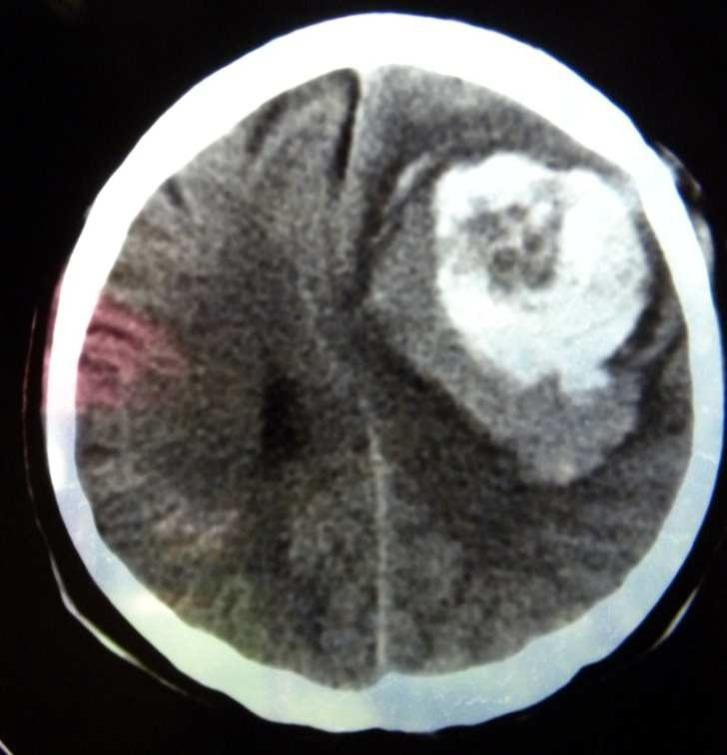

In [34]:
example["image"]

In [42]:
model.eval()

image = example["image"]
caption = example["caption"]

messages = [
    {
        "role": "user",
        "content": [
            {"type": "text", "text": "Describe this radiology image."},
            {"type": "image"},
            {"type": "text", "text": caption}
        ]
    }
]

text = processor.apply_chat_template(messages, add_generation_prompt=True)
inputs = processor(text=[text.strip()], images=[image], return_tensors="pt", padding=True)
generated_ids = model.generate(**inputs, max_new_tokens=64)
generated_texts = processor.batch_decode(generated_ids[:, inputs["input_ids"].size(1):], skip_special_tokens=True)

print("Actual caption:")
print(caption)
print("Predicted caption:")
print(generated_texts[0])

Actual caption:
 Metastatic brain lesion with central necrosis

Predicted caption:
 CT scan of the brain showing a metastatic lesion with central necrosis in the right parietal lobe.

